## Análisis de tweets
*Carolina Giménez Arias*

Este proyecto tiene como principal finalidad capturar y procesar tweets con el objetivo de analizar alguna situación. En concreto, se estudiará la situación del panorama político actual a través de la recolección de tweets durante la noche del debate electoral en Atresmedia del martes 22 de abril de 2019.

El trabajo presentado a continuación se divide en los siguientes puntos:

***1. Almacenamiento de tweets en MongoDB y json***

***2. Importación de datos***

***3. Análisis de la popularidad de cada partido***

***4. Word cloud: ¿De qué se hablaba durante la noche del debate electoral en twitter bajo el hashtag #ElDebateDecisivo?***

***5. Análisis de sentimientos: ¿con qué partido se asocia más cada sentimiento?***



## 1. Almacenamiento de tweets en MongoDB y json

Tal y como se ha visto en la asignatura, es posible almacenar datos recogidos en streaming en una base de datos de MongoDB. Para almacenar los datos que vamos a estudiar se han implementado dos opciones: recogida de datos en base de datos de MongoDB y almacenamiento en fichero json. 

El código que almacena los tweets en MongoDB emplea una base de datos llamada "TwitterStream". El nombre de la colección utilizada será "tweets". Es necesario crear esta colección de datos de forma externa al código (desde la terminal del ordenador) para comenzar a guardar los archivos.

Si se quisiesen hacer consultas en MongoDB, estos son algunos ejemplos:
- Para ver cuáles son las distintas localizaciones desde las que escriben los tuiteros, se escribe en la terminal:

**db.tweets.distinct("user.location");**


- Para contar cuantos tweets están hablando del partido "vox", se escribe en la terminal:

**db.tweets.find( { “full_text" : { $regex : /Vox/i }}).count(); **

El código de a continuación está preparado para capturar tweets en español que contengan el hashtag #ElDebateDecisivo y almacenarlos en un json y en una base de datos de mongo. Es importante tener en cuenta que se capturarán tweets siempre y cuando se esté ejecutando este código de modo que, si se quisiese detener la captura, bastará con detener el chunk.

In [18]:
# Importamos respectivas librerías:
import pymongo
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler, Stream
import datetime
import json
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

In [236]:
# Importante: Para dejar de capturar tweets se debe detener la ejecución de este chunk

# Conexión con MongoDB. El nombre de la base de datos es "TwitterStream" y la colección será "tweets".
connection = pymongo.MongoClient('localhost', 27017)
db = connection.TwitterStream
db.tweets.ensure_index("id", unique=True, dropDups=True)
collection = db.tweets

keywords = ["#ElDebateDecisivo"] #Leemos los tweets con el hashtag

language = ['es'] #Leemos sólo los tweets en español

# Cargamos nuestras claves
consumer_key = 'XXXXX'
consumer_secret = 'XXXX'
access_token = 'XXXXX'
access_token_secret = 'XXXXX'

# Se define una clase que captura tweets con la keyword seleccionada y los guarda en la base de datos de mongo
class StdOutListener(StreamListener):
    def on_data(self, data):
        try:
            t = json.loads(data) # Cargamos cada tweet en la variable t
            
            with open('tweets.json','a',encoding = 'utf-8') as f:
                f.write(data)
                
            # Seleccionamos los campos que nos interesan de los tweets:
            tweet_id = t['id_str']  # Identificador del tweet
            username = t['user']['screen_name']  # Nombre del usuario que tuitea
            followers = t['user']['followers_count']  # Numero de seguidores del tuitero
            text = t['text']  # Texto del tweet
            hashtags = t['entities']['hashtags']  # Hashtags usados en el tweet
            dt = t['created_at']  # Fecha y hora de la creacion del tweet
            language = t['lang']  # Lenguaje del tweet (en este caso será español)

            # Se convierte el campo del tweet "created_at" a formato fecha
            created = datetime.datetime.strptime(dt, '%a %b %d %H:%M:%S +0000 %Y')

            # Se cargan todos los campos seleccionados en una variable "tweet" que se guardará en mongo
            tweet = {'id':tweet_id, 'username':username, 'followers':followers, 'text':text, 'hashtags':hashtags, 'language':language, 'created':created}

            # Se guardan los datos almacenados en la variable "tweet" en la coleccion "tweets" de MongoDB
            collection.save(tweet)
            
            # Sacamos por pantalla el nombre de cada usuario y el texto de su tweet 
            print(username + ':' + ' ' + text)
            return True
        except:
            print("Este usuario no tiene ID.") #Los tweets de usuarios sin ID no se guardarán

    # Función que informa de errores:
    def on_error(self, status):
        print(status)

if __name__ == '__main__':
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    stream = Stream(auth, l)
    stream.filter(track=keywords, languages=language)

/Users/carolgimenezarias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning:

ensure_index is deprecated. Use create_index instead.

/Users/carolgimenezarias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning:

save is deprecated. Use insert_one or replace_one instead



godoitos: RT @NenoAluXe: Pero que PESADA ERES TIAAA

QUE PESADA @Albert_Rivera

#ElDebateDecisivo
manolivizoso: @_anapastor_  personante me encantaría ver un debate donde Casado y sobre todo Rivera esten controlados, que parece… https://t.co/Xh5BLyUGVr
Anyi_anonadada: RT @ALVAREZMNK: Yo, viendo a Pablo Iglesias llamando a Rivera maleducado. #ElDebateDecisivo https://t.co/dq8ckkqIor
JuanmaLk16: Joder, Iglesias, ha reventado el demagómetro con el tema alquiler. ¿La mayoría de arrendadores son fondos de invers… https://t.co/opEMUkDRde
PodemosCLineal: RT @ahorapodemos: Frente a la estrategia del miedo y la demagogia de @Albert_Rivera, propuestas para bajar los alquileres. 👇 

#ElDebateDec…
xibiru77: RT @Virginiapalonso: Anoche pensaba que el debate de RTVE era encorsetado. 24 horas después echo en falta ese encorsetamiento. Lo de hoy es…
SorayaAguayo: "Sánchez es como el aloe vera, cada vez que lo investigan salen más propiedades" #ElDebateDecisivo https://t.co/Jj3RPAvXAn
Ro_853: Rivera va

Claudia72902242: #ElDebateDecisivo Es imposible seguir el debate con la táctica de Rivera de interrumpir
ricasamo: @pablocasado_ @sanchezcastejon @Pablo_Iglesias_ @Albert_Rivera , me aburro!!! #ElDebateDecisivo @A3Noticias
javitapia23: RT @itssandraxx_: es que albert rivera es el típico de clase que cada vez que tú intervienes está como una mosca cojonera por detrás hablan…
legaria98: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
MarcelBL21: RT @podem_cat: 📺"Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas:

👉Renta garantizada
👉Escuela…
PaulaCachimiru: En Málaga no gobierna Podemos, gobierna el Partido Popular y desde que yo llegué aquí hace tres años he visto cómo… https://t.co/I3q5R4ihPy
harushi37: RT @ALVAREZMNK: Yo, viendo a Pablo Iglesias llamando a Rivera maleducado. #ElDebateDecisivo https://t.co/dq8ckkqIor
szbxm: RT @SendasEspirales: ¿Soy yo 

errezege: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/nol9287a…
Helensi26072410: @Formalito_el 🍸🍸🍸🍸🍸🤤🤢🤮me voy a dormir la mona #ElDebateDecisivo
marcpobla: RT @Pablosti: Rivera hablando de buitres inmobiliarios y la madre de la candidata a la alcaldía de Madrid de C’s (Begoña Villacis) es la ma…
Laura_RiveiroR: RT @juanrallo: Iglesias mete estrepitosamente la pata. Los fondos que invierten en vivienda (socimis) están obligados a alquilar el 80% de…
Dominguezd01_: RT @tortondo: Cuando se enfadan los Gemeliers.
#elDebateDecisivo
#DebateCTXT https://t.co/RZH2I2fSX0
JAGarciaBonares: RT @abalosmeco: Que quede claro. #PedroVuelveaGanar #ElDebateDecisivo https://t.co/9LhAyqlsyr
emaldonado061: RT @vox_es: 🚨🚨🚨 Ya puedes ver el discurso de @Santi_ABASCAL en Las Rozas.

¡Pasa de los cuatro  🦜🦜🦜🦜 del debate! #ElDebateDecisivo

⬇️⬇️⬇️…
PabloIglesiasF: RT @La_SER: 📹 VÍDEO | Pablo Iglesias: "Es usted muy maleducado

OscarAnton89: RT @ana_morgade: Igual cuando Rivera nos invitaba a escuchar el silencio era para que lo echaramos de menos hoy. 
#DebateAtresmedia #ElDeba…
arevalopenela: RT @bicicletagris: Vender vivienda pública a fondos buitre: muy bien.
Legislar para que los bancos tengan aún más fácil desahuciar a famili…
olatzhr: “Esto es como el aloe Vera, cada vez que investigan encuentran más propiedades. Pablo Casado.” esto es el… https://t.co/wluLhOEcnG
Cs_AlcazarSJuan: RT @Cs_BolanosC: .@Albert_Rivera "Yo propongo una ley para proteger a las familias de los okupas" #ElDebateDecisivo #VamosCiudadanos https:…
rmarinvergara: RT @populares: ▶ @pablocasado_: "Un Gobierno sensato, moderado y estable del Partido Popular es la única alternativa a Pedro Sánchez". #Cas…
Este usuario no tiene ID.
RocitoCs: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
Eduardolg7676: RT @110010010011010: Rivera ha llegado hoy 

CsACaniza: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
amr90arroba: Señores de la derecha que tiene que ver un alquiler excesivo con los okupas? #ElDebateDecisivo
SrtooTm: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
CsParla: RT @Cs_Madrid: 📺 @Albert_Rivera "Señor @Pablo_Iglesias_, le decimos NO a la Okupación. Yo no quiero que los okupas entren en su casa como o…
dyehuty88: RT @vanesantos09: Si los políticos del @populares y @PSOE tuviesen vergüenza al oír a los compañeros gritar @Jusapol #EquiparacionYa en la…
HelenaCyM: RT @SentidoComn8: Pablo Casado dando lecciones de corrupción jajajaja genial
#ElDebateDecisivo
#DebateAtresmedia
carlosxx_99: RT @MalditoDato: @eldiarioes @Albert_Rivera @Pablo_Iglesias_ «Aznar creó 5 millones de empleos cuando gobernó y Rajoy ha creado 2 millones…
gabigalo23: RT @Safrenor: ¿Esta no es la dosis de

neodimio18: RT @aroquesihombre: CUANDO SE TE OLVIDABA HACER LAS ACTIVIDADES DEL WORKBOOK Y EL PROFESOR TE PREGUNTABA

#ElDebateDecisivo https://t.co/ms…
Sunlight050621: #ElDebateDecisivo 
Madremia, si que se ha currado rivera el debate no? #Nomienta #notepongasnervioso https://t.co/U9zHKMbk8E
eualgemesi: RT @esquerraunida: Hay que ver lo nervioso que se pone Albert Rivera cuando Pablo Iglesias propone subir impuestos a bancos y grandes empre…
joseamg95: RT @norcoreano: Pedro Sánchez cada vez que habla Albert Rivera.
#ElDebateDecisivo https://t.co/Nh1smBn4vS
FriaSiberia: RT @iunida: Los grandes bancos no pagan nada a Hacienda por el impuesto de sociedades, @Albert_Rivera. A ti te parecerá fenomenal, por supu…
RoseHard_: Esto en vez del #ElDebateDecisivo
parece un debate de GH y nosotrxs twitteando de risas y sacando memes.
K3A2K0: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
Nacho_Gonzalez4: 

demigodcatt_: Rivera cuando está más de 5 segundos sin interrumpir #ElDebateDecisivo https://t.co/49WTIYmhtV
tbx_php: RT @ecorepublicano: Casado: cero propuestas contra la corrupción y el fraude fiscal  #ElDebateDecisivo https://t.co/H71hTFTXBB
Perriwy: La banca está viendo el #ElDebateDecisivo y ha decidido que va sacar su bolsa de viviendas para alquiler social y a… https://t.co/7LGWOKUazm
FrJosino: RT @DAljaba: @laSextaTV @_anapastor_ @VicenteVallesTV Para cuando  vamos a cobrar como las policías independentistas?. Por que me jubiló co…
hipypyji: RT @PatiCarazo: .@pablocasado_ : "La desigualdad es cuando hay paro. Si hay 3 millones de parados, hay desigualdad. Esto es lo que el Parti…
asuncionlopez4: RT @populares: ▶ @pablocasado_ llega a #ElDebateDecisivo y es recibido por funcionarios de prisiones al grito de "PRESIDENTE". 👏👏👏 https://…
Jexu73: Casado hablando de fraude. Si, Casado hablando de fraude. Que sí, que el tipo que es un fraude andante está habland… https://t.co/12AnSAjW

_GonzaloPastor: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Yo NO he pactado con los independentistas. 

📢La derecha puede repetirlo 1.000 veces pe…
_Ladrillazo_: @pablocasado_ cada vez que dice algo, miente. Los de @maldita_es y @Newtral no van a dar a basto. #ElDebateDecisivo #DebateAtresmedia
geemmalg: RT @c4nt4br0: Los payasos de la Tele. #ElDebateDecisivo https://t.co/xKOsBumwyW
merygea1: RT @faaarafiu: Tio pásame el workbook que está pasando lista
#ElDebateDecisivo https://t.co/maW6xzlrgR
rawdrii: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
anna_pozo: @Pablo_Iglesias_ echo de menos esa pequeña Constitución... 
#ElDebateDecisivo https://t.co/XgYRhKBISy
Jubiladofurioso: RT @JucilValencia: @Albert_Rivera Hoy señor @Albert_Rivera recuerde que entre otros temas está la verdadera #EquiparacionYA , su apoyo inco…
senormunoz: La frecuencia de actualización de las URLs es brutal ¿Cómo tendrán las cachés trabaj

Vitoquive: RT @GenIndomable: Ribera por favor déjame oir el silencio, lo necesito un rato.... callateeee un poquito #ElDebateDecisivo https://t.co/h2d…
VNGambP: RT @abalosmeco: Que quede claro. #PedroVuelveaGanar #ElDebateDecisivo https://t.co/9LhAyqlsyr
Vivazgz: A Rivera se le olvida que han estado en el gobierno de Susana Díaz...#EleccionesA3N #ElDebateDecisivo
CelisRivero: RT @Vega2Santos: Porque la pobreza infantil es la que más duele, el presidente @sanchezcastejon ha puesto medidas para resolverlo desde el…
Daviidseri9: RT @finallyxpablo: “Oye tío, yo te dejo lo de matemáticas y tú me dejas el workbook, ¿vale?” #ElDebateDecisivo https://t.co/IWvUiUG3JN
anerolb: RT @PiedrahitaLuis: ¡Vaya frase!

-¿Ha acabado usted de mentir? Ahora me toca a mí.

¿Gila?, ¿Berlanga?, ¿Azcona?... Pues no. Desgraciadame…
PPAlcobendas: 🎥 @pablocasado_ viene a #ElDebateDecisivo con propuestas de futuro sobre crecimiento y creación de empleo. Y lo que… https://t.co/7YCkgvIboq
GonvBromhead: Barcelona y Ma

albreakheatsse1: RT @_live2: Repita conmigo: Esto es un GUIRIGAI. #ElDebateDecisivo
KikeGarr: RT @diegodelacruz: #ElDebateDecisivo "Cualquiera que sepa un mínimo de economía entienda que, si no hay oferta, se dispara el alquiler". Co…
MacarenaCnPedro: RT @carmencalvo_: /❤ @sanchezcastejon se compromete en #ElDebateDecisivo a impulsar una reforma constitucional para blindar el carácter púb…
Jaime_Lopmart: RT @Timainas_: sánchez vs. rivera ROUND 1 #ElDebateDecisivo https://t.co/31AhXxPVPc
elooyu: RT @SuperPilopi: Pues podéis llamarme loco, pero NUNCA JAMÁS votaría para regir un país entero a una persona que no es capaz de seguir una…
MBlancaoficial: Vaya panorama que tenemos, solo les falta el " y tú más" para que parezca un patio de colegio #ElDebateDecisivo
robertalcaide78: RT @Tonicanto1: Frente a quienes pretenden pelearse otros 40 años más por un euro más en las pensiones, en @CiudadanosCs defendemos acabar…
Delifer13: RT @ierrejon: ¿Los gráficos de Casado son de @ElMundoToday verda

BerkmanGoldman: @Albert_Rivera va a ser el presidente de la natalidad. Su propuesta incluye pasar de noche por tu casa y follarse a… https://t.co/0995wHXe33
ansimi57: RT @MalditoDato: @eldiarioes «Soy el único candidato que está diciendo claramente quién está en su preferencia de gobierno», ha dicho @Albe…
M_Laura_G_93: RT @anaisbernal: Rivera, al igual que hizo Casado, vuelve e insistir en el discurso de la natalidad para mantener las pensiones. Rivera dic…
nyxdaemon: Me dio por hacer esto

Parece Mario Bros
Este usuario no tiene ID.
carglomir: pero Rivera va a dejar de interrumpir?? #debateatresmedia #ElDebateDecisivo
nmelesi: RT @RaquelNavalpot1: #ElDebateDecisivo Pablo Iglesias llamando maleducado a Rivera por las interrupciones, me representa! https://t.co/gZw0…
noemiamateo: RT @Miquel_R: No se valoran suficientemente las buenas formas de @Pablo_Iglesias_ en estos debates. Sereno, presentando propuestas y sin ha…
carapuchina: RT @ManuelBartual: “¿Ya ha terminado usted de mentir? A

MarinaAisa: Creo que no puedo ver más #ElDebateDecisivo de lo que me estresa Rivera interrumpiendo constantemente. 😑
TaksonR: #ElDebateDecisivo #DebateAtresmedia 
@pabloiglesias no quería la Constitución del 78 porque era un "candado", y aho… https://t.co/ZbrXTILrIA
wonderamil: RT @lovingindie: Me encanta cuando Rivera le dice al resto que no se pongan nerviosos si el que parece que va de speed hasta las trancas es…
capitanfurillo1: RT @aDanielPerez: Rivera está siendo un impertinente y maleducado, sabe que VOX le va a superar en escaños a Ciudadanos y su nerviosismo lo…
Edurneazul: El Naranjito está desatado, cuántos cafés de más se habrá tomado? #ElDebateDecisivo y el capitán del grupo más ladrón de Europa da ejemplo.
lau_ferlum: RT @SenoritaPuri: He visto farolas en mi barrio moderar con más energía que Ana Pastor y Vicente Vallés #ElDebateDecisivo
lunamontero23: RT @jesusacosta98: Habéis suprimido un impuesto que gravaba a herencias por encima de UN MILLÓN DE EUROS.

Para bajar los

VelachiVelachi1: RT @enriquelanuit: #tuabandonomepuedematar HOY YA HA ESTADO EN #ElDebateDecisivo. Qué orgulloso estoy de mis compañeros de #sosprisiones.
h…
LilianaGraciiaa: RT @kekoarteixo: Albert Rivera habla demasiado rápido, ¿Tendrá prisa o estará Malú con la cena en la mesa?..., #ElDebateDecisivo
Nieva730: RT @UPYD: 🔴 Como ayer, Sánchez habla por el PSOE y por Vox. Necesita tanto a la extrema derecha como la extrema derecha necesita al PSOE. L…
Simba_Hak_Mat: RT @JulioEscobarTF: Lo oyes? No, no es el silencio, es @Albert_Rivera interrumpiendo. #ElDebateDecisivo https://t.co/XTC3EZu8vQ
anitaRT_GR: RT @DiegoGagoB: En serio @Albert_Rivera discute que el @populares ha creado 5 millones de empleos con Aznar y 2,5 millones @marianorajoy ?…
anasainz99: RT @Farmaenfurecida: "Esto es como el aloe vera: cuando más lo investigan, más propiedades tienen"

Confieso que me he reído. #ElDebateDeci…
BeaMartv: RT @Javi_Barrena: La política económica de los @populares de @pablocasado_ con el econo

adole67: RT @KadizconK: Casado:
"El trabajo es lo que elimina la pobreza"

No señor Casado, el trabajo DIGNO.

El que crean ustedes no. 

#ElDebateD…
soloxequiparar: RT @lanoviadelpoli: @sanchezcastejon El país es seguro y tiene turismo por las FFCCSSEE. EquiparaciónREAL así valoran a su policía?
#Equipa…
camara_romy: RT @JuliaBayo1: 😳Rivera diciendo muy serio que va a bajar los impuestos..Se le olvida añadir que se los va a bajar sólo a los que más tiene…
ppsanroque: RT @populares: ▶ @pablocasado_ viene a #ElDebateDecisivo con propuestas de futuro sobre crecimiento y creación de empleo. 👇👇👇

#CasadoPresi…
_Nuria12_: RT @verdeoveja: Por si a alguien se le había olvidado, yo os lo recuerdo. 
#ElDebateDecisivo https://t.co/MjdcEY5kc6
mariaflillo: RT @antigilis: Mentir y decir que no es verdad es la única tesis que sabe decir Sánchez. Para todo lo demás Fraude
#VamosCiudadanos 🍊
#Vamo…
RafaelCSainz: RT @envozalta_libro: -¿Pero el pen drive con el powerpoint del trabajo no lo traías tú?
#E

zufreiro: RT @dannythedog96: Creo que hoy Rivera lleva mucho azúcar encima. #ElDebateDecisivo
amparoginerr: RT @PSEBizkaia: 🌹 @sanchezcastejon: Nuestro principal problema es la desigualdad. Hace falta justicia social y justicia fiscal. Proponemos…
Barbaenremojo: RT @MalditoDato: @eldiarioes @Albert_Rivera @Pablo_Iglesias_ «Aznar creó 5 millones de empleos cuando gobernó y Rajoy ha creado 2 millones…
ElTinteroVB: Puede haber debates todos los días que no van a proponer nada,lo único que hacen es el Pablo Alborán:"Tú y tú y tú.… https://t.co/tu5yC8S6sC
Evicchy: RT @MMMarmolina: Chupito cada vez que Alberto Rivera interrumpa
#eldebatedecisivo https://t.co/ZzWmzUpP2T
monte_chio: Sanchez tiene que leer todo lo que dice #ElDebateDecisivo
cxlxmxrdx: Cada vez que Rivera interrumpe a alguien #ElDebateDecisivo https://t.co/rmJ86QA4G6
cottoncitomio: RT @CarmenGPCs: .@Albert_Rivera “Impuestos: Un IRPF de más del 50% es confiscatorio. También hay que suprimir sucesiones como hemos hecho e…
7Josean7

estilvivenda: @Albert_Rivera deje de interrumpir a los demás. Acaba siendo cansino y como dicen algunos, es de mala educación. #ElDebateDecisivo
Robo_Rabbit: De 12 a 24 horas poder desalojar. Malnacidos.
#ElDebateDecisivo #ConelPPprimerolosbancos
Cs_AlcazarSJuan: RT @Cs_Argamasilla: 🇪🇸 @Albert_Rivera : " Si soy presidente del Gobierno, me comprometo a que, en los 100 primeros días, suprimiremos el im…
Roch96: Entre el Aloe Vera y el "fake" me estoy quedando muerta. No sé qué me gusta más si estas comparaciones extrañas o l… https://t.co/Pmu3V3lGHn
oiihaaneee_2: RT @MissBennet8: El único posible ganador que veo de este patio de colegio es Iglesias que al menos habla de lo que quieren hacer y no se p…
Migymar1: RT @populares: ▶ @pablocasado_: "Pedro Sánchez nos va a dejar una recesión con un lacito para el rescate, como hizo Zapatero". #CasadoPresi…
FrancisRuizp: Hoy nadie ha escuchado un silencio de Rivera #eldebatedecisivo
Menistofes: RT @protestona1: Casado miente cuando dice que el P

HespeTacular: RT @MalditoDato: @eldiarioes @Albert_Rivera @Pablo_Iglesias_ «Aznar creó 5 millones de empleos cuando gobernó y Rajoy ha creado 2 millones…
rosa67romero: RT @marinaLobL: Rivera está desaprovechado. Sería el puto amo en un call center. #DebateCTXT #Eldebatedecisivo
davsotoc: RT @PiedrahitaLuis: ¡Vaya frase!

-¿Ha acabado usted de mentir? Ahora me toca a mí.

¿Gila?, ¿Berlanga?, ¿Azcona?... Pues no. Desgraciadame…
Iris_Vega1D: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
yaiprieto17: RT @itssandraxx_: es que albert rivera es el típico de clase que cada vez que tú intervienes está como una mosca cojonera por detrás hablan…
ales_aragon: RT @populares: ▶ @pablocasado_: Sí, vamos a bajar los impuestos a los españoles.

#CasadoPresidente🇪🇸 #ElDebateDecisivo https://t.co/U25R36…
hiadrieeele: RT @La_SER: 📹 VÍDEO | Pablo Iglesias: "Es usted muy maleducado, señor Rivera"

https://t.co/gKCG2jBXqN 

carlos_torrents: Clarísimo el presidente @sanchezcastejon: Yo nunca he pactado con los independentistas... Ni pactará con el… https://t.co/Q8h694o9IB
MaryJurjo: RT @locodelpelorojo: Albert Rivera propone un contrato único que supondría reducir la indemnización por despido a 20 días por año; antes es…
Lurtxu_8: Que Casado le está diciendo que es socialdemócrata y a Rivera le está bizcando un ojo #ElDebateDecisivo
victorvidal_98: RT @Noelia_Gcia: #ElDebateDecisivo Pablo Iglesias llamando maleducado a Rivera por las interrupciones https://t.co/xGPk95Wvw9
Anna_Lluch: RT @PabloMM: Pues no es Pablo Iglesias santo de mi devoción, pero es de agradecer que vaya a un debate a proponer medidas concretas, en lug…
pepmalagrava: Ya sabemos las propuestas sobre alquiler...
Derechas: Los okupas a la cárcel (nada sobre precios)
PSOE: Ya si eso..… https://t.co/0ofzTFaZSF
_dracarys96: "Es dar seguridad al arrendatario" En idioma del PP, a mis coleguis los RICOS y los bancos con tropecientos pisos vacíos.

juancocinillas: RT @PabloMM: En el bloque dedicado al empleo, Rivera, Casado y Sánchez se ponen a discutir sobre Torra y Cataluña. Los problemas de la gent…
mari98mu: No hablan de lo que de verdad importa, tan solo se tiran basura unos a otros. #ElDebateDecisivo
Ruben_Sardon: RT @diegodelacruz: #ElDebateDecisivo Pablo Iglesias quiere aumentar la presión fiscal "simplemente ocho puntos del PIB". Es decir, "simplem…
isabeldbr: RT @ahorapodemos: 📺 "Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas: renta garantizada, escuel…
lope_sagrario: RT @carmencalvo_: /❤ @sanchezcastejon se compromete en #ElDebateDecisivo a impulsar una reforma constitucional para blindar el carácter púb…
Thespanishtruth: RT @RaquelNavalpot1: #ElDebateDecisivo Pablo Iglesias llamando maleducado a Rivera por las interrupciones, me representa! https://t.co/gZw0…
MomparlerTo: RT @LolaPareja: Iglesias le dice a Rivera que es un maleducado. Me representa.

#ElDebateDecisivo https

aniii_27: RT @JaVaaaLoL: Si esto sigue asi albertito nos va a vender hasta su droga #ElDebateDecisivo https://t.co/CVTQjV2zo9
szbxm: RT @nandoo_duru: No sabia que estabamos en un gallinero... Así no hay quien pille las mentiras de los candidatos de @populares y @Ciudadano…
Kenjorato: RT @_JuanFdez_: Cuando te tocaba el amigo invisible con el que te caía mal #ElDebateDecisivo https://t.co/MP17GEQeWo
MilkaNat: RT @ahorapodemos: 📺 "Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas: renta garantizada, escuel…
Dacepi1: RT @JupolHuesca: Nos emociona ver a nuestros hermanos de ⁦@Jupol_Madrid⁩ LUCHANDO por TODOS a las puertas del #DebateAtresmedia 
PIDIENDO #…
pintax99: RT @escarvasopas: #ElDebateDecisivo
A Pablo Casado se le ve nervioso, nunca había estado dos días seguidos con un profesor de universidad e…
humanordancer_: Que paren ya el debate
MiguelSese: Hoy sí que está arrasando Vox en #ElDebateDecisivo
Este usuario no tiene ID.
ThisJoose: RT @Viv

carlosdd59: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
Alex_Drake97: RT @intomahoran: ojalá alguien me tuviese tan presente como pablo iglesias tiene a la constitución

#ElDebateDecisivo
cottoncitomio: RT @Vanesa05557831: Ese es su mayor problema yo creo...que no escucha!#VamosaGanar #ElDebateDecisivo https://t.co/qt7sg3Rj5H
luciaardrgz: "Pero no mientas señor Casado"
"Señor Sanchez esta muy nervioso" JAJAJAJAJAJAJAJAJAJAAJ #ElDebateDecisivo
elcorcheas: eeeee la aloevera ni me la toques. Alo evera es mi Dios! @pablocasado_  #ElDebateDecisivo
Porttnoy: RT @JosPastr: Iglesias ha empezado en plan moderador pero se está desatando y ya tiene la misma cara de cabreado de siempre. En nada se rem…
Pedrovega83: RT @CarmenDdB: Qué bien se gobierna con los presupuestos de otros y atribuyéndose sus méritos  #ElDebateDecisivo
adri_degea13: RT @JorgedeCastro_: #ElDebateDecisivo @Albert_Rivera metiendose 

OscarCsLeon: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
vilocatil: RT @faroleroficial: Albert Rivera sabe lo que va a pasar, es el Cuervo de Tres Ojos. #ElDebateDecisivo https://t.co/qFHPt2ATi3
estefbueno: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
estherrs_: RT @terafobia: oyen eso? 
.
.
.
.
es Albert Rivera farfullando de fondo

#ElDebateDecisivo
dobrevslance: RT @evotef: peblo vive la lucha sigue https://t.co/WMbA2cPa2Y
mariacanod991: Enferma me estan poniendo,EN FER MA. VOTAD CON CABEZA POR FA #ElDebateDecisivo
mariantoniaram2: RT @JIEchaniz: 🔵 Sánchez no quería un cara a cara porque sabe que @populares es la única alternativa a su gobierno, apoyado por los votos d…
d_smile_: RT @Cesarsvlla: Creía que Pablo Fra-Casado no estaba!!
#ElDebateDecisivo
zeroeland: Hoy se le ha ido la mano a Rivera, relájese hombre #ElDebateDecisivo
PodemGodella: RT @Sergiotas73: Dice Pablo Casado qu

chepiramone: Me encantaría Susanna Griso moderando el debate:

"A ver pringaos, ¿Pero vosotros habéis visto lo bueno que está Ab… https://t.co/j9uE4awrSr
Luisjo21357869: RT @jmartinezraya: Dice Falconetti que el debate no es bajar los impuestos, sino ver quien ha de pagar más.

La respuesta es fácil: vamos a…
PDS135: RT @Virginiapalonso: Anoche pensaba que el debate de RTVE era encorsetado. 24 horas después echo en falta ese encorsetamiento. Lo de hoy es…
susanfuen: Albertin se ve ya presidente 😂😂😂😂 cambia de asesores #ElDebateDecisivo
Y_a_Los_50_Que: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
IbericaIris: RT @pasandoeldia1: @Santi_ABASCAL hoy repiten lo de ayer, si ayer era malo... Hoy es pésimo. Gracias @vox_es por haber llegado. 
🚨Os animo…
sofiblaya: Donde esta el @populares comentando la propuesta de  @pablocasado_  ?? vamos!!! #ElDebateDecisivo
crispalomo: RT @locodelpelorojo: Dice Pablo Casado que "la desigualdad se produce cuando hay paro". No, la desigualdad se produc

J_Casati: RT @jmlopezzafra: Lo más acojonante es que un economista, teóricamente no marxista y teóricamente doctor, en el s. XXI, se crea el cuento q…
elFavila: “Como el aloe vera”. Encima magufo 

#ElDebateDecisivo
Cs_Marin_: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
rocioguijarro95: RT @Piti_Martinez: Alguien le podría explicar a Iglesias que no toda la Constitución tiene eficacia directa? #eldebatedecisivo
maca_puentes: "Vamos Rivera vuelve a bailar que tú lo haces fenomenal"

Zasca de @pablocasado_ sacando sus años de ceguera con Su… https://t.co/Dsok8yFHVs
DiegoSG8: RT @martaflich: ¿RIvera no hizo apología de " el silencio" ayer?¡ Dios! qué rucurucu todo el rato por lo bajini.  #ElDebateDecisivo
elias_laura: @Albert_Rivera lo oyes? Lo oyes? No. No oigo el puto silencio porque no te callas ni un segundo. Maleducado.  #ElDebateDecisivo
mariaflillo: RT @irene_tarrago: 🍊 La precariedad es

fsicilia: RT @juanrallo: No, el problema de la vivienda no es la vivienda vacía. La vivienda vacía lleva décadas cayendo en España y es especialmente…
albertogastor: RT @Sylviacadiz: Por favor que alguno le diga a Rivera cada vez que interrumpe   PORQUÉ NO TE CALLAS !!!!!!!!!!!!!!!!!!!! #ElDebateDecisivo
saraaubedaa: Como el áloe vera, cada vez encuentran más propiedades, ME MUERO JAJAJAJA #ElDebateDecisivo
MRElectrique: Lo del aloe vera. 
#ElDebateDecisivo 
#DebateAtresmedia https://t.co/pgqlPPpUSO
enerynitram: RT @MalditoDato: @eldiarioes @Albert_Rivera @Pablo_Iglesias_ «Aznar creó 5 millones de empleos cuando gobernó y Rajoy ha creado 2 millones…
Moratarom1123j: RT @JovenesCCOO: 👁‍🗨 El contrato único enmascara más mentiras que verdades cuando facilita las causas del despido a los empresarios y prete…
carlosaspe: Alquilo desde los 21. No he ocupado nunca. Dedico más de un tercio de mi sueldo (cuando lo tengo) en pagar el alqui… https://t.co/bsvR3Qcwmm
mario130100: RT @moedetriana: Ho

Historia0131: RT @MMMarmolina: Chupito cada vez que Alberto Rivera interrumpa
#eldebatedecisivo https://t.co/ZzWmzUpP2T
MariyoMarijo: RT @La_SER: 📹 VÍDEO | Pablo Iglesias: "Es usted muy maleducado, señor Rivera"

https://t.co/gKCG2jBXqN #ElDebateDecisivo https://t.co/ltw3E…
pilar_madrigal: RT @JoseRodriguezdG: Rivera es tan liberal como Marine Le Pen #ElDebateDecisivo
yolanro: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
CaveCanemLegere: RT @BegunSlm: Hoy, San Jordi, a Sanchez le han regalado su  tesis y una nota que dice:  Léeme.
#VamosAGanar 
#ElDebateDecisivo https://t.co…
hsrodulv: RT @intomahoran: Rivera: habla

Yo:

#ElDebateDecisivo https://t.co/6jQLelNL5L
Just_VNG: Las únicas propuestas de los fachas de derechas en materia de vivienda es echar a los ocupas?  #ElDebateDecisivo
colds0und: RT @terafobia: oyen eso? 
.
.
.
.
es Albert Rivera farfullando de fondo

#ElDebateDecisivo
Javierme

fdomenechm: RT @patricialopezl: "Si nos preguntan sobre empleo no deberíamos hablar de Torra", dice Iglesias.
"Eres el árbitro", responde Albert Rivera…
mcmnq: RT @CLM_Podemos: "Hay mujeres que cobran menos por el hecho de serlo. La inspección de trabajo debe poder entrar en las empresas para compr…
Cs_Cambados: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
Anna_280112: RT @miraquenoloves: A acabado usted de mentir? Ahora me toca a mi. 🤣🤣🤣🤣🤣🤣
#ElDebateDecisivo https://t.co/hZdJvdM25S
98Mariahf: RT @Juristanloqcido: Cuando empiezas a leer el examen y ves que cayó el tema que no miraste

#ElDebateDecisivo https://t.co/WhLM3XdGxT
javierggescuder: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
pekenikes: Un.okupa es un.padre y una.madre con, en.paro, con.hijxs y víctima de la política especulativa del ínclito Aznar, G… https://t.co/4Aq4pQK2Fj
antonioluisls: Pues qué decepción

CarlosBozalongo: RT @Iratxotravesa: El IRPF hay que subirlo pero depende a quien, a los que no llegan a los mil euros se lo bajamos. Somos los únicos que pr…
diieegoBS: Esto si es el debate decisivo #ElDebateDecisivo https://t.co/Sl5Yd1dFoh
CsCanarias: 🗣 @Albert_Rivera "Sánchez ha estado diez meses rindiendo pleitesía a los separatistas"
#ElDebateDecisivo… https://t.co/9awIS3ja5q
JoseCs79: RT @CsMadridCiudad: 🍊 @Albert_Rivera “Si soy presidente, no me conformaré con ser el 2° país de Europa con más paro y precariedad. Propongo…
DiazBano: RT @protestona1: Casado miente cuando dice que el PP siempre baja los impuestos.
 La presión fiscal ha subido en todos los gobiernos del PP…
enfermerasviaje: RT @SoyArbowin: Rivera solo sabe decir "Señor Sánchez, está usted muy nervioso" entre eso y lo de Cataluña, lo tiene todo hecho. 
#ElDebate…
Kirhuga: RT @vmm7773: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una c…
MAARAAT

el_jorpin: Acaba de hacer Casado el chiste del aloe vera?? Pues a la espera estoy de que Rivera cuente el de mis tetas #ElDebateDecisivo
anitooo: Que es esto un debate político o una clase de infantil?! #ElDebateDecisivo
TheForg99: RT @PabloMM: En el bloque dedicado al empleo, Rivera, Casado y Sánchez se ponen a discutir sobre Torra y Cataluña. Los problemas de la gent…
Jjo_Rodriguez: #ElDebateDecisivo
La derecha en este país es como #Cancerbero, el perro de #Hades (dios del inframundo). Un perro m… https://t.co/ct1ZVDEvgO
topdriver_09: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 “No hay que tener miedo al debate”, le espeta Rivera a Iglesias. “Mucha gent…
CobraVerde5: RT @librepensadorJG: Iglesias: el de la alerta "antifascista", el que admira a Otegi, el que lloraba la muerte de Castro y Chávez, el de as…
HotsinhoG: RT @SorayaAguayo: Rivera y Sánchez enseñándose libros entre sí 
#ElDebateDecisivo https://t.co/hMLV2GCmKa
pablomorillah: Sánchez está mirando demasiado

David_III_L: Que vergüenza Casado, por favor, que vergüenza. Todo datos falsos, TODO. Hablando de economía mintiendo a sabiendas… https://t.co/Lprza8draE
CaveCanemLegere: RT @Petuniera: No hay más que ver cómo está #Venezuela; votar @PSOE y votar @ahorapodemos es llevar a España por la senda del chavismo. No…
CsJaca_: RT @CsSantona: 🍊 🎥@Albert_Rivera: No puede ser que prolifere la Okupación.
@ciudadanos propone una ley contra la Okupación para proteger a…
framonmora: RT @tonisolano: No se pueden hacer debates en clase porque los niños de ahora son unos maleducados que se interrumpen constantemente #ElDeb…
dandindan: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
Matilde40583095: RT @agdelatorre42: El 28 A Día SST, día de recuerdo y reivindicación pero ad+ es #28A votemos por políticas q generen empleo de calidad don…
Militantes_PSOE: RT @MalditoDato: @eldiarioes @Albert_Rivera @Pablo_Iglesias_ «Aznar creó 5 millones de empleos cuando gobernó y Rajoy ha creado 2 mil

Carlisvalle: RT @TowandaRebels: Te puede o no gustar @Pablo_Iglesias_  pero es innegable que es el único que sabe debatir con respeto, como un adulto y…
superurbi: RT @hartman_28: Como podéis observar, la educación no es cuestión de traje y corbata.
''El coletas del sueter'' es el único que se está com…
Mauly81: Pablo Casado haciendo los gráficos con el Paint #ElDebateDecisivo https://t.co/HsLKYSYwjy
Especta40022078: RT @Naino9: La cara de Iglesias escuchando las memeces de Rivera me representa...
#ElDebateDecisivo https://t.co/tWwbGmJRkb
Anibennet: RT @AquaLayx: la cara de Pablo Iglesias con el resto peleandose lo dice TODO #EldebateDecisivo https://t.co/tLeWQCwbDj
silviaemediaz: #ElDebateDecisivo vaya, parece que alguien quiere llevarse el título de político graciosín... https://t.co/fwgPiXavtB
carmenpelaz: RT @LuzInsurrecta: "Qué bien se ve,
Me trae loco su figura,
Ese trajecito corto le queda bien,
Combinado con su lipstick color café.
Qué bi…
JoseanPastor: RT @DRZRZ: #ElDebateDeci

Albapar_: RT @Denfurecido: Mira, mi concentración cuando me pongo a estudiar por las tardes 

#ElDebateDecisivo https://t.co/kiTuJUmI54
andres_cartero: RT @ahorapodemos: 📺 "El sistema de pensiones de nuestro país hay que protegerlo, y nosotros solo pedimos una cosa: que se cumpla la Constit…
jaime_aielo: @pablocasado_ Gracias a @populares, ningún español se sentirá desprotegido fuera de su tierra. 🇪🇸 La tarjeta sanita… https://t.co/AOcyGCWetr
LuisHto_RF: Qué fumáis.
D_Rodas_Martin: RT @juralde: Hoy Pablo Iglesias está que se sale. Dando una lección en formas y en contenido al resto de participantes en #EldebateDecisivo…
RafaelCorrale11: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
EsMiPerroAbuelo: RT @La_SER: 📹 VÍDEO | Pablo Iglesias: "Es usted muy maleducado, señor Rivera"

https://t.co/gKCG2jBXqN #ElDebateDecisivo https://t.co/ltw3E…
mrh0099: RT @Recaredo589: #ElDebateDecisivo
Impresionante VOX en Las Rozas... 
https://t.co/Vd43uurfNG https://t.co/r3M5yzLdMd
M3

viriich: RT @ierrejon: ¿Los gráficos de Casado son de @ElMundoToday verdad? Que quienes cada vez que han gobernado han robado miles de millones de e…
votantecomotu: Ayer fue un debate mas correcto. Hoy como no hay minutos sin interrupciones pues el salvame deluxe #ElDebateDecisivo
AcitanaAcs: RT @GenIndomable: Ribera por favor déjame oir el silencio, lo necesito un rato.... callateeee un poquito #ElDebateDecisivo https://t.co/h2d…
marielaolmosm: RT @vmm7773: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una c…
Pepeeluu: RT @MeroStation: Atravesad el iris #ElDebateDecisivo https://t.co/M5X5fygpdE
aljadim: RT @sikokosmik: #debateAtresmedia
#ElDebateDecisivo 
Bravo Pablo bravooooooooo
RIVERA MALEDUCADO y mucho, macarra.
Este usuario no tiene ID.
isabelsanbe: RT @SalazarRoPaco: Mientras Casado y Rivera continúan con el ruido, la extravagancia y el enredo, @sanchezcastejon se compromete a blindar…
FernandoActua: RT @

IsauraAbelairas: RT @PSMostoles: /❤️@sanchezcastejon: Quiero dejar clara una cosa desde el principio del debate, YO nunca he pactado con los independentista…
Frico75: RT @vox_es: 🚨🚨🚨 Ya puedes ver el discurso de @Santi_ABASCAL en Las Rozas.

¡Pasa de los cuatro  🦜🦜🦜🦜 del debate! #ElDebateDecisivo

⬇️⬇️⬇️…
montsecasaus: RT @pichicucho: 🔴 Pablo “Pasado” hablando de deuda pública 

La herencia de la ‘era Rajoy’: 418.622 millones más de deuda en dos mandatos…
lynxnordic: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
MaMeRiWiATa: RT @ahorapodemos: 📺 "Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas: renta garantizada, escuel…
paulaba98: RT @EfrenCruz: ¿Lo escuchas? No es el silencio, es Albert Rivera que no para de interrumpir. 
 #ElDebateDecisivo
ORNELA55462955: RT @Tomas982: Qué bien Rivera hablando de vivienda #ElDebateDecisivo https://t.co/1PzH1Quvg6
Juanlvar

MMariasun: RT @eldiarioes: Pablo Iglesias critica que Pedro Sánchez no fijara en la ley la subida de las pensiones: "Que las cámaras entren al Pacto d…
andreualcover: RT @psibpsoe: /♥️@sanchezcastejon en #ElDebateDecisivo➡️Hemos revalorizado las pensiones y estamos tomando medidas para hacer que el sistem…
pedro_rando: #ElDebateDecisivo si los coge Abascal les da un repaso que los pone al dia. @vox_es
B_IsaacPeral: RT @CartagenaExiste: @antoniogs_ct Todo no puede ser reprensentado por una sola ciudad.
#TodoNOesMurcia
Si de verdad crees en la #CARM no p…
Dori74176530: RT @atresmediacom: El candidato de @ahorapodemos, @Pablo_Iglesias_, llega en taxi a las instalaciones de Atresmedia. 

#ElDebateDecisivo ht…
FotonAcelerado: RT @Victor_Seven7: Con esta imagen todos sabéis de quién hablo, ¿no?  #ElDebateDecisivo  (vía @pavocallate) https://t.co/wWgkenAPuT
Adelante_MLG: RT @iunida: Los grandes bancos no pagan nada a Hacienda por el impuesto de sociedades, @Albert_Rivera. A ti te parecerá fen

PodemosCosteraS: RT @ahorapodemos: Frente a la estrategia del miedo y la demagogia de @Albert_Rivera, propuestas para bajar los alquileres. 👇 

#ElDebateDec…
anngeeelagr: RT @RaquelNavalpot1: #ElDebateDecisivo Pablo Iglesias llamando maleducado a Rivera por las interrupciones, me representa! https://t.co/gZw0…
JhonahJameson: Me voy a dormir que veo que antes levanto España sonámbulo que viendo  #eldebatedecisivo
annmavvi: RT @SrFortfast: IMPERTINENTE #ElDebateDecisivo
carmela87874604: RT @_Aitana_R: Rivera, todos los partidos con representantes en el Congreso de los Diputados son legales y constitucionalistas. Te enteras?…
kassimi_salim: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
MSPE_C_LMancha: RT @ladelaplaya: No olvidemos diversidades familiares por favor. Más del 50% de familias monoparentales están en riesgo de pobreza.@pabloca…
CACHIVACHES10: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el pla

aluquespi: - Periodista:  Vamos a hablar sobre el alquiler.
- Gemelos Cachitos: Vamos a hacer una ley contra la ocupación.… https://t.co/c0w0Fy9Fdz
678Carmen: RT @Sutcliffe_1: Le ha picado a Alberto Carlos el rapapolvo de Iglesias en cuanto a educación. Ya ha sacado la casa, Venezuela al caer.

 #…
04_paqui: RT @DaniRemigio: Rivera es el que nunca se callaba en clase, Sánchez el que siempre se copiaba los deberes y también en los exámenes, Igles…
La_Chimol: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
Este usuario no tiene ID.
aaroncano_: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
pablitvb: PARECE EL BEBÉ DE DINOSAURIOS
CelisRivero: RT @Vega2Santos: Pues esta noche @malditobulo tiene mogollón de curro con Casado y Rivera en #ElDebateDecisivo #DebateAtresmedia https://t.…
bocijaro: Soy de los pocos indecisos que quedan. Estoy entre ERC y VOX. A ver qué dicen esta noche. El que lo haga mejor tien… https://t.c

D_Rodas_Martin: RT @irinnecesaria: Mi enhorabuena al asesor de Casado que ha evitado que saque los gráficos en comic sans #ElDebateDecisivo
anacamins: RT @populares: ▶ @pablocasado_ viene a #ElDebateDecisivo con propuestas de futuro sobre crecimiento y creación de empleo. 👇👇👇

#CasadoPresi…
twinkiwinkii: “Lo rojo me lo he inventado y lo azul también” #EldebateDecisivo #DebateAtresmedia https://t.co/ihFFw0Dkn9
jbx__: cuando alguien me dice que va a votar a Ciudadanos es porque no está viendo los debates porque aguita de cal y aren… https://t.co/cBoO4NX3GL
666olga: RT @JimRipense59: #ElDebateDecisivo poner el bozal a Rivera por favor no para de interrumpir más educado https://t.co/DGRZdsZMgJ
javifontalba: RT @JesusSanchez__: La cara de Rivera tras el rapapolvo de Pablo Iglesias #ElDebateDecisivo https://t.co/2Bb2wQUr1I
xeniacamins: Qué verguenza estos políticos... Una pena que tengamos que elegir de entre esta baja clase política como futuro pre… https://t.co/pNleejDDJV
Barbaenremojo: RT

El_Offy: RT @vmm7773: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una c…
CsAstillero: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato e… https://t.co/fefgxdN19E
eMe_delaR: Claro, claro... JAJAJAJJAJAJA
femarzati: RT @MMMarmolina: Chupito cada vez que Alberto Rivera interrumpa
#eldebatedecisivo https://t.co/ZzWmzUpP2T
Ibon_dc: RT @jusapolaragon: @larazon_es @sanchezcastejon Nos a igual:
💙 @populares @pablocasado_ 
🌹@PSOE @sanchezcastejon
🍊 @CiudadanosCs @Albert_Ri…
sergioortegosol: RT @Anonymus_ES: Pablo Iglesias "Los Okupas tienen que "okupar" una vivienda."

Recordemos que en su palacio de Galapagar tiene un muro de…
anuskaadiaz: sin saber respetar el turno de palabra y con posibilidades de gober

ugeimagina: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
Sebas28Gambini: RT @elespanolcom: Rivera a Sánchez: "Le he traído un libro que no ha leído: su tesis doctoral" #ElDebateDecisivo https://t.co/1sd487kVrK
pacopaquero: ¿Qué pasaría si al final del debate hicieran un test de drogas? ¿Creéis que alguno daría positivo?
#ElDebateDecisivo
Maikascorpio: RT @Ismaelescuincs: ☝🏻 Menos mal que al final no se aprobó el dieselazo. Si Sánchez sigue es lo primero que va a aprobar.

❌ Sánchez meterá…
LauraMendez_15: RT @Warrior87x: Te puede gustar más o menos, pero el único que habla con respeto, sin interrumpir y con educación es Pablo Iglesias.

#ElDe…
Arancha41748834: RT @Danips: Yo le mandaba okupas al cerebro de Rivera, a ver si con un poco de suerte le entra algo en la cabeza y deja de sonar el eco inf…
JaviDorado: RT @hugomanchon: José Luis, calienta que sales.

#ElDebateDecisivo https://t.co/1FE1phbc9o
lavlaverb: RT @L

Este usuario no tiene ID.
Luis_Brato: Deberían poner una bomba de @A3Boom en el atril de cada candidato que explote cada vez que mienta, que al final la… https://t.co/RGY1wLyTtA
lupicinio: RT @BrujulaOndaCero: "Mucha gente que vota a @Albert_Rivera no le gusta que sea tan maleducado. Se puede debatir sin ser tan impertinente":…
JesusNJ7: El/la maquillador/a se ha pasado un poco, ¿no? 
#ElDebateDecisivo
Rohasha8: Casado y sus dibujitos en #ElDebateDecisivo
De vergüenza ajena. Qué broma, él hablado de corrupción 
Vosotros… https://t.co/Z2ycfevkGe
russicnboy: RT @Avyshia: Mi amiga: Tía, vas más ciega que la hostia, deja ya de beber. 

Yo: Qué no, coño, que voy bien. 

#ElDebateDecisivo https://t.…
CarmenCc86: Yo es que me parto con este señor, si tantas cosas vas ha hacer porqué no las has hecho ya. Que lo único de lo que… https://t.co/zJHpFz42fu
15_Juanjo: Ver #ElDebateDecisivo y solo observar cómo se ladran como perros. El único que parece decente para establecer una c… https://t.co/QXH

luciajimeneziii: RT @RdelRG: 📺 Si se paraliza la oferta de alquiler, no habrá pisos asequibles. De primero de Económicas señor Iglesias, "Si aumentas la ofe…
f_mjose: RT @_ju1_: Creo que Albert Rivera se ha hundido él solito hoy. Y me alegro. #ElDebateDecisivo #DebateAtresmedia
rubenblanco24: RT @CdV_Andalucia: Cada vez que escuches hablar a Pablo Iglesias recuerda que uno de sus ídolos es Lenin, ese que consideraba que la mentir…
culebrxs: RT @tupsolo: Te dejo el workbook, pero cambia algo para que no nos pillen. #ElDebateDecisivo https://t.co/2u4Hjr2zdy
obviok5: RT @JaVaaaLoL: Si esto sigue asi albertito nos va a vender hasta su droga #ElDebateDecisivo https://t.co/CVTQjV2zo9
merm_redondo: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
EdBlack1996: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
RidleyOWA: RT @Mario_2G: ¿Lo oyen? Soy yo

inestesiada: RT @nachoalvarez_: Ciudadanos propone un contrato único. Supuestamente significa convertir los temporales en fijos. Pero lo que Rivera no d…
JuanaSanchezMon: RT @emiliovicruz: @sanchezcastejon “Vamos a impulsar una reforma constitucional para garantizar la sostenibilidad de las pensiones públicas…
MontesRosales: RT @populares: ▶ @pablocasado_: "Un Gobierno sensato, moderado y estable del Partido Popular es la única alternativa a Pedro Sánchez". #Cas…
JSanchezMaicas: RT @PiedrahitaLuis: ¡Vaya frase!

-¿Ha acabado usted de mentir? Ahora me toca a mí.

¿Gila?, ¿Berlanga?, ¿Azcona?... Pues no. Desgraciadame…
Sanvi1848: Compañero, el mismo patinazo  dos veces seguidas...error incomprensible
xurirux: Pero dejad de hablar de paro coño. Que ni con un sueldo decente uno puede ahorrar a menos que comparta piso con 7.… https://t.co/n6Q0WJ5gWw
grisuco: RT @_iojesus: Si queremos tener un verdadero gobierno y parlamento que cuide lo social, lo público, a la gente Unidas Podemos tiene qu

BlancaIbarz: RT @PaulitaBTW: Hasta ahora baño de Pablo Iglesias solamente porque no entra en las peleas de patio de recreo. En oratoria es evidente que…
pikihermoso: RT @ismaelquesada: Le pregunta Ana Pastor a Pedro Sánchez si no le cierra la puerta a gobernar con Ciudadanos. Cerrarle la puerta dice. ¡Pe…
JesusPaniaguaP: RT @CsValdemoro: 💰 @Albert_Rivera “Preparen sus bolsillos señores ciudadanos, porque como llegue Sánchez a la Moncloa, les va a meter la ma…
eugeniavieito: RT @nachoalvarez_: Ciudadanos propone un contrato único. Supuestamente significa convertir los temporales en fijos. Pero lo que Rivera no d…
vilocatil: RT @lidia67013162: #ElDebateDecisivo Quien es el ganador del debate?
franmaria24: RT @Yo_Soy_Asin: Alguien tenía que decírselo.

Pablo Iglesias:

Deje de interrumpir constantemente señor Rivera, es usted un impertinente y…
MartinChamoso: RT @LolaDelgadoG: Nuevamente las derechas se alían para crispar, desinformar y hacer show (por no decir ridiculizar) un momento que

cejitukis: RT @Warrior87x: Te puede gustar más o menos, pero el único que habla con respeto, sin interrumpir y con educación es Pablo Iglesias.

#ElDe…
karenh_actriz: RT @SoniaVivasRive3: Rivera es como el delegado chivato de clase que todo el rato farfullaba por detrás.El que hacía listas negras de compa…
sanduhadah: RT @SoniaVivasRive3: Rivera es como el delegado chivato de clase que todo el rato farfullaba por detrás.El que hacía listas negras de compa…
revistaforxa: RT @CJC_Media: La propuesta de los comunistas ante el problema de vivienda ⬇️
#DebateAtresmedia #ElDebateDecisivo 
#DeNuevoElPartidoComunis…
OtBronn: RT @MainWoomy: #ElDebateDecisivo

Resumen del debate.

Rivera es un maleducado, un conteston, y un niño pequeño, básicamente.
Y_a_Los_50_Que: RT @elpais_espana: El verificador del #ElDebateDecisivo | Es falso que Junqueras haya dicho en público que quiere indultos a cambio de esca…
Anuska_Way: RT @_SyL_Gasso: Nervios vs Respeto #sepuedesereducadoporfavor? 🤬 #ElDebateDecisi

smartinezgomar: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
Txomin_R3: RT @_ju1_: El problema de la gente no son los okupas, gilipollas. ¡El problema de la gente es que no puede tener una maldita vivienda, imbé…
LuisGasparm: RT @PiedrahitaLuis: ¡Vaya frase!

-¿Ha acabado usted de mentir? Ahora me toca a mí.

¿Gila?, ¿Berlanga?, ¿Azcona?... Pues no. Desgraciadame…
unaokupadelbdm: pues que quieres que te diga,para historial periodístico la TVE. que es de donde todos habéis mamado.
ffchll: RT @Xuxipc: A Rivera se le ve muy puesto en todos los bloques. #ElDebateDecisivo
Lurtxu_8: Que Casado le está diciendo que es socialdemócrata y a Rivera le está vizcando un ojo #ElDebateDecisivo
Natalia_Valado: La mirada cortante de Ana Pastor a Pablo Casado es la misma que me ponía mi madre de adolescente cuando le decía 'y… https://t.co/sZwemOiETS
ChabierMiguel: Lo de Rivera a Sánchez de si había acabado d

msalvatierrab: RT @Ruiz_Noticias: ALBERT RIVERA PROPONE UN CONTRATO ÚNICO QUE REBAJARÍA EL DESPIDO A 20 DÍAS POR AÑO TRABAJADO PARA TODOS: “Hay que hacer…
gorkapert: Está siendo bastante pesado #ElDebateDecisivo ... @atresmediacom
sunnyguerra: RT @GquirogaGonzalo: "Nosotros hemos suprimido el impuesto de Sucesiones en Andalucía" (Albert Rivera). Ya no se acuerda de que la Junta de…
padilla_sole: RT @CiudadanosCs: ❤️ Haz que pase en #SantJordi 👉Regala la tesis fake de Sánchez.

🤦🏻‍♂️ Nunca hemos visto a un presidente tan nervioso y e…
robros33: RT @moedetriana: Hoy con Alberto Carlos está jodido escuchar el silencio.

#ElDebateDecisivo
hague51: RT @GuzmanGarmendia: ‘Proponemos una reforma constitucional para garantizar la sostenibilidad de las pensiones en la Constitución’. Una vez…
lauracn70: RT @vox_es: 🚨🚨🚨 Ya puedes ver el discurso de @Santi_ABASCAL en Las Rozas.

¡Pasa de los cuatro  🦜🦜🦜🦜 del debate! #ElDebateDecisivo

⬇️⬇️⬇️…
MeryDanvers: Este debate quien lo está ganando es la cop

eugeniovinas: RT @adelgado: Gráfico sin ejes ni nada. A lo loco. https://t.co/vEVMiMhdnO
blackbird_wings: Los okupas son el problema del alquiler rn este país, claro que sí, no Airbnb o que un piso de mierda en Madrid cue… https://t.co/Sp26Ok1Ux9
Lizafara1: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
FAM63: RT @LolaDelgadoG: Nuevamente las derechas se alían para crispar, desinformar y hacer show (por no decir ridiculizar) un momento que debería…
DAJUCAR_BLANES: RT @her_jok: #ElDebateDecisivo yo creo que falangito va puesto...menudo espectáculo está dando, chulo, mal educado.
andaju65: RT @jotaresucitado: Por favor que alguien le diga a Pablo Iglesias que se dice #Vox no Vos. Cada vez que le escucho hablar de @vox_es dice…
danny_redrum: RT @scherbatskie: Mi propuesta es: Yo presi y Malú, primera dama. Que tiemble Melania. #ElDebateDecisivo https://t.co/vaLXeyDmcO
Sergio_N_M: Mis impresiomes vs ayer

JoseNovas2109: RT @Nachoanon: #ElDebateDecisivo #DebateAtresmedia La sonrisa de Rivera 🙈 a nivel de comunicación no verbal lo dice todo. Más forzada impos…
ishulo: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
nngg_salamanca: RT @ppmadrid: ¿Conoces la gran revolución fiscal que va a realizar @pablocasado_ nada más llegar a la Moncloa? ¡Dentro vídeo! 😉

@pablocasa…
CsCiempozuelos: RT @CiudadanosCs: ❤️ Haz que pase en #SantJordi 👉Regala la tesis fake de Sánchez.

🤦🏻‍♂️ Nunca hemos visto a un presidente tan nervioso y e…
pepekris92: RT @MalditoDato: @eldiarioes Es ❌ FALSO que con “un plan de lucha contra la explotación laboral” el Gobierno de Sánchez haya convertido en…
_angel_f_: @_anapastor_ se gana el sueldo. Quita la palabra a @pablocasado y se la da a cum fraude.
#ElDebateDecisivo
Rosana45792333: RT @iunida: Sí, claro que el PP vació la hucha de las pensiones. En concreto un 90%, se fundier

Elaa_21: RT @SenoritaPuri: Ya veréis cuando Pablo Iglesias saque su librito de la Constitución y aparezca Cayetana Álvarez de Toledo en el plató par…
OsitoPerver: Que mona esta @sanchezcastejon  #ElDebateDecisivo https://t.co/lrIVtxVWO7
yetbohem: increíble que estos políticos sean tan maleducados e irrespetuosos #ElDebateDecisivo
rutego: RT @ElPirataXT: Pablo Iglesias (@Pablo_Iglesias_) llega en taxi, dice escuelas infantiles y después del debate se va a su casa a conciliar.…
Adrian73566362: RT @PiedrahitaLuis: ¡Vaya frase!

-¿Ha acabado usted de mentir? Ahora me toca a mí.

¿Gila?, ¿Berlanga?, ¿Azcona?... Pues no. Desgraciadame…
javitapia23: RT @iunida: Los grandes bancos no pagan nada a Hacienda por el impuesto de sociedades, @Albert_Rivera. A ti te parecerá fenomenal, por supu…
tigotanguanche: RT @carolacaracola5: Ciudadanos es un partido muy conservador y el PSOE ya pactó una vez con Rivera...

¿Por qué vas a creer que no lo van…
economiacat1: RT @Cazatalentos: Cada vez que Iglesia

LauraPLarraya: Ya sabemos cómo se ha maquillado Albert Rivera para #ElDebateDecisivo https://t.co/BesY6O0NYu
Enyugada: Todo Twitter Canarias 🇮🇨 #ElDebateDecisivo https://t.co/8CuUXi4QCj
tecu5: #ElDebateDecisivo  Los poderes públicos promoverán las condiciones necesarias y establecerán las normas pertinentes… https://t.co/1Y6CcrIYpr
Juliaschezl: RT @Juristanloqcido: Cuando le dejas el manual a tu compañero para que lo fotocopie

#ElDebateDecisivo https://t.co/PIjGGZoZKU
Ibon_dc: RT @Jupol_Vizcaya: @populares 🙄Insólito en España, solo aquí un Policía Nacional o Guardia Civil👮 gana menos que un autonómico.

🔴¿SERÁ CAP…
villamou32: #ElDebateDecisivo veo que con tanta interrupción,  seguimos sin enterarnos de nada https://t.co/KFzDytpfYB
odarriba: «Y así es como toco el piano» #ElDebateDecisivo https://t.co/wHE6um91xe
debymendezzx: RT @tarjetadealbert: cuando estoy hablando y alguien me interrumpe #ElDebateDecisivo https://t.co/hdMr5jExIG
Enrique22807795: RT @IsaacParejo: "Le he traído un l

picavi2016: RT @Laura_cruzd: Albert Rivera hablando de “okupas”. Muchas familias han tenido que okupar pisos de BANCOS. 

La Comunidad de Madrid tiene…
carmen_grau: RT @ElsaToMars: "Se puede ser educado señor Rivera, es usted muy maleducado" #ElDebateDecisivo https://t.co/n0OucHYg3g
asturvulpes: RT @diostuitero: Menos mal que vivo en el cielo.
#ElDebateDecisivo
RoGarAng28: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👉La trampa de la derecha es rebajar a los grandes capitales y sólo tres euros a los a…
stergano: Es que está demasiado acelerado
Raro, raro
ChusGC: RT @s7age: Si no es duelo a muerte con cuchillos la cosa pierde mucho. #ElDebateDecisivo
helenaberenguer: RT @nataliaferviu: Anoche Rivera entró tan en bucle con el silencio que hoy no calla 🤦🏻‍♀️ #ElDebateDecisivo
BuenoVictia: RT @TowandaRebels: Te puede o no gustar @Pablo_Iglesias_  pero es innegable que es el único que sabe debatir con respeto, como un adulto y…
boelespa: #ElDebateDecisivo claro él que no pueda come

pascualelsuper: RT @NNGG_Es: 🇪🇸 @pablocasado_: "Somos los únicos en #ElDebateDecisivo que no hemos pactado con Pedro Sánchez, que se ha convertido en una m…
soyperroflauta: RT @ahorapodemos: 📺 Mientras otros se dedican a dar un espectáculo lamentable en #ElDebateDecisivo, @Pablo_Iglesias_ presenta medidas concr…
mmop_: RT @GuerreroGlitter: Twitter esperando que Albert Rivera saque algo del atril #ElDebateDecisivo https://t.co/PCpOYjh6WT
AnaDuquePena: RT @Laura_cruzd: Albert Rivera hablando de “okupas”. Muchas familias han tenido que okupar pisos de BANCOS. 

La Comunidad de Madrid tiene…
Marina15631349: RT @CiudadanosCs: ❤️ Haz que pase en #SantJordi 👉Regala la tesis fake de Sánchez.

🤦🏻‍♂️ Nunca hemos visto a un presidente tan nervioso y e…
lapueblapp: RT @PPopularTo: 🔊 Mientras el PSOE congela las pensiones, @populares las revaloriza y asegura. 👴

👇🏽👇🏽 #CasadoPresidente🇪🇸 #ElDebateDecisiv…
JuanaSanchezMon: RT @ManuelVM69: Con las derechas peligran las pensiones, la última legislatura

OvidioRodeiro: RT @populares: ▶ @pablocasado_: "Pedro Sánchez nos va a dejar una recesión con un lacito para el rescate, como hizo Zapatero". #CasadoPresi…
crisenmarte: RT @niallsxndrome: nadie: 
rivera: nO TE PONGAS NERVIOSO EH

#ElDebateDecisivo
Teleadictos_: Hoy Pedro Sánchez se los está comiendo con papas #ElDebateDecisivo
IreneMilln: #ElDebateDecisivo y pensar que  uno de estos señores van a gobernarnos , dan ganas de largarse de este país.
adolphe01064606: RT @AntonioRNaranjo: No me puedo creer que Pablo Iglesias esté pontificando sobre vivienda y que ni Casado ni Rivera le recuerden Galapagar…
RaulCalvoCorral: RT @_ju1_: El problema de la gente no son los okupas, gilipollas. ¡El problema de la gente es que no puede tener una maldita vivienda, imbé…
joafergon: Con tantos trastos, como haya otro debate Rivera es capaz de traer hasta forillo  #ElDebateDecisivo #COAC #COACyDebate
Ca_Mg64: RT @NadiaCalvino: El Presidente @sanchezcastejon presenta un proyecto de #futuro para #España: 

olabemaialen: RT @Jossely57926039: #ElDebateDecisivo
-Un chupito por cada vez que Albert Ribera interrumpa a los demás.
-.... https://t.co/uNCrnZwi99
SocialistaSalam: RT @franciscopolo: Deseando ver a @sanchezcastejon en este segundo encuentro para exponer el trabajo que hemos hecho en estos diez meses de…
evacatala_: RT @populares: ▶ @pablocasado_: Sí, vamos a bajar los impuestos a los españoles.

#CasadoPresidente🇪🇸 #ElDebateDecisivo https://t.co/U25R36…
cottoncitomio: RT @PCamorrista: ¡Que tío mas casposo! Podía haberse puesto ropa limpia para ir al debate 😂😂😂

#ElDebateDecisivo 
#VamosAGanar https://t.co…
Migua75: RT @RaquelNavalpot1: #ElDebateDecisivo Pablo Iglesias llamando maleducado a Rivera por las interrupciones, me representa! https://t.co/gZw0…
beatrizmartmart: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/nol9287a…
Mejumber: RT @protestona1: Que Pablo Casado que tiene a medio partido en la

pacocuesta: RT @Anonymus_ES: Pablo Iglesias "Los Okupas tienen que "okupar" una vivienda."

Recordemos que en su palacio de Galapagar tiene un muro de…
LoresErika: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
noeldpz: RT @GPPopular: 💸 Te dicen que la subida de los impuestos de Sánchez no la vas a notar, que es solo para los ricos. 

👉 Pero tú sabes que lo…
carmenramos564: RT @bolarin79: ✅ Somos #ValorSeguro para el empleo de calidad.
🔵Con las políticas del Partido Popular el número de contratos indefinidos au…
mrjstark_: Que vergüenza que te tengan que parar porque no dices nada del tema... #ElDebateDecisivo
burot_inside: RT @JacoboRdo: Pedro Sánchez en los debates. #ElDebateDecisivo #DebateDecisivoARV #DebateAtresmedia https://t.co/WR7ljjS2C7
sofirxdriguez__: RT @gemmxlfred: Yo en la vida #ElDebateDecisivo https://t.co/hI39M9DPxm
dalagar87: RT @laSextaTV: 🔴Iglesias, a Rivera: "Su táctica de interrumpir todo el rato es propia de maleducados. No hay que tener miedo al respeto". #

Isabelgranadina: RT @JoseantonioJun: Rivera lo único que puede decir acerca del empleo en ESPAÑA es hablar sobre la tesis de @sanchezcastejon 
No tienen ide…
AngelMuroca: RT @RAFAELLEALSALAZ: ❤/ @sanchezcastejon Quiero dejar clara una cosa desde el principio del debate, YO nunca he pactado con los independent…
KrauelIsabel: RT @pablocasado_: El PSOE pone en riesgo las pensiones cada vez que gobierna. Quebraron el sistema, las congelaron y ahora Sánchez alardea…
ToBeASunflower: Lo peor es que es verdad. #ElDebateDecisivo
Ibon_dc: RT @Juuusaaapool: #EquiparacionYa
#ElDebateDecisivo
#ILPJusapol
@jusapol
@PSOE
@populares
@ahorapodemos
@CiudadanosCs
@vox_es
@europapress…
Bayyonne: RT @angeeelacv12: Mucho criticar la ropa de Iglesias, pero es el ÚNICO que tiene respeto tío, que parece esto el mercado de los lunes  #eld…
Lolaja3: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
elenamaria1989: RT @ElAb

lacasero: Vergüenza las 'medidas' de vivienda que plantea Casado. Vamos, C E R O.
#EldebateDecisivo
DINGO92697548: RT @29liberta: #ElDebateAtresmedia
#ElDebateDecisivo
Vamos a estar bien jodidos como el cuatrifarchito  gobierne, el 155 se va a quedar cor…
espinosafuller: #ElDebateDecisivo  ¿ Pedro estás estudiando poco? https://t.co/e8spEkoRHd
fjavcan: RT @Jurovi2: Critican mucho a Iglesias por su vestimenta, porque no es tan "seria" como la de los demás líderes políticos del debate, y est…
Florecita0670: RT @auchitorre: #ElDebatedecisivo para que después digan que el traje y la corbata...., el único que tiene clase en este debate no lo lleva
anerolb: RT @Moicamacho: ¿De verdad te interesa hablar de corrupción, @pablocasado_? ¿EN SERIO?
#ElDebateDecisivo
hcentema: RT @diostuitero: Menos mal que vivo en el cielo.
#ElDebateDecisivo
Aitana3b: RT @DolorsMM: Cada vez que Pedro Sánchez abre la boca sube el pan, el diésel y la luz: hoy un 23%.

#CasadoPresidente🇪🇸 #ElDebateDecisivo h…
Velachi

ClRaccon: RT @WWFespana: 🙋@antena3com ¿qué tal un tema diferente para #ElDebateDecisivo? El #CambioClimático ☀️ Debemos reducir las emisiones de Espa…
CotarroSan: RT @ppmadrid: Sánchez es como una muñeca rusa: dentro de él se encuentran Torra, bilduetarras y los podemitas populistas.

#ElDebateDecisiv…
MoonlightFoxx: Ana Pastor pensando muy fuerte que no le merece la pena lo que le paguen por esta mierda. #ElDebateDecisivo
RepuSemiramis: RT @vmm7773: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una c…
CabreadoIronico: Esto se trata de quien miente más... esta claro 

#DebateAtresmedia #ElDebateDecisivo
pacho51950: RT @EduardoSaldania: Deja mucho que desear que los que se presentan como candidatos a la presidencia se respeten tan poco en un debate. Si…
v_vallekana: RT @A3Noticias: ➡️Rivera y sus acusaciones a Sánchez en materia económica: "El PSOE es la máquina de paro de España" #ElDebateDecisivo http…
lau_besa

pgomez95: @_anapastor_ me declaro tu fan incondicional, esto es verdadero toreo español. La cara de casado es la mejor victoria. #ElDebateDecisivo
romeruiz63: RT @AntonioRNaranjo: No me puedo creer que Pablo Iglesias esté pontificando sobre vivienda y que ni Casado ni Rivera le recuerden Galapagar…
RodreeBarrios: RT @podem_cat: 📺"La sostenibilidad del sistema de pensiones tiene que ver con la calidad del empleo. El sistema de pensiones de nuestro paí…
urlilluv: RT @tarjetadealbert: cuando estoy hablando y alguien me interrumpe #ElDebateDecisivo https://t.co/hdMr5jExIG
cojo_rey: RT @PodemosLorca: #ElDebateDecisivo #28A 
En #UnidasPodemos nos comprometemos a garantizar por ley que las pensiones se revaloricen al IPC…
Covipop: RT @Virginiapalonso: Anoche pensaba que el debate de RTVE era encorsetado. 24 horas después echo en falta ese encorsetamiento. Lo de hoy es…
Este usuario no tiene ID.
l_villoslada: RT @IsaacParejo: "Le he traído un libro que usted no ha leído: su tesis doctoral". Me

anabelvildel: RT @FacunMoreno: – Rivera ahora bloque de empleo.
– LOS INDEPENDENTISTAS
– ¿Sanidad?
– Pactó con Torra.
– ¿Cultura?
– Mi país no se va a ro…
anabelxindigwar: Casado echándole caca a Sánchez es la imagen gráfica de: habló de putas la tacones #ElDebateDecisivo
davidsonsekinfo: RT @DoctorGenoma: No hablo nunca de política pero tan sólo quiero recordar a  @PSOE @populares @ahorapodemos @CiudadanosCs que hay algo seg…
ainita_99: RT @nataliaferviu: Anoche Rivera entró tan en bucle con el silencio que hoy no calla 🤦🏻‍♀️ #ElDebateDecisivo
Neida_rico3: Los ocupas son fomentados por el gobierno de Carmena y esa izquierda radical. 
Exigimos dignidad para los Españoles… https://t.co/iCclgrR5ix
_josemj: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
podemosmoral: RT @ahorapodemos: 📺 "Hay muchos votantes progresistas que no entienden que el candidato del PSOE no descarte un Gobierno con Ciudad

LyrioNocturno: RT @_ju1_: El problema de la gente no son los okupas, gilipollas. ¡El problema de la gente es que no puede tener una maldita vivienda, imbé…
irene190201: RT @sanchezramon22: Solo estoy esperando a los memes 
#ElDebateDecisivo
anitaRT_GR: RT @GPPopular: Todos los indicadores hablan claro: la economía va mal desde que Sánchez está en el Gobierno. 

❌ Otra vez quieren repetir l…
luixminoni: RT @pauuredondo: Casado hablando de fraude fiscal en PSOE  #ElDebateDecisivo https://t.co/ogpMDRApFC
Isabelgranadina: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Yo NO he pactado con los independentistas. 

📢La derecha puede repetirlo 1.000 veces pe…
SolidariedadeGZ: Todo o mundo sabe que ciudadanos defende os intereses dos poderosos, dos gañadores da crise, da banca, das multinac… https://t.co/VPHM2gkgzq
NiNKo88279481: RT @vmm7773: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una c…
Abierto_PP: 😜 Va a re

Iruizgimeneza: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
lmpg_twi: RT @palibili: Rivera y Casado andan a la par en el nivel de falsedad. ¡Pura fachada repleta de mentiras, sin principios y en la que todo va…
shuryeye: RT @ierrejon: ¿Los gráficos de Casado son de @ElMundoToday verdad? Que quienes cada vez que han gobernado han robado miles de millones de e…
heismykdrhl: RT @RaquelNavalpot1: #ElDebateDecisivo Pablo Iglesias llamando maleducado a Rivera por las interrupciones, me representa! https://t.co/gZw0…
Novanimalista: RT @SoniaVivasRive3: Después del intercambio de libros y de los enganchones con extra de testosterona sólo Pablo Iglesias está poniendo sob…
GarciaCarmonaAM: RT @Barbajaputa: Rivera se ha venido arriba y ya no puede parar de interrumpir.
#ElDebateDecisivo
cottoncitomio: RT @MiguelComesaa: Tendremos un Presidente de España para liderar EUROPA 🇪🇸

#ElDebateDecisivo
#VamosAGanar
#

kr_wittmann: Rivera: "-Vamos a asegurar que las familias puedan irse tranquilamente de vacaciones sin que okupen su casa".

Sí,… https://t.co/ya1hal0Fkf
evaimb: RT @ecorepublicano: La cara que se le quedó a Rivera cuando afirma que el Gobierno no ha hecho nada por las familias. Y le responden: Subir…
nuriamonterito: RT @nataliaferviu: El PP dando lecciones sobre fraude... al final va a hablar de mierda el más cagao 💩 #ElDebateDecisivo
MARYBARREIRO: Se enzarzan @Albert_Rivera y @pablocasado por el gobierno de Andalucía, quien dijo y quien hizo 😮🤭🤭😂😂🤣🤣🤣 #ElDebateDecisivo
Marjogarmu1: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
jose_briales: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
Ignaciovdm01: RT @extremo_centro_: El Errejonismo muerto y enterrado. Iglesias en modo full on communist hablando de

mariateresalos2: RT @franciscopolo: Vamos a los datos: en los últimos doce meses, la afiliación ha crecido en 541.489 personas (+2,93% interanual). Este inc…
somnormals: Sí, lo ha dicho. Su única verdad esta noche😉
#debateAtresmedia #ElDebateDecisivo
Diario_bcn: RT @Javi_Barrena: La política económica de los @populares de @pablocasado_ con el economista @dlacalle al frente es apostar por la bajada d…
marcastrops: 👀 Muchas miradas a los espectadores y a los contrincantes pero pocas a las personas que asistimos al debate 🎥… https://t.co/XmocdSkBGu
tecnica_la: RT @RMartn3: @Albert_Rivera Ojalá si llega a gobernar cumpla con la #EquiparacionYa. No se convierta en otro político más que nos decepcion…
astor_paniagua: RT @MalditoDato: @eldiarioes «Ya ha dicho Junqueras a cambio de qué quiere los escaños: indultos», dice @pablocasado_ 

❌FALSO

#ElDebateDe…
PilonaPSOE: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👉La trampa de la derecha es rebajar a los grandes capitales y sólo tres 

mariona94: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
pleganes: Estoy deseando oír el silencio de Rivera,por si se calla de una puta vez y deja de interrumpir  #ElDebateDecisivo
Bonhommia: RT @revistamongolia: Qué insoportable está Rivera. Chusco. Lamentable. Brasas. #eldebatedecisivo
CsLosLlanos: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
Marisalanca: Ha nacido un telepredicador, eso sí, impertinente y maleducado hasta decir basta.
Cállese sr. Rivera, cállese! #eldebatedecisivo
6Pypy: RT @ahorapodemos: 📺 Mientras otros se dedican a dar un espectáculo lamentable en #ElDebateDecisivo, @Pablo_Iglesias_ presenta medidas concr…
29liberta: RT @Iratxotravesa: El IRPF hay que subirlo pero depende a quien, a los que no llegan a los mil euros se lo bajamos. Somos los únicos que pr…
Tralaririra: RT @AquaLayx: “Cariño, ya se están peleando otra vez los niños..” #ElDebateDecisivo https://t.co/

anabelusca01: RT @Fran_Mocaj: Cállese señor Rivera, CÁLLESE #ElDebateDecisivo https://t.co/a7nghRWUtv
MairaBarrieras: RT @populares: ▶ @pablocasado_: "Pedro Sánchez nos va a dejar una recesión con un lacito para el rescate, como hizo Zapatero". #CasadoPresi…
IfUSeekVic: RT @moralesmmar: Podrían tenerlo en cuenta #DebateAtresmedia #ElDebateDecisivo https://t.co/X55v1troMG
Sr__Gusanito: RT @terafobia: oyen eso? 
.
.
.
.
es Albert Rivera farfullando de fondo

#ElDebateDecisivo
josep_codina: RT @gerardotc: Vamos, Iglesias, sal a bailar, que tú lo haces fenomenal... Parece que se le ha bajado el valium. El antídoto ha sido la voz…
dcvglobal: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
meroespectador6: Quien te cae peor? #ElDebateDecisivo
LibertoPalauSer: RT @DINGO92697548: #ElDebateDecisivo 
#DebateAtresmedia 

Acaba vd. de mentir, ahora me toca a mí.
JAJAJAJA https://t.co/bwJWiijZ7E
primahermana10: RT @moedetriana: Hoy

AzorAhhai: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
MadeinWesteros: RT @lovingindie: ¿Escuchan eso? Es el silencio. 
Ah, no que no se calla nunca.
#ElDebateDecisivo https://t.co/JWXPkg4Fez
danim_official: Pablo Casado: otro cerdo mentiroso igual que el Rajoy
Pablemos: habla demasiado y nunca se le entiende
Albert River… https://t.co/94Uqg0FaEe
apache_pirata: RT @revistamongolia: ESTÁ USTED MUY NERVIOSOOOOOMUCHONERVIOSONOMECALLOINTERRUMPOSINPARAR #eldebatedecisivo
demborarekin: RT @ionebelarra: Pablo Iglesias llega en taxi a #Eldebatedecisivo 

El taxi llevaba una pegatina que dice: vota al que defienda los servici…
El_Grouchico: RT @Carmealanaranja: Ese ruido que se oye constantemente de fondo, no es una mosca. Es Albert Rivera.
#ElDebateDecisivo #DebateAtresmedia
Belen87558897: RT @Josu_gorria: @pablocasado_ @Albert_Rivera Vuestro programa económico = miseria para la clase obrera #ElDeb

Iaki72404545: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
DoyFExquesi: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
Scabbia3: RT @Sisisisimba23: Ojalá poder oír el silencio en vez de escucharlo a él en #ElDebateDecisivo
meryy_rc: RT @TowandaRebels: Mentiroso. Tú más. Catalunya. Independentistas. Torra. Tú más. Mentiroso. Pues anda que tú. Bildu. Tú más. Batasunos. Me…
mavarelacruz: RT @XoanXoann: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👉La trampa de la derecha es rebajar a los grandes capitales y sólo tres euros a…
15MPamplona: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
MJesusArmas: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
cottoncitomio: RT @marc_bcn92: Si ellos gobiernan habrá una subida masiva de impuestos que va a afectar a las clases medias y trabajadoras. El único que g…
haru

Benox30: Morritos pa salir to guapo en el tinder #ElDebateDecisivo https://t.co/72N91XZA0m
melglezzz: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
paugrivero: Por certo, xa podía Rivera aplicarse o silencio do que tanto falaba onte, non? #ElDebateDecisivo
mercemc66: RT @KadizconK: Contrato único = Despidos más baratos.

Con el contrato único te ponen en la calle por 18 días por año trabajado. 

#ElDebat…
nnggbarajas: RT dlacalle: Datos para los cuentos de los socialistas en #ElDebateDecisivo https://t.co/EWW2RfgGgW
verdeguer: .@Albert_Rivera se ve quinta fuerza y está luchando el debate como gato panza arriba. Hoy a @sanchezcastejon le est… https://t.co/izhelrQbBp
fgaleote_: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
aduran93_: Realmente llevo ya un rato viendo entrevistas de Pxxr Gvng. #eldebat

sfp_1975: RT @martaflich: Casado hablando de calidad del empleo cuando defienden la Reforma laboral que nos ha metido en la mierda.  #ElDebateDecisivo
S_Sanchez_: RT @tortondo: ¿Oyen eso? Es Rivera interrumpiendo.
#Eldebatedecisivo
#DebateCTXT
Novanimalista: RT @ahorapodemos: 📺 Mientras otros se dedican a dar un espectáculo lamentable en #ElDebateDecisivo, @Pablo_Iglesias_ presenta medidas concr…
PabloConde: “Futurama” ya predijo los cara a cara entre Pablo Casado y Albert Rivera #ElDebateDecisivo https://t.co/8rTtNWrX1V
luisalrtgo: RT @lxzia_: pablo iglesias: *habla del sueldo, pensiones, empleo, etc*

la gente: es qUE EL JERSEY Y LA COLETA QUE ME LLEVA
#ElDebateDecisi…
nnggbarajas: RT GPPopular: Todos los indicadores hablan claro: la economía va mal desde que Sánchez está en el Gobierno. 

❌ Otr… https://t.co/WRTxYCfspd
MSinfalda: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
Antonioandet: I

PaulaLaVozCFans: RT @ALVAREZMNK: Yo, viendo a Pablo Iglesias llamando a Rivera maleducado. #ElDebateDecisivo https://t.co/dq8ckkqIor
JBasaus: RT @_ju1_: Creo que Albert Rivera se ha hundido él solito hoy. Y me alegro. #ElDebateDecisivo #DebateAtresmedia
jespallargas: RT @JosPastr: Sánchez afirma que si no ha subido el gasoil a millones de españoles es porque no le han dejado. Debe de ser la primera verda…
SolMarisolf: RT @ahorapodemos: 📺 "Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas: renta garantizada, escuel…
SocialistaSalam: RT @meritxell_batet: Está en la mano de todos. La alternativa es retroceder 40 años. 
Tenemos que seguir avanzando. #HazQuePase #28A
#ElDeb…
GLo_fc: Me encantan los gráficos en los que ponen los datos que les salen de los h***** #ElDebateDecisivo
ivancampillofx: @pablocasado_  Pablo detoX... sashay away... #ElDebateDecisivo #rupaulsdragrace https://t.co/2G5cFwUV8R
Enmanuel_RF: RT @PPAlcobendas: 🎥 @pablocasado_ viene 

_Krisbell_: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
FreedoMind: Salvo Pablo Iglesias, no se ha propuesto nada para bajar precios del alquiler. ¿En serio lo + importante sobre este… https://t.co/9LnP0tHde8
merywopy: RT @Palfs: Por favor que el productor de @a3tresmedia le corte el micro a @Albert_Rivera cada vez que interrumpe fuera de su turno, que nos…
Cande_ramos28: RT @Fran_Mocaj: Cállese señor Rivera, CÁLLESE #ElDebateDecisivo https://t.co/a7nghRWUtv
CatVolador_: RT @danieelsancha: Evolución de mis ganas de estudiar durante el curso
#ElDebateDecisivo https://t.co/XQA1dhR2GY
alfredlanda: Rivera promete ser el presidente de la natalidad, es más, si tiene que inseminar él a las españolas, lo hará!… https://t.co/w4WRaoocrh
jingo25814164: RT @Rabago_Liebana: @sanchezcastejon: Tenemos que mirar hacia el futuro en el mercado laboral con un nuevo estatuto de los trabajadores/as,…
saraymm23:

GabrielleLuxury: RT @La_SER: 📹 VÍDEO | Pablo Iglesias: "Es usted muy maleducado, señor Rivera"

https://t.co/gKCG2jBXqN #ElDebateDecisivo https://t.co/ltw3E…
twuitelo: RT @nachoalvarez_: Ciudadanos propone un contrato único. Supuestamente significa convertir los temporales en fijos. Pero lo que Rivera no d…
charocharus: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
PinxakoIB: RT @senclxmente: “Ya le tocó a usted mentir, ahora me toca a mí.” MUY BIEN ALBERT POR FIN LO ASUMES 
#ElDebateDecisivo
albagsanz: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
nitahstyle: RT @fujitsu_clima: Os prometemos que no hemos patrocinado ningún debate 😉 #1MinutoDeSilencio #ElDebateDecisivo #ELDEBATEenRTVE https://t.co…
Tom_KeenTBL: //Sólo voy a hacer un comentario del #ElDebateDecisivo 
Nuestros políticos viven alejados de la realidad.
Naibelur: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
Podemos_LaRioja: RT

walterscansetti: Ante la bulla de Casado y Rivera, @sanchezcastejon desgrana lo hecho en 10 meses de gobierno y las propuestas para… https://t.co/2RixToV7X7
Dacepi1: RT @jucilguipuzcoa: nadie pude dudar sobre nuestra FUERZA 
#EquiparacionYA #GrupoB_ReclasificacionYa #StopLeyAbusosPoliciales #EleccionesA3…
asunyoon: De verdad, esta chica ha cenado setas alucinógenas? Mentir y meter mierda es apuntarse un tanto ?
adivinaconmedia: RT @Recaredo589: #ElDebateDecisivo
Impresionante VOX en Las Rozas... 
https://t.co/Vd43uurfNG https://t.co/r3M5yzLdMd
MBuchon: No me creo nada, ni los argumentos, ni los gráficos, ni los datos. NINGUNO ME REPRESENTA. Todos dicen la verdad y t… https://t.co/DQqvLaEi6a
garrumbo: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
Aidafsanz: RT @protestona1: Que Pablo Casado que tiene a medio partido en la cárcel y a la otra mitad a espera de juicio tenga los huevazos de acusar

esthersoyyo: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
ZnasVi: RT @SoyDaviddeCima: Es lo que debe ser

   👇🏼👇🏼👇🏼👇🏼👇🏼

#EquiparacionYA

#ILPJusapol 
#GrupoB_ReclasificacionYa
#ProhibidoRendirse 
#MismoTr…
Almeria_Cs: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
Casimir72440846: lamentable ver la falta de respeto de Rivera al los ciudadanos a los presidenciales suerte que no ser a el Presidente#eldebatedecisivo
RaulCarbajaLop: #ElDebateDecisivo Desamortización de Mendizábal II ya, pero a los que viven del cuento y de la política. https://t.co/qbzBtfiV0p
Este usuario no tiene ID.
karlos_rodri: RT @tomboykiddo: Rivera es como el típico mosquito que cuando te estás a punto de dormir se acerca a tu oreja a tocarte los cojones.

#ElDe…
PSCLH: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👉La t

VirginMercury: Venga, Casado, ya te has divertido, que venga Feijóo #DebateAtresmedia #ElDebateDecisivo
JANMPK3: #ElDebateDecisivo Dice Sánchez: viviendas sociales en manos de fondos buitre.
sanchezsequeros: RT @David10Nieto: Rivera te recordamos la ley contra los okupas fue propuesta de @pablocasado_
Siempre copiando todo, ya empieza a parecers…
BaenaEstherr: Si algunos no saben escuchar, difícilmente podrán gobernar. Necesitamos políticos responsables y menos políticos so… https://t.co/4g9SzZn9Ol
_trisquel: RT @andreaafuentes4: nadie: 
Rivera: Sánchez no se ponga nervioso 

#ElDebateDecisivo
MariaFreixanet: Te gustará más o menos @Pablo_Iglesias_ .

Pero resulta que es el único que no te miente. 👇🏻

#ELDEBATEenTVE… https://t.co/aUEyNhSaB9
CarlosCSL: RT @protestona1: Que Pablo Casado que tiene a medio partido en la cárcel y a la otra mitad a espera de juicio tenga los huevazos de acusar…
KaDevesa: Iglesias está igual que ayer. Sánchez bastante tranquilo para recibir todos los ataques.

Enrique22807795: RT @Tonicanto1: “Hoy, que es Sant Jordi, le he traído un libro que usted no ha leído: su tesis doctoral.

Los españoles nos merecemos un Pr…
Ten_Soon: RT @arturrr_: No os parece un poco cantoso que PP y Ciudadanos siempre quieran dar garantías a los propietarios, a los que más tienen? #ElD…
CSanmartn: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/nol9287a…
isma_mvp: Mal moderado #ElDebateDecisivo. Mucho mejor ayer.
005Morgana: RT @ahorapodemos: 📺 Mientras otros se dedican a dar un espectáculo lamentable en #ElDebateDecisivo, @Pablo_Iglesias_ presenta medidas concr…
serendipiaty: RT @anaisbernal: Casado, la desigualdad no solo la produce el paro. La produce el trabajo no estable y mal pagado. Somos unos de los princi…
astrofisicamode: Una buena candidatura al #PlotInvent2019, si señor! Nos da que Pablo Casado se va a llevar el premio este año
clauamigo_: RT @ierrejon: El debate es como 

Amaryllis_55: RT @rakeld12341234: #ElDebateDecisivo 
El resto me la sopla 
Pablo y @ahorapodemos https://t.co/c8x7rIG9Zn
FRoZeNDanieh: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
FlyingRegrets: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
larabelmonte4: RT @Profe_RamonRG: Aquí os dejo algunos de los puntos que veo imprescindibles para el debate de esta noche:

1. E
2. D
3. U
4. C
5. A
6. C…
pimimen: RT @carolacaracola5: Ciudadanos es un partido muy conservador y el PSOE ya pactó una vez con Rivera...

¿Por qué vas a creer que no lo van…
salapalopalo: @Albert_Rivera esta todo puesto  #ElDebateDecisivo
begonys: RT @JorgeGalindo: La lógica de la propuesta fiscal de Casado (bajar impuestos --&gt; crecimiento económico) ya la comprobó EEUU en los ochenta…
palomacobofdez: Algunas de las propuestas que plantean Sánchez e Iglesias son de risa; se ve claramente que lo que quie

djgarcia79: RT @JorgeGalindo: La lógica de la propuesta fiscal de Casado (bajar impuestos --&gt; crecimiento económico) ya la comprobó EEUU en los ochenta…
Nealcassady7: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
MelAniston: RT @aftercloudssun: tag yourself soy iglesias flipando con el nivel de los personajes que quieren gobernarnos #eldebatedecisivo https://t.c…
GeneralManki: Alberto Carlos Rivera diciéndole a todo el mundo "le veo muy nervioso", cuando él es el único que parece que va a e… https://t.co/ZumpWX8PSw
carmenpolocamp1: Si tanto mienten, pues que se denuncien, o mienten todos? Mienten cuando hablan del pasado. ¿Propuestas?… https://t.co/SFh8SniTTo
blueberrima: RT @MiriamRoto: Me parece increíble que se alabe el barro al que se está tirando Rivera en ambos debates. Interrumpe, falta el respeto y so…
fcolchonero9: Para Rivera, la educación son los padres...😅😂 #ElDebateDecisivo
da

JFerrera73: RT @angelrd: Menos mal que alguien le dice maleducado a Rivera.
Bien por Pablo Iglesias. Ha dicho lo que much@s pensamos. Es un impertinent…
tortondo: RT @tortondo: Cuando se enfadan los Gemeliers.
#elDebateDecisivo
#DebateCTXT https://t.co/RZH2I2fSX0
jmperez17081964: RT @jemayfe: #ElDebateDecisivo Ya que se están regalando cosas, ¿ alguien puede darle esto a  @Pablo_Iglesias_ ? Porque parece que venga, d…
MAGlCALCYRUS: nadie:

absolutamente nadie: 

albert rivera: sánchez está usted muy nervioso 

#ElDebateDecisivo
CsPuerto: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
samumtnz: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
vallekas2012: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
AlexViferTw: RT @juanrallo: Sánchez también acierta al decir que el problema de la vivienda es un problema

ja_fdez: NO PUEDO NO PUEDO FISTRO PECADOR #ElDebateDecisivo https://t.co/clgR8S7mes
Podemos_CT: RT @Yolanda_Diaz_: Claro como el agua @Pablo_Iglesias_ sobre las PENSIONES @pensionazo_no 

👉Revalorización por Ley de las pensiones al IPC…
albacripri: RT @terafobia: oyen eso? 
.
.
.
.
es Albert Rivera farfullando de fondo

#ElDebateDecisivo
angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
peteom: Rivera en modo Invent de nuevo #ElDebateDecisivo
Lunnaris_: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
tecnobuda: Alberto ha cenado lengua. #ElDebateDecisivo
BritzKatz: Los liberales tenéis un gran problema con las gráficas y la cocaina #ElDebateDecisivo
unaikooo: RT @IrisssBM: #ElDebateDecisivo #DebateAtresmedia
-Vivienda?
TORRA
-Paro?
FALCON
-Pensiones?
PROETARRAS
-Impuestos?
VIVA EL REY
joseraya53: RT @DorCabrejas: Cada vez que Casado

CsLaCisterniga: RT @charogbv: Más  pruebas? Déjelo  y vaya a correr 10km como penitencia Sánchez 
#ElDebateDecisivo #VamosAlbert #VamosAGanar https://t.co/…
Perona10690463: @encarnadiazg Con la verdad 
#PedroVuelveaGanar 
#ElDebateDecisivo https://t.co/qPIJNiTBKS
gala2025gmailc1: RT @MalditoDato: ¡Todo listo para verificar EN DIRECTO!

Sigue el #DebateAtresmedia:

✅💻 En @eldiarioes 👉 
https://t.co/V47IzOlvcH

✅📱 En l…
Ibon_dc: RT @jusapolaragon: @carmencalvo_ @sanchezcastejon @PSOE Nos a igual:
💙 @populares @pablocasado_ 
🌹@PSOE @sanchezcastejon
🍊 @CiudadanosCs @A…
pa_las_risas: QUÉ VER-GÜEN-ZA LAS IN-TE-RRUP-CIO-NES DE LA DE-RE-CHI-TA 🤮 #ElDebateDecisivo #DebateAtresmedia https://t.co/7g42e869Qp
iscapla: RT @Quim78741165: #ElDebateDecisivo Casado dando lecciones de fraude fiscal? https://t.co/KqT5XGLkdU
Urdaneta1565: RT @mabellogar: #ElDebateDecisivo
Cuando te traiciona el subconsciente
"Acaba usted de MENTIR, ahora me TOCA A MI😲😲
Le dice @Albert_Rivera…
JimaguaryConchi: @JaviTgn2004 

galonsogz: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
KrakenSpacial: RT @ROportunista: #ElDebateDecisivo El verdadero debate que todos esperabamos https://t.co/gN7Mx5JirM
Vicentallorisv1: RT @ManuelVM69: Que más dura tiene Pablo Casado, dice que el PP revalorizaron las pensiones...

Si el IPC subía un 1'5% y ellos subían las…
cottoncitomio: RT @irene_tarrago: 🍊 Impuestos: @Albert_Rivera Suprimir el impuesto de sucesiones., IRPF al 44%, suprimir el impuesto de sucesiones. #Vamos…
PSOEdeAvila: .@sanchezcastejon:" Vamos a impulsar una política de vivienda social en alquiler y propiedad para la gente joven"… https://t.co/KqPqtGgbhN
MLuisaDiaz_: RT @populares: ▶ @pablocasado_: Sí, vamos a bajar los impuestos a los españoles.

#CasadoPresidente🇪🇸 #ElDebateDecisivo https://t.co/U25R36…
harushi37: RT @slowwinemixtape: rivera: señor sanchez usted es un fake
mi madre: que ha dicho?
la aramis desde su casa: 

RosaJim20455762: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👉La trampa de la derecha es rebajar a los grandes capitales y sólo tres euros a los a…
DonBorrego5: Esto sigue siendo relevante. #ElDebateDecisivo https://t.co/qFYAQ0PuiY
miss_xesta: RT @_mxriacg: Rivera, ¿oyes eso? No es silencio porque no te callas jodio mongolo #ElDebateDecisivo
julsaco: RT @ahorapodemos: 📺 Mientras otros se dedican a dar un espectáculo lamentable en #ElDebateDecisivo, @Pablo_Iglesias_ presenta medidas concr…
yolandacapapey: RT @Aliciamarris: Para @populares y @CiudadanosCs el problema del alquiler de la vivienda son los okupas. En serio?? No hay más problemas,…
patrulla23: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
Marta_esc: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
Gevi71355097: RT @ppdegalicia: Dice @pablocasado_ que "cada 

juditsingla3: RT @lovingindie: ¿Escuchan eso? Es el silencio. 
Ah, no que no se calla nunca.
#ElDebateDecisivo https://t.co/JWXPkg4Fez
alicia_fdezp: RT @JaviBlanco22: Rivera tras 5 minutos sin interrumpir a nadie 
#ElDebateDecisivo https://t.co/ElFn4xjmkq
LourdesLozad: RT @ahorapodemos: 👨‍👨‍👦‍👦 Las familias no necesitan a un "presidente de las familias", lo que necesitan es un país que deje de estar por de…
Marrodil: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
CsLaCisterniga: RT @enjeduana: Esperemos que lo hiciera mejor que como presidente,#ElDebateDecisivo ,#VamosCiudadanos ,#VamosAlbert ,#VamosAGanar https://t…
gilferrandis: #ElDebateDecisivo
Histrionismo
Sobre actuación
Maleducat 
Cansino
picoypan: RT @_Juan__A: Se han quedado asustados en el estudio de TV, Ferreras y compañía, al ver a @Pablo_Iglesias_ llegar al #DebateAtresmedia en t…
Laauris7: RT @christocasas: Sánchez habla de impuestos.

R

TElmering: El libro que Sánchez no leyó. #ElDebateDecisivo https://t.co/sF7pveuEy9
Silviaa_00: #ElDebateDecisivo
 ¿Lo del vaso es vodka?
mariabemaca137: RT @CesarCalderon: Queridos niños y niñas, Iglesias está reventando el debate a base de propuestas, futuro, tono sosegado y correr por la c…
faraday19682: RT @vox_es: 🚨🚨🚨 Ya puedes ver el discurso de @Santi_ABASCAL en Las Rozas.

¡Pasa de los cuatro  🦜🦜🦜🦜 del debate! #ElDebateDecisivo

⬇️⬇️⬇️…
Deproapopa: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 “No hay que tener miedo al debate”, le espeta Rivera a Iglesias. “Mucha gent…
colds0und: RT @obmtmd: Me lo firmas porfa? 
 Soy un gran fan tuyo
 #ElDebateDecisivo https://t.co/QPIPZqeOOQ
PPdeSalamanca: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
Morejon_p: RT @RojoTuiter: Y como tengo un máster en Medicina Cardíaca os enseño, esto es un electrocardiograma #ElDebateDecisivo http

oscarsouto3: RT @MalditoDato: @eldiarioes Es ❌ FALSO que con “un plan de lucha contra la explotación laboral” el Gobierno de Sánchez haya convertido en…
danisepa: Que vuelva a salir Pedro J. y todos los tertulianos parecidos a decir que Rivera gana el debate. Es que de verdad. #ElDebateDecisivo
konxul: #ElDebateDecisivo las derechas desesperadas https://t.co/KXshVfxGMK
ElZorroLanz: RT @maydeuO: Si no respetas a tus adversarios políticos, cómo vas a respetar a tus votantes, o a los que intentamos seguir esta tortura por…
NNGGMelilla: RT @NNGG_Es: 🇪🇸 @pablocasado_: "Pedro Sánchez nos va a dejar una recesión con un lacito para el rescate, como hizo Zapatero". #CasadoPresid…
Aitana3b: RT @maca_puentes: 🎥 @pablocasado_: "Un Gobierno sensato, moderado y estable del Partido Popular es la única alternativa a Pedro Sánchez". #…
AliciaAlvarezSC: En el #ElDebateDecisivo se pregunta sobre ViVienda @pablocasado_  y @Albert_Rivera  patinan. 

Sólo escucho a la iz… https://t.co/elSM4JnnTv
xuan_carlos

alfredmiriamOT1: RT @vmm7773: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una c…
Sebast_Domenech: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
RUSH6917: RT @ahorapodemos: Frente a la estrategia del miedo y la demagogia de @Albert_Rivera, propuestas para bajar los alquileres. 👇 

#ElDebateDec…
AmaiaHola: RT @anaisbernal: Bien Iglesias mencionando a las camareras de piso y su situación laboral y de salud #ElDebateDecisivo
Ertriel: RT @Abierto_PP: Los "amigis" de pedro o pedro y sus amigos.  #ElDebateDecisivo https://t.co/cNafhDIuJU
Este usuario no tiene ID.
pichu2113: RT @_ju1_: El problema de la gente no son los okupas, gilipollas. ¡El problema de la gente es que no puede tener una maldita vivienda, imbé…
AmunikesSon: #ElDebateDecisivo Parece que obliga a regularlo en vez dar la opción de hacerlo.
Que poco gustan cie

loren_gonza: ¿No os parece que Rivera y Casado están siendo pesadísimos en #ElDebateDecisivo?

Van a por el mismo electorado y se les nota.
mistressladyfly: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
dani9fernandez: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/nol9287a…
miquelgoqu: Si los alquileres estan altos es por los especuladores y porque el gobierno quiere que hayan especuladores porque s… https://t.co/jWUpZfp94g
erreguztiak: Se me está poniendo dolor de cabeza, Albert Rivera, impuesto de la muerte, cementerio de fariña. #ElDebateDecisivo
PedroAl92692618: RT @juanrallo: Sánchez también acierta al decir que el problema de la vivienda es un problema de oferta: hay que aumentar la oferta. ¿Pero…
Pablo_De_Lomas: RT @juanrallo: Es verdad que, como dice Casado, el 80% del aumento de la desigualdad que he

Belencoso: RT @populares: ▶ @pablocasado_ viene a #ElDebateDecisivo con propuestas de futuro sobre crecimiento y creación de empleo. 👇👇👇

#CasadoPresi…
666olga: RT @GloriaElizo: 👉 @Pablo_Iglesias_ :
«Qué casualidad, somos la única formación que no debemos dinero a bancos y los únicos que decimos que…
abize_: madre mía es que rivera está ya como un risketo que beba agüita :(
#eldebatedecisivo
SergioM85139429: Te imaginas que no puedes pagar la vivienda,  que tienes que ocupar una solución habitacional de un Banco. Casado p… https://t.co/jeObCwY9On
VickyLecter: Los dos desubicados de las esquinas están regalándoles la victoria a Pedro y Pablo Manuel.

#ElDebateDecisivo
silvia_torvis: Rivera, tranquilo, que nadie te va a quitar la casita de la playa🙄 #ElDebateDecisivo
Rosalvioleta3: #eldebatedecisivo seamos serios! Cuantos humildes tienen mas de 10 viviendas???
Helvs90: RT @Catacrack1969: Retwiteen todos los que echarían a @Albert_Rivera de #ElDebateDecisivo de una patada en el #culo
DonM

merimath: RT @RojoTuiter: Y como tengo un máster en Medicina Cardíaca os enseño, esto es un electrocardiograma #ElDebateDecisivo https://t.co/LtCXyCE…
PedroPujades: RT @Jupol_Vizcaya: @PSOE @sanchezcastejon 🔴El país es seguro y tiene turismo por las FFCCSSEE. ⏩EquiparaciónREAL👮 así valoran a su policía?…
neeree04: Señor Alberto Carlos cállese la boca y no interrumpa. PUTO PESADO!! #ElDebateDecisivo
yuqui47: Por qué Rivera es tan mal educado,
Por qué a estudiado en Cataluña que hay estana doctrinados ¡¡Y MAL EDUCADO!!
 #ElDebateDecisivo
Atcp1102: RT @vegamir88: @pablocasado_ que te has pasado toda la tarde haciendo gráficas cutres con los rotuladores de tu casa?  #ElDebateDecisivo
GigaVarguit: RT @vmm7773: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una c…
pichu2113: RT @_ju1_: Creo que Albert Rivera se ha hundido él solito hoy. Y me alegro. #ElDebateDecisivo #DebateAtresmedia
Este usuario no tiene ID.
P0443626

abuchaneando: RT @julia_otero: #ElDebateDecisivo Si el objetivo era movilizar al electorado, al electorado de los adversarios,  lo están bordando.
jemaryji: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
David_6_19: Debato con más respeto en las clases de filosofía q él Ribera en él #ElDebateDecisivo
PPBarcelona_: RT @ejimenezcara: IMPUESTOS

Fuera de emergencia nacional causada por la izquierda, el PP es el que baja impuestos.

En ANDALUCÍA el PP lo…
chemacastrillo: Pregunta de políticas sociales y @pablocasado_ habla de Torra, pregunta del acceso a la vivienda y habla de impuest… https://t.co/ksnLcVg862
Andrea_Aijon: RT @kmemato: RIVERA QUE DEJES DE INTERRUMPIR QUE TE METO UN TAPONAZOOOOOOO

#ElDebateDecisivo
Sildelpo: RT @AmadoLidl: Bloque de Vivienda y Alquiler: #PP y #Cs hablan de okupas y de desalojar en 48h...nada de bajar el precio, desahucios, espec…
Julia47043104: Rivera, los okupas podran 

MonicaMaria83: @Albert_Rivera cuando Pablo Iglesias ha dicho que va a expropiar???? Joder tío, deja de fumar hierba. #ElDebateDecisivo
aiteda2017: RT @josecorbacho: “... Mucha gente que le vota a usted señor Rivera, igual no les gusta que sea tan maleducado e interrumpa todo el rato...…
xadox_182: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
Ertriel: RT @Abierto_PP: 😜 Va a reventar el plató de las mentiras del PSOE y su pasajero falconero ✈️

📺 #ElDebateDecisivo https://t.co/JCCwrpfcJR
jon_petra: RT @JonInarritu: El Sr. Casado además de “Batasunos, BILDU y OTEGI”, ¿ha dicho algo con sentido?

#AgurTrifachito 👋🏻
#DebateAtresmedia
#ElD…
gabrieldamalia: RT @juanrallo: Bien Rivera reconociendo que el problema de los precios de la vivienda es un problema de oferta. #ElDebateDecisivo
fdomenechm: RT @PabloMM: Pues no es Pablo Iglesias santo de mi devoción, pero es de agradecer que vaya a un debate 

AlBorbo: RT @PabloTilo: Rivera ha dicho "Cuando sea presidente" 😂😂😂😂🤣🤣🤣🤣🤣😂😂😂😂😄😄😄😄😂😂😂😂😂🤣🤣🤣🤣😂🤣😂🤣😂🤣. En serio. #ElDebateDecisivo
bernavlc: Cuando ha dicho Iglesias que va a expropiar los pisos Rivera? Personaje #ElDebateDecisivo
josillodj: RT @llasan00: Cada vez que Casado saca un gráfico, muere un profesor de estadística #Eldebatedecisivo
PabloPerezA: Los que mejor lo están haciendo en #ElDebateDecisivo son los de @maldita_es
ydpic: RT @CienciaConFutur: #YLaCienciaPaCuando Si queremos ser emprendedores e innovadores como los vecinos habrá que igualar la inversión que ha…
Isaac4M4M: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
VeroniqueF7: RT @wikiperritos: Casado: profe sanchez ha hecho esto
Sánchez: mentira profe te está mintiendo
Rivera: jaja sanchez tonto jaja tonto de rem…
Este usuario no tiene ID.
merygomez399: RT @_blckchina_: Usted es un fake JAJAJAJAJAJAJA #ElDebateDecisivo
JoseSuarezS

AdolfoASecas1: RT @librepensadorJG: Iglesias: el de la alerta "antifascista", el que admira a Otegi, el que lloraba la muerte de Castro y Chávez, el de as…
Fantasy_lover20: RT @NaughtyAlba: PUEDES DEJAR DE INTERRUMPIR Y DE SER TAN MALEDUCADO POR FAVOR? #ElDebateDecisivo https://t.co/d5oqSLO0tD
KBearChannel: RT @MalditoDato: @eldiarioes @Albert_Rivera @Pablo_Iglesias_ «Aznar creó 5 millones de empleos cuando gobernó y Rajoy ha creado 2 millones…
MamenPedemonte: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
elbuenarki: RT @DesmontandoAVOX: - ¿Lo oyen? Es el silencio...
 
 - ¿Silencio? Pero si no te callas ni debajo del agua, pedazo de zángano...

#ElDebate…
BasqueAndTired: ¿Puede Rivera dejar de interrumpir a todo el mundo, que es un MALEDUCADO?
#ElDebateDecisivo
Rubiales127: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8H

MDoloresSnchezS: RT @populares: ▶ @pablocasado_: "Somos los únicos en #ElDebateDecisivo que no hemos pactado con Pedro Sánchez". 

👉 "Pedro Sánchez se ha co…
RoGarAng28: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: He revalorizado las pensiones como Presidente.

🚨La ultraderecha, apoyada por PP y Ciud…
jmcarrillejo: En Ciudad Real con @Pablo_Iglesias_ 
#ElDebateDecisivo
DigoYate: RT @fer2365: #ElDebateDecisivo Ni caso a Rivera....Miente....Quiere DEPIDO GRATUITO....Puedes tener hijos con DESPIDO GRATUITO? NO, porque…
AndaluzPsoe: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
hipolitx: RT @_ju1_: El problema de la gente no son los okupas, gilipollas. ¡El problema de la gente es que no puede tener una maldita vivienda, imbé…
A17A32: RT @danieelsancha: Evolución de mis ganas de estudiar durante el curso
#ElDebateDecisivo https://t.co/XQA1dhR2GY
serelenatube: RT @ana_morgade: Igual cuando R

diezgom: RT @diezgom: Pablo Iglesias recordando artículos de la constitución a gente que se hace llamar patriota y defensores de España, eso dice mu…
luciialorentee: RT @DebatAlRojoVivo: 🔴Más mensajes de Pablo Iglesias: lleva un jersey de la marca @198_es, conocida por hacer merchandising de izquierdas y…
CsLosSantos: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Voy a intentar formar un gobierno liberal, centrista y constitucionalista con el Partido Popular" #ElD…
MarCostaDB: RT @XoanXoann: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👉La trampa de la derecha es rebajar a los grandes capitales y sólo tres euros a…
Este usuario no tiene ID.
AzoteVinagre: Visto cómo se está realizando el debate de hoy, que parece una pelea de colegio, me temo que #ElDebateDecisivo fue el de ayer.
manuelab1959: RT @MartaVilagarcia: Pedro Sánchez dice que en 10 meses logró reducir el déficit y la deuda. Es un cachondeo 🤣🤣🤣 #ElDebateDecisivo #CasadoP…
JabbaelHutt: Quién es más maleducado??? #ElDebateDecisivo
Irene_P

nereaROMAN8: No os pasa que no creéis a ninguno cada puta palabra que sueltan? #ElDebateDecisivo
CynJiyuu: RT @cabezascrim: Vox se enorgullece de ser el partido más buscado en internert. Teniendo en cuenta que lo que más se busca en internet es p…
PuenteMertxe: RT @vmm7773: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una c…
LadyMarhley: Joder... Ya viene puesto #ElDebateDecisivo https://t.co/blDC1B87MP
aom90: El ministro de vivienda de Rivera es Agustín Bravo #ElDebateDecisivo
AlmuRico: RT @populares: ▶ @pablocasado_: "Pedro Sánchez nos va a dejar una recesión con un lacito para el rescate, como hizo Zapatero". #CasadoPresi…
ojerafarlopera: RT @borjarevo: ¿Se puede recaudar más bajando los impuestos? Se puede recaudar más bajando los impuestos #ElDebateDecisivo
AAna7777: 📺 "Hay muchos votantes progresistas que no entienden que el candidato del PSOE no descarte un Gobierno con Ciudadan… https://t.co/JI6iReeT0b


imabollodrama: Hoy están mas subiditos o...? #ElDebateDecisivo
Ckaella: RT @xurirux: Pero dejad de hablar de paro coño. Que ni con un sueldo decente uno puede ahorrar a menos que comparta piso con 7. Que lo que…
alvaro_mpa: RT @angelaaoms: Me ahogo de verdad no puedo mas gracias españa por tanti meme #ElDebateDecisivo https://t.co/JLoChDfezv
Cardenal221: RT @DaniPintoB: Estos 5000 no verán el #DebateAtresmedia de esta noche y ni falta que les hace.
#EspañaViva 💚🇪🇸 #ElDebateDecisivo https://t…
jrg0302: RT @jromeram: Pedro Sánchez está dando una lección a @pablocasado_ y @Albert_Rivera en @#ElDebateDecisivo. Dejando claras las mentiras de l…
hijodemecanico: En #ElDebateDecisivo el presidente @sanchezcastejon parece el fantasma soso de #Zapatero. Se ha diluido como un azucarillo insípido.
lolibejarano: RT @pablocast13: Dice Sánchez que ahí las mentiras vuelan. La única mentira andante que vuela es Sánchez en su Falcon. #ElDebateDecisivo
vpalacios2: RT @Claudichel: @Albert_Rivera quiere qu

Arena_0_: RT @PucelanoU: A Falconeti le han calado tanto sus propias mentiras que no deja de repetir la palabra como un mantra en #ElDebateDecisivo
gargusbury: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
Enmanuel_RF: RT @Susanamozo: 🎥 @pablocasado_ viene a #ElDebateDecisivo con propuestas de futuro sobre crecimiento y creación de empleo. Y lo que está cl…
MarioRosales7: No sabía yo que hoy iba en exclusiva un cuarteto al Hormiguero... Yo les daba el 1 YA porque no vea que pechá de re… https://t.co/2wr819RJZA
Pedrovega83: RT @populares: —Presentador: "¿Por qué no se compromete a derogar la reforma laboral?"

—Pedro Sánchez: "Más que derogar, lo que tenemos qu…
SerSonSol: #ElDebateDecisivo Vaya bofetada mas sonora te ha pegado @Pablo_Iglesias_ , que eres un maleducado y un griton… https://t.co/HaRPtMfLQA
Este usuario no tiene ID.
MamenPedemonte: RT @populares: ▶ @pablocasado_: Sí, vamos a bajar los 

hxnflwer: RT @Avyshia: Mi amiga: Tía, vas más ciega que la hostia, deja ya de beber. 

Yo: Qué no, coño, que voy bien. 

#ElDebateDecisivo https://t.…
clumbierres: Que deje de leer Pedro Sáchez!! Es mejor no dar números. #ElDebateDecisivo
shudaflare: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
mireya___: RT @JDSalinas92: Como abogado me da vergüenza oír a Pablo Casado volver a aludir a las faltas en lugar de a los delitos leves después de la…
Flogledez: RT @Cristin71994177: Ribera no tiene respeto por su turno!! El si que parece nervioso #ElDebateDecisivo
noeliAcedo: ¿Ha hecho ya alguno el avión por el plató que me he despistao? #EldebateDecisivo
capape: Bueno a esta alturas el único maleducado es @Albert_Rivera #ElDebateDecisivo
Ribalaiga: #ElDebateDecisivo el problema del PP es que ha gobernado lo suficiente como para que les conozcamos. Nunca lo hacen… https://t.co/0qyRixJJo2
alealamo: R

maria_amor_rf: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
pablomorillah: Este asalto lo ha ganado claramente Iglesias 👇 #ElDebateDecisivo #DebateAtresmedia
MamiRight: Debería de ver el debate para entender qué ofrece cada partido y en realidad pienso en la cantidad de memes que van… https://t.co/7Id3BLMQ3a
cascanueces1: RT @raulgc86: Bravo Iglesias por llamar maleducado a Rivera #ElDebateDecisivo https://t.co/qBlsTleAns
Racnauj6: Parece que se han puesto de moda los gráficos, gracias Albertito #ElDebateDecisivo https://t.co/VeyWEVYViv
soryonce: RT @histeriaobrera: #ElDebateDecisivo: Por favor, una prueba antidoping después de este debate. https://t.co/izfcrUV2ws
mgarrlo: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👉La trampa de la derecha es rebajar a los grandes capitales y sólo tres euros a los a…
QbaDaniel: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias y la 

DLapidoDoldan: RT @meneame_net: "Esto es como el aloe vera, cada vez que lo investigan le encuentran más propiedades". Estamos a dos intervenciones de rep…
ppfuerteventura: 👍🏼 Crearemos un Ministerio para mejorar la situación de lo que más importa: la familia 👨👩👦👦 #CasadoPresidente🇪🇸… https://t.co/H5Nl7KMOq9
JUANMARIAHDEZ: Pablo Iglesias llama maleducado e impertinente a Albert Rivera

#ElDebateDecisivo
#DebateAtresmedia
victorhomer1: @mariajositapol @i_garijo @jusapol @PSOE @populares @ahorapodemos @CiudadanosCs @vox_es @europapress @EFEnoticias F… https://t.co/45p6KleVVg
VeronicaDiazDe4: RT @CsSanAndres: 🔊🍊💪Es necesario sacar a Sánchez de la Moncloa con @Albert_Rivera es posible #VamosCiudadanos #28A #leonesp #ElDebateDecisi…
Este usuario no tiene ID.
eltelevisero: 🔴EN DIRECTO
Pablo Iglesias a Rivera: "No sea maleducado. No hay que tener miedo al debate, pero tampoco al respeto"… https://t.co/MFNzQ8hBph
BienveDeArriba: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te s

lastrim1: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
Laura_THG: RT @ngeelito: Aquí tengo una gráfica que muestra a las clases que he ido 
#ElDebateDecisivo https://t.co/Vw8sRsTw1P
elysioney: iglesias o sánchez: h-

mis padres y hermano: pero qué dice el gilipollas este???? no sabe ni de qué habla.

rivera… https://t.co/U5pkMxTIVX
RivillaCano: RT @PsoeGranada: 🗣️ @sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit p…
BarristanBravo: RT @MyStoneheart: #ElDebateDecisivo Soy yo que me emociono o Iglesias se los está comiendo a todos?
Pepito68759038: RT @diegodelacruz: #ElDebateDecisivo Pablo Iglesias quiere aumentar la presión fiscal "simplemente ocho puntos del PIB". Es decir, "simplem…
Sin_Mecanismo: RT @aroquesihombre: CUANDO SE TE OLVIDABA HACER LAS ACTIVIDADES DEL WORKBOOK Y EL PROFESOR TE PREGUNTABA

#ElDebateDecisivo http

Maidosahi: RT @cantonalismemes: -Has quedado culo Albert, dame tus cartas 
#ElDebateDecisivo https://t.co/JRjLjDmuHg
Andree_gomezz_: RT @ecorepublicano: Casado: cero propuestas contra la corrupción y el fraude fiscal  #ElDebateDecisivo https://t.co/H71hTFTXBB
Ignacio80433398: RT @JLSanchez78: "No he pactado nunca con los Independentistas"

Sin sonrojarse, sin reirse. Lo ha dicho. Sin pudor. Ante toda España.

Est…
aguustorto: RT @lovingindie: Me encanta cuando Rivera le dice al resto que no se pongan nerviosos si el que parece que va de speed hasta las trancas es…
PowerCaballero: RT @jsccatalunya: @PSOE @sanchezcastejon El #trifachito🧟‍♂️ se pone nervioso🤯 cuando @sanchezcastejon les desmonta su fake argumento. No he…
Anarodriguezmor: RT @Ponpon96667151: Menudo nivel político tenemos.... #ElDebateDecisivo https://t.co/diUrppEnyU
RMDadri2: RT @Asil_Vestra0: Albert Rivera a Pedro Sánchez:

"Acaba usted de mentir, ahora me toca a mí"
#ElDebateDecisivo
👇🏻👇🏻👇🏻👇🏻 https://t.co/bWe4p…
afv1977:

Hrotha: RT @randymeeks: -Hablemos del alquiler.
Casado: Pues que no se puedan okupar las casas y que la policía pueda echar a la gente en 12 horas.…
PSEporAlava: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
NNGGMelilla: RT @NNGG_Es: 🇪🇸 @pablocasado_: "Somos los únicos en #ElDebateDecisivo que no hemos pactado con Pedro Sánchez, que se ha convertido en una m…
MACuevas92: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
HFreixenetB: RT @menudango: Contra la privatización de pensiones, sanidad y educación #Pedrovuelveaganar #DebateAtresmedia #ElDebateDecisivo
Marilo__p: RT @revistamongolia: Casado dando lecciones de corrupción. De no creer. #eldebatedecisivo
rubotronic: RT @DebatAlRojoVivo: 🔴Más mensajes de Pablo Iglesias: lleva un jersey de la marca @198_es, conocida por hacer merchandising de izquierdas y…
asaborido: RT @juanca

edu_maura: Alguien puede enseñar a esta gente a no interrumpirse los unos a los ostros? De verdad, parece el patio del colegio... #ElDebateDecisivo
PedroPujades: RT @palmiviny: Queremos un país en que por el mismo trabajo se cobre el mismo salario.
*#EquiparacionYa* 
*#ElDebateDecisivo*
*#ILPJusapol*…
aleinicia_5: RT @PiedrahitaLuis: ¡Vaya frase!

-¿Ha acabado usted de mentir? Ahora me toca a mí.

¿Gila?, ¿Berlanga?, ¿Azcona?... Pues no. Desgraciadame…
elgsu77: RT @matiasdelara: Albert Rivera quiere poner un tope en el IRPF del 44%.

En España, los únicos que pagan más de ese 44% son quienes cobran…
AlexSP_9: ¿Sabéis lo que haría que este debate fuese histórico? Que apareciese uno de jackass con la máquina de cortar el pel… https://t.co/VjxvK0687P
Este usuario no tiene ID.
luisraboso: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
FERNANDOMEXIC0: RT @MuyLiberal: Son debates falsos en los que lo

JuanmaBL97: RT @revistamongolia: Casado dando lecciones de corrupción. De no creer. #eldebatedecisivo
homexplorer: #ElDebateDecisivo"Seas de @populares, @ahorapodemos, @PSOE, @CiudadanosCs o @vox_es ... que no te cuenten las propu… https://t.co/1za4eLkawX
AndreaJmnz_00: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
_AlbeRMS_: RT @Osc_26: ¿Quién está ganando #ElDebateDecisivo? #28A
psoegijon: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a quien rebajamos los impuestos: que tribu…
MartaLeeal: RT @martaflich: Como RIvera insista en lo de follar como solución para todo, me lanzo a la calle y mañana no voy a currar.  #ElDebateDecisi…
fbeltranb: RT @CesarCalderon: A Rivera solo le falta interrumpir a los moderadores y aparecer en medio de la publicidad enmendando la plana a los anun…
Jorge_J_Moreno: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos clar

majoseid: RT @mmendizabal1: Ya estaba tardando Ribera en sacar la tesis #ElDebateDecisivo
Simba_Hak_Mat: RT @eloody_dr: pablo casado hablando de imputados y fraude fiscal, el meme se cuenta solo. #ElDebateDecisivo https://t.co/HrqBn7wyXi
Aureal: RT @MorenoG_Agustin: Lo de Rivera es de nota: interrumpe e insulta, no hace propuestas sino chascarrillos (seré el Presidente de las famili…
szbxm: RT @__blurryfacex__: Lxs moderadorxs tienen que estar hasta las narices de recordarles a Rivera y a Casado el tema que están tratando. 

Y…
Sunne_7: RT @justsmilee19: Ayyyy que si que está el verificador se datos💜 https://t.co/lj0AptNrML
yue_xian: RT @Manu___Velasco: Ya no voy a soñar con que en #ElDebateDecisivo se hable de educación. Me conformaría, simplemente, con que la tuvieran.
75Patricia: #ElDebateDecisivo Sr. Rivera usted sabe que también habría que preocuparse X los inquilinos y no sólo por los arrendatarios?
agoradeivan: RT @ierrejon: El debate es como si estuviesen hablando en un bar con

nnggtetuan: RT @populares: ▶ @pablocasado_: Sí, vamos a bajar los impuestos a los españoles.

#CasadoPresidente🇪🇸 #ElDebateDecisivo https://t.co/U25R36…
gimnez_paco: Será mejor Torra o NORMAN BATES (IGLESIAS)
JoanmiMmc: RT @andrs_sant: Para @pablocasado_ y @Albert_Rivera el origen del problema de la vivienda en jóvenes en España es la ocupación ilegal... so…
ainara_atl2: RT @Juristanloqcido: Mi motivación en Derecho

#ElDebateDecisivo https://t.co/o6AuVY4C8D
Carmen_malaka: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a quien rebajamos los impuestos: que tribu…
helix72851006: RT @recbuffon35: #ElDebateDecisivo gráfico de perdida de votos del PP https://t.co/kZBuWYCpq7
Meddle89460731: RT @eligomez86: Cuando he escuchado a @sanchezcastejon hablar de la mejora en "cese por actividad" de los #autónomos casi me explota la cab…
MssVeira: RT @MarianRecaR: Gracias Pablo!! Que poca educacion la de Rivera, es insufrible #ElDebateDecisivo
sikoctg

PSCSants: RT @PaquiILJ: Sr. @pablocasado_
 Usted es el menos indicado para hablar de corrupción, mírese sus espaldas y averguencese de su partido, qu…
jesulito_84: RT @rcabrero75: Otra vez Rivera mintiendo.. Si hubiese mil debates seguiría repitiendo las mismas mentiras hasta que parezcan verdad.. Os s…
Tonox_: RT @_Hinxta: ¿Escucháis el silencio? Seguro que no porque Rivera no se calla #ElDebateDecisivo
Aspartum: #ElDebateDecisivo @Pablo_Iglesias_  debatiendo y arbitrando. Necesitamos un presidente multitarea
s0niajaj: Para Rivera, Pablo Iglesias es el che Guevara y Stalin todo junto o yo que se #ElDebateDecisivo
itsnattdiaz: RT @norcoreano: Pedro Sánchez cada vez que habla Albert Rivera.
#ElDebateDecisivo https://t.co/Nh1smBn4vS
amporehs: #ElDebateDecisivo supongo q a los controladores del tiempo no se les habrá estropeado el de @Albert_Rivera . Hoy en… https://t.co/ckp8CuAFWc
feli_bondia: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nues

JoseQui89519771: RT @sumariumcom: #AHORA @pablocasado_: "Esto es como el aloe vera. Cada vez que investigan al Gobierno de @sanchezcastejon encuentran más p…
cacciatoreofi: RT @jpedrerol: ¡Yo sería un gran presidente! Esta noche a las diez... #ElDebateDecisivo 😉 en Atresmedia https://t.co/PXnGk9PMwl
Calleja4Mara: RT @_ju1_: El problema de la gente no son los okupas, gilipollas. ¡El problema de la gente es que no puede tener una maldita vivienda, imbé…
theolthing: RT @PiedrahitaLuis: ¡Vaya frase!

-¿Ha acabado usted de mentir? Ahora me toca a mí.

¿Gila?, ¿Berlanga?, ¿Azcona?... Pues no. Desgraciadame…
dmolinamartin: Con la P, persona indigna de cualquier democracia? @pablocasado_ #ElDebateDecisivo #patetico https://t.co/n337hdeNcg
Dragon_Danerys: ¿De verdad que solo yo echo de menos a Belén Esteban en esta jaula de grillos?  #ElDebateDecisivo
Dacepi1: @jusapol es APOLÍTICA y no entiende d colores. No nos casamos con nadie!!! 
Queremos #EquiparacionYa REAL y TOTAL… https://t.co/Lu4rDkdN

manuelcendan_: #ElDebateDecisivo @sanchezcastejon: Debemos impulsar una verdadera política de vivienda en propiedad o en alquiler,… https://t.co/m83Xt2j6wQ
Lucia29683825: Sinceramente me parece inaceptable que un debate de tal importancia para las elecciones se lo tomen a "cachondeo".
lalyquear: RT @Vega2Santos: Porque la pobreza infantil es la que más duele, el presidente @sanchezcastejon ha puesto medidas para resolverlo desde el…
merigoycoolea: RT @ROportunista: #ElDebateDecisivo El verdadero debate que todos esperabamos https://t.co/gN7Mx5JirM
TocaOteo: #ElDebateDecisivo ¿soy el único que piensa seriamente que Albert Rivera se ha metido una ralla y por eso está así d… https://t.co/jZ7OYpBehc
casal30570: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
NievesMDiaz: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisi

irialogo: RT @Ismaeae_: #ElDebateDecisivo

¿Cuáles son tus propuestas de empleo?

Albert Rivera: Pedro Sánchez pacta con independentistas

¿Las de ed…
CircCulturaCant: RT @ahorapodemos: 📺 "Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas: renta garantizada, escuel…
skwhatake_: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
lapueblapp: RT @populares: ▶ @pablocasado_: "Pedro Sánchez nos va a dejar una recesión con un lacito para el rescate, como hizo Zapatero". #CasadoPresi…
belencilla79: Albert Rivera dejando claro que es el partido de tu jefe. #ElDebateDecisivo .
monilpb: RT @danieelsancha: Evolución de mis ganas de estudiar durante el curso
#ElDebateDecisivo https://t.co/XQA1dhR2GY
Prissburton: Jajaja tal cual
charlie_chalton: RT @VandalsRCDcrew: Dos mas como este y ya tenemos el chaletito de Iglesias.
#ElDebateDecisivo https://t.co/q9nQs2mYRE
Izune_

Maria_soriano01: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
B_IsaacPeral: @2esMas @realmurciacfsad @FCCartagena_efs @castillo_albert @NoeliaArroyoHer @diegoconesa @pacolopezct… https://t.co/ATyBfy5hfb
stormtrooperaul: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
Serres_p: RT @pscbarcelona: 📺 @sanchezcastejon en #ElDebateDecisivo: "Necesitamos justicia social, y para ello necesitamos justicia fiscal. El debate…
TheoRoo: Hablan de regular la vivienda como si fuera un derecho recogido en la Constitución, estos rojos no se enteran. #ElDebateDecisivo
goloxx76: Dan bastante vergüencita hoy no se escuchan y lo que es pero no nos dejan escucharlo a nosotros #ElDebateDecisivo
_ladyRivera: Yo es que me imagino a Malú de primera dama y me dan los 7 males de los 7 reinos imaginándomela tipo Cercei. 😅🤣

#ElDebateDe

215alejandra: RT @RaquelNavalpot1: #ElDebateDecisivo Pablo Iglesias llamando maleducado a Rivera por las interrupciones, me representa! https://t.co/gZw0…
cisskok: Rivera está hoy pesadísimo , deja hablar a los demás no seas mal educado  #ElDebateDecisivo
tildevengadora: Mi madre y mi hermana llamándome para ver el debate.
#ElDebateDecisivo https://t.co/42QoNqASK6
marisalennon: RT @ahorapodemos: 📺 "Todo el mundo tiene claro que, para que el PSOE cumpla las propuestas que hace, va a ser necesario que nosotros estemo…
PaulaLaVozCFans: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
Ireerg_: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
94_Roo: Casado que hables tú de fraude fiscal si que es una autentica vergüenza #ElDebateDecisivo
guardado_mc: RT @anayrama: Hay un abismo tanto en la forma como en el fondo entre Casado, Sánchez y Rivera, por un lado, y @Pablo_Iglesias_, por

omar_rais: RT @lovingindie: Me encanta cuando Rivera le dice al resto que no se pongan nerviosos si el que parece que va de speed hasta las trancas es…
666olga: RT @josguema: Albert Rivera NO puede Sacar Pecho con los Ayuntamientos Donde Gobierna Su Partido Político y Por Qué Será?...
🤔🤔🤔
#ElDebateD…
Maria55450928: RT @J_Zaragoza_: Sorprende que los lideres de la derecha que tanto recuerdan quienes son ellos (de hecho, no parecen perderse de vista a sí…
jmv_1980: RT @diegodelacruz: #ElDebateDecisivo "Cualquiera que sepa un mínimo de economía entienda que, si no hay oferta, se dispara el alquiler". Co…
ShivaComedia: Pablo Iglesias a Albert Rivera xDDDDD xDDDDD  #ElDebateDecisivo https://t.co/rG4cBKrOsc
Garlenic: RT @sesensato1: El único que no habla del adversario y habla de sus propuestas es @Pablo_Iglesias_, los demás se dedican a echarse mierda e…
babsssssssssssz: RT @christocasas: El Presidente de las Familias #ElDebateDecisivo https://t.co/FisnP8cmcm
vivinarcosis: RT @Otto_Mas: Dic

zurdista_: RT @mrhomocedastico: Cuando los "constitucionalistas" no tienen NI PUTA IDEA de la constitución que defienden @Albert_Rivera #ElDebateDecis…
sikoctgipod: RT @JuventudXClima: ¡Mira, un político enseñando el informe del IPCC! - Tuiteado desde un universo paralelo donde importa el medio ambiente…
MarcLesan: Difícil que 4 políticos que viven en chalets sepan la realidad de la burbuja del alquiler. Sabrán el punto de vista… https://t.co/fltnzKcpNw
ArcoIrisLGBTI: 📣Estas son las medidas concretas que los partidos con representación en el Congreso por las 8 provincias de… https://t.co/rwdqSk4mQ7
zorracana1: Sucesiones, el impuesto que me van a quitar a los ricos
#ElDebateDecisivo
Y Rivera lo vende como social
AlbaDarks: RT @Timainas_: iglesias y rivera? #ElDebateDecisivo https://t.co/0zp6ZLw6kV
emegehache: RT @JosPastr: Iglesias ha empezado en plan moderador pero se está desatando y ya tiene la misma cara de cabreado de siempre. En nada se rem…
isabassets: RT @PSOEdeAvila: Hoy Alber

LauMR_26: RT @finallyxpablo: El gráfico de tu motivación durante el curso #ElDebateDecisivo https://t.co/YppjjpSakx
javialquezar: RT @PiedrahitaLuis: ¡Vaya frase!

-¿Ha acabado usted de mentir? Ahora me toca a mí.

¿Gila?, ¿Berlanga?, ¿Azcona?... Pues no. Desgraciadame…
mgarpaz3: RT @protestona1: Que Pablo Casado que tiene a medio partido en la cárcel y a la otra mitad a espera de juicio tenga los huevazos de acusar…
BINOLLE: RT @Yolanda_Diaz_: Claro como el agua @Pablo_Iglesias_ sobre las PENSIONES @pensionazo_no 

👉Revalorización por Ley de las pensiones al IPC…
celia_ta17: RT @tupsolo: Te dejo el workbook, pero cambia algo para que no nos pillen. #ElDebateDecisivo https://t.co/2u4Hjr2zdy
a_pitarch: RT @tonisolano: No se pueden hacer debates en clase porque los niños de ahora son unos maleducados que se interrumpen constantemente #ElDeb…
EvaGuimil: A nadie se le llena más la boca con la gente humilde y trabajadora que a la gente altiva que no ha trabajado nunca. #ElDebateDecisivo
Cla

JRequena89: Vota tu favorito #eldebatedecisivo https://t.co/8e6C4G2v24
____DESTR0YER: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
AlexPer28850: RT @davidestevez89: Tengo la impresión de que se van a pegar de un momento a otro. Parecen borrachos discutiendo en la puerta de una discot…
antonio_gr96: Rivera literalmente con cualquiera https://t.co/5EMSE9d9JM #ElDebateDecisivo
Vota_Ciudadanos: RT @ESdiario_com: Cristina Pardo caza al vuelo el "error" de bulto de Sánchez por no sabérselo #ElDebateDecisivo https://t.co/FJLx6Sfo7n ví…
nosoloseries_: Albert Rivera consigue que Pablo Casado le aguante una batalla dialéctica. El líder de Ciudadanos, muy a la ofensiv… https://t.co/XiG3yIQlc9
mencitajerez: RT @pablocasado_: Sánchez se ha convertido en una matrioska. Dentro de él están Podemos, los independentistas y los proetarras; nunca han m…
JaimeFdez_BDV: RT @rutasocialpp: Desde @populares ya hemos presen

corrodelgado: RT @rgl1970: Igual que mintió con su tesis doctoral lleva #Sanchez mintiendo meses a todos los españoles desde lo primero que dijo “prometi…
Pioonerjin: Tiene mucho mérito que puedan soltar estas cosas sin que les entre la risa. #ElDebateDecisivo
BorrasPro: Quien va ganado? #ElDebateDecisivo
ElM1n3: Refrito
_iosu39: RT @nataliamgpeac: #ElDebateDecisivo Pero la del aloe vera no era precisamente de su partido, señor Casado? https://t.co/mkcvFYc8tH
CsSantona: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Sánchez nos quiere tomar el pelo: aunque diga que es mentira, ha estado diez meses rindiéndole pleites…
donpiooo: #eldebatedecisivo repite resultado https://t.co/VDOwFdr4sG
didimoj5: RT @patrifr7: Pedrito: No tío que lo he hecho yo, pídeselo a Casado que siempre lo saca de internet y le da igual, además vende los apuntes…
SevillanoBerlin: killo de verdad... pónganle un bozal a Rivera #eldebatedecisivo
baionapodemos: RT @ahorapodemos: 📺 "Todo el mundo tiene claro que, para que el PSOE

Cs_BolanosC: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
Laura_THG: RT @JaviBlanco22: Rivera tras 5 minutos sin interrumpir a nadie 
#ElDebateDecisivo https://t.co/ElFn4xjmkq
IratiBeloquiMon: RT @lola_y_pepe: Está claro que tener educación no tiene nada que ver con llevar traje.

#ElDebateDecisivo
andreyyylla: RT @kmemato: Iglesias diciendo lo que todos pensábamos de Rivera #ElDebateDecisivo
juanlu_despues: RT @ana_morgade: Imagino muchas veces debates venezolanos donde nos ponen todo el rato como ejemplo. En plan: sí, claro, hágase usted un Mu…
Garatxa: El patetismo de Rivera es fruto de su desesperación. No sabe de dónde rascar votos. #ElDebateDecisivo
anaisgallina93: RT @rosquetina: Definitivamente, la derecha en este país está muy nerviosa. /♥️
#ElDebateDecisivo 
#PedroVuelveaGanar 
#HazQuePase 
#28A
anroma25: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga u

super_mvp: RT @_ju1_: El problema de la gente no son los okupas, gilipollas. ¡El problema de la gente es que no puede tener una maldita vivienda, imbé…
MsPerseus: #ElDebateDecisivo Que alguien les diga que cuando discuten NO se les entiende absolutamente nada.
CarlosBozalongo: RT @josecorbacho: “... Mucha gente que le vota a usted señor Rivera, igual no les gusta que sea tan maleducado e interrumpa todo el rato...…
turocaim: Mi tía abuela que ve 'Sálvame' todos los días dice que están chillando mucho y que son unos sinvergüenzas y unos fe… https://t.co/b23ShucGEI
ortzpepe: RT @Hugo830_: Vienen a proponernos soluciones a la situación del trabajo en España quienes nos han sumido en la precariedad y en la tempora…
Mordiscuitos: ¿10 viviendas en propiedad es de una familia que ha ahorrado? ¡Con qué gente se codea el Casado este!
#ElDebateDecisivo
CsMinasRiotinto: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuesto

Manuel_Ga_8: RT @GASanchez2: Alguien se cree a Pedro Sánchez??? #ElDebateDecisivo #VamosAGanar https://t.co/SlQhhOgxwH
eliruiz2000: RT @PSOE: /❤️@sanchezcastejon: Quiero dejar clara una cosa desde el principio del debate, YO nunca he pactado con los independentistas. Es…
lericiaalvarez: RT @ierrejon: ¿Los gráficos de Casado son de @ElMundoToday verdad? Que quienes cada vez que han gobernado han robado miles de millones de e…
Mr_Gaia_: Arriba espiña #ElDebateDecisivo https://t.co/pqiuprOSY9
Este usuario no tiene ID.
chapiber: RT @MaiTuco797: @MariaMonteroTFE @tu_abandono @populares @pablocasado_ Gracias por darnos visibilidad ,hoy gracias al gesto de @pablocasado…
NebrijaMUN: Invitamos a los representantes que participan en #ElDebateDecisivo a venir a nuestras sesiones de MUN para que apre… https://t.co/Atrv025HGU
Tomeu_8: RT @lovlock03: "Esto es como el Aloe vera, cada vez que lo investigan encuentran más propiedades" - Casado, 2019. JAJAJAJAJJAJAJAJAJAJ cuan…
jenbuendiax: La propiedad

ngarcialatorre: RT @jsccatalunya: PENSIONES: Hay que reformar la Constitución para ⤵️

1️⃣ Blindar su carácter público.
2️⃣ Blindar su sostenibilidad finan…
1961_NONO: RT @protestona1: El contrato único que nos quiere colar Rivera, es el que propone hace mucho tiempo FEDEA, el lobby de la gran patronal. 
R…
lolacamdo: RT @DebatAlRojoVivo: 🔴Últimos minutos de los candidatos con sus asesores. Sólo Pablo Iglesias lleva a una mujer. #ElDebateDecisivo | #Debat…
CarmenF_12: Pedro Sánchez tiene menos educación que mi pie #ElDebateDecisivo
joselabs: Hoy @LaTiendaenCasa_ hace un especial con dos señores vestidos de mormones, falta el doblaje y los aplausos enlatad… https://t.co/SbDmhAS4md
medziani: Podrian ir al Salvame delux y seguiríamos viendo el mismo debate ! Los moderadores estan viendolo como nosotros !
P… https://t.co/HWuFg7Eent
CamilaSuredass: Me parece vergonzoso que las 4 personas que nos podrían representar a nivel mundial no sean capaces de mantener un… https://t.co/TZ0s4i4yr9
Mari

NATALIAFALMAR: RT @revistamongolia: Qué insoportable está Rivera. Chusco. Lamentable. Brasas. #eldebatedecisivo
Jungbcn: RT @QUODesvaria: #ElDebateDecisivo

La cara de Rivera tras el rapapolvo de Pablo Iglesias. https://t.co/1i46a5o8QW
Tesa29053098: RT @podem_cat: 📺"Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas:

👉Renta garantizada
👉Escuela…
Noches_Articas: Los gráficos de Casado son de pena. Ni un dato, ni una fuente, cuatro líneas y ya. En la ESO los hacen mejor… https://t.co/ErqjatwOUx
jemayfe: #ElDebateDecisivo
Resumen de la ejemplaridad del equipo de @sanchezcastejon
" esto es como el aloe vera, cuanto más… https://t.co/Hlf51Yfh9Z
HiginiaAparicio: RT @abalosmeco: Vamos a impulsar una reforma constitucional para blindar el carácter público de las pensiones, su sostenibilidad financiera…
Noelia_Carrasco: RT @revistamongolia: Qué insoportable está Rivera. Chusco. Lamentable. Brasas. #eldebatedecisivo
ArenosPepa: RT @SoniaVivasRive3: Despu

rapica3: RT @tarjetadealbert: cuando estoy hablando y alguien me interrumpe #ElDebateDecisivo https://t.co/hdMr5jExIG
itsF0rex: RT @superNat_: Que no os engañen, lo que estamos viendo es el tráiler de la siguiente película de ciencia ficción, drogas y mentiras que es…
mynameisOihane: RT @Diego_D_Blanco: Pedro Sánchez en el debate #ElDebateDecisivo https://t.co/Pd2NoUcaAF
raulamian: RT @PSOE: /❤️@sanchezcastejon: Para esta legislatura queremos impulsar una reforma constitucional para blindar el carácter público de las p…
uoninou: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
lmpg_twi: RT @juralde: Hoy Pablo Iglesias está que se sale. Dando una lección en formas y en contenido al resto de participantes en #EldebateDecisivo…
mjomate1: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
Mralexxyoung: Cada vez que Riv

RamonLuque1: RT @ahorapodemos: 📺 "Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas: renta garantizada, escuel…
GaPascual: #ElDebateDecisivo / Como no iba a ser la Sra. Pastor la que al único que le quita la  palabra es al Sr. Casado, como se le ve el plumero.
Keylapl: RT @CiudadanosCs: ❤️ Haz que pase en #SantJordi 👉Regala la tesis fake de Sánchez.

🤦🏻‍♂️ Nunca hemos visto a un presidente tan nervioso y e…
isa78611188: RT @alexnunez87: La deuda pública crece día a día. Asi es la gestión del @PSOE #ElDebateDecisivo #CasadoPresidente 🇪🇸 https://t.co/jullDLEV…
MikelVivas: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
haloonss: RT @wenfindesemana: "Los mejores muebles los podrás encontrar en IKEA su precio y calidad insuperables" #ElDebateDecisivo https://t.co/Y3yv…
Enedina37049621: RT @BCNord_PSC: Unas pensiones dignas actualizadas al nivel de la vida. 

nonna_mafalda: RT @ionebelarra: Pablo Iglesias llega en taxi a #Eldebatedecisivo 

El taxi llevaba una pegatina que dice: vota al que defienda los servici…
booksftwinter: RT @zaynreynolds: PABLO IGLESIAS LLAMANDO A ALBERT RIVERA MALEDUCADO, HE MADE POINTS

#ElDebateDecisivo https://t.co/K1S5f4fHng
666olga: RT @ThAnYaPc: En #ElDebateDecisivo lo único que me nace es este sentimiento por parte de la derecha... Ojalá los 4 tuvieran la altura polít…
iamgiia: Me imagino a los de ciudadanos preparando el debate tipo:
-Vivienda?
-Casa de Iglesias
-Empleo? 
No se nos ocurre n… https://t.co/wCgN3bnipp
Sitta6: RT @siiiil4: Señor Casado. El problema no son solo los jóvenes en paro que no pueden pagarse una casa. El problema también somos aquellos q…
Julsm19: RT @pablomangxs: Twitter esperando a que Albert Rivera abra el bolsillo mágico... #ElDebateDecisivo https://t.co/MeQQn7l30R
004Pau: RT @DebatAlRojoVivo: 🔴Más mensajes de Pablo Iglesias: lleva un jersey de la marca @198_es, conocida por hacer m

lightsinjh: RT @danieelsancha: Evolución de mis ganas de estudiar durante el curso
#ElDebateDecisivo https://t.co/XQA1dhR2GY
Miguelisimo79: RT @MomiaHuelva: #EquiparacionYa
#ElDebateDecisivo
#ILPJusapol
@jusapol
@PSOE
@populares
@ahorapodemos
@CiudadanosCs
@vox_es
@europapress
@…
maria_almagro: RT @Martalar: Sánchez es como ese alumno al que cuando todo el mundo estaba hablando en clase se le oía súper fuerte  y claro por tener la…
SMI_UU: RT @revistamongolia: Qué insoportable está Rivera. Chusco. Lamentable. Brasas. #eldebatedecisivo
KarmenTena: PP suprimirá el impuesto de Sucesiones y Donaciones, el Impuesto de Patrimonio y rebajará el IRPF entre otras cosas… https://t.co/KKYmnoYTgy
JREBJREB: RT @ahorapodemos: 📺 "Todo el mundo tiene claro que, para que el PSOE cumpla las propuestas que hace, va a ser necesario que nosotros estemo…
torquemada1976: RT @_ElAguijon: A esto se refiere Pablo Iglesias cuando habla de precariedad laboral y de discriminación a la mujer en los salarios.
#ElDeb

Rafael_Llacer: RT @juanrallo: Iglesias mete estrepitosamente la pata. Los fondos que invierten en vivienda (socimis) están obligados a alquilar el 80% de…
Adriansinho_89: Lo escuchan...?? SOY YO QUE SOY UN PUTO PESADO!!!!!!!! ME ESCUCHAN??? MEEEEE ESCUUUUCHAAAAAAN!!!!!????? #EldebateDecisivo
CPastorCs: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Sánchez nos quiere tomar el pelo: aunque diga que es mentira, ha estado diez meses rindiéndole pleites…
galdeeeer: Rivera bihotza tú interrumpes TODO el rato pero cuando te interrumpen a ti todos están nerviosos, flipo contigo #ElDebateDecisivo
CarlaGl99: RT @tarjetadealbert: cuando estoy hablando y alguien me interrumpe #ElDebateDecisivo https://t.co/hdMr5jExIG
__Jose_M__: RT @moedetriana: Madre mía Rivera la matraca que puede dar cuando llegue el tema CATALUÑA 

#ElDebateDecisivo
Este usuario no tiene ID.
blanca_igl15: RT @terafobia: oyen eso? 
.
.
.
.
es Albert Rivera farfullando de fondo

#ElDebateDecisivo
ricardodg: RT @MalditoDato: @eldiarioes @

rogerventurac: RT @_ju1_: Otra vez está usando Rivera la gran mentira del Impuesto de Sucesiones. Bajar el impuesto que pagan los que más tienen y en el q…
joanpeca58: RT @COPE: Pablo Casado: “Vamos a bajar impuestos para incentivar el mercado. Ahorraremos a cada español contribuyente 700 euros al año y co…
gabriel2016buj: RT @marinaLobL: Si dices “Rivera” 3 veces frente al espejo, te quedas embarazada. #DebateCTXT #eldebatedecisivo
JosePozuelo87: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Sánchez nos quiere tomar el pelo: aunque diga que es mentira, ha estado diez meses rindiéndole pleites…
abarbotta: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
Blancuber: RT @MonteroGlez: #ElDebateDecisivo El aspirante Rivera va tan "disparao" que se interrumpe a sí mismo.
PostVerita: #ElDebateDecisivo #DebateAtresmedia
#DebateDecisivoARV 

#vivienda

Quien gobierna en
- Palma
- Barcelona
- Madrid… https://t.co/v

NievesLag: RT @arnaldoriol: Que alguien le compre un bozal a Rivera #ElDebateDecisivo https://t.co/EcnA1s1m6a
AuroradlRosario: 😱😱😱 ¡¡Hay que tener CARADURA para decirnos a todos los españoles que nos va a meter la mano en el bolsillo pero no… https://t.co/hGr3tlcBG4
YOLAGUMAR: RT @PPCatalunya: Contratación indefinida de @populares vs. PSOE. Sánchez significa pobreza, recesión y desempleo
#ElDebateDecisivo 
#Casado…
PepeMuros: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: He revalorizado las pensiones como Presidente.

🚨La ultraderecha, apoyada por PP y Ciud…
Jahiime: Al niño de 10 años arruinao por el impuesto de sucesiones le han okupao el piso unos venezolanos de Batasuna. Pásalo. #ElDebateDecisivo
lolaciudadanos: RT @IsaacParejo: "Le he traído un libro que usted no ha leído: su tesis doctoral". Me despollo JAJAJA #ElDebateDecisivo
IsabelP14123197: RT @twinkiwinkii: “Lo rojo me lo he inventado y lo azul también” #EldebateDecisivo #DebateAtresmedia https://t.co/ihFFw0Dkn9
Abuelo

nuriki: RT @carmenmendooza5: Cada vez que habla Rivera. 
#ElDebateDecisivo https://t.co/78E7i6QMkn
MontseLatorreP: RT @raulmorenom: Rivera regala a Sánchez su tesis (que ya se hizo pública, por cierto). Sánchez no ha podido hacer lo mismo, porque Rivera…
denisclraraco: #ElDebateDecisivo Rivera está perdiendo de calle este debate. Y casado...más de lo mismo que ayer.
saidazaamar01: #ElDebateDecisivo viendo el debate ,sinceramente a quién votaríais ahora mismo? Si eres de vox comenta
LeyreHAu: Iglesias, una preguntita de nada:
Tú le vas a quitar las propiedades a los dueños de los apartamentos turísticos qu… https://t.co/srOkpjmrYg
florecitazulita: RT @joryzur: El Pp  y Ciudadanos el antiocupas pero eso no frenará el precio del alquiler !!!!!
Solo un partido propone una solución !!!!
#…
AnneyLufkin: RT @WWFespana: 🙋@antena3com ¿qué tal un tema diferente para #ElDebateDecisivo? El #CambioClimático ☀️ Debemos reducir las emisiones de Espa…
rangercyl: RT @tonisolano: No se pueden hacer deba

nngg_lasrozas: El Partido Popular @populares presenta un proyecto de Ley Antiokupación. Recuperación de la vivienda en 24 horas.… https://t.co/QjGJsBUr8t
geluniet: RT @arnaldoriol: Que alguien le compre un bozal a Rivera #ElDebateDecisivo https://t.co/EcnA1s1m6a
Susanazarati: RT @JosPastr: Iglesias ha empezado en plan moderador pero se está desatando y ya tiene la misma cara de cabreado de siempre. En nada se rem…
skunkhook: RT @JonInarritu: El mejor “impuesto” que puede establecer en el Gobierno es a la gran banca y que devuelvan los 60.000 millones de 💶💶💶 que…
andreigrrido: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
UchihaDaryl: RT @Diego_D_Blanco: Pablo Iglesias a Rivera #ElDebateDecisivo https://t.co/xPF8lwwMcq
Este usuario no tiene ID.
whomples: RT @saraskova_: ¿Lo escuchan? ...
Es el silen...

ES ALBERT RIVERA INTERRUMPIENDO OTRA VEZ.

#ElDebateDecisivo
smartinm95: RT @Laura_cruzd: Al

lucomarti: RT @revistamongolia: Qué insoportable está Rivera. Chusco. Lamentable. Brasas. #eldebatedecisivo
miguelsr97_: RT @_ju1_: Creo que Albert Rivera se ha hundido él solito hoy. Y me alegro. #ElDebateDecisivo #DebateAtresmedia
marisanba1: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
elmio0308: RT @irene_freedom: Rivera regala por #SantJordi un libro que no ha leído ese Doctor que”aprueba prorrogar los Presupuestos”,su tesis doctor…
felipe_sicilia: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a quien rebajamos los impuestos: que tribu…
salesdiego1: RT @ahorapodemos: 📺 "Todo el mundo tiene claro que, para que el PSOE cumpla las propuestas que hace, va a ser necesario que nosotros estemo…
AsturSpirit: A ver si naranjito se entera, el impuesto de sucesiones está exento hasta 120.000€  #ElDebateDecisivo
caracortada666: RT @xantyxx: @elespa

mon_escamilla: RT @PPMalaga: 🔵 Vamos a dialogar con quienes han sido marginados por el independentismo y respetan la Constitución. @pablocasado_ #CasadoPr…
fritone: RT @FroilLannister: Pablo Casado “Es como el Aloe Vera: cada vez que investigan al gobierno de Sánchez encuentran más propiedades”. Jajajaj…
Anna_marti_: RT @Fran_Mocaj: Cállese señor Rivera, CÁLLESE #ElDebateDecisivo https://t.co/a7nghRWUtv
Manolo19568: RT @mariamg2009: Europa dice: 
Que el déficit público baja al 2,4%
La deuda al 97,1%
Salimos del procedimiento de déficit excesivo
Casado y…
yolimeicende: RT @aftercloudssun: tag yourself soy iglesias flipando con el nivel de los personajes que quieren gobernarnos #eldebatedecisivo https://t.c…
angofor21: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
sipea12: RT @J_Zaragoza_: Sorprende que los lideres de la derecha que tanto recuerdan quienes son ellos (de hecho, no parecen perders

JREBJREB: RT @ahorapodemos: 📺 "Hay muchos votantes progresistas que no entienden que el candidato del PSOE no descarte un Gobierno con Ciudadanos". @…
RaulSolisEU: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
SherpaGuapo: #ElDebateDecisivo Yo es que estoy viendo lo de los cocineros. Están deshuesando un pichón. #Pásalo.
Martinica45: RT @Cazatalentos: Voy a contaos un soplo.
Pablo ya sabe, que Pedro pactará con el "pucheros" para que el liberalismo franquista siga jodién…
DunaGalia: RT @CallejoC: ¿Pero cómo van a okupar nuestra casa si no tenemos dinero para tener una? 🤔 #ElDebateDecisivo
Monroesiempre: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
nuninanonline: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Rivera quiere convertir todos los contratos en basura con el contrato único.

📉El contr…
mcmn

BaronFurby: RT @7Josean7: Bravo @Pablo_Iglesias_ vinculando Sostenibilidad de pensiones y calidad de empleo 👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻…
AntichristCM: RT @petisojomi: "Señor Chánchez, ¿ya ha acabado usted de mentir? Ahora me toca a mí". Alberto Carlos Rivera, miento, luego existo 

#ElDeba…
Este usuario no tiene ID.
CsCastellbisbal: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Sánchez nos quiere tomar el pelo: aunque diga que es mentira, ha estado diez meses rindiéndole pleites…
jingo25814164: RT @gomezdcelis: Los socialistas subrayamos nuestra aspiración a gobernar "en solitario" tras las elecciones generales del #28A. Nuestra pr…
isperpabe: RT @PicaMarta: El micro de Iglesias suena mal #ElDebateDecisivo
pilarxixon: RT @7Josean7: Muy concreto @Pablo_Iglesias_ hablando de contratos temporales, de SMI, de falsos autónomos y de brecha salarial. #ElDebateDe…
ViolanteTomas: RT @Abierto_PP: 👉🏼 Todos los impuestos que la izquierda quiere subir. 

📺 #ElDebateDecisivo #CasadoPresidente🇪

Pegatina99: RT @ifeelyou67: #ElDebateDecisivo que medidas proponen para facilitar alquiler a precio asequible?
- riverita; echar okupas
- casadete; ech…
MrIvanTKD: RT @_ju1_: "Yo propongo precariedad" Albert Rivera. #ElDebateDecisivo #DebateAtresmedia
arhevia: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
BetaFiver: Y esto es un gráfico profesional?
BNK__Petroleum: RT @JaviDarkness: RIVERA MANDA A LOS DEMÁS CALLAR CUANDO QUIERE HABLAR Y SE ENFADA CUANDO NO DEJA HABLAR A LOS DEMÁS Y LE PIDEN QUE SE CALL…
system_sara: RT @SenoritaPuri: -En azul mi nivel de atención cuando iba al master. En rojo lo mismo pero en rojo. #ElDebateDecisivo https://t.co/LFgQvnl…
AmparoValcarce1: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
muniafj: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Sánchez nos quiere tomar el pelo: aunque diga que es mentira, ha estado diez meses rindiéndole pleites…
lrubiogarcia: RT @redjo

Aitoribe: @Albert_Rivera tu impertinencia e inexperiencia lo que ha logrado es que pierdas mi voto. Con todo mi dolor te digo… https://t.co/UhSHX9VfQY
newageimage: RT @PPMalaga: 🔵 Vamos a dialogar con quienes han sido marginados por el independentismo y respetan la Constitución. @pablocasado_ #CasadoPr…
TrucaBruja: RT @JavManriqueL: Pablo Iglesias firmando la cesión de su chalet de 600.000 euros para vivienda social
#VamisAGanar #ElDebateDecisivo https…
RafaelRag: RT @DaniPintoB: Estos 5000 no verán el #DebateAtresmedia de esta noche y ni falta que les hace.
#EspañaViva 💚🇪🇸 #ElDebateDecisivo https://t…
Holayuju: RT @ALVAREZMNK: Yo, viendo a Pablo Iglesias llamando a Rivera maleducado. #ElDebateDecisivo https://t.co/dq8ckkqIor
Malaguita821: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
PepRoser: RT @ahorapodemos: 📺 Mientras otros se dedican a dar un espectáculo lamentable en #ElDebateDecisivo, @Pablo_

JuLySjOyS: RT @Asil_Vestra0: Albert Rivera a Pedro Sánchez:

"Acaba usted de mentir, ahora me toca a mí"
#ElDebateDecisivo
👇🏻👇🏻👇🏻👇🏻 https://t.co/bWe4p…
RoSurprise: RT @Migueltroi_: Yo lo dije, y no se me hizo caso
#ElDebateDecisivo https://t.co/ieYDoUasZB
JULIA_LIBERAL: RT @carmencalvo_: Acaba de comenzar #ElDebateDecisivo y ya queda claro que @sanchezcastejon ofrece propuestas de futuro con altura de miras…
PP_Albacete: RT @ppfuerteventura: ➡ En @populares, afrontaremos el reto demográfico para asegurar el Estado del bienestar.

#CasadoPresidente🇪🇸
#ElDebat…
maria_almagro: RT @IkerCasillas: #ElDebateDecisivo y hoy? Qué te parece? Vuelvo a recordar que pongo a los 4 partidos políticos que participan. Entiendo q…
Fracmac: RT @franciscopolo: Pablo Casado vuelve a mentir:

👉@EU_Eurostat confirma una reducción mayor del déficit y la deuda en 2018

➡️El déficit b…
SergiDiaz7: RT @HuffPostPolitic: A Rivera no hay quien le pare hoy tampoco y no deja hablar a los demás ni escuchar a los espect

mon_escamilla: RT @popularesgc: Nuestras medidas para revolucionar la economía 📹👇🏼

#ElDebateDecisivo #CasadoPresidente🇪🇸

 https://t.co/iAPm9ZnlgC
XabiInfante: RT @MalditoDato: @eldiarioes Es ❌ FALSO que con “un plan de lucha contra la explotación laboral” el Gobierno de Sánchez haya convertido en…
xlaghx: ¿Os habéis dado cuenta que después de la bronca de @Pablo_Iglesias_ a @Albert_Rivera por su mala educación, en gene… https://t.co/MPJTlb3RMk
cuchillandante: El problema de la vivienda en España para la derecha son los okupas. Saben que no, pero se ríen de la gente, no tie… https://t.co/hX4v6x4CnP
05Xavii: RT @juanma_moya: Casado y Rivera discutiendo. ¿Fuego amigo? 
#DebateAtresmedia 
#ElDebateDecisivo https://t.co/uYo2nHWZtU
mariuu7: RT @educarazo: Casado: “los ministros de Sánchez son como el aloe Vera 👉🏻 cada vez que les investigan tienen más propiedades” 🤣🤣 #CasadoPre…
Casandr95744775: RT @Hkto_Khan: Que falta de respeto tiene Albert Rivera, hace lo mismo que ayer, se pone a tira

toctocsepuede: RT @RonderosMonica: ¿Casado y Rivera, para mentir tanto entrenan? #PedroVuelveaGanar #ElDebateDecisivo
serroru: RT @juanrallo: Iglesias sigue mintiendo con descaro sobre el rescate. 1. Fue a las cajas. 2. No nos deben 60.000 millones. 3. Podemos no va…
Toni_lara83: Después de dos debates, lo único que me ha quedado claro es que en las escuelas privadas, no enseñan educación... v… https://t.co/BkEJYWFIys
Mac_MGz: RT @SoniaVivasRive3: Después del intercambio de libros y de los enganchones con extra de testosterona sólo Pablo Iglesias está poniendo sob…
niickytanipone: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
PortPartes: RT @Tesa29053098: #ElDebateDecisivo 
Propuesta de de @ahorapodemos 
La educación infantil gratis y universal de 0 a 3 años @Pablo_Iglesias_…
sgambarte: “Nosotros decimos que los grandes tenedores quienes tienen más de 10 viviendas las tengan que sacar al mercado” Ig

hanamr15: RT @protestona1: El contrato único que nos quiere colar Rivera, es el que propone hace mucho tiempo FEDEA, el lobby de la gran patronal. 
R…
PTorrelaguna: RT @Ayusers_: Conclusión de los primeros 45 minutos de debate... 👇🏼
#CasadoPresidente🇪🇸 #ElDebateDecisivo https://t.co/dBvMfaKm8Z
pa_w_la: - Sánchez: los jóvenes no se independizan hasta pasados los 30 años, a diferencia de los otros países europeos

- R… https://t.co/XEgpaw4G85
PPBarajas: Pedro "mentiras" Sánchez
#ElDebateDecisivo  #CasadoPresidente🇪🇸 
#DebateAtresmedia
@populares https://t.co/nH34L0NFc0
ejimenezcara: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
Andrea_Aijon: RT @kmemato: "mentiroso yo??????? mentiroso tú so desgrasiao toavía te enmoñoooooo" #ElDebateDecisivo
IsabelQuintansR: RT @pablogbxci: Independizarme en Málaga supondría un 50% de mi salario y eso es una locura. Intervenir el mercado para obligar a alquilar

Este usuario no tiene ID.
Luka63: RT @DiosOdin234: Apoyado por los terroristas y separatistas, fuera el felón. 😈🇪🇸 #28A #elecciones2019votoderechas #ElDebateDecisivo https:/…
gumebandit: #ElDebateDecisivo no se qué pollas de silencio dice el Rivera, no se calla ni debajo agua
neustomas: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
CSanmartn: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
BorjaDocampo: RT @Manu___Velasco: Ya no voy a soñar con que en #ElDebateDecisivo se hable de educación. Me conformaría, simplemente, con que la tuvieran.
silviasan1279: A ver quién miente más #ElDebateDecisivo
jjparedes68: .@sanchezcastejon "propulsaremos una verdadera política de vivienda social en alquiler o en propiedad para que los… https://t.co/drswiFZQ32
allmorningstar: por favor que alguien eche a casado. per

Nocompromotos: RT @Cazatalentos: Cada vez que Iglesias dice la palabra "bancos" inmediatamente Rivera lo interrumpe.
A ver si alguien que tenga tiempo hac…
carrlos_m5: RT @juanrallo: Iglesias mete estrepitosamente la pata. Los fondos que invierten en vivienda (socimis) están obligados a alquilar el 80% de…
agooniah: RT @reyweasley: El debate lo está ganando Iglesias de goleada. Responde con propuestas a lo que se le pregunta y no se pasa el debate inter…
Dacepi1: RT @Ado_fz: @A3Noticias @atresmediacom @_anapastor_ @VicenteVallesTV @MomentsES Y que hay de lo nuestro, llevamos 30 años esperando, ya toc…
ventero40: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/nol9287a…
PoliticaReal_0: #ElDebateDecisivo Casado hablando de corrupción en Ministros del PSOE...

XDDDDDDDDDDDDDDDDD
Jesuspz9: RT @Anonymus_ES: Pablo Iglesias "Los Okupas tienen que "okupar" una vivienda."

Recordemos que en su palacio de Galapaga

CabreraDori: RT @Joanrasan: El impuesto de la muerte es el de sucesiones y el del susto es el de Patrimonios. Esos son los impuestos que quieren elimina…
suquesada00: RT @el_pais: El verificador de #ElDebateDecisivo | Casado vuelve a cargar contra el Gobierno por el paro sin contar con la EPA y comparando…
cvacadiego: RT @aidcyl: Respecto a la temporalidad del empleo, genial, hay que resolverlo. ¿Y la temporalidad de la administración? ¿Y el #FraudeDeLey?…
leoiroz: RT @ahorapodemos: 👨‍👨‍👦‍👦 Las familias no necesitan a un "presidente de las familias", lo que necesitan es un país que deje de estar por de…
inasmar: RT @ladypalo: La vivienda es una cuestión de dar seguridad al arrendatario.
Lo de los DDHH y la vivienda como derecho fundamental, es una v…
naimaazirar: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
PaloCoyote: RT @ferpectamente: ¡Que le pongan otro cubata a Rivera!
#EldebateDecisivo

lizaldez: Casado hablando de corrupción sin acordarse de lo que tiene en su propia casa.
Con dos cojones...🤦🤦
#ElDebateDecisivo
MahistaRadikal: RT @TrumBolika: ¡Qué interesante está el #ElDebateDecisivo! AY ups, éstas imágenes no son!! https://t.co/SrYZpK1baV
Luis_Angel_Sanz: @Albert_Rivera ganó #ELDEBATEenRTVE igual que lo está perdiendo hoy. Está nervioso, interrumpe continuamente y se h… https://t.co/OdprwbHj6z
HFreixenetB: RT @MaiderLainez: "Tenemos que hacer sostenible el sistema de pensiones. 
Recuperar el subsidio para mayores de 52 años contribuye a ello.…
yozoyderzu: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
Tirabeque1: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
MartaFelizex: RT @Jupol_Vizcaya: @PSOE @sanchezcastejon 🔴El país es seguro y tiene turismo por las FFCCSSEE. ⏩EquiparaciónREAL👮 así valoran a su policía?…
AlxUson: RT @gerardotc: Vamos, Iglesias, sal a bailar, qu

MarolaPereda: RT @pepmalagrava: Combatir la brecha salaria? Cómo? Pues con inspección, se hace cumplir la ley y se sanciona a quién no la cumpla. Qué loc…
Este usuario no tiene ID.
JoseAlmillo: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
TocateLaPeineta: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
DCZaragoza: RT @Newtral: Casado: "Aznar creó 5 millones de empleos y Rajoy 2,5 millones". Las cifras sobre el gobierno Rajoy son FALSAS. Fue 1,2 millon…
Miguelito82Ejea: RT @javiejea20: Escuchar la palabra "moderado" en la boca de Pablo #Casado es cuanto menos sonrojante y un insulto a la inteligencia colect…
virko_madrid: RT @JLMartinOvejero: #ElDebateDecisivo Maravillosas las diferentes gestualidades. Vence casado, pierde Iglesias https://t.co/de2MqRrlEf
IsaMastro: Ofuuu el aborto...  #ElDebateDecisivo
ivmartinezo: RT @ALVAREZMNK: Yo, viendo a Pablo Iglesias llamando a Ri

PCamorrista: RT @extremo_centro_: El Errejonismo muerto y enterrado. Iglesias en modo full on communist hablando de expropiar pisos de facto. #ElDebateD…
AdrianMoralesG: RT @CiudadanosCs: ‼️ Los socios de Sánchez son Torra, Iglesias y Otegi. 
🙅‍♂️ ¡Que nadie trate de engañarnos!
👉 @Albert_Rivera lo ha dejado…
abdelafu: RT @daviiddparra: Albert Rivera se dejó el silencio en el plató de ayer #ElDebateDecisivo
SoltandoSapos: ¿No veis a Albert sudaito y colorao como un tejo?

#ElDebateDecisivo #DebateAtresmedia #ElDEBATEenRTVE #28A https://t.co/OIJmlgsRkB
noeliaglez99: RT @Fran_Mocaj: Cállese señor Rivera, CÁLLESE #ElDebateDecisivo https://t.co/a7nghRWUtv
nuriki: RT @Berttuus: Casado hablando de corrupción JAJAJA solo me queda reirme ante esta situacion tan heavy que me ha tocado vivir  #ElDebateDeci…
IgnacioArias44: RT @IsaacParejo: "Le he traído un libro que usted no ha leído: su tesis doctoral". Me despollo JAJAJA #ElDebateDecisivo
RafaPozas: RT @aDanielPerez: Rivera está siendo un impe

Susanamozo: RT @davidperez: ✅ Somos #ValorSeguro para el empleo de calidad.
🔵Con las políticas del Partido Popular el número de contratos indefinidos a…
JcsRioja: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
Reinaraf1962: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
txerrac: Ahora que está en marcha #ElDebateDecisivo, recordad las mentiras y medias verdades del debate de ayer en @rtve que… https://t.co/EtBE7q5NQc
AntoSerrano13: RT @whereisarahi: Pablo Iglesias mientras los demás se pegan en #ElDebateDecisivo https://t.co/kYSk0hWTyV
El_dlosPalacios: RT @Xuxipc: -Los independentistas, los batasunos, los proetarras, los batasunos...
🎶TIN TIN TIN TIN🎶

"No tenemos malos humos, pero has rep…
loregarques: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebat

xabier_iglesias: RT @eldelteto: Pablo Casado enseñando la gráfica de su asistencia a clase.
#ElDebateDecisivo https://t.co/rMNhUhsqce
mileyfollowe: Los únicos que dicen algo decente son Iglesias y Sánchez.
#Eldebatedecisivo
Este usuario no tiene ID.
moi_rg_: RT @angelrinconr6: Resumen de Sánchez, Casado y Rivera en #ElDebateDecisivo https://t.co/aa7Eeamgad
peguisuelinares: RT @jmartinezraya: La única garantía de que tus votos no acaben apoyando 4 años más de Sánchez en La Moncloa es votar a los @populares. Som…
Enmanuel_RF: RT @BeaMartv: Pinocho Sanchez diciendo que la clase media no va a sufrir la subida de impuestos  y la luz que  es señor Sánchez??
#ElDebate…
alejandrovale39: RT @nachoalvarez_: ¿Sabéis dónde se regulan los precios de los alquileres para evitar subidas abusivas? Aquí 👇

En Oregon, California, Mary…
ENGINEER_28: RT @DaniPintoB: Estos 5000 no verán el #DebateAtresmedia de esta noche y ni falta que les hace.
#EspañaViva 💚🇪🇸 #ElDebateDecisivo https://t…
suquesada00: RT @

jordidancerluke: Yo me meooo... Sanchez dando la razón todo el rato a Iglesias!! PODEMOS 💪🏽 #ElDebateDecisivo
andregc1500: En vez de centrarte en decir que Pedro lo ha hecho todo mal @pablocasado_  haz propuestas,  que no se te ha oído de… https://t.co/W0pPF2iXp5
Ro_853: Que el PP ha evitado desahucios, manda cojones #EldebateDecisivo
NeptuniaVox: RT @rouco64: 🛑🛑Lo dice Otegi, que es "socio" de Sánchez DETERMINANTES. Dos días después su adlátere habla en el parlamento vasco #28A  ⤵️⤵️…
SandraManchola: RT @SandraManchola: A.U.P.A https://t.co/TCC3InweQT otro tuit para dar guerra
pablovalle_: RT @finallyxpablo: “Oye tío, yo te dejo lo de matemáticas y tú me dejas el workbook, ¿vale?” #ElDebateDecisivo https://t.co/IWvUiUG3JN
omarshibli: RT @PabloPerezA: Los que mejor lo están haciendo en #ElDebateDecisivo son los de @maldita_es
Mayca39069309: RT @afv1977: Efectivamente hay que apoyar a las familias para aumentar la natalidad, este país tiene un índice de natalidad bajisimo. #ElDe…
mofalc

_summersadnesss: Bueno 4 hombres hablando de aborto #ElDebateDecisivo
Merchefadrique: RT @IsaacParejo: Rivera miente, la primera en suprimir el impuesto de sucesiones fue Esperanza Aguirre en Madrid. #ElDebateDecisivo
Who_is_Tess: RT @diostuitero: Menos mal que vivo en el cielo.
#ElDebateDecisivo
CsSanxenxo: RT @CsGalicia: 🇪🇸 @Albert_Rivera "Es una mercancía nacional sacar a Sánchez de la Moncloa" #ElDebateDecisivo https://t.co/L5SDANl1dx
MokonaCosplay: RT @SoniaVivasRive3: Pablo Casado quiere que la policía pueda meter una patada en la puerta y sacar a la gente de las casas para tirarlas a…
CsYecla: RT @CsRegionMurcia: 👥En #ElDebateDecisivo, @Albert_Rivera ha vuelto a incidir en la situación de emergencia nacional que nos encontramos pa…
pazcvt: RT @pdmFeminismos: Señor Rivera, escuche el silencio... sí, el de ayer... y deje de interrumpir, por favor. Gracias.  #ElDebateDecisivo
NoNiNakilla: RT @Lauraabrx_: - ¡Por favor, dejame hablar!

#ElDebateDecisivo https://t.co/eGme9rX0nn
tacahe

usp2121: #ElDebateDecisivo Casado: el PSOE no ha hecho nada, todo lo ha hecho el PP, no mientas eee
ohtiempotuspira: RT @EledhwenAsdfgh: #ElDebateDecisivo qué persona humilde y trabajadora tiene DIEZ CAASAAAAAAS
CsLosLlanos: RT @CiudadanosCs: ‼️ Los socios de Sánchez son Torra, Iglesias y Otegi. 
🙅‍♂️ ¡Que nadie trate de engañarnos!
👉 @Albert_Rivera lo ha dejado…
Jartiblecabrea1: @juanrallo ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pab… https://t.co/4dXvNXjLJC
Sr_Hito: RT @guaniney: Los debates que hacia juanra en filosofía eran más serios #ElDebateDecisivo
COMEEATMYCOOKIE: RT @MeroStation: Atravesad el iris #ElDebateDecisivo https://t.co/M5X5fygpdE
niduato: #ElDebateDecisivo El problema no son los okupas, sino especular con la vivienda. https://t.co/COhSTHV5TA
BlogPodemos: #ElDebateDecisivo no habla de 'expropiar' sino de sacarlas a la venta cuando alguien posea más de 10 viviendas como… https://t.co/lB5HB6XZEs
ana_delmoral: R

merchi_otero: RT @pepmalagrava: Combatir la brecha salaria? Cómo? Pues con inspección, se hace cumplir la ley y se sanciona a quién no la cumpla. Qué loc…
Merchefadrique: RT @IsaacParejo: Rajoy se encontró con una deuda publica del 70% no del 60 y subió al 100 en plena crisis. Y ZP se la encontró en el 40% y…
peteom: RT @republic5senses: Esto parece que ya se nos ha olvidado, y lo más triste es que no hay quién lo recuerde en #ElDebateDecisivo , por eso…
Pepelondon96: RT @Fran_Mocaj: Cállese señor Rivera, CÁLLESE #ElDebateDecisivo https://t.co/a7nghRWUtv
Underwere1: RT @elkeaya: Iglesias cita bien el art.47 y Rivera miente como un bellaco. #ElDebateDecisivo https://t.co/ZqCMialRho
ThAnYaPc: RT @ComEliagar: Se puede debatir señor Rivera sin interrumpir constantemente. Esa técnica de ustedes de interrumpir todo el rato es ser un…
MiskatonicUniv: RT @ppdegalicia: Lembra @pablocasado_ que os herdeiros da antiga Batasuna con Otegi á cabeza xa anunciaron que queren darlle os seus votos…
ache

CarlosRamdeViu: DIRECTO DEBATE ELECTORAL (ESPAÑA)

2nd and last electoral debate in Spain #ElDebateDecisivo… https://t.co/5hJfp1WoKW
LauraGz17: RT @mariamg998: Rivera cuando pasa cinco segundos seguidos con la boca cerrada
#ElDebateDecisivo https://t.co/CtHskku4C7
Cs_SantaFe: RT @CiudadanosCs: ❤️ Haz que pase en #SantJordi 👉Regala la tesis fake de Sánchez.

🤦🏻‍♂️ Nunca hemos visto a un presidente tan nervioso y e…
lydiasanz: RT @reyweasley: El debate lo está ganando Iglesias de goleada. Responde con propuestas a lo que se le pregunta y no se pasa el debate inter…
danymaracas: RT @JLSanchez78: "No he pactado nunca con los Independentistas"

Sin sonrojarse, sin reirse. Lo ha dicho. Sin pudor. Ante toda España.

Est…
psoebetxi: RT @PSOEValencia: /❤️ Las cosas claras 👀👇🏼

Pedro @sanchezcastejon en #ElDebateDecisivo: Rivera quiere convertir todos los contratos en bas…
RubenOdy: RT @FroilLannister: Pablo Iglesias pidiendo intervenir el mercado y obligar a bancos, medidas que siempre han prov

sergiogc86: RT @rodrigogcuenca: Rivera cuando no ha hablado desde hace 10 segundos
#ElDebateDecisivo https://t.co/OfVWbBiXv5
ciudadanatw: #ElDebateDecisivo que manera de manipular:dejen de confundir a la gente, el problema no es el impuesto de sucesione… https://t.co/DQky74R81P
fantasiosaot: Y hoy en sálvame deluxe... #ElDebateDecisivo
noeldpz: RT @La_SER: 🔴 EN DIRECTO | Casado recuerda a Sánchez algunos de los escándalos de ministros de su Gobierno: "Parecen el aloe vera, cada vez…
jsanchisl: RT @zzhenshchina: Rivera cuando lleva más de 30 segundos sin interrumpir y gritar como un histérico #ElDebateDecisivo https://t.co/X7VirbmA…
Este usuario no tiene ID.
YlgalanGma: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
luisalrtgo: RT @_AlbertoSuarez: -¿Que opina Sr Rivera del empleo temporal?
-Han pactado con los independentistas de forma temporal
-¿Y sobre la precari…
gordo_gekko: RT @farolerofici

_aliciia99: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
IsabelCanovas76: RT @haprostata: ...y reduciremos los embarazos a cinco meses por ley”
#eldebatedecisivo
MCPR07551344: RT @PabloMM: Pues no es Pablo Iglesias santo de mi devoción, pero es de agradecer que vaya a un debate a proponer medidas concretas, en lug…
yolanda_323: RT @Al_Corbacho: A ver, por favor ya, estaba hablando con mi padre y Rivera me ha interrumpido.

#ElDebateDecisivo
BlasSisvint: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
inigodejuana: #ElDebateDecisivo #CasadoPresidente 🇪🇸 IGLESIAS, aloja a los desahuciados en tu CASOPLON de GALAPAGAR” en Coslada,… https://t.co/SUmzK6FSy1
Rafa_vk_: Rivera está muy colorado no?

#ElDebateDecisivo https://t.co/JSjNgeqk1c
lorenpero: RT @MIsabel54: Brindaremos las pensiones en la Constitución @sanchezcastejon en #EldebateDecisivo #PedroVuelveAGanar https://t.co/ygYVBs5cZe
nsairai: RT @BoteroGato: L

Alvaro_Rguez2: RT @Zurdo: Léete el artículo 47 de la Constitución champion, que eres un Champion @Albert_Rivera #ElDebateDecisivo https://t.co/ZBYYMc3pwi
marta_zgz: Rivera ha dicho "propietarios humildes" hablando de gente que tiene pisos QUE NO USA Y TIENE VACÍOS.… https://t.co/MIZNkixyg2
CsarGallardolv1: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
fjavigoma: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
j_mariaaaaaa: RT @MariiGM2310: Pero por qué siguen sacando carteles? No aprenden, les van a seguir haciendo memes #ElDebateDecisivo
_ismaeldiaz: RT @dragonlink0211: Me encantaria presentarles mi meme sobre #ElDebateDecisivo https://t.co/3TFbKr4AI2
bertuuss_6: RT @Venancia_Leng: ¿Lo oyen? ¡Es el silencio! A ver si se calla 
#ElDebateDecisivo #DebateAtresmedia https://t.co/YFdGZpkX9f
LlopVaquer: RT

podem_cat: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
FloiderTroller: Joder con Pablo iglesias y Pedro sanchez como se tiran fichas ahi a saco ¿no? Iros a un motel cabrones. #ElDebateDecisivo
baix_vinalopo: RT @CelisRivero: Nunca un gobierno en España había contado con tantas mujeres en el Consejo de Ministro #ElDebateDecisivo  #DebateAtresmedi…
evamoon222: RT @BelonaCirculo: Iglesias llamando maleducado e impertinente a Rivera #ElDebateDecisivo
#DebateAtresmedia https://t.co/qxIJWh5ZVJ
RamonUgarte: @Pablo_Iglesias_ no deben producirse desahucios sin alternativa habitacional. 👏👏👏
#ElDebateDecisivo
AdriRdzz: "¿El precio del alquiler?"

Rivera: Okupas, okupas, sucesiones, okupas, diesel, okupas... #ElDebateDecisivo https://t.co/KUojHDfohV
Rodericka16: RT @CallejoC: ¿Pero cómo van a okupar nuestra casa si no tenemos dinero para tener una? 🤔 #ElDebateDecisivo
Currogonzalez14: Señor @Albert_Riv

lgbeee: me encanta que todos se metieran ayer con Pedro Sanchez por querer hacer un debate en una cadena privada, pero lueg… https://t.co/AS7TjJk1Um
MarnPaz: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
ChusikoBass: Eres un miserable Rivera. Podemos no propone expropiar #MIENTESRIVERA #ElDebateDecisivo
Este usuario no tiene ID.
risusom: RT @ierrejon: ¿Los gráficos de Casado son de @ElMundoToday verdad? Que quienes cada vez que han gobernado han robado miles de millones de e…
peparequejo: RT @_infoLibre: Directo #eldebatedecisivo| Iglesias a Rivera: "Estoy seguro de que hay votantes suyos a los que no le gusta que sea usted t…
Cs_Alovera: RT @Tonicanto1: “Hoy, que es Sant Jordi, le he traído un libro que usted no ha leído: su tesis doctoral.

Los españoles nos merecemos un Pr…
santipresi: RT @Otto_Mas: Qué poca vergüenza que Pablo Casado se ponga a hablar de fraude fiscal con el PP condenado 

noeliaroalvarez: RT @MalditoDato: @eldiarioes @sanchezcastejon «La construcción cae un 25%, los bienes de equipo se caen, la inversión internacional en Espa…
ILauzirika99: RT @_AlbertoSuarez: Para lo que le gusta a  @Albert_Rivera EL SILENCIO, no para de interrumpir.

 #ElDebateDecisivo
EvaVillaverde9: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
DaviDelgadosant: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
itsleyrc: RT @danieelsancha: Evolución de mis ganas de estudiar durante el curso
#ElDebateDecisivo https://t.co/XQA1dhR2GY
srgrswd: RT @_ju1_: El problema de la gente no son los okupas, gilipollas. ¡El problema de la gente es que no puede tener una maldita vivienda, imbé…
royjanes: RT @PatFBermejo: Cada cosa que Rivera le dice a Sánchez: 
- No es cierto, es un mentiroso. 
Cada cosa que Casado le dice a 

GarciaBel_76: RT @dlacalle: Cómo piensa Podemos y su socio Sánchez pagar esta oferta populista. Porque las cuentas no salen 👇🏼

#ElDebateDecisivo https:/…
eliketano: RT @_RamonAbad_: Rivera confunde la interpelación con la mala educación. Se ha venido arriba después de escuchar que ayer estuvo brillante.…
adolfo_mg: RT @cvaldehita: Hacer de la okupacupación el epicentro del problema de los alquileres prohibitivos es no tener ni idea del tema. #ElDebateD…
PauClavera: RT @MalditoDato: @eldiarioes @sanchezcastejon «La construcción cae un 25%, los bienes de equipo se caen, la inversión internacional en Espa…
Dragonosca: Lo de familia humilde con 10 pisos es de traca, ni en el club de la comedia #ElDebateDecisivo
alemartilamo: RT @RojoTuiter: Y como tengo un máster en Medicina Cardíaca os enseño, esto es un electrocardiograma #ElDebateDecisivo https://t.co/LtCXyCE…
BeaSerraR: RT @PPCatalunya: 📺 @pablocasado_: ''Pedro Sánchez apoyó como diputado la congelación de pensiones de Zapatero. Los @

JBonet64: RT @Auriakini: veis? a esto me refiero son putos crios no politicos https://t.co/r1MV5lyB2l
CorreCarreiros: @AAlbertoMartin Los falangitos dan puta pena, sobre todo wl de las pupilas dilatadas 😂😂 #ElDebateDecisivo
SRAM7777: RT @iunida: El atril de @Albert_Rivera parece la mesa de la @vidamoderna, pero sin ninguna gracia. #ElDebateDecisivo https://t.co/G2sampRSmY
cottoncitomio: RT @asensi_barbara: El PP se ofrece como el único partido para el cambio. De verdad que un partido corroído por la corrupción en toda Españ…
contreras070: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
PerrysCrush92: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
blankita_79: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
pacoeltenazas: RT @ManuelVM69: Esto es lo primero que hizo el trifachito andaluz, solo miran por los su

_pascualpg: Me representa 🙈 #ElDebateDecisivo
KairosCharo: RT @JonInarritu: -Un tercio (%36) d lxs pensionistas vascos está bajo el umbral d pobreza.
- Casi 1/4 d las viudas no llega a 335€.
 
En Pe…
jcbensan: Iglesias (y Sánchez de rebote) con el único discurso relativo a vivienda compatible con el Derecho internacional y… https://t.co/FMuva2JL4E
JordiGGCC: RT @PatiCarazo: .@pablocasado_ : "Vamos a dotar a la policia nacional y a la guardia civil para que en 12 horas puedan desocupar una vivien…
Este usuario no tiene ID.
Roy_rodri: El problema de ciudades como Madrid o Barcelona es q hay demasiados pisos turísticos q se alquilan para ser realqui… https://t.co/bnmf7NIvfa
aragon_jc: Ahí ha tenido gracia ....
Aladiah_97: ¿Es cosa mía o Rivera está como súper nervioso?
#ElDebateDecisivo
1denmadrid: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
lauramaranoncab: RT @CiudadanosCs: ‼️ Los socios de 

luciarncn_: han abierto el tema de la ley del aborto...miedo me da #ElDebateDecisivo
fernan2000bcn: #ElDebateDecisivo No sé si me gusta más la humildad de la vestimenta de Pablo Iglesias, o la de Albert Rivera: algu… https://t.co/77ckmhP9u5
alfredopdv: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
evaruiiz_: RT @alvarocorralesm: Se supone que en en plató ya había 3 de izquierdas, pero ahora habla @_anapastor_ y resulta que hay 4. #ElDebateDecisi…
SorayaAguayo: Le partía los dientes #ElDebateDecisivo
Pandiix_: Tenemos un problema muy serio con los precios del alquiler en lugares como Madrid, Barcelona o Ibiza y la derecha h… https://t.co/GWrRsB0heL
delmonew: @er_pllo A Macron lo trataría con más respeto, ¿no?
#ElDebateDecisivo
CarlosBozalongo: RT @Naino9: La cara de Iglesias escuchando las memeces de Rivera me representa...
#ElDebateDecisivo https://t.co/tWwbGmJRkb
mon_escamilla: RT @PP_Badajo

hypatiascorner: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
Mercekizu: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
Josanji16: RT @SoniaVivasRive3: Pablo Casado quiere que la policía pueda meter una patada en la puerta y sacar a la gente de las casas para tirarlas a…
LTFTV: RT @Cs_Madrid: ‼️ Un país sin hijos es un país sin futuro.

🎥 @Albert_Rivera "Quiero ser el presidente de todas las familias con S" 👪…
baix_vinalopo: RT @Vega2Santos: Esta es la realidad de la que venimos, afortunadamente @sanchezcastejon presentó una moción de censura
Recuérdalo el #28A…
claravicentiz: RT @FroilLannister: Pablo Casado “Es como el Aloe Vera: cada vez que investigan al gobierno de Sánchez encuentran más propiedades”. Jajajaj…
JuanluCosta: RT @alombard_: El Sr. Rivera solo sabe criticar a los demás e interrupir, 

ValleXVII: RT @Tonicanto1: “Hoy, que es Sant Jordi, le he traído un libro que usted no ha leído: su tesis doctoral.

Los españoles nos merecemos un Pr…
Masalladejulio: RT @ahorapodemos: 📺 "El sistema de pensiones de nuestro país hay que protegerlo, y nosotros solo pedimos una cosa: que se cumpla la Constit…
piquinini0012: RT @David_RomeroSan: Creo que todos los jóvenes aspiramos a lo que ha dicho @sanchezcastejon. Emanciparnos con 20 y no 30, poder pagar una…
StefanoVelasco: La superioridad intelectual de Iglesias en #eldebatedecisivo le hace sentirse fuera de lugar ante el bochornoso  show
Lluisdeapunt: RT @MartaMonforteJ: Vicente Vallés: "El señor Casado quería hacer un apunte"
Albert Rivera: "Sí". Y se pone a hablar. 
#ElDebateDecisivo
A_de_Espectros: RT @elespanolcom: #ElDebateDecisivo Iglesias a Rivera: "Las familias no necesitan un presidente de las familias sino cosas concretas, como…
Candtwit: RT @patricialopezl: Rivera está yendo a por el voto de VOX. Y no hay más fondo ni tra

MaraAntoniaRoc1: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
PabloMonteroesc: RT @SrDallas_RM: Cuando te espera el tío del coche en el aeropuerto con tu nombre escrito en el cartelito  #ElDebateDecisivo https://t.co/Y…
niduato: RT @BarriPdmx: ⭕️Vaya ZASCA de Pablo Iglesias a Albert Rivera. 👍
#ElDebateDecisivo https://t.co/RbEYXLx28C
paquivf: RT @sinchaleco: Ganará el #DebateDecisivo y las elecciones el #28A el q le de a las FCSE su merecida #EquiparacionYa y el que ponga la gaso…
IreneDoominguez: RT @anaisbernal: Casado, la desigualdad no solo la produce el paro. La produce el trabajo no estable y mal pagado. Somos unos de los princi…
GutierrezTejero: RT @populares: ▶ @pablocasado_: "Pedro Sánchez nos va a dejar una recesión con un lacito para el rescate, como hizo Zapatero". #CasadoPresi…
saults777: Muy fan:
Podemos_Velilla: RT @ahorapodemos: 📺 "Las familias no necesitan a un "presidente d

Sora9813: RT @DesmontandoAVOX: - ¿Lo oyen? Es el silencio...
 
 - ¿Silencio? Pero si no te callas ni debajo del agua, pedazo de zángano...

#ElDebate…
ppcantabria: ⛔️ En sólo 9 meses estos son los impuestos de Pedro Sánchez ⛔️

#CasadoPresidente🇪🇸
#ElDebateDecisivo https://t.co/3lCxzgBYvW
PoliticaZurda: Asesor de Rivera esperando la publi para darle un orfidal al chiquillo. #ElDebateDecisivo https://t.co/uJKOZgnEoN
Cristin99573230: RT @ahorapodemos: 🚕 @Pablo_Iglesias_ llega al debate electoral en transporte público, en taxi.

 #DebateAtresmedia #ElDebateDecisivo https:…
arcoirisalicia: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
sooofiaar: RT @AlvaroPittCairn: Cuando tienes que hacer lo del amigo invisible y te toca alguien que te cae mal:
#ElDebateDecisivo https://t.co/imtMNx…
marias_teresa: Cuidado hablan de mujeres ! Que sabran.....#ElDebateDecisivo
Rivetti25: RT @MalditoDato: @eldiarioe

quizaas: A mí el aborto me da PÁNICO la verdad #ElDebateDecisivo
currito54: RT @marinaLobL: Rivera está desaprovechado. Sería el puto amo en un call center. #DebateCTXT #Eldebatedecisivo
puxastures: Retratado
MafaldaVnzl: RT @_ElAguijon: A esto se refiere Pablo Iglesias cuando habla de precariedad laboral y de discriminación a la mujer en los salarios.
#ElDeb…
CeliaflopiL: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
BeaGonzalezArt: RT @Naino9: La cara de Iglesias escuchando las memeces de Rivera me representa...
#ElDebateDecisivo https://t.co/tWwbGmJRkb
JuerguistaEl: RT @mariamg998: Rivera cuando pasa cinco segundos seguidos con la boca cerrada
#ElDebateDecisivo https://t.co/CtHskku4C7
sumariumcom: #AHORA @Albert_Rivera critica la presunta intención de @Pablo_Iglesias_  de expropiar viviendas: "No puede venir un… https://t.co/XOF0LZb3ru
GoldExperienceR: Pablo Iglesias sugiriendo que no se utilice la vivienda para e

AJPintoT: RT @Conchi_Palencia: Las familias no necesitan a un "presidente de las familias", necesitan  propuestas concretas👇
✅IPC en pensiones por le…
juanlobx: RT @twinkiwinkii: “Lo rojo me lo he inventado y lo azul también” #EldebateDecisivo #DebateAtresmedia https://t.co/ihFFw0Dkn9
Adrianeitor_: RT @ainarahendry: Cantando la parte de J Balvin vs cantando la de Rosalía #ElDebateDecisivo https://t.co/uJXltHGC62
SantaCLM: Prepotente y hoy ha quedado claro que es muy mala persona .
aragonessomarda: RT @JosepBorrellF: .@sanchezcastejon: "Quiero dejar claro desde el principio del debate que este #Gobierno nunca ha pactado con los indepen…
Este usuario no tiene ID.
_saamiir_: RT @_saamiir_: #ElDebateDecisivo ¿Puede ser Rivera más hipócrita? "No estés nervioso, no tengas miedo" Es penoso, su impertinencia hace que…
OWanth: RT @vox_es: 🚨🚨🚨 14.000 personas han seguido en directo el mitin de VOX en Las Rozas desde nuestra cuenta de YouTube. 

En unos minutos emit…
i_roman: RT @PPMalaga: 🔵 Vamo

manu3519: RT @Mazzinguerzett1: Ana Pastor corta a todo el mundo menos a Sánchez. Que vergüenza de moderadora. #ElDebateDecisivo
santiipunt: RT @Gaspar10G: Mientras tanto en la sala de control de tiempos de A3Media... #ElDebateDecisivo https://t.co/Tv61OBpQQd
JuanjoJaramago: RT @MalditoDato: @eldiarioes @Albert_Rivera @Pablo_Iglesias_ «Aznar creó 5 millones de empleos cuando gobernó y Rajoy ha creado 2 millones…
rubo_veiga: RT @JorgeGalindo: Podemos (y debemos) debatir qué tipo de vivienda ofrecer, quién debe hacerlo y en qué condiciones. El modelo VPO es casi…
NotarioAntonio: RT @populares: ▶ @pablocasado_: "Pedro Sánchez nos va a dejar una recesión con un lacito para el rescate, como hizo Zapatero". #CasadoPresi…
POLLlTA: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
Kargun00: RT @lovechomsky: "YO ESTOY MUY TRANQUILO" #ElDebateDecisivo https://t.co/bIcVBPamW7
marte4321: Cuántas viviendas hay

blanco_dona: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
MaraOli60450640: RT @Cazatalentos: Voy a contaos un soplo.
Pablo ya sabe, que Pedro pactará con el "pucheros" para que el liberalismo franquista siga jodién…
FjSanchezSeco: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
NoNiNakilla: RT @DonovanXD12: Quédate con quién te mire como Iglesias mira Sánchez

#ElDebateDecisivo https://t.co/BnYlNb8QmV
Anabarcelona: Si ahora Rivera no ha conseguido respetar un solo turno de palabra, no me quiero imaginar cuando llegue el tema Cataluña. #ElDebateDecisivo
ALopezCanovas: Cuando ha hablado Pablo Casado de: "nuestro Código Penal" o el "Código Penal del PSOE"..Me ha entrado como un escalofrío #ElDebateDecisivo
mariaeu48: RT @BenditaJusticia: ⛔ BULO. "Ya ha dicho Junqueras a cambio de qué quiere dar su apoyo a Sánchez: a cambio de indultos", de @pablocasado_.…
PacoCuencaM: RT @PPMalaga: 🔵 Vamos 

AntonioTF63: RT @voxnoticias_es: 📢🔴 Ya podéis ver el discurso de nuestro presidente @Santi_ABASCAL en el gran acto de VOX en Las Rozas 

¡Pasa de los cu…
domin91: Rivera miente (una vez más) podemos propone obligar a los bancos los cuales han sido rescatados con tu dinero que s… https://t.co/HCo3Fp19l0
_brxinwashed: Albert Rivera diciendo que la gente que tiene 23092304 pisos es porque son familias que han ahorrado. La mayoría de… https://t.co/UrpHkkNIDy
branchigarcia: Ahora sí... #ElDebateDecisivo https://t.co/aXl6KCIUqP
_micifu_: RT @IsaacParejo: "Le he traído un libro que usted no ha leído: su tesis doctoral". Me despollo JAJAJA #ElDebateDecisivo
aiotero: RT @jcbermejort: Para crear empleos de calidad y bien remunerados antes hay que invertir en tejido productivo para generar bienes y servici…
LuisMag_11: RT @Raimun_2: Que le explique alguien a Albert que alguien humilde ahorrador no puede comprar 10 casas, gracias #ElDebateDecisivo
Vic10ri: RT @luismicrg: Alberto Carlos trabaja par

raultose: RT @igualdadpsoem: Hemos creado 1483 empleos diarios. El número de mujeres cotizantes está en su máximo, 9 millones. El número de trabajado…
ElislotedeCaro: Propuesta del PP en el tema del aborto: La ley de la maternidad.
 #ElDebateDecisivo https://t.co/xY9cX6Vcgn
Catitaidola: RT @IratxeGarper: España no se merece tantas mentiras de la derecha , el @PSOE no ha pactado con los independentistas #ElDebateDecisivo #Pe…
Jartiblecabrea1: @juanrallo ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pab… https://t.co/W1tFDrmA09
Karlito_mlg95: RT @aDanielPerez: Rivera está siendo un impertinente y maleducado, sabe que VOX le va a superar en escaños a Ciudadanos y su nerviosismo lo…
Cupiestacansada: RT @Inmamunozj: @Albert_Rivera dice que será el presidente de la natalidad 
#ElDebateDecisivo 
#28A https://t.co/6xVt4aVhMN
komorebiing: Que viene el tema del aborto!!!

 #ElDebateDecisivo https://t.co/A9wMVC2nby
Demiankai: RT @Enyugada: To

L15051967: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
CsPueblaCazalla: RT @CiudadanosCs: ‼️ Los socios de Sánchez son Torra, Iglesias y Otegi. 
🙅‍♂️ ¡Que nadie trate de engañarnos!
👉 @Albert_Rivera lo ha dejado…
fhipos: RT @SrFortfast: IMPERTINENTE #ElDebateDecisivo
selvvaaa: RT @MIKOMIKO4891: Rivera embarrando demasiado. Subidito tras las buenas críticas de ayer

#ElDebateDecisivo https://t.co/PNqg2htr2k
nuher8: RT @vmm7773: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una c…
PilotoRojo73: Casado no lleva ningún programa político. Lleva una foto de Rajoy que saca a relucir cada vez que alguien dice algo… https://t.co/drnaXynOlq
Hasta_los_COCOS: RT @ionebelarra: Pablo Iglesias llega en taxi a #Eldebatedecisivo 

El taxi llevaba una pegatina que dice: vota al que defienda los servici…
Rafa_eltorete: RT @IratxeGarper

Jeanettepr: RT @JosepBorrellF: .@sanchezcastejon: "Quiero dejar claro desde el principio del debate que este #Gobierno nunca ha pactado con los indepen…
PedroPujades: RT @JucilValencia: @Albert_Rivera Hoy señor @Albert_Rivera recuerde que entre otros temas está la verdadera #EquiparacionYA , su apoyo inco…
dvara67: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
raulgaldon: El piscolabis previo del #ElDebateDecisivo https://t.co/yPvYSFNwwl
nograndchoirs: Ahora no nos metemos... #ElDebateDecisivo
pepeab8: RT @Pedrodanielpg: Mostrar este gráfico en televisión es de tener poca vergüenza. https://t.co/JdTZ1wKp8T
mis3yyo: RT @ahorapodemos: 👨‍👨‍👦‍👦 Las familias no necesitan a un "presidente de las familias", lo que necesitan es un país que deje de estar por de…
pulianon: #ElDebateDecisivo Casado di algo sobre corrupción por lo han tenido una moción#ElDebateDecisivo
NonSanzDroict_: RT @rterrasa: “Ya h

937908Mcm: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
silviaasensio1: RT @rcabrero75: "Deje ya de interrumpir señor Rivera es usted un maleducado" Zasss
Menos mal que alguien se lo suelta.. Vaya matraca.. No t…
7Josean7: RT @GloriaElizo: 👉 @Pablo_Iglesias_ :
«Qué casualidad, somos la única formación que no debemos dinero a bancos y los únicos que decimos que…
maitesilva57: RT @JSE_ORG: /❤️ @sanchezcastejon: “Es muy importante concentrar todo el voto progresista en el @PSOE, el único partido capaz de vencer a l…
mariaflillo: RT @JaviBanyoles: Las medidas económicas de Iglesias y Sánchez #ElDebateDecisivo #VamosAGanar https://t.co/bBirvAdrca
AdriCT4: RT @MalditoDato: @eldiarioes @Albert_Rivera @Pablo_Iglesias_ «Aznar creó 5 millones de empleos cuando gobernó y Rajoy ha creado 2 millones…
AstorJordina: RT @crismurfit: + tío que había que hacer los ejercicios del worbu.
- hotia pues yo he hecho

albali611_scg: RT @raulmorenom: ¡Ojo, cuidao! Que Casado y Rivera se están peleando por ver quién es más de derechas. Si se centran ese tema, llega el dom…
AlcainusN: ¿Se puede callar un poco Rivera? Se escucha "por lo bajini" cada comentario suyo, en vez de usar su turno. Joder, e… https://t.co/5cadiJbNfz
IKarmenkaz: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
Enrique15212867: RT @PSOE: /❤️@sanchezcastejon: Quiero dejar clara una cosa desde el principio del debate, YO nunca he pactado con los independentistas. Es…
Marco_Candela_: RT @ahorapodemos: Frente a la estrategia del miedo y la demagogia de @Albert_Rivera, propuestas para bajar los alquileres. 👇 

#ElDebateDec…
Candtwit: RT @Mikindignado: #ElDebateDecisivo Me parece q m voy a pirar...NO SOPORTO AL GILIPOLLAS DE @Albert_Rivera...pero de qué va??? No sé q tien…
cs_palau: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Sánchez nos quiere tomar el

alicein2304: Por fin @Pablo_Iglesias_  diciéndole a @Albert_Rivera  lo que todos pensamos. Maleducado, barriobajero, pesado a má… https://t.co/ezFFLOcWSZ
claudiafrgs_: SE VIENE EL TEMA DEL ABORTO, PREPARARSE #ElDebateDecisivo
anapinan: Ya sabes, si quieres ser madre, Casado te dará de todo. 
Por favor.
 #ElDebateDecisivo
diazzzzzx: RT @tortondo: Cuando se enfadan los Gemeliers.
#elDebateDecisivo
#DebateCTXT https://t.co/RZH2I2fSX0
fenolica: @lazaroelmundo Varias veces ha pasado ya. #ElDebateDecisivo
Webbonsky: Se nota que a Rivera ya le ha llegado su tarjeta #ElDebateDecisivo https://t.co/Dn5SDtF3Cr
VonDevonne: RT @pablomangxs: yo: esta noche me acuesto pronto
Internet: descubre que tipo de silencio eres según Albert Rivera
yo:

#ElDebateDecisivo h…
lmpg_twi: RT @podem_cat: 📺"Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas:

👉Renta garantizada
👉Escuela…
anndrxuhl: no existe el comodín de la llamada para pedir que muten a Rivera??? #ElDebateDe

galisfeature: RT @galixteo: Os podrá caer mejor o peor y podréis estar con él más o meno de acuerdo, pero Pablo Iglesias es el único de los cuatro que re…
RafaGijon69: Casado MIENTE: 
#ElDebateDecisivo #DebateDecisivoARV #DebateAtresmedia https://t.co/AtN2yAY0sp
CsDonBenito: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
sacedator: RT @jegoma2001: Mira Pedro, te he traído mi libro favorito
#ElDebateDecisivo https://t.co/Sjttxg86Of
SandriitaGamer: RT @diieegoBS: Esto si es el debate decisivo #ElDebateDecisivo https://t.co/Sl5Yd1dFoh
Enedina37049621: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a quien rebajamos los impuestos: que tribu…
DoraemonPollo: RT @DonBorrego5: Esto sigue siendo relevante. #ElDebateDecisivo https://t.co/qFYAQ0PuiY
_minutiae_: Sois peor que un puto patio de colegio a las 12 de la mañana, dais jodida vergüenza #ElDebateDec

Este usuario no tiene ID.
vanesacases: RT @somnormals: Tú más, no tú más, tú, no tú...y así todo el rato...
#ElDebateDecisivo
Pichurp97: RT @ZahiaGC: En serio, Albert Rivera es demasiado maleducado. No deja hablar a nadie. Qué vergüenza. ¿Cómo puede alguien votar a este señor…
gemmaa_m: RT @DonovanXD12: Quédate con quién te mire como Iglesias mira Sánchez

#ElDebateDecisivo https://t.co/BnYlNb8QmV
iriaoccr: RT @TexGonzalez: ¿Puede decirle alguien a Rivera que antes de gobernar un país hay que tener un poco de educación y no interrumpir a los de…
blaqui3: En el impuesto de sucesiones, los hijos de la mayor parte de las familias tienen una gran exención, no es así… https://t.co/QhAo7mXt9q
AnnaRS99: Casado se te ha visto el plumero con el tema del aborto. #ElDebateDecisivo
cascanueces1: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
Myricanal: RT @_antoniomg13: Lleva dos días hablando Albert Rivera de formar familias y tener hijos.

fiorellalucca: Puro show, igualito a Chávez y se tiró la tesorería nacional.
JosafatHernndez: A Pedro Sánchez se le nota nervioso, lo interrumpen mucho y no responde bien. Cuando interrumpe se nota titubiante.… https://t.co/OE7XYwgQCG
superwoman1558: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
JULIAROMONHDEZ: RT @eltaxidemadrid: Pedir a @cabify_espana y @uber_es que paguen impuestos en #España dice @Pablo_Iglesias_ @ahorapodemos. Y el señor @Albe…
GemeloFC: RT @ierrejon: ¿Los gráficos de Casado son de @ElMundoToday verdad? Que quienes cada vez que han gobernado han robado miles de millones de e…
josecarlosmuno2: RT @Juanmi_News: Gracias @Pablo_Iglesias_ por poner en su sitio al MAMARRACHO MALEDUCADO @Albert_Rivera, constantemente interrumpiendo.

#E…
RomeraCarmen: #ElDebateDecisivo Para hablar de vivienda Casado, que hable de los fondos buitres.
murga_mm: RT @PSEBizkaia: 🌹 @sanchezcastejon: 

Carlos_Horma: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
atorvastatina4: @sanchezcastejon me da hasta pena #ElDebateDecisivo
VeronicaRose90: RT @JavManriqueL: Pablo Iglesias firmando la cesión de su chalet de 600.000 euros para vivienda social
#VamisAGanar #ElDebateDecisivo https…
dukes_honey: RT @TonySopranoWire: Esto es increíble... habrá alguien que se crea estas mierdas de gráficas que no tienen ni dos ejes ni ninguna unidad d…
Sentidinho89: Casado apuesta por que los padres con hijos con discapacidad puedan elegir el centro de escolarización, Lamenta que… https://t.co/6uwcTkwxoT
AnnieDF97: RT @PabloMM: Pablo Iglesias: "No hay que tener miedo al debate señor Rivera, pero tampoco hay que tener miedo al respeto". Alberto Carlos n…
abel_martinezm: RT @JSE_ORG: /❤️ @sanchezcastejon: “Debemos impulsar una verdadera política de vivienda social en alquiler. Aumentar la oferta, sobre todo…
10WaysToHat

marian251170: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
conchicasallo: RT @RamonEspinar: Hay comunicólogos diciendo que Rivera funciona en los debates.

A mi me da la impresión de que el estilo faltón, verborre…
RosaRosae12: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
LorenaBalmon: RT @33merxx: Rivera intentando no cortar al resto de candidatos #ElDebateDecisivo https://t.co/XfVdTEry22
i_roman: RT @GPPopular: 💸 Te dicen que la subida de los impuestos de Sánchez no la vas a notar, que es solo para los ricos. 

👉 Pero tú sabes que lo…
albert_fm: RT @QuironCA: Desde luego, hoy no oímos el silencio.

#ElDebateDecisivo
Zulema_SB: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
KIKORISCO: RT @eldiarioes: ❌ D

leop_02zg: RT @RojoTuiter: Y como tengo un máster en Medicina Cardíaca os enseño, esto es un electrocardiograma #ElDebateDecisivo https://t.co/LtCXyCE…
onirocogno: RT @Izamar26maestra: Bueno de comprensión oral poca por lo que veo. El único que contesta a lo que se pregunta es   @Pablo_Iglesias_ #ElDeb…
JonTil8: Para Rivera un tenedor de diez viviendas es un ahorrador. No es que no entienda, es que no quiere dejar entender. #ElDebateDecisivo
aitor_103: #ElDebateDecisivo
 Para hacer un debate en condiciones tendríais que saber que es respetar un TURNO. Luego ya debatir.
GuillermoJulioS: Cuando más subió el precio de la vivienda fue durante el Gobierno de Zapatero. Desde 2015 donde más ha subido el pr… https://t.co/pHwcksgRVo
ernestoazulino1: RT @voxnoticias_es: 📢🔴 Ya podéis ver el discurso de nuestro presidente @Santi_ABASCAL en el gran acto de VOX en Las Rozas 

¡Pasa de los cu…
MarcoCarrozas: RT @terafobia: oyen eso? 
.
.
.
.
es Albert Rivera farfullando de fondo

#ElDebateDecisivo
tu

ardnasxsandra: RT @PabloDurCan: Rivera hoy

 #eldebatedecisivo https://t.co/l8dNfBOn6E
evansfthoran: Me da miedo escuchar lo que viene con el aborto #ElDebateDecisivo
pujoldavila: @Pablo_Iglesias_ y @sanchezcastejon  a quitar lo que la gente anconseguido a base de esfuerzo y sus familias , quie… https://t.co/DYZCKMNXCQ
SaraLaguna2: Espero que todas la mujeres sean madres libremente señor Casado. #ElDebateDecisivo
lobosolotario_X: Es difícil distinguir entre un Sálvame de  TeleCirco y el supuesto  #ElDebateDecisivo .
Cambian las caras , pero so… https://t.co/7l4GlugHSE
FcoAlbertoPardo: #ElDebateDecisivo Entonces Wyoming tendra que poner sus propiedades al mercado ¿no?
CsMiengo: RT @CiudadanosCs: ‼️ Los socios de Sánchez son Torra, Iglesias y Otegi. 
🙅‍♂️ ¡Que nadie trate de engañarnos!
👉 @Albert_Rivera lo ha dejado…
kieroirmeamarte: RT @JMPGCV: Resulta increíble la caradura con que Rivera y Casado siguen repitiendo hoy en #ElDebateDecisivo las mismas mentiras de ayer en…
toxicgaze: RT @

raultose: RT @psoe_m: /❤️ @sanchezcastejon: NO está en mis planes el intentar pactar con un partido que lo que ha hecho ha sido poner un cordón sanit…
Sergio_SDR86: Iglesias, cada uno con sus casas (tengas 10 o 500) hace lo que le da la gana. Dictaduras en España 0 majete.   #ElDebateDecisivo
jsgalic: RT @JoseAnt21108844: @Pablo_Iglesias_ #EquiparacionYa
#ElDebateDecisivo
Va a votar a favor de #ILPJusapol ?
@jusapol
@PSOE
@populares
@ahor…
xantyxx: @heraldoes Holaaaaaa?
Perdooooon?
De las 200.000 familias q nos protegen no dicen nada?🤔
#EquiparacionYa… https://t.co/5e6PQm7WLU
PsWno: RT @AntonioDoFl1970: #ElDebateDecisivo.  "No sea tan impertinente" minuto de oro https://t.co/UxDjmC12jO
kanekipastel: RT @Infernape04: cuando tu y tu amigo hacéis la misma parte del trabajo #ElDebateDecisivo https://t.co/0B9aVWxJLn
VampirillaBlack: RT @Martalar: Rivera, no te queremos ni queremos que te autodenomines presidente de nada. 
Bastante con adueñarte del feminismo y del LGTB…
zupo21: RT @ahorapod

makeitworkgirl: Pablo Casado criticando el tema de la corrupción es como cuando alguien te critica por fumar hierba mientras se beb… https://t.co/mRBsHvmqBK
CsMadCentro: RT @CsMadridCiudad: 🍊 @Albert_Rivera “Las ciudades en las que gobierna Podemos, como Madrid o Barcelona, es donde más ha subido el precio d…
louisasmyhero: RT @esthersirvent01: Pedro deja de tirarle la caña a Pablo Iglesias que está concentrado.

#DebateAtresmedia #ElDebateDecisivo
gonzalo_m_f: RT @mns_84: @A3Noticias @atresmediacom @_anapastor_ @VicenteVallesTV @MomentsES Decirle al gobierno venidero que no pararemos hasta consegu…
CsMiengo: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
sergantavila: RT @juntapalabras: Si #ElDebateDecisivo fuera una clase del colegio, a Rivera ya lo habrían expulsado. Que alguien le dé a ese muchacho un…
NATALIAFALMAR: RT @protestona1: Que Pablo Casado que tiene a medio partido en la cárcel y

saramarotoj: RT @otero_xiana: #ElDebateDecisivo
Ana Pastor: alquiler, no vivienda.
Pablo Casado: los ocupas
Todo el puto plató de A3M: https://t.co/FuT0…
Dacepi1: RT @innovasummon: @A3Noticias @atresmediacom @_anapastor_ @VicenteVallesTV @MomentsES Estamos cansados de mentiras! #EquiparacionYa
#ElDeba…
musiquedebenoit: RT @PSOE: /❤️@sanchezcastejon: Para esta legislatura queremos impulsar una reforma constitucional para blindar el carácter público de las p…
Carmen_CamposC: RT @JosPastr: Sánchez afirma que si no ha subido el gasoil a millones de españoles es porque no le han dejado. Debe de ser la primera verda…
Fulanodetaljaa: RT @La_SER: 🔴 EN DIRECTO | Casado recuerda a Sánchez algunos de los escándalos de ministros de su Gobierno: "Parecen el aloe vera, cada vez…
vickybargal: El Casado va al rebufo de los demás.  #ElDebateDecisivo
lms1912: Cállese señor Rivera, cállese. #ElDebateDecisivo #DebateAtresmedia https://t.co/sOV1tU1QhU
DPS_111: RT @patricialopezl: Albert Rivera a Pedro Sánc

ZerBe_Zero: Una Supernanny para Albert Rivera, por favor.
#ElDebateDecisivo
tirafichasfc: El Atleti de Simeone 2012-2019 #ElDebateDecisivo https://t.co/0xUQzP3cHK
Guillewriter: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
Ivanpramprim: RT @gerardotc: Vamos, Iglesias, sal a bailar, que tú lo haces fenomenal... Parece que se le ha bajado el valium. El antídoto ha sido la voz…
Karoline_Rod: RT @modesto_garcia: - El debate.
- El debate decisivo.
- el debate_decisivo_final.
- el_debate_decisivo_final_ok
- el_debate_decisivofinal_…
Furious98894516: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
cs_josefelix: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
Este usuario no tiene ID.
Lvictorio15: RT @daniruiz03: En el siguiente bloque, Rivera interrumpirá a Rivera. #ElDebateDecisivo
azidDreamer: RT @Oraci

jorgecasolm: RT @LarrySion: Albert Rivera conoce a un niño de 10 años que tenía un piso y un okupa se lo quitó. #ElDebateDecisivo
juanG3299: RT @tolerranciasebo: PORQUE NO TE CALLAS!!!!!

 #eldebatedecisivo https://t.co/vu5J7JQpqm
republicanoespa: RT @ahorapodemos: 🤦🏻‍♂️ Hoy, como ayer, parece que el señor Rivera y el señor Sánchez han venido a dar el espectáculo más que a debatir.

#…
5__elemento: RT @protestona1: Dejar caer que Pablo Iglesias ha escogido hoy a Noelia Vera para asesorarle porque es mujer, es de un machismo y una bajez…
david_intruck: RT @La_SER: 📹 VÍDEO | Pablo Iglesias: "Es usted muy maleducado, señor Rivera"

https://t.co/gKCG2jBXqN #ElDebateDecisivo https://t.co/ltw3E…
jorjaryhan: RT @Esteban_r_b: Rivera se cree Dora la Exploradora haciendo preguntas a camara #ElDebateDecisivo
JoseABogas: RT @asensi_barbara: Pedro y Pablo unidos para destrozar el país junto a los independentistas.
#VamosAGanar 
#ElDebateDecisivo https://t.co/…
fartadetonteria: RT @DolorsMM: Cada ve

crisxsnchz: RT @clawwxranda: podéis pensar lo q queráis pero en respeto Iglesias se los come a todos con papas 

#ElDebateDecisivo
begosanfer: Que pesado, se hace muy desagradable ver a @Albert_Rivera  #ElDebateDecisivo https://t.co/l4THsOFxb2
anitabgomez: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
RAMOSYOLANDA: RT @CiudadanosCs: ‼️ Los socios de Sánchez son Torra, Iglesias y Otegi. 
🙅‍♂️ ¡Que nadie trate de engañarnos!
👉 @Albert_Rivera lo ha dejado…
BeellaKS: RT @Ana_sabe_volar: Se filtran imágenes de Albert Ribera llegando a los estudios de Atresmedia antes del debate. #ElDebateDecisivo https://…
nikofer13077752: RT @tarjetadealbert: cuando estoy hablando y alguien me interrumpe #ElDebateDecisivo https://t.co/hdMr5jExIG
mlivethislife: RT @revistamongolia: Qué insoportable está Rivera. Chusco. Lamentable. Brasas. #eldebatedecisivo
LzdeVallejo75: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo


pilarsgomez1: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
Mialhe16: RT @Tesa29053098: Otra propuesta de @ahorapodemos 
@Pablo_Iglesias_ se acacara con la especulación de los fondos buitres y bajar el precio…
jmartinezraya: RT @PPSenado: ▶️ @pablocasado_: Cada vez que abre la boca Pedro Sánchez sube el pan, el diesel y la luz. 😥

#ElDebateDecisivo
#CasadoPresid…
Mireiagalindo: "Impuesto de sucesiones"? Han dit "Impuesto de sucesiones"? No és "Impuesto de sucesiones" és "Guerra de sucesión"!… https://t.co/UdLQ41a9XY
JuanyManuela1: RT @marubimo: #ElDebateDecisivo
#DebateAtresmedia
#28A

Riverita de @CiudadanosCs, sigue errando el tiro y no fija bien el objetivo, le gus…
LaraSmirnova_: RT @charra61: Que dice Pablo Casado  que el problema de la vivienda son los okupas.
#ElDebateDecisivo https://t.co/2lCabPIOT4
camara_romy: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desiguald

99Yanice: RT @JaviBlanco22: Rivera tras 5 minutos sin interrumpir a nadie 
#ElDebateDecisivo https://t.co/ElFn4xjmkq
vicnexus6: RT @JovenesIU: 📝 "Un contrato único para precarizarlos a todos, para gobernar a los trabajadores y atarlos a sus patronos".
👿 Rivera es el…
Raquel__961: ABORTO.
Pablo Casado: Ley de maternidad.
Mira, vete por ahí... #ElDebateDecisivo
presarium84: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
LeyreGPG: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
onirocogno: RT @Raquiglam: Así que el problema de la vivienda en nuestro país son los okupas. 
#Sálvame 
 #ElDebateDecisivo
Mcpey9E: RT @nachoalvarez_: ¿Sabéis dónde se regulan los precios de los alquileres para evitar subidas abusivas? Aquí 👇

En Oregon, California, Mary…
albaa_0200: RT @MMMarmolina: Chupito cada vez que Alberto Rivera interrumpa
#eldebate

annanunezv: RT @anaisbernal: Bien @_anapastor_ preguntando a Casado por el aborto. Acertadísimo!! 👏👏👏👏👏👏👏 #ElDebateDecisivo
sheilavg_: RT @ALVAREZMNK: Yo, viendo a Pablo Iglesias llamando a Rivera maleducado. #ElDebateDecisivo https://t.co/dq8ckkqIor
khantros: RT @VotoRevuelto: ¿Oyen eso? Es Albert Rivera no callandose la boca, cada vez que habla otro candidato.

#ElDebateDecisivo #DebateAtresmedi…
ElSecas: #ElDebateDecisivo esto parece que es dia de la mentira!
#ValeTodoMenosArrancarOjos
SamuSanz_: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
MargaAlouette: RT @ahorapodemos: 📺 "Todo el mundo tiene claro que, para que el PSOE cumpla las propuestas que hace, va a ser necesario que nosotros estemo…
Estacadebares: RT @PodemosEuskadi_: “Si hay empleo de calidad, se pueden garantizar las pensiones”, @Pablo_Iglesias_, “En la constitución se indica que ti…
INOGIL1: RT @TheSp1ke: El de la gurtel hac

Juanchicandanga: RT @adriBFB: •Pedro Sánchez ha venido a pasearse. Aguanta el chaparrón porque sabe que no necesita entrar al fango.
•Pablo Iglesias es el m…
Alejandrabsc13: Ahora va a venir el señor Iglesias a decirme que no puedo tener las propiedades que me salga de los mismísimos ovarios #ElDebateDecisivo
gonzalo_m_f: RT @CerroSin: @A3Noticias @atresmediacom @_anapastor_ @VicenteVallesTV @MomentsES ¿Qué postura tomarán ante la #ILPJusapol ? Iniciativa Leg…
jbar3640: RT @La_SER: 📹 VÍDEO | Pablo Iglesias: "Es usted muy maleducado, señor Rivera"

https://t.co/gKCG2jBXqN #ElDebateDecisivo https://t.co/ltw3E…
claudiamtct: casado hablando ahora como si no supieramos ya que es un provida de los cojones #ElDebateDecisivo
nusagatero: RT @salvadorilla: "Quiero dejar claro desde el principio del debate que este #Gobierno nunca ha pactado con los independentistas. El Gobier…
SaaraG_09: RT @Fran_Mocaj: Cállese señor Rivera, CÁLLESE #ElDebateDecisivo https://t.co/a7nghRWUtv
cioudymatt: RT @zzhen

Andreacanohelen: RT @Paulawho6: Te ha preguntado sobre el aborto, Inútil. #ElDebateDecisivo
kalandrakas: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
Pedromii: Albert Rivera: aoocueblsichsnldppañwljzhvflsñoauxhdksood... ESPAÑA!
Also España: 
#ElDebateDecisivo https://t.co/Z9RgIc1tPf
DEEMIAN666: #ElDebateDecisivo¿ que le pasa a naranjito en los ojos? https://t.co/dOZHmTGJAy
louis_pum: Casado después de tantas mentiras #ElDebateDecisivo https://t.co/Opqjw7I3hg
javigane: RT @populares: ▶ @pablocasado_: "Pedro Sánchez nos va a dejar una recesión con un lacito para el rescate, como hizo Zapatero". #CasadoPresi…
loisld: Rivera es el que va de guay en el grupo y no.  #ElDebateDecisivo
Mazius069: RT @tortondo: Cuando se enfadan los Gemeliers.
#elDebateDecisivo
#DebateCTXT https://t.co/RZH2I2fSX0
PacoCuencaM: RT @populares: ✅ Somos #ValorSeguro para el empleo de calidad.

🔵Con las políticas del Partido Popular el número de contratos indefinidos a…
davidalmendro: RT @bicicletagris: Vender

jorjaryhan: RT @WallraffJack: ¿Es cosa mía o Albert Rivera se ha pasado con la Coca cola? #ElDebateDecisivo
Marjogarmu1: RT @joucamptri: Hermanos peleándose por la atención de mamá #ElDebateDecisivo https://t.co/y3rfzZZ84A
locodelpelorojo: "El código de buenas prácticas del PP ha evitado 50.000 desahucia", dice Pablo Casado. No dice que su partido vendi… https://t.co/LiudyptbXf
Cs_Miguelturra: RT @Cs_Madrid: ‼️ Un país sin hijos es un país sin futuro.

🎥 @Albert_Rivera "Quiero ser el presidente de todas las familias con S" 👪…
manugm_10: RT @modesto_garcia: - El debate.
- El debate decisivo.
- el debate_decisivo_final.
- el_debate_decisivo_final_ok
- el_debate_decisivofinal_…
PPCiudadReal1: RT @pablocasado_: El PSOE pone en riesgo las pensiones cada vez que gobierna. Quebraron el sistema, las congelaron y ahora Sánchez alardea…
Milacoru1: RT @ManuelVM69: Pedro Sánchez pactando con los independentistas catalanes y vascos.

#DebateAtresmedia 
#ElDebateDecisivo 
#PedroVuelveAGan…
Marinaav8

jesusmaria_ruiz: RT @SimancasRafael: #ElDebateDecisivo #PedroVuelveAGanar @sanchezcastejon hace la propuesta más sensata y ambiciosa en materia de vivienda:…
anton_gaedhil: RT @SanchezRebeca_: Cuántas verdades ha dicho Casado? En serio, ha dicho alguna cosa que sea cierta? #ElDebateDecisivo https://t.co/1d1UVkR…
andrea2197: RT @zaynreynolds: PABLO IGLESIAS LLAMANDO A ALBERT RIVERA MALEDUCADO, HE MADE POINTS

#ElDebateDecisivo https://t.co/K1S5f4fHng
Ertriel: RT @Abierto_PP: Los "amigis" de pedro o pedro y sus amigos.  #ElDebateDecisivo https://t.co/4EAfdRhsu6
Psicodromo: RT @Psicodromo: Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/I1NBkFxvZt…
julianina50: RT @martaflich: Las interrupciones y la mala educación no solo son molestas, sino que denotan un nerviosismo más que evidente ante una falt…
ArdeEternidad: Baia, qué sorpresa. Casado sin querer ser claro sobre su posición acerca del aborto. #ElDebateDecisivo
pepeangla

casandrablake99: RT @chainedtoliam: y no hay un libro para mi?
#ElDebateDecisivo https://t.co/9Yn2snySya
ciha_lulu: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
noeldpz: RT @ppsanse: 🎥 @pablocasado_ 🗨️"Un Gobierno sensato, moderado y estable del Partido Popular es la única alternativa a Pedro Sánchez". #Casa…
thecurlysmurf: RT @ElislotedeCaro: Propuesta del PP en el tema del aborto: La ley de la maternidad.
 #ElDebateDecisivo https://t.co/xY9cX6Vcgn
albert_roman: RT @JosepBorrellF: .@sanchezcastejon: "Quiero dejar claro desde el principio del debate que este #Gobierno nunca ha pactado con los indepen…
taniadeois: Sánchez no es capaz de recordar ninguna de las medidas que ha tomado como presidente sin leerla, salvo la del colch… https://t.co/XwNE3VlRcT
miguelfonda: RT @JSMadrid: #PedroVuelveAGanar y lo está viendo toda España. #ElDebateDecisivo https://t.co/AqItqijglp
L15051967: RT @Zurine3: 

Siteaburres23: RT @lola_y_pepe: Está claro que tener educación no tiene nada que ver con llevar traje.

#ElDebateDecisivo
1denmadrid: RT @ElsaToMars: "Se puede ser educado señor Rivera, es usted muy maleducado" #ElDebateDecisivo https://t.co/n0OucHYg3g
cioudymatt: RT @LuzInsurrecta: "Qué bien se ve,
Me trae loco su figura,
Ese trajecito corto le queda bien,
Combinado con su lipstick color café.
Qué bi…
LleraAlberto: O metéis a @gabrielrufian por teléfono o apago la tele. 
#ElDebateDecisivo
Anyi_anonadada: RT @RaquelNavalpot1: #ElDebateDecisivo Pablo Iglesias llamando maleducado a Rivera por las interrupciones, me representa! https://t.co/gZw0…
Este usuario no tiene ID.
RayDonovan8812: RT @mabellogar: #ElDebateDecisivo
Cuando te traiciona el subconsciente
"Acaba usted de MENTIR, ahora me TOCA A MI😲😲
Le dice @Albert_Rivera…
tconsuelot: #ElDebateDecisivo ....todo es mentira...
dito1313: Un 25% de abortos voluntarios al año? @Newtral es eso verdad? #ElDebateDecisivo
Francis35247769: RT @to

darth88max: Madre mía, @sanchezcastejon interrumpiendo todo el rato... Majete, respeta el turno de palabra. Y deja de mentir ya… https://t.co/3u8GJanomO
anizmoreno_: RT @ClaudiaRadfem: Ya está Casado metiéndose en nuestros úteros.
#ElDebateDecisivo
alberto_vitoria: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
diegodela_torre: RT @FroilLannister: Pablo Casado “Es como el Aloe Vera: cada vez que investigan al gobierno de Sánchez encuentran más propiedades”. Jajajaj…
FaloDeWill: RT @JuventudXClima: ¡Mira, un político enseñando el informe del IPCC! - Tuiteado desde un universo paralelo donde importa el medio ambiente…
chainedtoliam: RT @DonovanXD12: Quédate con quién te mire como Iglesias mira Sánchez

#ElDebateDecisivo https://t.co/BnYlNb8QmV
NachoBarrio: Estuvo bien cuando los políticos se vinieron arriba con lo de la España Vaciada. Qué fue de aquello? Se habrá soluc… https://t.co/hbrYwxtBbq


lucomarti: RT @llasan00: Cada vez que Casado saca un gráfico, muere un profesor de estadística #Eldebatedecisivo
nattknowles: RT @catacerca: -No se ponga nervioso, Señor Rivera
-Usted es el señor Rivera.
-Pues dígale que no se ponga nervioso.

#ElDebateDecisivo
sofiavgonzalez2: RT @tupsolo: Te dejo el workbook, pero cambia algo para que no nos pillen. #ElDebateDecisivo https://t.co/2u4Hjr2zdy
laurymellark: A favor de la vida = obligar a mujeres à tener hijos en contra de su voluntad #ElDebateDecisivo
Nairobi49831368: RT @DonovanXD12: Quédate con quién te mire como Iglesias mira Sánchez

#ElDebateDecisivo https://t.co/BnYlNb8QmV
ismaelgomezia: RT @CarloSotoAipis: Mareo de cifras, castigo para los votantes
Muy mala educación, más debates para que vayan aprendiendo.
#ElDebateDecisivo
PaulNaschy00: RT @PabloMM: Pablo Iglesias: "No hay que tener miedo al debate señor Rivera, pero tampoco hay que tener miedo al respeto". Alberto Carlos n…
patt_92: Que el PP ha evitado desahucios dice. Casado

JJalonsof99: RT @Anonymus_ES: Pablo Iglesias "Los Okupas tienen que "okupar" una vivienda."

Recordemos que en su palacio de Galapagar tiene un muro de…
NoemiMartinCs: RT @CiudadanosCs: ‼️ Los socios de Sánchez son Torra, Iglesias y Otegi. 
🙅‍♂️ ¡Que nadie trate de engañarnos!
👉 @Albert_Rivera lo ha dejado…
Tatiana_1210: RT @GenIndomable: Puedo salir ya?? Sin mi esto es muy aburrido  #ElDebateDecisivo https://t.co/SLKZIw5vVI
delmontemaiz: RT @Cuent_Cuanticos: Ya está todo preparado para #ElDebateDecisivo. Se masca la tensión. https://t.co/rphJivhA87
RosaMariaGonzle: RT @protestona1: El contrato único que nos quiere colar Rivera, es el que propone hace mucho tiempo FEDEA, el lobby de la gran patronal. 
R…
joseluisescal: RT @EnComu_Podem: ▶️ @Pablo_Iglesias_: "El problema de este país es la temporalidad y tiene una causa: las dos reformas laborales del PP y…
agcuartero: RT @Alvisepf: Resumen @SanchezCastejon:

Rectificaciones públicas: 18
Ministros dimitidos: 2
Ministros cambiados: 4
Via

CsTorredonjimen: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Sánchez nos quiere tomar el pelo: aunque diga que es mentira, ha estado diez meses rindiéndole pleites…
Este usuario no tiene ID.
RLG_Madrid: #ElDebateDecisivo están destrozando a @sanchezcastejon . Bravoooooo!!!!!!! Ya se está atrangantando!!!!!!!! 👏🏻👏🏻👏🏻🤣
wipy_yu: RT @Sandrita_bm97: Si vox nos permite a las mujeres irnos... #ElDebateDecisivo https://t.co/WdHImiuThV
jordiguellg: RT @ecorepublicano: La cara que se le quedó a Rivera cuando afirma que el Gobierno no ha hecho nada por las familias. Y le responden: Subir…
CGBertomeu: RT @SimancasRafael: #ElDebateDecisivo #PedroVuelveAGanar @sanchezcastejon hace la propuesta más sensata y ambiciosa en materia de vivienda:…
slppx: RT @chainedtoliam: que empiezan a hablar del aborto 
#ElDebateDecisivo https://t.co/PC2mUXEea4
MarijeDroy: RT @patricialopezl: Rivera está yendo a por el voto de VOX. Y no hay más fondo ni trasfondo. Europa, por favor, toma nota. #eldebatedecisiv…
LauraGRDLO: Un

4444isa: RT @JosPastr: Iglesias ha empezado en plan moderador pero se está desatando y ya tiene la misma cara de cabreado de siempre. En nada se rem…
IreneMCarretero: #ElDebateDecisivo Esta es la credibilidad que tiene Pablo Casado: https://t.co/dFGDeJvEfC
AcitanaAcs: RT @La_SER: 📹 VÍDEO | Pablo Iglesias: "Es usted muy maleducado, señor Rivera"

https://t.co/gKCG2jBXqN #ElDebateDecisivo https://t.co/ltw3E…
Alherpa: A Pablo Casado le gustaría las mujeres así #ElDebateDecisivo https://t.co/5jGGMTaUaE
TeresaCortes18: RT @SoniaVivasRive3: Después del intercambio de libros y de los enganchones con extra de testosterona sólo Pablo Iglesias está poniendo sob…
b_bonmati: Toma que el Pp es el gobierno que ha evitado más deshuacios  TOMA TOMA Y TOKA así sin pestañear Casado  #ElDebateDecisivo
rmarzoa7: RT @Alvaro_Ramaju: Rivera amenazando a Sánchez con apuntar su nombre en el Death Note.

#ElDebateDecisivo https://t.co/ixSY57Et3D
jabcalquife: RT @AnaTerron_: Rivera ha cambiado el puesto de souve

Xuanchaves: El ascómetro subiendo a niveles insoportables con el aborto, al PP solo les falta solicitar el derecho de pernada p… https://t.co/KS1fKdQ5sY
sandrafm01: Casado me caes como el puto culo #ElDebateDecisivo
Sr_Gomez__: RT @vox_es: 🚨🚨🚨 14.000 personas han seguido en directo el mitin de VOX en Las Rozas desde nuestra cuenta de YouTube. 

En unos minutos emit…
TomasJRamirez: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
ciudsoberano: RT @Oskar4991: @Albert_Rivera que @Pablo_Iglesias_ no quiere expropiar el chalet que tienes en la playa, quiere expropiar a los pisos vacío…
Oscarvha: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reNHUDrthf
patri_punto: Casado, que contestes a la pregunta del aborto, no te andes por las ramas.
#ElDebateDecisivo
maruxy46: RT @ahorapodemos: Frente a la estrategia del miedo y la demagogia de @Albert_Rivera, propuestas para bajar 

agcalderon1508: RT @David_RomeroSan: 👉Si de verdad queremos ganar a la ultraderecha, tenemos que votar en masa, y votar @PSOE. Es la única garantía de no r…
rule_of_lois: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
AssumTina: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
Mercheeolmedo: #eldebatedecisivo quien hace los gráficos a esta gente?
shyss__: Que antiguo todo!!! Que pesteeeeeeee #ElDebateDecisivo
VelazquezFidela: RT @mtgarcia82: De #pensiones, nadie mejor que @PSOE #PedroVuelveaGanar 
#ElDebateDecisivo https://t.co/X5iJIl4Ayz
KryPPtonita: Sin duda alguna @Pablo_Iglesias_ está debatiendo a un nivel superior al resto #ElDebateDecisivo
Este usuario no tiene ID.
pepabejarano56: RT @jorgegcastano: El extremismo y falta de rigor de PP y Cs hace olvidar que falta Vox. En economía no tienen ningún p

barja_oscar: RT @EmmaDiazCs: Y el señor @sanchezcastejon viendo el tenis....sin argumentos y sin saber para donde mirar...
#VamosAGanar     
 #ElDebateD…
guillediaz__: El único que habla claro y bien y mira de verdad por los principales problemas de españa por mucho que joda es pabl… https://t.co/DjptCnkwVR
Francis03222738: RT @David_Calvo: Cada vez que PP y Cs dicen que van a bajar los impuestos, quieren decir que van a bajarse los a los más ricos y consecuent…
Virgini17394429: Deja hablar Rivera que no tienes educación y expón tus ideas. #ElDebateDecisivo
ftorresdelgado: RT @PP_Badajoz: @pablocasado_ en el #ElDebateDecisivo👉"Nadie puede negar que @populares es la única alternativa a un Gobierno de Sánchez y…
joxep_e13: RT @revistamongolia: SI GOBIERNA LA IZQUIERDA, LOS OKUPAS SE TE METEN EN CASAYNOESTOYNERVIOSO. #eldebatedecisivo
CsMadVicalvaro: 📺 @Albert_Rivera "Sánchez nos quiere tomar el pelo: aunque diga que es mentira, ha estado diez meses rindiéndole pl… https://t.co/tXx7NtKncw

mint__tae: RT @hopeworld_jhs: Un 30% de los españoles viendo el debate porque realmente les interesa y el 70% restante para hacer memes por twitter #E…
_IndigoWar_: RT @bollodrameria: O se pegan o se lían #ElDebateDecisivo
Tentacrooel: PERO QUÉ CARA SI EL MELÓN DEL ABORTO LO ABRISTE TÚ!!!! #ElDebateDecisivo
dany_gury: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
cascanueces1: RT @QUODesvaria: #ElDebateDecisivo

La cara de Rivera tras el rapapolvo de Pablo Iglesias. https://t.co/1i46a5o8QW
dontaskmp3: RT @MeryDanvers: Este debate quien lo está ganando es la copisteria de Rivera y Casado

#ElDebateDecisivo https://t.co/LXYutwsiih
quinnborja: RT @SrFortfast: QUIEN SE PELEA SE DESEA #ElDebateDecisivo
SandraGlvez: No solo que no se ponga corbata y no se corte el pelo, es que por lo menos se hubiera puesto un Jersey limpio, que… https://t.co/l0YO6vpZzB
tserrap: RT @DigitalSevilla: Quería hacer una foto d

khrixthian75: RT @CLM_Podemos: "Hay mujeres que cobran menos por el hecho de serlo. La inspección de trabajo debe poder entrar en las empresas para compr…
patriciagmanso: Como se puede mentir así? De verdad @sanchezcastejon deja de mentir! El poder te ciega tanto ....
jotaresucitado: RT @marubimo: #ElDebateDecisivo
#DebateAtresmedia
#28A

El CHEPAS con la matraca del impuesto a la banca cuando no se da cuenta que como en…
Maroceano6: RT @Cs_Euskadi: 🔴 Sánchez e Iglesias impidieron en el Congreso que pueda haber un contrato único para todos los trabajadores 
🍊 Proponemos…
EmmaDiazCs: RT @afv1977: Por fin los ocupas no son los buenos, la gente tiene derecho a, sus viviendas.
El código penal castiga con "nada" la ocupación…
gemmalatre: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
RaulRuizDelgado: RT @dlacalle: Cómo piensa Podemos y su socio Sánchez pagar esta oferta populista. Porque las cuentas no sal

Osquirivers: RT @martaflich: Yo no quisiera ser la mandíbula de Casado. Que estrés de sonrisa. 
#ElDebateDecisivo
Cbd999: "Proponemos que los grandes tenedores, los que tienen más de 10 viviendas, los tengan que sacar al mercado."… https://t.co/BDW9xJ2HQQ
SrPacoJones: RT @chefidiaz: Rivera está provocando... yo ya le habría mandao a la mierda #EldebateDecisivo
Este usuario no tiene ID.
isabanes: RT @HuffPostPolitic: A Rivera no hay quien le pare hoy tampoco y no deja hablar a los demás ni escuchar a los espectadores. Iglesias le lla…
lapavana65: RT @Tonicanto1: "Quiero una Ley Anti-ocupación para que ninguna mafia pueda ocupar una vivienda, ni siquiera el chalet de @Pablo_Iglesias_"…
_brvd__: Qué casualidad que en el otro debate no saliese el tema del aborto, y en este, que hay una mujer, por fin ha salido 

#ElDebateDecisivo
whosxlu: RT @ElMune4: #ElDebateDecisivo te dejo el workbook pero cambia algo para q no nos pillen https://t.co/yoUjfdIdH7
tequitequi: RT @txemavalenzuela: Al deba

BearXuacu: RT @Naino9: La cara de Iglesias escuchando las memeces de Rivera me representa...
#ElDebateDecisivo https://t.co/tWwbGmJRkb
tolico5: RT @MorenoG_Agustin: Lo de Rivera es de nota: interrumpe e insulta, no hace propuestas sino chascarrillos (seré el Presidente de las famili…
4selles: RT @AlvaroPina6: "Nadie te quiere. Todos piensan en Casado. Únete a mi equipo. El coletas y los catalanes esos ya están conmigo" #ElDebateD…
brh01gr1: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
MaruxaHevia: #ElDebateDecisivo Esto es lo que han subido el sueldo a la Policía y a la GC, las derechas les prometen hasta pisto… https://t.co/1bghvFWZmd
CiudadanoJRoig: RT @Alvisepf: Resumen @SanchezCastejon:

Rectificaciones públicas: 18
Ministros dimitidos: 2
Ministros cambiados: 4
Viajes: 30 (+6 cumbres)…
FranGrestad: RT @oliver_nacho: Ayer a Rivera le gustaba el silencio y hoy no calla
#ElDebateDecisivo
In

Jorge_dlf: RT @EiProfeta: Pablo Casado, mira tu mano. #ElDebateDecisivo https://t.co/mYn4isxJRx
VendettaNWO: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
luisagem1: RT @Podemos_Baraka: Regular el derecho de los alquileres para que no cuesten mas deun 30% de su salario
#ElDebateDecisivo https://t.co/d0gH…
DeTimonL: Me encata la neutralidad de @_anapastor_ en el #ElDebateDecisivo ....
JavierGB63: #ElDebateDecisivo ya está hablando de lo que deben decidir las mujeres sobre ser madres o no. https://t.co/7aASeuuI2J
NNGGGodella: RT @PPMalaga: 🔵 Vamos a dialogar con quienes han sido marginados por el independentismo y respetan la Constitución. @pablocasado_ #CasadoPr…
RubenOdy: RT @juanrallo: No, el problema de la vivienda no es la vivienda vacía. La vivienda vacía lleva décadas cayendo en España y es especialmente…
VBenlloch: #ElDebateDecisivo Sánchez debe de tener encargados un camión de pantalones, se los está regalando a diestro y siniestro a Iglesias
albaroldan511:

martw59: RT @Alvisepf: Resumen @SanchezCastejon:

Rectificaciones públicas: 18
Ministros dimitidos: 2
Ministros cambiados: 4
Viajes: 30 (+6 cumbres)…
maytemg1: RT @AltoAsalto: Cada vez que habla Casado.

#ElDebateDecisivo https://t.co/FsFTet5yPF
4444isa: RT @dlacalle: Cómo piensa Podemos y su socio Sánchez pagar esta oferta populista. Porque las cuentas no salen 👇🏼

#ElDebateDecisivo https:/…
FutbolDesde1980: @pablocasado_

"Los desahucios los ha evitado el #PartidoPopular "

#ElDebateDecisivo https://t.co/wnQezyhx8C
Tralaririra: RT @pablomangxs: Rivera, no oímos el silencio. #ElDebateDecisivo https://t.co/p9ZMMQDX3E
nievesvallet_: RT @Fran_Mocaj: Cállese señor Rivera, CÁLLESE #ElDebateDecisivo https://t.co/a7nghRWUtv
farandulario_: Cuando Rivera dice: "Lo haremos desde el gobierno"
#SeMeEscapaLaRisaJorge

#ElDebateDecisivo https://t.co/HZZToxCp4H
DavidPinclan: RT @tonisolano: No se pueden hacer debates en clase porque los niños de ahora son unos maleducados que se interrumpen constant

110010010011010: Número de desahucios durante el periodo de Rajoy. Este es el modelo que quieren implantar Rivera y Casado.… https://t.co/6G6i6YJgfe
lupicinio: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
palmasagaetera: RT @el_pais: El verificador del #ElDebateDecisivo | Es falso que Junqueras haya dicho en público que quiere indultos a cambio de escaños, c…
sgarciarosa: RT @PostureoEspanol: OS PROMETO QUE EL DEBATE VISTO DESDE LOS FILTROS DE INSTAGRAM GANA EL DOBLE. #ElDebateDecisivo https://t.co/SUnQtltVFG
dlacalle: RT @Benditapuntoeu: ⛔ BULO de @sanchezcastejon. "Tampoco haremos como Lacalle, abriendo la puerta a la privatización..." (Pensiones)

❌ FAL…
cacacuen: El PP ha evitado desahucios. Toma ya! Una cosa es mentir y otra ya es inventar. #ElDebateDecisivo
pugliesie: El tema del aborto me saca de quicio, no estoy preparada para escuchar burradas del siglo pasado #ElDebateDecisivo
javitoker: RT @charra61: Que dice Pablo Casado  que el problema de la viviend

panquibruster: RT @pilar_diz: ¿Acaba de decir Sánchez que las personas que han sido desahuciadas en su mandato han tenido una alternaiva habitacional? 
¿Y…
David_6_19: RT @paurodesan: #ElDebateDecisivo El número de verdades que dice Casado https://t.co/KaoQvl5EkM
danihuertasg13: RT @Virginiapalonso: Anoche pensaba que el debate de RTVE era encorsetado. 24 horas después echo en falta ese encorsetamiento. Lo de hoy es…
insecticidatv: Albert, ya nos ha quedado claro que no te gusta el silencio. Pero cierra la bocaza un poquito, hombre, que quiero t… https://t.co/SHfvBMWXkI
Cuchillaco: —Señor Casado ¿Qué piensa usted sobre el aborto?
—Pues la verdad es que se ha quedado buena noche...

#ElDebateDecisivo
Sorayaethan: RT @CatalunyaActua: Tenemos una candidata muy generosa, así que @nurygglez ha regalado su libro #Vientresdealquiler a Rivera a ver si apren…
Iaravlc: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
Bastinazo76

PPCanoves: RT @PPBarcelona_: No solo defendemos la Prisión Permanente Revisable sino que vamos ampliar los supuestos. 
#CasadoPresidente 
#ElDebateDec…
luckybIoom: Casado diciendo de verdad que el pp ha evitado desahucios. #ElDebateDecisivo https://t.co/Ixeb0sXtmC
ncerletti: RT @PotiPotiInLove: Los okupas son mafias, no como los fondos de inversión extranjeros que compran miles de edificios de viviendas y te tri…
valesia2: RT @Ismaelescuincs: ☝🏻 Menos mal que al final no se aprobó el dieselazo. Si Sánchez sigue es lo primero que va a aprobar.

❌ Sánchez meterá…
VeR0NiCa83: RT @envozalta_libro: -¿Veis dónde acaba esta rayita roja? Pues ahí está lo que nos importa la educación. 
#ElDebateDecisivo https://t.co/w3…
__nunchi: lo que podría haber sido un debate interesante se ha quedado en un dolor de cabeza #ElDebateDecisivo
maryan2046: RT @mdaswani: Resumen de la primera hora: la educación y el respeto no los da un traje

#ElDebateDecisivo
#DebateAtresmedia
juan_almagro_: RT @c4nt4br0: Los

ale23610: RT @vox_es: 🚨🚨🚨 Ya puedes ver el discurso de @Santi_ABASCAL en Las Rozas.

¡Pasa de los cuatro  🦜🦜🦜🦜 del debate! #ElDebateDecisivo

⬇️⬇️⬇️…
dhdzcoria: MADRE MÍA, lo que acaba de decir Pablo Iglesias en el debate. Que quien sea propietario de mas de 10 viviendas tend… https://t.co/A7t7yb4bx5
ElZorroLanz: RT @David_ddo: Es la única forma de comprender la vergüenza ajena que está dando no dejando hablar a nadie y haciendo que no nos enteremos…
lucynr27: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
peguisuelinares: RT @ismaelquesada: Pablo Casado te explica la gestión económica de Pedro Sánchez en 50 segundos.

Si cuando decimos que Pedro Sánchez es la…
podemossitges: RT @podem_cat: 📺"Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas:

👉Renta garantizada
👉Escuela…
El_Grouchico: RT @BenderOfuscado: Sabéis a quién se considera legalmente un Okupa? A quien le han embargad

PopularesHaro: RT @PP_Badajoz: @pablocasado_ en el #ElDebateDecisivo👉"Nadie puede negar que @populares es la única alternativa a un Gobierno de Sánchez y…
Charlygeta: Ya que sacan el #Feminismo en el #DebateAtresmedia #DebateDecisivoARV #ElDebateDecisivo pongo mi cuarta entrada de… https://t.co/J9DCL9eBo1
purisargento: RT @yreatronic: Hoy @Pablo_Iglesias_ nos deja un mensaje con su look tan inapropiado para un debate como este... creo que hoy no vences ami…
OscarTomtomara: #ElDebateDecisivo
#PP el gran valedor de los desahuciados!!!
#ahoravasylovotas https://t.co/3rhmoJF66J
DescobrintKemet: RT @faroleroficial: Ayer tenía color de mortadela con ajo pero hoy, Albert Rivera, tiene la tez de color tofú. #ElDebateDecisivo https://t.…
13izan13: Yo a todos estos políticos que firma las leyes, les haría vivir un año a ellos con 900 eu de salario mínimo, pagand… https://t.co/EQdSYydhIh
PedroEscuderoB: RT @ppmadrid: Sánchez quiere que le pagues sus viajes en Falcon así 👇. #ElDebateDecisivo #Casa

RMS99_: RT @ecorepublicano: La cara de Pablo Casado cuando le recuerdan que su partido expolió la hucha de las pensiones  #ElDebateDecisivo https:/…
yolapons: RT @ANARUBEN: 🔴@sanchezcastejon:

"Para esta legislatura queremos impulsar una reforma constitucional para blindar el carácter público de l…
josEmilioLpezG1: RT @marubimo: #ElDebateDecisivo.... ¿Luego saldrá de nuevo el monosabio del @PSOE a dar la valoración como ayer? https://t.co/TVHYXHKcMZ
pilarmoreno52: RT @plazadetorospp: Dice @sanchezcastejon que NO ha pactado con independentistas... Hay algo imprescindible en un político y es la HONESTID…
hanamr15: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
PENCHO3: RT @ppmadrid: Por mucho que se empeñe Pedro Sánchez en llamar mentiroso a @pablocasado_, los datos reflejan la realidad de su gobierno. #El…
NNGGcat: RT @populares: —Presentador: "¿Por qué no se compromete a derogar la reforma lab

pepabejarano56: RT @SoniaVivasRive3: Pablo Casado quiere que la policía pueda meter una patada en la puerta y sacar a la gente de las casas para tirarlas a…
AlbertoRos81: RT @populares: ✅ Somos #ValorSeguro para el empleo de calidad.

🔵Con las políticas del Partido Popular el número de contratos indefinidos a…
RubalcabaRaul: Muchas ciudades en España acumulan subidas de casi un 40% en el precio del alquiler en los últimos 5 años. Para cua… https://t.co/koYKAsU30z
Deivid71999: RT @aftercloudssun: tag yourself soy iglesias flipando con el nivel de los personajes que quieren gobernarnos #eldebatedecisivo https://t.c…
DPS_111: RT @nachoalvarez_: Ciudadanos propone un contrato único. Supuestamente significa convertir los temporales en fijos. Pero lo que Rivera no d…
jmrdezuribes: RT @mruiz_gema: /❤ "Proponemos impulsar una verdadero plan de vivienda social en alquiler y en propiedad" @sanchezcastejon 
#ElDebateDecisi…
Cs_Paterna: RT @Tonicanto1: Frente a quienes pretenden pelearse otros 40 

bubbly_acanana: RT @eldiarioes: 📺 VÍDEO | Pablo Iglesias, a Albert Rivera: "Es usted un maleducado. Un impertinente. Con todo el cariño" https://t.co/QqItK…
Miriauh: RT @carolgarcilo: #ElDebateDecisivo microempleos, micropisos, justicia de pago, educación de pago, sanidad privatizada.... Eso lo trajo el…
jzaratef: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
RosarioRoncero: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
_iosu39: A parir! A parir! Que nos van a invadir los chinos, los moros, los sudamericanos los negros!! más muros y menos mor… https://t.co/oGXPuiyKzW
CarlosAragonesC: RT @PPCatalunya: Contratación indefinida de @populares vs. PSOE. Sánchez significa pobreza, recesión y desempleo
#ElDebateDecisivo 
#Casado…
Este usuario no tiene ID.
ciudadanoNick: Pactar con Vox supone un grado civili

tgraudo: RT @DonBorrego5: Esto sigue siendo relevante. #ElDebateDecisivo https://t.co/qFYAQ0PuiY
dvmbfox: RT @brais_ad: Cuando te aburres en clase y metes el móvil detrás del estuche 
#ElDebateDecisivo https://t.co/g2vUogpfV3
sushevi: RT @PodemosEuskadi_: “Hay gente que nos está viendo y ya sabe que el alquiler es caro, muy caro, porque hay especuladores, fondos de invers…
yoelrodriguez7: RT @aLiiJu: #ElDebateDecisivo  Me cansa ver como todos sus argumentos pasan por desprestigiar al otro, es la misma engañifa de siempre. Se…
ahc2600: Mira ayer pudo ganar Rivera el debate, pero la mala educación que está teniendo hoy, añadido a que parece un niño p… https://t.co/b9OCLbNjnP
juanvalinho: RT @Suso_Ares: @juanvalinho @Albert_Rivera ❌✴ Absoltamente irrespetuoso y egocéntrico: quiere ser el niño en el bautizo, el novio en la bod…
Mangurrino6: RT @MorenoG_Agustin: Toda la propuesta de Albert Rivera en la lucha contra el paro es el "contrato único", una propuesta neoliberal que sup…
cottoncito

maacis_: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
pepacabanillas: RT @PPCatalunya: Contratación indefinida de @populares vs. PSOE. Sánchez significa pobreza, recesión y desempleo
#ElDebateDecisivo 
#Casado…
EvyMontelongo: En otros países los debates pueden decidir las elecciones, en España se interrupen y se pelean entre ellos
 Si algu… https://t.co/hbmbfOeCSQ
mariacris8_: RT @tortondo: Cuando se enfadan los Gemeliers.
#elDebateDecisivo
#DebateCTXT https://t.co/RZH2I2fSX0
pmejia: RT @Nreguero: "Toda mujer que quiera ser madre libremente" que frase dios... Se la habrá leído? #ElDebateDecisivo #DebateAtresmedia
lamalacosa22: #ElDebateDecisivo  Puede salir ahora mismo Mercedes Iman Diamond diciendo: Opulence, you own everything
jtelopez35: RT @rutasocialpp: Asimismo, queremos mantener la categoría de familia numerosa especial hasta que el último hijo reúna los requisitos conte…
FelixRR1988:

Candtwit: RT @La_SER: 📹 VÍDEO | 40 segundos entre Rivera y Casado interrumpiéndose y tratando de imponer su mensaje sobre el rival. Los periodistas d…
pablovaquerizo: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
asenengarfia: RT @JcMuelas: Un gráfico sin Ejes, SIN EJES como está el nivel en HarvardAravaca... #ElDebateDecisivo #PedroVuelveganar https://t.co/DLhL7Z…
mesetenyo: Hoy pueden faltarse al respeto sin educación...
#ElDebateDecisivo
jesulito_84: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/nol9287a…
dianacasamor: RT @Ibangarciadb: En política fiscal, efectivamente hay una diferencia ideológica enorme. La derecha baja los impuestos a los que más tiene…
isern_toni: RT @sedlr_: En España, de cada nueve cabezas, una piensa y nueve embisten. Pablo Iglesias es la que piensa. #ElDebateDecisivo
anita_pineapple: RT 

Este usuario no tiene ID.
victor7804: RT @vox_es: 🚨🚨🚨 Ya puedes ver el discurso de @Santi_ABASCAL en Las Rozas.

¡Pasa de los cuatro  🦜🦜🦜🦜 del debate! #ElDebateDecisivo

⬇️⬇️⬇️…
rmonclus: Ana Pastor: "¿cuál es la propuesta del PP sobre el aborto?"
Pablo Casado: "la ley de maternidad: que la mujer que q… https://t.co/UdfqmAO1vd
robertoecopaz: RT @Lola_Soria_: Que dice Casado que el PP ha evitado más de 50000 desahucios.

Que se lo pregunten al hijo de Aznar y sus fondos buitres.…
Cbd999: RT @ngel14366629: Elia Podemos:
#ElDebateDecisivo ni se escuchan a si mismos,  las tres derechas disfrazadas imponen su palabra y sin poner…
MhCecilio: RT @pascualsergio: La demagogia de Rivera es absolutamente insoportable. 

Iglesias: a los fondos buitre con más de 10 viviendas hay que fo…
josemamorenoen: RT @norcoreano: Pedro Sánchez cada vez que habla Albert Rivera.
#ElDebateDecisivo https://t.co/Nh1smBn4vS
podemos_sv: RT @ahorapodemos: 📺 "Las familias no necesitan a un "presidente de las familias",

ayosecruzcamac: Tanto con el silencio de Albert Rivera que no se donde está, a ver que lo vea. #ElDebateDecisivo
alvarezibz: RT @unodeldiezE: @Albert_Rivera, un mago de las finanzas. Con su sueldo de diputado tiene un auténtico casoplón... y aún le sobra dinero pa…
iker_garcia23: + Hablemos del aborto.
- La verdad es que las croquetas de jamón que hace mi madre están buenísimas 

#ElDebateDecisivo
johnelRoig: RT @El_Jor_: #ElDebateDecisivo

Esta usted muy nervioso!! https://t.co/n5YNw5iNUN
CsAGuarda: RT @CiudadanosCs: ❤️ Haz que pase en #SantJordi 👉Regala la tesis fake de Sánchez.

🤦🏻‍♂️ Nunca hemos visto a un presidente tan nervioso y e…
CsCastillayLeon: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
Carlaa_1993: El aborto es eliminar a un ser humano aunque esté socialmente aceptado por los progres, eso sí los perritos son muy monos. #ElDebateDecisivo
ensata: #ElDebateDecisivo  comunicación a

libreoyente: RT @matosgustavo: Si repites mil veces “ usted está nervioso “,  el nervioso eres tú. #ElDebateDecisivo #ganapedro @PSOE https://t.co/LYTV5…
Zabarte_Josune: RT @juralde: Hoy Pablo Iglesias está que se sale. Dando una lección en formas y en contenido al resto de participantes en #EldebateDecisivo…
josdrax1: RT @Mazzinguerzett1: Me encanta Ana Pastor permitiendo que Pedro Sánchez interrumpa cada dos segundos y echando la bronca cuando lo hacen l…
JaviLopez_91: RT @_ju1_: "Yo propongo precariedad" Albert Rivera. #ElDebateDecisivo #DebateAtresmedia
CubanoLibre53: RT @albalopeez21: Ninguna situación económica da derecho a nadie a okupar una casa que no es suya. Señor @Pablo_Iglesias_  eso solo tiene u…
paula_oller_: RT @verdeoveja: Por si a alguien se le había olvidado, yo os lo recuerdo. 
#ElDebateDecisivo https://t.co/MjdcEY5kc6
antongata: RT @DebatAlRojoVivo: 🔴Últimos minutos de los candidatos con sus asesores. Sólo Pablo Iglesias lleva a una mujer. #ElDebateDecisivo | #Deba

kaskarrabias4: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
AleksyBarrat: El Sánchez hablando de subir los impuestos a las empresas.
Te los suben a ti !
 Las empresas no pagan impuestos, lo… https://t.co/knBVArlmma
Alets40: RT @eldiarioes: 📺 VÍDEO | Pablo Iglesias, a Albert Rivera: "Es usted un maleducado. Un impertinente. Con todo el cariño" https://t.co/QqItK…
Tutrollasofav: RT @juanrallo: Casado en modo keynesiano turbo. Tirar de demanda agregada para impulsar el crecimiento. Vamos, lo que quiso hacer Zapatero…
anton_valletas: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
irargom: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
Malfoyenllamas: RT @madridete: "Tenemos un problema demográfico" pero cuando se habla de inmi

TowandaRebels: Dice Casado que se darán todas ayudas necesarias a las mujeres que quieran tener un hijo “libremente”. Pero no dice… https://t.co/BIjfjUm08j
Este usuario no tiene ID.
lasttrastamara: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
Migymar1: RT @QuiqueVal: .@pablocasado_ “los ministros de Sánchez son como el aloe vera, cuándo más los investigas más propiedades encuentras”.
SUBLI…
soleperezsbt: RT @197Claraa: Rivera, tienes 0 educación.
#ElDebateDecisivo
monilaninfa: "Te voy a hacer una guarrerida española jaarrrlll"  #ElDebateDecisivo https://t.co/vh9Y9bnyfx
PedroEscuderoB: RT @ppdealcala: 🎥  @pablocasado_ viene a #ElDebateDecisivo con propuestas de futuro sobre  crecimiento y creación de empleo. Y lo que está…
MiguelAlvarezR1: RT @JosepBorrellF: .@sanchezcastejon: "Quiero dejar claro desde el principio del debate que este #Gobierno nunca ha pactado con los indepen…
carlosxx_99: R

Beer_Dandy: RT @MeroStation: Atravesad el iris #ElDebateDecisivo https://t.co/M5X5fygpdE
CircCulturaCant: RT @PodemosEuskadi_: “Hay gente que nos está viendo y ya sabe que el alquiler es caro, muy caro, porque hay especuladores, fondos de invers…
picoypan: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
EOZ_81256: Pero esto que es? Un espejo? #DebateAtresmedia #ElDebateDecisivo 1+1=0. https://t.co/hRLwOxDBX6
Sergiotas73: RT @AxturCelta: Este debate se está convirtiendo en un gallinero en el que el espectador no puede sacar ninguna conclusión. Solo Pablo Igle…
SavageSarcasm0: #ElDebateDecisivo Escúchame que te han preguntado por el aborto, no por potenciar la maternidad, pedazo de trozo de mierda
estiviwomder: RT @martaflich: ¿RIvera no hizo apología de " el silencio" ayer?¡ Dios! qué rucurucu todo el rato por lo bajini.  #ElDebateDecisivo
GemaCastellano: #ElDebateDecisivo No hay mejor manera para que la gente tenga hijos, que un puesto de trabajo seguro, un sueldo dig… https://t.co

supercunado: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
candediselo: RT @MalditoDato: @eldiarioes «Ya ha dicho Junqueras a cambio de qué quiere los escaños: indultos», dice @pablocasado_ 

❌FALSO

#ElDebateDe…
flagelarte: RT @Laenredadera: Imaginemos que:
1) Gobiernan PP, Ciudadanos y Vox.
2) Eliminan impuestos que tú hoy no pagas, pero mantienen el IVA.
3) N…
constituentcomu: RT @EnComu_Podem: ▶️ @Pablo_Iglesias_: "Lo sabe todo el mundo: el alquiler está por las nubes. Hay que regular los alquileres, es cuestión…
catsandpizzzza: RT @soge_6: mis cojones morenos https://t.co/L8WDKt4teW
Caparzo_ESP: RT @PiedrahitaLuis: ¡Vaya frase!

-¿Ha acabado usted de mentir? Ahora me toca a mí.

¿Gila?, ¿Berlanga?, ¿Azcona?... Pues no. Desgraciadame…
mjcastromateos: RT @BeatrizCorredor: El encargado del fact check  de Pablo Casado...🤯
#PedroVuelveAGanar 
#ElDebateDecisivo
albertocasgra: RT @LolaPareja: I

Gatocrata: Bofetón a Rivera. POR FIN. #ElDebateDecisivo
MuanoOscar: RT @Iratxotravesa: Las personas después de 35 años trabajados tienen derecho a jubilarse, hay que revalorizar las pensiones según el IPC, b…
SrCarbonell: NO es NO
#ElDebateDecisivo https://t.co/OQH23JVNOJ
rodribg17: RT @Zurdo: Léete el artículo 47 de la Constitución champion, que eres un Champion @Albert_Rivera #ElDebateDecisivo https://t.co/ZBYYMc3pwi
elenbernard: Que decepción Sr Rivera ! #ElDebateDecisivo
eva_ruru: La sexta arropando a Sánchez pero ni por esas evita el ridículo  #ElDebateDecisivo
Mamin_B: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
BarreirAurora: RT @BeaMartv: Pinocho Sanchez diciendo que la clase media no va a sufrir la subida de impuestos  y la luz que  es señor Sánchez??
#ElDebate…
pilaraymara: Por fin! @sanchezcastejon habla alto y claro de los primeros pasos del Gobierno de extrema derecha de Andaluc

AndresMarotta: @pablocasado_ no puede ser más cínico con el tema de los desahucios. ¿Cuánta gente se suicidó por perder su casa du… https://t.co/fXVvKZXBJf
sara_reey: Me encanta lo que acaba de decir Pedro Sánchez.
#ElDebateDecisivo
FJGarcia96: RT @g_oihane: Pablo Iglesias aguantando para sacar la constitución #ElDebateDecisivo https://t.co/TRCn0zYMoe
mariajsusinos: RT @PPCatalunya: Contratación indefinida de @populares vs. PSOE. Sánchez significa pobreza, recesión y desempleo
#ElDebateDecisivo 
#Casado…
Este usuario no tiene ID.
murillojosean69: RT @rcabrero75: Otra vez Rivera mintiendo.. Si hubiese mil debates seguiría repitiendo las mismas mentiras hasta que parezcan verdad.. Os s…
RebuRebujito: RT @IkerCasillas: #ElDebateDecisivo y hoy? Qué te parece? Vuelvo a recordar que pongo a los 4 partidos políticos que participan. Entiendo q…
JoMiblue: RT @DiegoFTV: Por que es de justicia, seguiremos luchando hasta que se logre la #EquiparacionYa real y efectiva

 #ElDebateDecisivo
#ILPJus…


JuliaDoce3: RT @julia_otero: #ElDebateDecisivo Si el objetivo era movilizar al electorado, al electorado de los adversarios,  lo están bordando.
rmarinvergara: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
RamonGarcia00: RT @toniroldanm: El decretazo del alquiler que ha aprobado el PSOE con Podemos es populista y conseguirá el efecto contrario al que se prop…
ferdym225: Pablo Rivera y Albert Casado #ElDebateDecisivo https://t.co/OSZ6HOyQqc
ConfessionsTv: RT @rosesalfred: 11 mil agresiones sexuales al año, la piel de gallina #ElDebateDecisivo
luciajimeneziii: RT @blopeznarro: 📺 @Albert_Rivera se compromete en cuanto al empleo👇🏼

✔️ Lucha por la precariedad
✔️ Apoyo a los autónomos
✔️ Y lo más imp…
AdriMaddox_: Pablo Iglesias: Proponemos que las personas que tienen más de 10 viviendas tengan que sacar alguna a la venta.

Alb… https://t.co/r2GUb3z1T8
mohamedyeslemzc: #ElDebateDecisivo #DebateAtr

HFreixenetB: RT @aragonpsoe: /❤️ @sanchezcastejon: “Nosotros no compartimos la visión de la ultraderecha que apoya a Cs y PP y que quieren privatizar la…
Emilia06527352: RT @eltaxidemadrid: Pedir a @cabify_espana y @uber_es que paguen impuestos en #España dice @Pablo_Iglesias_ @ahorapodemos. Y el señor @Albe…
bowiesblue: Espero que la semana que viene estén gobernando PSOE y Podemos y los demás se vayan a tomar por saco #ElDebateDecisivo
VicBelmonte10: RT @JLSanchez78: "No he pactado nunca con los Independentistas"

Sin sonrojarse, sin reirse. Lo ha dicho. Sin pudor. Ante toda España.

Est…
mercemonedero: RT @asaborido: Iglesias pone a Rivera en su sitio y le ha dejado jodido. Y todo porque los moderadores no saben moderar a Rivera #ElDebateD…
Makako1952: RT @protestona1: El contrato único que nos quiere colar Rivera, es el que propone hace mucho tiempo FEDEA, el lobby de la gran patronal. 
R…
bellaindomita: Es que Sánchez que cualquiera pueda decir si una mujer sufre violencia de géne

sergiocabanyes: me parece increíble q vox intente que sus votantes no vean el debate a miedo de perder votos, la gente tiene q vota… https://t.co/SOA2QYhD1e
jacusna: RT @EnComu_Podem: ▶️ @Pablo_Iglesias_: "Lo sabe todo el mundo: el alquiler está por las nubes. Hay que regular los alquileres, es cuestión…
ctxt_es: RT @SerraMLaura: Y la decisión sobre el propio cuerpo? Y la autonomía? Ya comenzar hablando acerca del aborto con la palabra maternidad...…
a5c5c851bfa84c8: RT @DaniBordas: Estoy viendo una serie en Netflix y ha salido Albert Rivera a interrumpir a los actores.

#ElDebateDecisivo
bdbc46601a1e47a: RT @AntonioDoFl1970: #ElDebateDecisivo.  "No sea tan impertinente" minuto de oro https://t.co/UxDjmC12jO
CarlosAragonesC: RT @ppalcorcon: 🎥 @pablocasado_: "Un Gobierno sensato, moderado y estable del Partido Popular es la única alternativa a Pedro Sánchez". 

#…
CsGetafe: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más o

iamjulianwilbur: Lo de los temas del debate vale para poco porque siempre acaban hablando de lo que les sale de los huevos. #eldebatedecisivo
cottoncitomio: RT @El_Guille_cu: NO nos olvidamos de la @guardiacivil y la @policia 
Estamos comprometidos con #EquiparacionSalarial 

#ElDebateDecisivo…
slowwinemixtape: aborto legal seguro y gratuito muchas gracias #ElDebateDecisivo
HantonioZ: RT @GuerraSuciaES: Que mala leche tienen los especuladores, que solo se van a las ciudades que gobierna Podemos 😂 #ElDebateDecisivo
asaborido: La carta de la Junta de Andalucía ha  dejado a Rivera descompuesto 😲#ElDebateDecisivo
ZeldaPotter: Os están preguntando por el aborto. RESPONDED A ESO, BAJAD DE LAS RAMAS Y DEJAD LAS FLORITURAS. No hay narices a qu… https://t.co/XByFDgAdsz
CACHIVACHES10: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a quien rebajamos los impuestos: que tribu…
analoavi: RT @patricialopezl: Rivera está yendo a por el voto de VOX. Y n

Simba_Hak_Mat: RT @Big_Wyoming: Increíble pero no dejan ni hablar a @_anapastor_ 🤷‍♂️ #ElDebateDecisivo
HFreixenetB: RT @Anhela_: #PedroVuelveaGanar ante tres candidatos que no paran de mentir.
#ElDebateDecisivo
#EleccionesGenerales #VotaPsoe #28Abril http…
inma_inmabt: #ElDebateDecisivo Siento vergüenza. El excitao, el atontao y el asustao NO me representan. No saben quien soy. No s… https://t.co/cZkgE9mbqB
ConasEspana: Tan bien lo deben estar haciendo en Andalucía que #PP, #Ciudadanos y #VOX se la van a pegar en las generales. Los a… https://t.co/wGQbbgAc8O
glgtbdnn: RT @pleasetryagaiin: honestamente iglesias se la está sacando #ElDebateDecisivo
mercedesbelloso: #ElDebateDecisivo #ActuaDebate , Actúa propone la Sanidad Pública, Universal y de Calidad. La Salud es un derecho,… https://t.co/BNzP6aFTEq
1denmadrid: RT @GenIndomable: Ribera por favor déjame oir el silencio, lo necesito un rato.... callateeee un poquito #ElDebateDecisivo https://t.co/h2d…
amal_harchi: RT @VotoRevuelto: ¿Oy

_nokeo: Albert Rivera lleva escrita la escaleta de Espejo Público.

Torra, Rufián, okupas, el Falcon...

Falta Susanna Gris… https://t.co/N1VvyMQjsc
Tesa29053098: RT @ahorapodemos: Frente a la estrategia del miedo y la demagogia de @Albert_Rivera, propuestas para bajar los alquileres. 👇 

#ElDebateDec…
anacum3: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
Starsaurus_Rex: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reNHUDrthf
MuanoOscar: RT @cbcvioleta: El derecho a la igualdad salarial de las mujeres y el empleo digno y con derechos, indefinido y no precario, todo eso esta…
AyozeJRR: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👉La trampa de la derecha es rebajar a los grandes capitales y sólo tres euros a los a…
todos_lumpen: RT @PodemosAdH: @Pablo_Iglesias_ "las familias no necesitan un presidente de las familias 

Este usuario no tiene ID.
conchandreu: RT @eldiarioes: Casado considera "de chiste que Sánchez hable de fraude fiscal" por las "sociedades instrumentales" de sus ministros https:…
RodrigIsabella: RT @ahorapodemos: Frente a la estrategia del miedo y la demagogia de @Albert_Rivera, propuestas para bajar los alquileres. 👇 

#ElDebateDec…
elsugusazul: RT @Moicamacho: ¡Ay, que vuelven a poner Futurama en Antena 3!
#ElDebateDecisivo https://t.co/5xOwpzzEOG
maribeitu: RT @RamonEspinar: Rivera tiene una estrategia de comunicación, ojo.

Ayer identificó un problema: el silencio.

Hoy lo quiere resolver no c…
PsoeGetafe: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a quien rebajamos los impuestos: que tribu…
M4K1N4: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
jcdl1973: RT @juanluis_cano: Los españoles se merecen un Presidente que lo les mienta ¿Cómo que Ped

jaumepla5: Rivera hablando de temas morales. Agárrense. #ElDebateDecisivo
CPodemosIngenio: RT @ahorapodemos: Hay que revalorizar las pensiones al IPC por ley.

Lo ha recordado @Pablo_Iglesias_ en #ElDebateDecisivo.

Estas son nues…
vernicaro1: RT @Edvardo_Munch: Pablo Casado: "Nosotros hemos evitado desahucios". #ElDebateDecisivo https://t.co/fFySVxnwhs
iLadyRevolution: Señor Casado, usted no puede parir, jamás sabrá qué conlleva física y psicologicamente un embarazo y menos un embar… https://t.co/rHbDVq3whU
tonipj1: Pastor corta a todos los que interfieren menos a Rivera, que descarado🙄#ElDebateDecisivo
RebeDizQueija: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
ChonRoldanP: RT @COPE: Albert Rivera: “Voy a suprimir el impuesto ‘de la muerte’ (sucesiones), que no lo hizo Aznar ni Rajoy ni lo ha hecho Sánchez” #De…
RocoBenito2: RT @CsACaniza: 🍊@Albert_Rivera “ Sacar a Sánchez de la Moncloa es

dlrsruiz: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
Pazgut2: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a quien rebajamos los impuestos: que tribu…
TeamMariconas: RT @josecorbacho: “... Mucha gente que le vota a usted señor Rivera, igual no les gusta que sea tan maleducado e interrumpa todo el rato...…
locoamorloco: RT @MalditoDato: @eldiarioes @Albert_Rivera @Pablo_Iglesias_ «Aznar creó 5 millones de empleos cuando gobernó y Rajoy ha creado 2 millones…
Vane70905264: RT @sinchaleco: @Pablo_Iglesias_ Estamos fuera...nos escucha?
Acérquese a nuestra pancarta como hizo tantas veces y prometa que la #Equipar…
Hank73991939: RT @ActuaLeganes: Los servicios públicos se defienden y se blinda con financiación suficiente y en Actúa lo tenemos claro #ElDebateDecisivo…
caracortada666: RT @Juuusaaapool: #EquiparacionYa
#ElDebateDecisivo
#ILPJusapol

Este usuario no tiene ID.
Burgos_Gob: RT @estherpcamarero: Pues nada...para la derechona de Casado y Rivera dejar 66.000 millones en la hucha de las pensiones que dejo Zapatero…
MoscaCo57140014: RT @piizza50: Te suena❓
Pues esto es lo que pasa cuando @PSOE está en el gobierno
☑️Empeora el empleo
☑️Saquean tus bolsillos a impuestos…
ramontorres_cat: RT @PodemosAdH: @Pablo_Iglesias_ "las familias no necesitan un presidente de las familias sino garantías concretas" 
#ElDebateDecisivo #28A…
maresilva14: RT @christocasas: Sánchez habla de impuestos.

Rivera: FALCON

Iglesias habla de empleo.

Rivera: CHALÉ

Sánchez habla de medio ambiente.…
mjtg192: RT @mariamg2009: Casado propone bajada del Salario mínimo y de impuestos.
¿Como van a mantener el Estado d Bienestar que protege la Constit…
jucama1984: RT @mns_84: @A3Noticias @atresmediacom @_anapastor_ @VicenteVallesTV @MomentsES Decirle al gobierno venidero que no pararemos hasta consegu…
Estacadebares: RT @ToniP44: 👉 Pensiones por Ley y las

vilocatil: RT @revistamongolia: Casado dando lecciones de corrupción. De no creer. #eldebatedecisivo
McBenitez_: RT @ecorepublicano: La cara de Pablo Casado cuando le recuerdan que su partido expolió la hucha de las pensiones  #ElDebateDecisivo https:/…
Simba_Hak_Mat: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
SernaCarmen: RT @FroilLannister: Pablo Casado “Es como el Aloe Vera: cada vez que investigan al gobierno de Sánchez encuentran más propiedades”. Jajajaj…
9Eb: RT @mire_bel: Llámale impuesto de la muerte, llámale el mérito de haber nacido en una familia bien. Qué vergüenza el nivel de demagogia de…
PepaCallejas: RT @estrompi66: #ElDebateDecisivo @PSOE @populares @CiudadanosCs @ahorapodemos podéis mirar todos esta foto? Mi compañera como yo de @info_…
Celiaginer_: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, T

crisenmarte: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
antiagarrido: RT @Moicamacho: ¡Ay, que vuelven a poner Futurama en Antena 3!
#ElDebateDecisivo https://t.co/5xOwpzzEOG
dandindan: RT @CesarCalderon: A Rivera solo le falta interrumpir a los moderadores y aparecer en medio de la publicidad enmendando la plana a los anun…
NatxoCM: #ElDebateDecisivo hoy el enfrentamiento es entre @pablocasado_ y @Albert_Rivera
ernestortegalh: RT @franciscopolo: La derecha engaña a la ciudadanía con promesas de milagros fiscales. En economía los milagros no existen, solo los datos…
jovigama: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
RafaelDiazLugo: RT @larazon_es: #DebateAtresmedia
#ElDebateDecisivo @Albert_Rivera  "Le he traído un libro que no ha leído: su tesis doctoral" https://t.co…
Ladymoniquecoco: RT @ahorapodemos: Frente a l

Majoes: RT @ALTAS_PRESIONES: .@_anapastor_ @VicenteVallesTV  
Para mí el #ElDebateDecisivo es si  
@Albert_Rivera va puesto de #Katovit o no...; y…
sisito84: Estamos en 2019, no en 1985, dijo Rivera después de haber recordado a González, Corcuera, Filesa... #ElDebateDecisivo
MAssumpta: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
Este usuario no tiene ID.
jocesbol2: RT @psciutatvella: . @sanchezcastejon "En nuestro país se producen 11. 000 agresiones sexuales al año y esto es algo que no se puede banali…
OzpinTargaryen: Sanchez lo ha dicho: Cuñadanos es COMPLICE de la ultraderecha #ElDebateDecisivo
fran24999: Rivera es el típico cabrón que te dice que no va a ir a clase a primera y se planta en clase el primero #ElDebateDecisivo
LuisJavierSanj2: RT @PSOE: /❤️@sanchezcastejon: Para esta legislatura queremos impulsar una reforma constitucional para blindar el carácter público de las p…
fel_mane

PaquiILJ: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👉La trampa de la derecha es rebajar a los grandes capitales y sólo tres euros a los a…
juanjesu90: Hoy estamos viendo a la derechita cobarde en plena acción. #ElDebateDecisivo https://t.co/hXz0YEmg17
alejandravf2705: RT @JorgeGalindo: ¿Por qué el aborto es un asunto de debate? El PP intentó restringir la ley actual con ¡mayoría absoluta! Y NO LO LOGRÓ. E…
espe180: RT @PPMalaga: 🔵 Vamos a dialogar con quienes han sido marginados por el independentismo y respetan la Constitución. @pablocasado_ #CasadoPr…
carles_oi: Como observación, nadie se ha dado cuenta que la mierda para mongolos #ElDebateDecisivo  es de un nivel intelectual… https://t.co/sB2il8pXh2
JuandeNavarro: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
sebastianart_: RT @juanrallo: Es verdad que, como dice Casado, el 80% del aumento de la desigualdad que hemos experiment

xikitinachic: RT @jmartinezraya: "Los @populares llevamos más de 30 años siendo liberales según nuestros estatutos, ustedes (a Ciudadanos), solo año y me…
RRLauraC: RT @Ana_sabe_volar: Se filtran imágenes de Albert Ribera llegando a los estudios de Atresmedia antes del debate. #ElDebateDecisivo https://…
carreracristina: RT @janetsanz: Menos mal que en #ElDebateDecisivo hay quién habla claro sobre como bajar los precios de los alquileres. 
@Pablo_Iglesias_ p…
crueda: RT @JesusEncinar: Cuando Rivera dice que “el 80% de los contratos creados son... BASURA” me indigna el desprecio con que los políticos que…
Aliole09: RT @protestona1: Que Pablo Casado que tiene a medio partido en la cárcel y a la otra mitad a espera de juicio tenga los huevazos de acusar…
killo52: RT @PabloDurCan: Rivera hoy

 #eldebatedecisivo https://t.co/l8dNfBOn6E
SaraClexa: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
cottoncitomi

silviaroro31: @sanchezcastejon: "No es no  y no se puede frivolizar sobre el tema de las agresiones sexuales"

#ElDebateDecisivo… https://t.co/hX7UteosVZ
Taxi_AMB: RT @ahorapodemos: 🚕 @Pablo_Iglesias_ llega al debate electoral en transporte público, en taxi.

 #DebateAtresmedia #ElDebateDecisivo https:…
CsAldeamayor: RT @diego_pieio: “Señor Sanchez usted expone su subida d impuestos, yo mi bajada”
#VamosAGanar
#ElDebateDecisivo https://t.co/jniFwCq8ts
yolapons: RT @SanGomezLopez: Lamentable que @Albert_Rivera asuma la jerga republicana de Trump y los think tank republicanos para engañar a la gente…
x_katharsis: RT @ana_morgade: Yo: vale, creo que lo tengo. Los fondos buitre no alquilan a precios razonables porque tienen miedo a los okupas. 

Yo tam…
SpaceChick_: RT @Yo_Soy_Asin: Alguien tenía que decírselo.

Pablo Iglesias:

Deje de interrumpir constantemente señor Rivera, es usted un impertinente y…
RamosMacarena_: Pablo pidiendo el turno para hablar con la manita y todo el mundo pasa

_Lorain_: RT @SofCastanon: Las familias no necesitan un presidente. Necesitan medidas concretas:
- escuelas 0-3 universal, pública y gratuita 
- perm…
XComas85: RT @ariamsita: Y cuando Casado y Rivera terminen de bajar todos los impuestos que puedan, ¿cómo vamos a pagar medidas para reducir la desig…
nagorere: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
josercordon: RT @rosagudo: #ElDebateDecisivo En 100 días el gobierno "de  derechas" en Andalucía
Han  cerrado 85 chiringuitos del PSOE y ahorrado a los…
xsglugo: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
Berkhl: RT @ahorapodemos: Frente a la estrategia del miedo y la demagogia de @Albert_Rivera, propuestas para bajar los alquileres. 👇 

#ElDebateDec…
PSOE_CATARROJA: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ 

javierburonc: RT @martaflich: Como RIvera insista en lo de follar como solución para todo, me lanzo a la calle y mañana no voy a currar.  #ElDebateDecisi…
almudinea: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
MokonaCosplay: RT @SoniaVivasRive3: En España no se producen once mil agresiones sexuales al año señor Sánchez, se denuncian sólo once mil agresiones sexu…
cottoncitomio: RT @juanluis_cano: No se puede tener un mercado laboral precario, hay que generar empleo de calidad, que unido al incremento de la natalida…
sindarro: #ElDebateDecisivo @Pablo_Iglesias_ es el único que dice verdades y ofrece soluciones sin interrumpir ni llegar a la… https://t.co/LhGha8e7wF
nereagonzalez89: RT @gersanc_: ¿Pero cómo pueden decir que Albert Rivera se llevó ayer el debate? pero si hizo el ridículo. Yo te lo juro que vivo en otro m…
elcrucificao: RT @fujitsu_clima: Os prometemos que no hemos patrocinado 

MissAxMary: RT @diieegoBS: Esto si es el debate decisivo #ElDebateDecisivo https://t.co/Sl5Yd1dFoh
piti10vk: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
carmenvillarcor: RT @eldiarioes: 📺 VÍDEO | Pablo Iglesias, a Albert Rivera: "Es usted un maleducado. Un impertinente. Con todo el cariño" https://t.co/QqItK…
nadie_spain: RT @Natlo29: No pienso verlo al igual que no lo vi ayer si no me han convencido en años no lo van a hacer en dos debates y menos si no esta…
Elenuka_SA: RT @Phoenixdcx: Rivera: Sanchez, está usted muy nervioso.
Rivera: 
#ElDebateDecisivo https://t.co/qGrtMJlE8W
hopeinwhite: RT @EnEstadoDeHola: Independientemente de que me guste o no, Pablo Iglesias es el único que se está centrado en responder y ceñirse a lo qu…
RebecaPizarro2: RT @leirediezpas: .@sanchezcastejon: Casado quiere volver a la Ley del Aborto del 84, pero del siglo pasado #ElDebateDecisivo
raulelsiete: RT @Toma

JuditGonzalez82: RT @patricialopezl: Que obsesión Ferreras con promocionar a VOX. Que ya quedó claro en las grabaciones de Lezo que Atresmedia había hecho p…
jorgepfdez: RT @Ruiz_Noticias: ALBERT RIVERA PROPONE UN CONTRATO ÚNICO QUE REBAJARÍA EL DESPIDO A 20 DÍAS POR AÑO TRABAJADO PARA TODOS: “Hay que hacer…
patyvalle1: RT @fbzehcnas: Viendo el discurso de @Santi_ABASCAL  en las Rozas y el pésimo nivel de los cuatros jinetes de la Apocalipsis en #ElDebateDe…
mariaalcarazava: RT @Virginiapalonso: Anoche pensaba que el debate de RTVE era encorsetado. 24 horas después echo en falta ese encorsetamiento. Lo de hoy es…
Zakarias_Zack: RT @enndikann: - Nadie en el debate:

+Rivera:

 https://t.co/HiV74gGNZE

#ElDebateDecisivo #DebateAtresmedia
Este usuario no tiene ID.
vilocatil: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
monicagmolina: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que 

JosAntonioMese2: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
LacuelL: RT @Emma1492is: Aquí decía Casado, que si el fuera presidente, subiría el salario mínimo a 850,00€ para el 2.020
Se le debió de olvidar que…
pamutxa: RT @Warrior87x: Te puede gustar más o menos, pero el único que habla con respeto, sin interrumpir y con educación es Pablo Iglesias.

#ElDe…
JuliaDoce3: RT @PSOE: /❤️@sanchezcastejon: Para esta legislatura queremos impulsar una reforma constitucional para blindar el carácter público de las p…
X_Anton: RT @Podemos_Baraka: Solo @Pablo_Iglesias_ propone Medidas concretas y no envoltorios en #ElDebateDecisivo https://t.co/5aDEgvnrWK
McpadCarmen: RT @DonovanXD12: Quédate con quién te mire como Iglesias mira Sánchez

#ElDebateDecisivo https://t.co/BnYlNb8QmV
eesteela: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/re

javieera96: RT @WombatWoman_: Imaginaos que gobierna la derecha. Si ni siquiera se respetan entre ellos, qué va a ser de nosotros? #ElDebateDecisivo
MoisesMoranGC: #Sánchez metiendo baza con la #ultraderecha, pero y ¿el aborto? #ElDebateDecisivo
sejorumu: Rivera llama conservador a Casado por su resistencia a la ley del aborto actual. #ElDebateDecisivo
raulramosaliaga: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
PodemosBelgica: RT @ahorapodemos: Hay que revalorizar las pensiones al IPC por ley.

Lo ha recordado @Pablo_Iglesias_ en #ElDebateDecisivo.

Estas son nues…
mojapompis: RT @Juanmi_News: Gracias @Pablo_Iglesias_ por poner en su sitio al MAMARRACHO MALEDUCADO @Albert_Rivera, constantemente interrumpiendo.

#E…
mariateresalos2: RT @GuzmanGarmendia: ‘El Partido Socialista es el único que puede unificar el voto de la izquierda para alejar a este país del atraso que t…
gines_paredes: RT @

BegonaVizcay: RT @SerranoIsmael: Igual es esto 👇🏻 https://t.co/cH0ZRWFZjI
soniapillado70: RT @mateu_toni: #OrgulloSocialista #votaPSOE porque gobiernan para las personas https://t.co/C1KqnYYqVE
Psyheimdall: RT @nasanhe1: Joder, ahora Casado propone hacer todo lo que han jodido cuando gobernaban.
#DebateAtresmedia
 #ElDebateDecisivo
AGONVAZ: RT @marinaLobL: Acaban de decir que todos los países copian el modelo laboral español. Y sin reírse. #DebateCTXT #ElDebatedecisivo
freakydeserie: Si alguien le dice a Rivera o Casado copa menstrual hiperventilan Jajajaja que fachosos.... #ElDebateDecisivo
SantosAlar: #ElDebateDecisivo debemos celebrar el ascenso d @CAOsasuna si ganamos el sábado al Albacete? Sí aunq no sea matamat… https://t.co/Za9y5ElpPn
LianaEHE: RT @pepmalagrava: Ya sabemos las propuestas sobre alquiler...
Derechas: Los okupas a la cárcel (nada sobre precios)
PSOE: Ya si eso...que s…
JRDiezdeR: RT @populares: —Presentador: "¿Por qué no se compromete a derogar la reforma laboral?"

BeaMartv: RT @mcyava: #ElDebateDecisivo Vergüenza  ajena escuchar al presidente por accidente! @sanchezcastejon 
Este impresentable no puede represen…
buzo2003: RT @WALTRAPA07: @laSextaTV @_anapastor_ @VicenteVallesTV Policía Nacional y Guardia Civil siguen esperando #EquiparacionYa #EquiparacionYa…
manuvarsss: RT @podem_cat: 📺"La sostenibilidad del sistema de pensiones tiene que ver con la calidad del empleo. El sistema de pensiones de nuestro paí…
PPAlcantarilla: RT @PPMalaga: 🔵 Vamos a dialogar con quienes han sido marginados por el independentismo y respetan la Constitución. @pablocasado_ #CasadoPr…
msatanbitch: Todos estamos hartos: los Súper, los Pokémon, las paredes, los espejos #ElDebateDecisivo https://t.co/X5sREDaNcB
TopTradingBolsa: RT @Primaveradel63: Estoy de acuerdo. Ya es hora de que se nos compense por todas las subidas de alimentos,  impuestos, servicios básicos c…
Este usuario no tiene ID.
CuberoJoshu: Señor Casado, los desahucios los ha evitado la PAH, no el @popular

Risa_Malvada: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
mariaamerida: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reNHUDrthf
JoseBPGD: RT @ahorapodemos: 📺 Mientras otros se dedican a dar un espectáculo lamentable en #ElDebateDecisivo, @Pablo_Iglesias_ presenta medidas concr…
mirenflores: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
QueDise_uste: Muerte digna para TODOS YA!
#ElDebateDecisivo
Lucyhlu: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
carlosrd97: RT @Majuelo: ESTÁ USTED MUY NERVIOSO, SEÑOR SÁNCHEZ. TRANQUILICESE, ¿EH? TRANQUILICESE, A VER SI LE VOY A TENER QUE REVENTAR LA PUTA CABEZA…
Marina38879598: RT @aBeLiYo_o: Le acaban de sacar los colores a Sánchez 

namastess: RT @Robin_dlostuits: Ahora es cuando Pedro Sánchez intenta hacer demagogia con el no es no? 

 #ElDebateDecisivo
AliciaBanuls: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
Mocho_Escoba: ¿Y te extrañas, @sanchezcastejon, de que en la nueva Junta de Andalucía se quiera desmontar el chiringuito de la vi… https://t.co/mmr9Af889M
Hamazpichu: RT @JuliaLilily: PERO PODRÁ ESTE SEÑOR ENTENDER QUE TAMBIÉN PODEMOS ABORTAR PORQUE SENCILLAMENTE NO QUERAMOS TENER UN CHIQUILLO??????? QUE…
softwadisdio: RT @PedBueNav: Quillo no puedo con las mentiras de Pablo Casado de verdad... #ElDebateDecisivo
PSCLH: RT @jsccatalunya: PENSIONES: Hay que reformar la Constitución para ⤵️

1️⃣ Blindar su carácter público.
2️⃣ Blindar su sostenibilidad finan…
savanana05: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
ipur

j_ctorres: RT @alihuts: Señor Rivera, fuera de clase. Ya está bien de interrumpir, me tiene hasta los ovarios #ElDebateDecisivo #DebateCTXT
rauldelcuadro: Señor Rivera, ¿cómo puede decir que apuesta por avanzar y no estar en 1985 si va a pactar con un partido que está e… https://t.co/3A3HQfL3RP
IsaMnz_: RT @Juristanloqcido: Te dejo la práctica pero cámbiala un poco para que no se note

#ElDebateDecisivo https://t.co/wokfsnfQYb
TorrasLuis: Esta bien recordar de tanto en cuanto (más en un país con tristemente 3.5m de parados) que el #SMI son siempre cero… https://t.co/wq0g8RmTJQ
benrosky2: Pues Rajoy en este debate sería la hostia
#ElDebateDecisivo
BelejebTzi: RT @Juristanloqcido: Mi motivación en Derecho

#ElDebateDecisivo https://t.co/o6AuVY4C8D
VictorMorado: @Albert_Rivera sacándose una navaja del bolsillo y agarrando a @Pablo_Iglesias_ del cuello...
#ElDebateDecisivo… https://t.co/XqrctSfZ1J
Ale96RD: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fi

HectorBenitez9: RT @mdaswani: Resumen de la primera hora: la educación y el respeto no los da un traje

#ElDebateDecisivo
#DebateAtresmedia
Vitolo2719: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
anabel_franklin: RT @modesto_garcia: - El debate.
- El debate decisivo.
- el debate_decisivo_final.
- el_debate_decisivo_final_ok
- el_debate_decisivofinal_…
miriampraez: Que le explique alguien a Pedro Sanchez la diferencia entre el aborto y la violencia de género, que ya no sabe de d… https://t.co/zb69gppa7I
AniolArias: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verdad. 

#EldebateDecisivo #debateAtresmedia
mojapompis: RT @martaflich: ¿RIvera no hizo apología de " el silencio" ayer?¡ Dios! qué rucurucu todo el rato por lo bajini.  #ElDebateDecisivo
alv_luque: RT @Antoniojmdu: @sanchezcastejon no haría falta reindustralizar el país si no lo hubieseis desindustria

josedavid90: Qué pesado Rivera con el nerviosismo #ElDebateDecisivo
Jestrading: RT @jmlopezzafra: Iglesias hablando de la precariedad de la vivienda. En directo desde Galapagar. 

Rectifico el tuit anterior. Sí cabía aú…
Cristissa1: RT @barja_oscar: 📺 @Albert_Rivera “Somos el único partido liberal en este debate” #ElDebateDecisivo #VamosAGanar https://t.co/xL6KyyQkf0
AntonioDeleite: RT @Otto_Mas: Qué poca vergüenza que Pablo Casado se ponga a hablar de fraude fiscal con el PP condenado por corrupción por Gurtel. 
Yo qui…
fdezrober: RT @SenoritaPuri: "Los grandes tenedores". #ElDebateDecisivo #44añostengo https://t.co/Bw6ddqdjYd
Moncheras28007: RT @publico_es: DIRECTO | Iglesias pide aplicar la Constitución para "intervenir el mercado e evitar la especulación" con la vivienda https…
amc2412: RT @davidperez: ✅ Somos #ValorSeguro para el empleo de calidad.
🔵Con las políticas del Partido Popular el número de contratos indefinidos a…
FelipeV_Spain: RT @FroilLannister: Pablo Casado “Es como 

nusagatero: RT @socialistavasco: 📺 @sanchezcastejon en #ElDebateDecisivo: Yo NO he pactado con los independentistas. 
📢Las derechas de #PP y #Ciudadano…
JSCVOriental: 🔴MÁS PROPUESTAS 

1⃣ Luchar contra la desigualdad 
2⃣ Modernización de la economía 
3⃣ Reducir el déficit de deuda… https://t.co/RVqCLbcVpV
Briseida____: RT @Desert_Coke: Tanto silencio,  tanto silencio,  y no eres capaz de callarte la puta boca cuando hablan tus adversarios. 
Rivera,  la mos…
gamolams: RT @CsExtremadura: 🚫 Sánchez nos toma el pelo continuamente.

🧡@Albert_Rivera: “Ha estado diez meses rindiéndole pleitesía a todos los sepa…
afolgosol: RT @Mariastur72: me gustaría saber q van hacer con la  #EquiparacionYa entiendan q después de 30 años necesito saberlo más q nada para no t…
Dori74176530: RT @DolorsMM: Dice Sánchez que no ha pactado con los independentistas:

• Moción de censura con los votos de Torra y Puigdemont.
• Presupue…
frn_moreira: Rivera: No se ponga usted nervioso...

Sanchez:
#ElDebateDecisivo  

WorldBarcaLive: RT @Dani_Canto: Rivera aún no ha dormido.
#ElDebateDecisivo
QuuicoM: A3media esta haciendo un ridículo tremendo con #ElDebateDecisivo... Es tremendo el descontrol. Parece Sálvame
ordesa1953: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
PerkinsUnknown: A ver @Albert_Rivera te están preguntando por el ABORTO,  NO DE LA EUTANASIA, ZOQUETE #ElDebateDecisivo
hopeinwhite: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
monicagmolina: RT @rutasocialpp: Desde @populares ya hemos presentado una ley para desalojar a los okupas en un plazo express de 24 horas.

#ElDebateDecis…
pestanyol_3: RT @arcaaye: Este gráfico representa mis esperanzas en la política de este país #ElDebateDecisivo https://t.co/ufc8iskPk4
By_Danimos: RT @DonBorrego5: Esto sigue siendo relevante. #ElDebateDecisivo https://t.co/qFYAQ0PuiY
iacbe: RT @IUExterior: En @iunida sí hablamos de expropiar a

yerayvm: RT @scarNin1: No he consumido nunca cocaína y la bolsa que se me cayó al suelo en el baño de la Sala B de Luz de Gas -con el cierre de pan…
ImIsabelSarabia: CADA VEZ QUE RIVERA DICE LO DE "NO SE PONGA NERVIOSO" ME DAN GANAS DE PEGARLE #ElDebateDecisivo
mguell67: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
CsSantaEularia: RT @CiudadanoCosta: 🇪🇸 @Albert_Rivera "Cs garantiza a las familias de España que nadie ocupará su vivienda.
Si gobierna @CiudadanosCs inclu…
jose_hhhierro: RT @Jupol_Vizcaya: @CiudadanosCs @Albert_Rivera 🔴Las FCSE👮 agradecemos las enmiendas a la ⏩#ILPJusapol que presentaron, pero su palabra ayu…
anacum3: RT @revistamongolia: LOS OKUPAS, LOS INDEPES, LOS VENEZOLANOS Y LOS INMIGRANTES SON EL SPECTRA DE CIUDADANOS Y PP. #eldebatedecisivo
medina_francesc: Nervioso erre que erre #ElDebateDecisivo
SilviaRuizLopez: Señor Sánchez, no se ponga usted nervioso. Pero si tiene horchata

GomezVarela_V: RT @podem_cat: 📺"Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas:

👉Renta garantizada
👉Escuela…
poyabanda: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
DORY0203: #ElDebateDecisivo 
#HazQuePase 
#PedroVuelveAGanar sin mentiras. #GraciasPedro
#PedroPresidente 
#DerechasODerechos… https://t.co/po8FV59zh3
sagraguerrero: RT @ahorapodemos: 📺 "El sistema de pensiones de nuestro país hay que protegerlo, y nosotros solo pedimos una cosa: que se cumpla la Constit…
Lydiia_gmez: RT @madrestresadas: Vuelven a hablar del cuerpo de las mujeres unos señoros?????
#ElDebateDecisivo #DebateAtresmedia
Amalizc: RT @solscid: En la sede de @CiudadanosCs con mis compañeros escuchando el #ElDebateDecisivo  @Albert_Rivera: “ Un país sin niños no tiene f…
bellisabeth: CALLARSE LA BOCA SOBRE EL ABORTO Y LOS VIENTRES DE ALQUER NO TENÉIS NI VOZ NI VOTO SOBRE NUESTROS CUE

GLo_fc: RT @llasan00: Cada vez que Casado saca un gráfico, muere un profesor de estadística #Eldebatedecisivo
AlmeriaPatxi: RT @osvalbuena: #ElDebateDecisivo que desagradable esta resultando el debate de Albert Rivera. No respeta ni debate. Muy mal educado.
#Pedr…
anizmoreno_: ¿Están 4 hombres hablando del aborto? Están 4 hombres hablando del aborto. Ellos que pueden abortar, claro. #ElDebateDecisivo
Cristin85069340: RT @Carrrascoo: Ya es hora de que se mojen los políticos y equipararen a Policía y Guardia Civil #EquiparacionYa
#ElDebateDecisivo
#ILPJusa…
IvanM81: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
TheClumsyLady: Yo pondría a Ana Pastor o a Vicente con un silbato cual árbitro para cuando se interrumpan y pitaría faltas #ElDebateDecisivo
Este usuario no tiene ID.
Cs_Vallirana: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Voy a intentar formar un gobierno liberal, centrista y constitucionali

Pope2Juan: Porque Sánchez increpa tanto a Rivera 
Uiui que miedo tiene #ElDebateDecisivo
64bd6e05b7f1445: RT @eljueves: Muerte por vergüenza ajena al ver a Rivera dejando objetos en el atril del otro, rollo nicolasillos de Waku Waku. #ElDebateDe…
pacotrun: RT @AntonioDoFl1970: #ElDebateDecisivo.  "No sea tan impertinente" minuto de oro https://t.co/UxDjmC12jO
Luis_R34: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
Masola_Org: .@_anapastor_ tenemos que hablar de las familias monoparentales 
#ElDebateDecisivo #Somosdosmillonesdevotantes
VecinaLas: #ElDebateDecisivo ha dicho nervioso el Naranjito pues otro to chupito https://t.co/sBYUu0M1ra
CsSanJoseValle: RT @CiudadanosCs: ‼️ Los socios de Sánchez son Torra, Iglesias y Otegi. 
🙅‍♂️ ¡Que nadie trate de engañarnos!
👉 @Albert_Rivera lo ha dejado…
AdelaidaDP: RT @PSOE: /❤️@sanchezcastejon: Para esta legislatura queremos impulsar una reforma constit

iriarosado: RT @MVPaula_7: "No es no. Y no decir sí también es no. Por mucho que digan las candidatas del partido popular" 👏👏👏 #ElDebateDecisivo
banueta: RT @eljueves: Muerte por vergüenza ajena al ver a Rivera dejando objetos en el atril del otro, rollo nicolasillos de Waku Waku. #ElDebateDe…
GoyoElCentollo: RT @VeroMarinaV: Seguro que el problema principal de la vivienda es la okuapcion, no será la especulación no? Claaaaroooo #ElDebateDecisivo
monicagmolina: RT @JIEchaniz: 🎥 @pablocasado_: Sí, @populares va a bajar los impuestos a todos los españoles.

#CasadoPresidente🇪🇸 #ElDebateDecisivo https…
Fermirv: RT @ANARUBEN: 🔴@sanchezcastejon:

"Para esta legislatura queremos impulsar una reforma constitucional para blindar el carácter público de l…
anecha: Y el titular mañana será: quien se cree el comunista de Iglesias para faltar el respeto a Rivera llamandole malecuc… https://t.co/o35ZFpY9La
carlosxx_99: Rivera, kriño, cuando no tengas argumentos deja de decir que estás nervioso #ElDe

merimath: @sanchezcastejon le habla a @Albert_Rivera como a su crush tras un rechazo... #ElDebateDecisivo
CarminaVitamina: Rivera es el ridículo hecho hombre #ElDebateDecisivo
JuerguistaEl: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
EspersnzaA: RT @juanluis_cano: No se puede tener un mercado laboral precario, hay que generar empleo de calidad, que unido al incremento de la natalida…
davidseoane00: @eldiarioes En los debates es difícil conocer las propuestas de los candidatos. : varias universidades hemos desarr… https://t.co/Nv00NrYkIy
Don_Ruben_96: Rivera: no pare de interrumpir WTF #ElDebateDecisivo
Este usuario no tiene ID.
Furibundo1: RT @2Panoplia: La triste realidad que vivimos en este país es lo suficientemente importante para que el señor Rivera no interrumpa constant…
PSOEmalaga: RT @psoedeandalucia: ❤️🌹 @sanchezcastejon: "Hemos regulado los apartamentos turísticos en las comunida

Kaskevich: RT @JorBaeBel: Total que Pablo Iglesias va a facilitar el acceso a la vivienda destruyendo oferta de vivienda. De primero de economista de…
elapampa: RT @Lailoken__: Oigo a @Albert_Rivera diciendo que el 89% de contratos son una mierda, como diría mi abuela... Jehová que cruz, no era @Ciu…
Mekismet1: RT @zzhenshchina: Rivera cuando lleva más de 30 segundos sin interrumpir y gritar como un histérico #ElDebateDecisivo https://t.co/X7VirbmA…
sapiens_no_2_1: RT @DINGO92697548: #ElDebateDecisivo
#DebateAtresmedia 

Es impresión mía ó Rivera lleva demasiado maquillaje rojo???
En las orejas, tambié…
sabelathais: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
Atiyulia: RT @2011pau: @populares Bajada de pantalones de Sánchez en #ElDebateDecisivo. Por la boca muere el pez. #CasadoPresidente🇪🇸 https://t.co/EW…
alvaroh1408: RT @1Juannumberone: Está claro que falta en el debate Otegi: el Secretario General de Instituciones Penitenciarias de Sánchez #ElDebateDeci…
pel

sarahcueva_: esto es una risa os lo juro que me estoy meando #ElDebateDecisivo
Anne1367: RT @grancanaria1974: Alberto Carlos es un maleducado pijo que no sabe sino contar mentiras e interrumpir. Muchos nervios al saberse hundido…
nusagatero: RT @Vega2Santos: El día de #SantJordi es importante compartir libros
ZASCA de @sanchezcastejon a Rivera #DebateAtresmedia #ElDebateDecisivo…
CsNorena: RT @Cs_Asturias: 🍊@Albert_Rivera "La ley del aborto que tenemos ahora mismo, muy similar a la que existe en muchos países europeos, nos par…
https_coolmess: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reNHUDrthf
NachoCostaG: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
pilaar041: RT @Fran_Mocaj: Cállese señor Rivera, CÁLLESE #ElDebateDecisivo https://t.co/a7nghRWUtv
PabloAndujarr: patético
whomples: RT @sus_Know: #ElDebateDecisivo Todas la

SantiSangines: @pablocasado_ hablando del aborto #ElDebateDecisivo https://t.co/4i5e4Er3Iv
lareirinha: RT @NeferNefer_13: #ElDebateDecisivo
@Pablo_Iglesias_ 
Es el único candidato que lleva una asesora @VeraNoelia 👏👏👏
@ahorapodemos

#UnidasPo…
angelessmig: RT @iunida: Los grandes bancos no pagan nada a Hacienda por el impuesto de sociedades, @Albert_Rivera. A ti te parecerá fenomenal, por supu…
MixMuertos33_: RT @pablomangxs: yo: esta noche me acuesto pronto
Internet: descubre que tipo de silencio eres según Albert Rivera
yo:

#ElDebateDecisivo h…
Lomonpla: RT @jmlopezzafra: Iglesias, el de los escraches, pidiendo respeto a los demás.

Desde que el Marqués de Sade pidió castidad no se ha visto…
pebarrero: RT @jromeram: Pedro Sánchez está dando una lección a @pablocasado_ y @Albert_Rivera en @#ElDebateDecisivo. Dejando claras las mentiras de l…
nuriallibertatc: RT @Karmaleonic: #ElDebateDecisivo 
Resumen del programa de Rivera
"A mí me importa España, no las personas"
Os queda claro?? P

Africa10Morata: RT @mariamg998: Rivera cuando pasa cinco segundos seguidos con la boca cerrada
#ElDebateDecisivo https://t.co/CtHskku4C7
JTrenado84: @CiudadanosCs @Albert_Rivera Ya veras cuando intentéis pactar con el @PSOE #TodoEsMentira #ElDebateDecisivo https://t.co/a9ZCqc65fN
MolmosMiguel: RT @ridermarina: #ElDebateDecisivo ésto si es verdad, eh Casado? https://t.co/ZX3CfEyUEi
Fdiazch: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
raqueeloveRM: RT @aleksoye: – ¡QUE TE REVIENTO!
– VEN AQUÍ SI TIENES COJONES
#ElDebateDecisivo https://t.co/NW3HMQkYuK
socialiseuge: RT @STornamira: Rivera y Casado parecen a Zipi y Zape, mal avenidos y sin gracia. ¿Alguien imagina a estos dos elementos gobernando España?…
PacoDeLa_Rosa: Este #28A nos jugamos mucho, el futuro del país depende del resultado electoral. Por eso hay que ir a votar y hacer… https://t.co/6QchQZJ1Id
buzo2003: RT @robermelii: @laSextaTV @_anapastor_ @VicenteVallesTV Decisivo como la #EquiparacionYa #EquiparacionYa
#ElDebate

Rafael_Llacer: RT @juanrallo: ¿Pero cómo puede criticar Casado a Sánchez por aumentar la deuda pública cuando Rajoy la aumentó muchísimo más? (Tanto en té…
RocitoCs: RT @crisgglez13: 🎶 Vamos a contar mentiras Sr. Sánchez, tralará 🎶 #ElDebateDecisivo #VamosAGanar https://t.co/FSK3V0Dckq
MariaJe46396115: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
koalakao__: RT @tupsolo: Te dejo el workbook, pero cambia algo para que no nos pillen. #ElDebateDecisivo https://t.co/2u4Hjr2zdy
Luwhi_: RT @AddBlaack: Es que que se de el tema del aborto en pleno siglo XXI y encima lo tenga que decidir estos inútiles tiene narices #ElDebateD…
Mofipochy: RT @eldiarioes: ❌ Detector de mentiras | Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/c8HgH7JibI Con @maldit…
ChrisRumsfeld: Le preguntan a #Casado sobre aborto y habla de maternidad.

Este hombre vive en el siglo pasado. #ElDebateDeci

FeminazgulTensa: RT @VaryIngweion: #ElDebateDecisivo Que no haya control de tiempos no tiene sentido. En serio.

Y que se permitan esas interrupciones en me…
Kirator117: #ElDebateDecisivo
El niño este no sale del "está usted nervioso", no se ha preparado otra cosa. Sólo faltar al respeto?
tutxi1: RT @horseonthemoor: Por fin @Pablo_Iglesias_ pone en evidencia la estrategia de @Albert_Rivera: hacer ruido, interrumpir y decir que los de…
inesluis: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Rivera quiere convertir todos los contratos en basura con el contrato único.

📉El contr…
massarohugoana: Por lo q sea. #ElDebateDecisivo #DebateAtresmedia @Albert_Rivera
BarreirAurora: RT @2011pau: #CasadoPresidente🇪🇸 habla de los ministros estrella del gobierno de Sánchez #ElDebateDecisivo https://t.co/PVAUXT0RHq
john_galt80: RT @IsaacParejo: Rajoy se encontró con una deuda publica del 70% no del 60 y subió al 100 en plena crisis. Y ZP se la encontró en el 40% y…
Grow_Stark: RT @galixteo: Igle

laurazzalez: RIVERA COLEGA QUE ME PONES TU NERVIOSA DICIENDO QUE SÁNCHEZ ESTÁ NERVIOSO. QUE TE CALLES CIEN AÑOS #ElDebateDecisivo
Esparroqui: Los Sicarios Mediáticos llevan dos días hablando del "Albert Rivera sonriendo, contento"... eso sí, fuera del debat… https://t.co/CDIoV7VDgB
mariaolle10: RT @anaisbernal: Bien Sánchez mostrando la carta de la "caza" al feminismo en Andalucía #ElDebateDecisivo
lasgafasdemiki: RT @FernisPernis: - ¿Señor Casado, qué postura tiene su partido en cuanto al aborto?
- Que vamos a apoyar a las madres que quieran tener a…
Este usuario no tiene ID.
Quejica7: Sea usted valiente Sr. Rivera #ElDebateDecisivo  no hable a las mujeres de valentía, ni de dolor
MickDiaz: Ay bribón
MartinFdezColsa: CÓMO SIEMPRE HA HECHO, SOLO QUE TIENE MUCHOS PREJUICIOS POR SU PARTIDO. PERO POLÍTICAMENTE ES EL MEJOR PREPARADO...
PPRojales: RT @PPopularTo: 🔻Sánchez sí ha pactado con los independentistas, lo dice su partido

⬇️⬇️⬇️
#CasadoPresidente🇪🇸
#ElDebateDecisivo https://t…
Jupo

lolimagaz: RT @Panik81: Albert Rivera hipervertilando y corriendo por todo el plató en plan asustaviejas al grito de
!PODEMOS OS QUIERE QUITAR LAS CAS…
nusagatero: RT @igualdadpsoem: Cada vez que @Albert_Rivera habla de la familia visualizamos granjas de mujeres pariendo niñxs para pagar las pensiones,…
MarinitaTM: Por favor que se calle ya el naranjitooo!!! #ElDebateDecisivo
PSEBizkaia: 🌹 @sanchezcastejon: El PP y Ciudadanos están haciendo listas negras en Andalucía con quienes trabajan por la iguald… https://t.co/qcboawXSfr
ArettaIsmyname: #ElDebateDecisivo 

Rivera va puesto. https://t.co/EnkHxWcyyw
bpradob: P. Casado llamando “interrupción voluntaria” al aborto. Me pinchan y no sangro. #ElDebateDecisivo
soniabg9: RT @Primaveradel63: Basta de PRECARIEDAD!!!

@populares y @PSOE son los culpables de la PRECARIEDAD!!!

@Pablo_Iglesias_ Presidente!!!

#28…
anacompany: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.

ChusGarcaFuent1: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el déficit público…
CeciiliaGPeche: RT @Victor_Seven7: Con esta imagen todos sabéis de quién hablo, ¿no?  #ElDebateDecisivo  (vía @pavocallate) https://t.co/wWgkenAPuT
uxiaa_16: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reNHUDrthf
emitiendo: No se ponga nervioso, le dice Rivera a Sánchez. Pero, por favor, ¡si el que está nervioso es él! #ElDebateDecisivo
bado_cuesta: RT @extremo_centro_: El Errejonismo muerto y enterrado. Iglesias en modo full on communist hablando de expropiar pisos de facto. #ElDebateD…
olaizo: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
Alex19_gm: RT @Moicamacho: ¡Ay, que vuelven a poner Futurama en Antena 3!
#ElDebateDecisivo https://t.co/5xOwpzzEOG
Dave_Bennington: 

alesomnia: RT @dePlaymobil: “Si gobierna Podemos los okupas lo van a tener más fácil”. Albert Asustaviejas Rivera. Que vergüenza ajena. #ElDebateDecis…
nextfvil: RT @cristinapeal11: 4 hombres debatiendo sobre el aborto.
El chiste se cuenta solo.

#ElDebateDecisivo
MejodeRosto: RT @JavManriqueL: Pablo Iglesias firmando la cesión de su chalet de 600.000 euros para vivienda social
#VamisAGanar #ElDebateDecisivo https…
7_vanevilchez: RT @PSOE: /❤️@sanchezcastejon: Quiero dejar clara una cosa desde el principio del debate, YO nunca he pactado con los independentistas. Es…
PPRojales: RT @populares: ✅ Somos #ValorSeguro para el empleo de calidad.

🔵Con las políticas del Partido Popular el número de contratos indefinidos a…
JaviLopez_91: RT @AnaTerron_: Rivera ha cambiado el puesto de souvenirs por una exhibición de mala educación. Da vergüenza ajena. No permitamos que quien…
SuzMaw: RT @danifont719: Is this el momento más ridículo de la campaña electoral? #ElDebateDecisivo https://t.co/evc0xA

tildevengadora: Pablo Iglesias invoca a la Constitución. #ElDebateDecisivo https://t.co/3JquPtRJM7
Dori74176530: RT @gabylopez83: PABLO IGLESIAS CAZADO |

#EspañolesPodemosHaPalmado
#ElDebateDecisivo https://t.co/sspE1OPzyQ
TayPino: ¿Podemos escuchar a alguien más que no sea Albertit Rivera? Porfavoh #ElDebateDecisivo https://t.co/G1QD29mRRX
la_liberacionB: RT @_ju1_: Creo que Albert Rivera se ha hundido él solito hoy. Y me alegro. #ElDebateDecisivo #DebateAtresmedia
Julifrisky: Qué le gusta a Albert Rivera poner nervioso al presi #ElDebateDecisivo
NachoCostaG: RT @GPPopular: ☝️ Lecciones de regeneración del PSOE, ni una.

#CasadoPresidente🇪🇸 #ElDebateDecisivo https://t.co/GCQM7drXyG
Bat_amanta: RT @PabloDurCan: Rivera hoy

 #eldebatedecisivo https://t.co/l8dNfBOn6E
josercordon: RT @dlacalle: Datos para los cuentos de los socialistas y podemitas en #ElDebateDecisivo https://t.co/RZjbkFEBuT
goku_lionheart: RT @ahorapodemos: 📺 Mientras otros se dedican a dar un espectáculo lamentable en 

PatrocloF: Cada vez que el tontopollas de Rivera dice lo de nervioso me dan ganas de que le fulmine un puto tiro en la nuca. #ElDebateDecisivo
pasionyfuerza17: RT @JavManriqueL: Pablo Iglesias firmando la cesión de su chalet de 600.000 euros para vivienda social
#VamisAGanar #ElDebateDecisivo https…
NataliaMarchan2: Chupito cada vez que Rivera le diga a Sanchez:
“No se ponga nervioso” 
#ElDebateDecisivo
Antogarciavalls: RT @Eva_Granados: Rivera dice que el dinero está mejor en el bolsillo de los españoles. Claro! de los que se pueden pagar sus servicios y g…
Este usuario no tiene ID.
Fanabeli: RT @_celiasierra_: Cuatro señores hablando de aborto y feminismo. #debateAtresmedia #ElDebateDecisivo
insxnedxrkness: Rivera quejándose de que le interrumpen es que este chiste se cuenta solo #ElDebateDecisivo https://t.co/etKKN6WugB
MamenSoul_: Poco se habla de que Sánchez también es experto en interrumpir #ElDebateDecisivo
gotzongau: RT @JonInarritu: Todo lo q están proponiendo y mucho más lo t

Pandiix_: A la derecha se le llena la boca hablando del Impuesto de Donaciones y Sucesiones. Pero poco hablan de las generosa… https://t.co/tqwkn45181
Sandrasticas: Muy fan de la presentadora #ElDebateDecisivo
fraan_believe: En serio Albert Rivera tiene la poca vergüenza de quejarse porque no le dejan hablar? #ElDebateDecisivo
IngridLafita: Albert Rivera: "No se ponga otra vez nervioso. Está usted muy nervioso". Da igual en qué minuto de #ElDebateDecisivo leas esto.
PalazonInma: Zasca a @Albert_Rivera de @sanchezcastejon con la ruta asía es q no se puede ser más toros Rivera 😂😂😂 #ElDebateDecisivo
Abierto_PP: 👉🏼 Nos da igual la demagogia de la izquierda y su manía en utilizar a las mujeres como sus figuritas. 

SÍ A LA MAT… https://t.co/N9BgzbpmEm
mariaflillo: RT @CsMieres: Ciudadanos propone un contrato único para que todas las personas tengan los mismos derechos laborales y acabar con los contra…
Javifp1998: RT @Panik81: Uy que mala cara se le ha quedado al mandarino con el repaso que

FranCabce: No soporto la mala educación en general y la del señor Sánchez es superior a mí. 
#ElDebateDecisivo
oyara: Decidido, de mayor quiero ser "moderador" de debates políticos #ElDebateDecisivo sólo hay que ir y luego ya ... pue… https://t.co/SEaihmsBu7
fdezrober: RT @DonBorrego5: Esto sigue siendo relevante. #ElDebateDecisivo https://t.co/qFYAQ0PuiY
JMConfucio: RT @unaespectadora1: #ElDebateDecisivo

Vox en YT hablando de los problemas reales.
DonpimPPon: Vuelve Rivera con el populismo y la muerte de su abuela... #ElDebateDecisivo
AcitanaAcs: Porqué no enseñas esa foto..??? #ElDebateDecisivo https://t.co/q5cvufiPdI
eltelevisero: 🔴EN DIRECTO
Pablo Casado: “Toda aquella mujer que quiera ser madre tendrá todo nuestro apoyo y de las instituciones… https://t.co/JSgrErSTiW
rcko3: RT @nacho991960: #ElDebateDecisivo el sistema de pensiones públicas hay que blindarlo de las garras privatizadoras de las derechas y esa pa…
Irene_Moreno_97: RT @CIJ37: Cuando descubres que tu amigo invisible 

RaulWayne5: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
juanjemv: RT @DonXoper: Cuando eres el único que no interrumpe #ElDebateDecisivo https://t.co/2qOn5nBTTh
quimet1976: RT @MorenoG_Agustin: Lo de Rivera es de nota: interrumpe e insulta, no hace propuestas sino chascarrillos (seré el Presidente de las famili…
FranGallRuiz: RT @_Aitana_R: Rivera, todos los partidos con representantes en el Congreso de los Diputados son legales y constitucionalistas. Te enteras?…
MrBluePopCorn: RT @TheKingdom15: Pero cuántas veces habré escuchado ya la palabra "Nervioso"
#ElDebateDecisivo
Este usuario no tiene ID.
beacasasola: RT @SoniaVivasRive3: En España no se producen once mil agresiones sexuales al año señor Sánchez, se denuncian sólo once mil agresiones sexu…
Yuserra_11: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis 

Lladomadrid: #ElDebateDecisivo Rivera saca la foto de tu abuela con Malú por favor
mada_quin: RT @MorenoG_Agustin: Toda la propuesta de Albert Rivera en la lucha contra el paro es el "contrato único", una propuesta neoliberal que sup…
cleosagas1: RT @podem_cat: 📺"Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas:

👉Renta garantizada
👉Escuela…
EReccio: RT @ngel14366629: #ElDebateDecisivo Quién paga más el que se compra un coche de alta gama o el que se conforma con uno de 8000€
Señores! Si…
lalojimjuarez: RT @COPE: Pablo Casado: “Bajaré los impuestos, Sánchez e Iglesias van a subirlos” #ElDebateDecisivo https://t.co/KkHSAQ8ehn https://t.co/WT…
LyrioNocturno: RT @daniruiz03: En el siguiente bloque, Rivera interrumpirá a Rivera. #ElDebateDecisivo
JorgeVinuelas: RT @toniroldanm: El decretazo del alquiler que ha aprobado el PSOE con Podemos es populista y conseguirá el efecto contrario al que se prop…
mf_celia: Que alguien le explique al señor liber

zorocotroco1: Naranjito ha comenzado a sudar 😤😤😤😤😤#ElDebateDecisivo
joniatleti: Rivera siempre ha votado en contra de la Eutanasia, y ahora dice que él lo llevó al Congreso... 
Qué mentiroso y qu… https://t.co/FBvayggWl1
eleena__rg: pablo iglesias é o único que non sabe interrumpir coma se fose un neno pequeno #eldebatedecisivo
Carlos_TG81: @OscarClavell @pablocasado_ Que bien,  si señor!! Nos queréis gobernar, y no sabéis distinguir entre arrendador y a… https://t.co/GJnQAD1bWM
ecalderonccoo: Caridad, caridad...el mal de esta sociedad #ElDebateDecisivo
vperezmoron: RT @SanGomezLopez: A @Albert_Rivera le ha dicho su tropa que ayer estuvo graciosillo y hoy se ha venido arriba y ha confundido tener presen…
CarlesCCR: RT @Ruiz_Noticias: ALBERT RIVERA PROPONE UN CONTRATO ÚNICO QUE REBAJARÍA EL DESPIDO A 20 DÍAS POR AÑO TRABAJADO PARA TODOS: “Hay que hacer…
ArquesDani: Si Rivera vuelve a decir nervioso lo mismo me da por pensar que es cierto lo que dicen... #ElDebateDecisivo
TeamMariconas: 

rgarciadeandres: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
JamPepo: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
2yusepe: RT @BobEstropajo: Yo de Iglesias hubiese ido con un chubasquero "Quechua" y dejar de pasar vergüenza ajena con la capucha puesta.

#ElDebat…
esthersoyyo: RT @RamonEspinar: Hay comunicólogos diciendo que Rivera funciona en los debates.

A mi me da la impresión de que el estilo faltón, verborre…
Bebeitor2: RT @MorenoG_Agustin: Toda la propuesta de Albert Rivera en la lucha contra el paro es el "contrato único", una propuesta neoliberal que sup…
NachoCostaG: RT @ppmadrid: Que dice el marqués de Villatinaja que la vivienda está cara. 

Si, si, el del casoplón de 600.000€ en Galapagar.

Hay que te…
OliverioCarras1: RT @UPYD: 🔴 Como ayer, Sánchez habla por el PSOE y por Vox. Neces

Margargar5: RT @diieegoBS: Esto si es el debate decisivo #ElDebateDecisivo https://t.co/Sl5Yd1dFoh
pablos_ds: RT @anaisbernal: Bien Iglesias mencionando a las camareras de piso y su situación laboral y de salud #ElDebateDecisivo
xGirlFrxmMars: RT @evotef: peblo vive la lucha sigue https://t.co/WMbA2cPa2Y
GabrieelHache: Me encanta el doctorado de Rivera para determinar quién se pone nervioso y quien no #ElDebateDecisivo https://t.co/SUx1tB5Bp2
evamar9111: RT @ElAbu__: Al debate de Antena 3 le falta esto
#ElDebateDecisivo https://t.co/5aOP04aXRE
eesteela: RT @DonBorrego5: Esto sigue siendo relevante. #ElDebateDecisivo https://t.co/qFYAQ0PuiY
JaviMestas: Cruz y Raya. Albert y Pedro 
 #eldebatedecisivo
jimenez_sua: RT @RomanRodWeb: Mientras los partidos centralistas se pelean entre ellos, en el supuesto #ElDebateDecisivo, ajenos a las necesidades de Ca…
los_replicantes: Pedro Sánchez enseña la carta que la Junta de PP y Ciudadanos ya envía a los trabajadores contra la violencia de gé… http

PPRojales: RT @PPCatalunya: Contratación indefinida de @populares vs. PSOE. Sánchez significa pobreza, recesión y desempleo
#ElDebateDecisivo 
#Casado…
TrucaBruja: RT @Eva_MirandaCs: #ElDebateDecisivo #VamosAGanar Ha dejado claro Pedro Sánchez que volverá a pactar con todos los enemigos de España. Ha d…
Jasafella: RT @Luchadora_Tenaz: ✅MOMENTAZO BRUTAL
😂😂😂😂😂😂😂😂
#ElDebateDecisivo https://t.co/0iFg5jt8M6
CieloDuque: RT @ahorapodemos: 📺 "Todo el mundo tiene claro que, para que el PSOE cumpla las propuestas que hace, va a ser necesario que nosotros estemo…
Bragasdespartos: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
Alena28502007: Siiiiii? Qué guarro!!!
porvitoria: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
7Josean7: RT @IdairaRobayna: Aborto: Casado quiere que las mujeres seamos incubadoras! Tiramos para

_heavyrain_: Rivera a ver si el que está nervioso eres tú #EldebateDecisivo
suaisen: RT @SenyoraWong: Rivera ganándose un puesto entre Mila Ximenez y Belen Esteban, en el Salvame #ElDebateDecisivo
Manuel_Ga_8: RT @asensi_barbara: Cómo? Que Sánchez fue consejero de Caja Madrid con Blesa?!!
#VamosAGanar 
#ElDebateDecisivo https://t.co/zuwqkx1K2N
CsBaleares: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Voy a intentar formar un gobierno liberal, centrista y constitucionalista con el Partido Popular" #ElD…
merygarcia_7: Dicen que Rivera no se calla, pues Sánchez tampoco se queda atrás. #ElDebateDecisivo
Este usuario no tiene ID.
raquel_medina16: RT @SoniaVivasRive3: En España no se producen once mil agresiones sexuales al año señor Sánchez, se denuncian sólo once mil agresiones sexu…
CarmenMDiaz1: RT @perpetuok: Pequeño detalle!! @PabloIglesiasTV te pisas el Morro Cutre Comunista! https://t.co/5zHQGi2vHD
hartman_28: RT @gmjavier9: Yo no sé de dónde se sacan tantas cartas, libros y cosas. Yo quiero 

MarcaEspaa1: RT @Adriipt2: Rivera se hunde solo 
#ElDebateDecisivo https://t.co/G6DLL03pej
Mansilla_Lora: RT @33merxx: Rivera intentando no cortar al resto de candidatos #ElDebateDecisivo https://t.co/XfVdTEry22
JoseCarlosFdez: Rivera cree tener un espejo a su derecha y le ha dicho ya a Sánchez una decena de veces que "no se ponga nervioso".  #ElDebateDecisivo
AliciaCarCor: Ley de maternidad, HOLA? Y cuál será la sanción para las mujeres que no sean madres? Regularán ahí el robo de bebés… https://t.co/JoaizkaRpD
EvaLoveslayer: RT @goizean: mood de toda España ahora mismo con Albert Rivera #ElDebateDecisivo https://t.co/LYOw4bkBL8
jesulito_84: RT @JL_SR2015: ¡Que le metieron en el bocata a Albert Rivera?

#ElDebateDecisivo
AlienaNieto: RT @cristinapeal11: 4 hombres debatiendo sobre el aborto.
El chiste se cuenta solo.

#ElDebateDecisivo
NLomejordemi: RT @Albiitta_12: Chupito cada vez que rivera llame nervioso a Sánchez #ElDebateDecisivo
isasti20: RT @Virginiapalonso: Anoche pensaba que 

Pipilacruz: "Se está poniendo nervioso el presidente del gobierno" Dice el SPEEDico. 
#DebateAtresmedia
#ElDebateDecisivo
piki_2088: RT @DonovanXD12: Quédate con quién te mire como Iglesias mira Sánchez

#ElDebateDecisivo https://t.co/BnYlNb8QmV
CamaradaLliure: RT @PotiPotiInLove: Los okupas son mafias, no como los fondos de inversión extranjeros que compran miles de edificios de viviendas y te tri…
diegosvel: RT @RojoTuiter: Y como tengo un máster en Medicina Cardíaca os enseño, esto es un electrocardiograma #ElDebateDecisivo https://t.co/LtCXyCE…
ManzanasMedina: RT @IsaacParejo: Pedro Sánchez dice que el PSOE tiene autoridad para hablar de feminismo. Se refiere a los socialistas que se iban de putas…
mleticiapo: RT @fizfiz77: He aplaudido en casa y todo.
#ElDebateDecisivo https://t.co/dZ1UaD9XSq
neo_padme: ¿por qué se van tanto del tema?wtf?
#ElDebateDecisivo
Psicodromo: RT @Psicodromo: Es falso que la construcción caiga un 25%, como plantea Casado https://t.co/hEOhdwajts vía @eldiar

FJAVIER99122973: RT @ahorapodemos: Hay que revalorizar las pensiones al IPC por ley.

Lo ha recordado @Pablo_Iglesias_ en #ElDebateDecisivo.

Estas son nues…
calmadico: Se pone nervioso porque te la quiere comer Albert #ElDebateDecisivo
empq68: RT @ana_morgade: Yo: vale, creo que lo tengo. Los fondos buitre no alquilan a precios razonables porque tienen miedo a los okupas. 

Yo tam…
Erika_is__here: QUE PESAITOS YA EL RIVERA Y EL SÁNCHEZ #ElDebateDecisivo
PPRojales: RT @PPMalaga: 🔵 Vamos a dialogar con quienes han sido marginados por el independentismo y respetan la Constitución. @pablocasado_ #CasadoPr…
PSOEmalaga: RT @psoedeandalucia: ❤️🌹 @sanchezcastejon: "Tenemos que revalorizar las #pensiones conforme al coste de la vida. Vamos a hacer sostenible e…
AngelVeleiro: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
antonio46831670: RT @larazon_es: #DebateAtresmedia
#ElDebateDecisivo @Albert_Rive

PSOE_CATARROJA: RT @PSOE: /❤️@sanchezcastejon: Para esta legislatura queremos impulsar una reforma constitucional para blindar el carácter público de las p…
Ossiega: RT @JSCVOriental: 🔴MÁS PROPUESTAS 

1⃣ Luchar contra la desigualdad 
2⃣ Modernización de la economía 
3⃣ Reducir el déficit de deuda públic…
Abaraska: RT @MalditoDato: @eldiarioes Es ❌ FALSO que con “un plan de lucha contra la explotación laboral” el Gobierno de Sánchez haya convertido en…
Sebac2vts: RT @dlacalle: Datos para los cuentos de los socialistas y podemitas en #ElDebateDecisivo https://t.co/RZjbkFEBuT
GomezVarela_V: RT @Podem_Palma: Entre el "¿ha acabado usted de mentir? ahora me toca a mi", el "voten entonces a Pablo Iglesias" y las gotitas de sudor qu…
Choclo_02: RT @IsaacParejo: Pedro Sánchez dice que el PSOE tiene autoridad para hablar de feminismo. Se refiere a los socialistas que se iban de putas…
sivansleepy: RT @ierrejon: ¿Los gráficos de Casado son de @ElMundoToday verdad? Que quienes cada vez que han go

Isa7Perea: RT @anaisbernal: Bien @_anapastor_ preguntando a Casado por el aborto. Acertadísimo!! 👏👏👏👏👏👏👏 #ElDebateDecisivo
maki_makii: RT @JuliaBayo1: 😳Sánchez miente : El PSOE NO está por las pensiones totalmente públicas. PP y C's votaron a favor de privatizar las pension…
OzpinTargaryen: ¿Entonces en que quedamos? 🤔
leoiroz: RT @J1isaac: #ElDebateDecisivo
El tema de las pensiones quema y #UnidasPodemos
no tiene dudas y defiende a l@s Pensionistas…
sergiocollazo: RT @ahorapodemos: 📺 "El sistema de pensiones de nuestro país hay que protegerlo, y nosotros solo pedimos una cosa: que se cumpla la Constit…
Anyi_anonadada: RT @ecorepublicano: Pablo Iglesias propone subir el salario mínimo por encima de los 900 euros y que la inspección de trabajo vaya a más em…
_pablomurATM: Está muy nervioso el presidente del gobierno JAJAJAJAJJAJAJAJAJ #ElDebateDecisivo
Este usuario no tiene ID.
vernicaro1: RT @pascualsergio: La demagogia de Rivera es absolutamente insoportable. 

Iglesias: a los fondos 

KikeMlaga: RT @pablocasado_: El PSOE pone en riesgo las pensiones cada vez que gobierna. Quebraron el sistema, las congelaron y ahora Sánchez alardea…
cynthiacjimenez: Me llega a decir a mi Rivera "se pone muy nerviosa" y le hundo el pecho #ElDebateDecisivo
LuisSalom: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
Maria12051990: RT @vox_es: 🚨🚨🚨 Ya puedes ver el discurso de @Santi_ABASCAL en Las Rozas.

¡Pasa de los cuatro  🦜🦜🦜🦜 del debate! #ElDebateDecisivo

⬇️⬇️⬇️…
Anhela_: NO es NO. La #España que quiero es FEMINISTA y defiende a las mujeres de quien las ataca.
#PedroVuelveAGanar… https://t.co/SNNfeeuAwO
PacoLar69355504: Es una vergüenza de persona.. Señor Sánchez.. respete y deje a los demás poder hablar#ElDebateDecisivo
harushi37: RT @diieegoBS: Esto si es el debate decisivo #ElDebateDecisivo https://t.co/Sl5Yd1dFoh
Fesavama: Rivera dice que ve lógico que al PP le cueste cambiar en el tema

Maria_bella75: RT @PostureoEspanol: OS PROMETO QUE EL DEBATE VISTO DESDE LOS FILTROS DE INSTAGRAM GANA EL DOBLE. #ElDebateDecisivo https://t.co/SUnQtltVFG
ir_y_venir: RT @Mirapaper: Lo de Rivera y su mala educación es inaguantable

#eldebatedecisivo 
#eldebatedeatresmedia 
#LlibertatPresesPolítiques
IriaC99: RT @LuzInsurrecta: "Qué bien se ve,
Me trae loco su figura,
Ese trajecito corto le queda bien,
Combinado con su lipstick color café.
Qué bi…
Jiayanbrrr: RT @GuerreroGlitter: Twitter esperando que Albert Rivera saque algo del atril #ElDebateDecisivo https://t.co/PCpOYjh6WT
elctrodnd21: RT @joseramonpatter: ¿Y la política exterior? ¿Y la educación? ¿Y la cultura? #ElDebateDecisivo
lukamonman: RT @peteom: Sánchez enseñando como se saca un as de la manga. Se han quedado sin habla Casado y Rivera #ElDebateDecisivo
hastaluego00: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
josefBretones: RT @eldiarioe

PSOEJAEN: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
cejarrota: RT @ordago13: Cuando te cambiabas un videojuego de la Nintendo con tu colega
#ElDebateDecisivo https://t.co/fKVT3jvd4U
IFerrercruz: RT @lsanjose53: El Sr. @sanchezcastejon está defecando en #ElDebateDecisivo
Siempre con mentiras y no sabe como salir del trance.
¿Y este e…
Cristin85069340: RT @MomiaHuelva: Comente que opina sobre la #EquiparacionYa
#ElDebateDecisivo
#ILPJusapol
@jusapol
@PSOE
@populares
@ahorapodemos
@Ciudadan…
pacolo51: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
MarcosMochilo: RT @guillemclua: Lo más lamentable y peligroso que está haciendo la derecha es atizar el miedo con mentiras todo el rato. “Con Podemos os v…
rufozar: RT @CesarCalderon: A Rivera solo le falta interrumpir a los moderadores y aparecer en medio

eldiariodefranc: RT @GauDiana: - ¿Has hecho el workbook?
- Sí pero lo tengo mal
- Bueno yo lo copio

#ElDebateDecisivo https://t.co/SCHgy3N3fa
AlfredoDG70: #ElDebateDecisivo
@Albert_Rivera dice que te puedes ir de vacaciones y el a proteger tu casa, @AlarmasSpain le acaba de contratar
SergioASalmean: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
daniello131980: RT @PabloMM: Pablo Iglesias: "No hay que tener miedo al debate señor Rivera, pero tampoco hay que tener miedo al respeto". Alberto Carlos n…
isabelidad_: RT @LuzInsurrecta: "Qué bien se ve,
Me trae loco su figura,
Ese trajecito corto le queda bien,
Combinado con su lipstick color café.
Qué bi…
AlfonsoMerlas: ¿Porque la única solución que da la derecha a la crisis demográfica y la falta de contribuyentes es que tengamos hi… https://t.co/cnxqPuBSER
danimarban: Oh vaya...

#CasadoPresidente 🇪🇸
#ElDebateDecisivo https://t.co/SpPue63k3s
Mai

Daniel13198: Está usando a su abuela muerta para hacer campaña ?
#ElDebateDecisivo
faq1972: RT @pjbarrecheguren: En este debate hay más testosterona que educación.
#DebateAtresmedia #ElDebateDecisivo
BurguillosCs: RT @Cs_CLM: 👉🏻 @Albert_Rivera "Es una emergencia nacional desalojar a Pedro Sánchez de La Moncloa" #ElDebateDecisivo https://t.co/sU1EfdP1jz
ente_molesto: RT @MalditoDato: @eldiarioes @Albert_Rivera @Pablo_Iglesias_ «Aznar creó 5 millones de empleos cuando gobernó y Rajoy ha creado 2 millones…
resped: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
nandaariasof: RT @el_pais: El verificador de #ElDebateDecisivo | Casado vuelve a cargar contra el Gobierno por el paro sin contar con la EPA y comparando…
jorge15mv: RT @martaflich: Casado hablando de deuda pública. El PP tiene el record.  #ElDebateDecisivo
Anapereirapalm1: Rivera ya está pasando a nivel culebrón #ElDebateDecisivo
EmmaRguez:

DamionQuemaOT: que ME LA SUDA TU ABUELA #ElDebateDecisivo
fjbvigil: RT @PabloMM: Pablo Iglesias: "No hay que tener miedo al debate señor Rivera, pero tampoco hay que tener miedo al respeto". Alberto Carlos n…
nnoeliad_22: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
CsLaPesga: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
choryvigo: Evitar desahucios vendiendo pisos sociales a fondos buitres. 
#ElDebateDecisivo
MariellaMilar: RT @ahorapodemos: 📺 "El sistema de pensiones de nuestro país hay que protegerlo, y nosotros solo pedimos una cosa: que se cumpla la Constit…
smaktub_: RT @Kriptofan: @ReinaInca5 El debate en telecinco sería: Llevarlos a los cuatro a la casa de GH y encerrarlos hasta el domingo, a que se sa…
susanacanela68: #ElDebateDecisivo
 El traje no hace al sastre y hoy los tres enchaquetados dan vergüenza.
#Gana

Pablo_De_Pedro: RT @NenoAluXe: Pero que PESADA ERES TIAAA

QUE PESADA @Albert_Rivera

#ElDebateDecisivo
LuisalDucatista: RT @Leonard24198: Las urnas están en camino, y 140.000 familias que conforman las FFCCSE, están pendientes del debate.
#EquiparacionYa
#ElD…
fern_manzano: Jiedes contra el viento Rivera. #ElDebateDecisivo
Jesus_9barris: De la de Rajoy no me acuerdo ya, pero el niño e @Albert_Rivera es rico.
#ElDebateDecisivo
#LaEspañaQueQuieres 
https://t.co/EzlTrNeoyf
cayetano_moren0: Albert Rivera diciendo ahora que está a favor de la eutanasia, pero luego en el Congreso votó en contra, de verdad… https://t.co/LRirr6oeoB
TerryBald2: Muy pro
el productor
de la sexta
Poniendole nombre y partido a los candidatos...
#ElDebateDecisivo
MamarrachoAlfa: MediterraneoDGT: 🧔🏿 El 90% de los casos de #ViolenciaDeGénero en 2019 han sido cometidos por inmigrantes… https://t.co/p2CRiiscqZ
Maryluz1008: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide diner

DuranBrull: RT @estrompi66: #ElDebateDecisivo @PSOE @populares @CiudadanosCs @ahorapodemos podéis mirar todos esta foto? Mi compañera como yo de @info_…
suepercharmhits: . @pablocasado_ : "Es que eso de abortar con el problema demográfico que tenemos..." #ElDebateDecisivo… https://t.co/YiLxYlLBcE
david_leiva_: RT @VitorSuarez: PP y C's mejor se lavan la boca antes de hablar de desahucios #ElDebateDecisivo https://t.co/XbuhR6JDxz
geloga71: RT @cssvalen: Rivera, hoy no nos dejas oír el silencio, joder, no callas
#ElDebateDecisivo
ChariMN1: Por favor pregunten por los sueldos vitalicios. Supresión y dinero a las pensiones #anapastor #ElDebateDecisivo
perezlozano: RT @neustomas: Y hoy no le falta razón. https://t.co/fS8IStWxSk
EspersnzaA: RT @asensi_barbara: Pedro y Pablo unidos para destrozar el país junto a los independentistas.
#VamosAGanar 
#ElDebateDecisivo https://t.co/…
MagdaQuerol: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver 

Mariet_84: RT @inesgcaballo: Rivera a Sánchez:"Ya ha terminado usted de mentir?, Bien, ahora me toca a mí"
#hapasado
#ElDebateDecisivo
flokivm: #ElDebateDecisivo otra vez Albert Rivera diciendo que Sánchez está nervioso y el sudando como un pollo, jajaja https://t.co/jvW5mDsOtV
Mralexxyoung: SEÑOR
SÁNCHEZ
ESTA USTED MUY
NERVIOSO CONMIGO
#ElDebateDecisivo
Balitrino: RT @MalditoDato: @eldiarioes @sanchezcastejon «La construcción cae un 25%, los bienes de equipo se caen, la inversión internacional en Espa…
Luigi_Capilla: RT @juanrallo: Nadie quiere actualizar las pensiones exclusivamente al IPC porque todos saben que es insostenible. Venden que quieren hacer…
Carmenchin_N: RT @ecorepublicano: La cara que se le quedó a Rivera cuando afirma que el Gobierno no ha hecho nada por las familias. Y le responden: Subir…
javifinito: RT @MorenoG_Agustin: Lo de Rivera es de nota: interrumpe e insulta, no hace propuestas sino chascarrillos (seré el Presidente de las famili…
GloriaVzquez9: RT @IratxeGa

Evita_BITCHES: RT @elenacidparro: He aquí un gráfico que muestra la decaída de la educación de Rivera a medida que avanza el debate. #ElDebateDecisivo htt…
PalmeiroCarmen: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
FacunMoreno: RT @ecorepublicano: La cara que se le quedó a Rivera cuando afirma que el Gobierno no ha hecho nada por las familias. Y le responden: Subir…
r_maureso: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
MarisaVargas_R: RT @DiegoGagoB: En serio @Albert_Rivera discute que el @populares ha creado 5 millones de empleos con Aznar y 2,5 millones @marianorajoy ?…
albciff: RT @PabloMM: Pues no es Pablo Iglesias santo de mi devoción, pero es de agradecer que vaya a un debate a proponer medidas concretas, en lug…
gedminot: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya 

PabloPastoriza: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
ALFREDO_FB: Luego dirán que Albert Rivera gana el debate,¡Por Dios!,  #ElDebateDecisivo
Doricao: Señor Sánchez, no sé ponga nervioso. #ElDebateDecisivo https://t.co/21QOelrwVL
Revillaserna: RT @gerardotc: Vamos, Iglesias, sal a bailar, que tú lo haces fenomenal... Parece que se le ha bajado el valium. El antídoto ha sido la voz…
josmiguel_: RT @lovingindie: Me encanta cuando Rivera le dice al resto que no se pongan nerviosos si el que parece que va de speed hasta las trancas es…
MejodeRosto: RT @antigilis: Pequeño cerebro
Grandes mentiras 
No pactaré con los separatistas en Moncloa está gracias a ellos🥊
No subiré impuestos ▶️ me…
ArantxaSoroa: RT @pablo_g_batista: Gracias Astrud por resumir los argumentos del #EldebateDecisivo en el TORP1 de #CachitosNúmeros1.
Elaa_21: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NER

AritzEtxebe: RT @ArnaldoOtegi: 33 segundos y ya me han nombrado. Hoy va a quedar en evidencia que estos señores no tienen soluciones para la gente de nu…
SaraSimo15: RT @revistamongolia: ESTÁ USTED MUY NERVIOSOOOOOMUCHONERVIOSONOMECALLOINTERRUMPOSINPARAR #eldebatedecisivo
chikitita70: Porque ha empezado a hablar de muerte digna y eutanasia cuando se ha preguntado por la ley del aborto? #ElDebateDecisivo
EReccio: RT @AitorMorras: Alguien le dijo a Rivera que muy bien lo de ayer y hoy está que se sale de maleducado, nervioso y repetitivo #EldebateDeci…
Taxify_: RT @eltaxidemadrid: Pedir a @cabify_espana y @uber_es que paguen impuestos en #España dice @Pablo_Iglesias_ @ahorapodemos. Y el señor @Albe…
JuanMilagrosI: RT @Onde_va_iyo: Pablo Iglesias está hoy que se sale. #EldebateDecisivo
SusanaMorCas: RT @anaisbernal: Bien Sánchez mostrando la carta de la "caza" al feminismo en Andalucía #ElDebateDecisivo
FmFran1278: -TE ESTAS PONIENDO MUY NERVIOSO
-No
-QUESIQUESIQUESI
#ElDebateDecisivo
Chl

Tonieth9: #ElDebateDecisivo Pablo Casado y Albert Rivera son mas pesaos que un quilo mierda en brazos a las 3 de la tarde un… https://t.co/lZzDVsxJTN
3republicano: RT @TowandaRebels: Dice Casado que se darán todas ayudas necesarias a las mujeres que quieran tener un hijo “libremente”. Pero no dice que…
drmpolitics: RT @PatFBermejo: Cada cosa que Rivera le dice a Sánchez: 
- No es cierto, es un mentiroso. 
Cada cosa que Casado le dice a Sánchez: 
- No e…
iintaellectual: RT @ainarahendry: Cantando la parte de J Balvin vs cantando la de Rosalía #ElDebateDecisivo https://t.co/uJXltHGC62
asiermosteiro: RT @ArnaldoOtegi: 33 segundos y ya me han nombrado. Hoy va a quedar en evidencia que estos señores no tienen soluciones para la gente de nu…
jlmvar: RT @vox_es: 🚨🚨🚨 14.000 personas han seguido en directo el mitin de VOX en Las Rozas desde nuestra cuenta de YouTube. 

En unos minutos emit…
voltheiy: #ElDebateDecisivo Ah, el sob story de Rivera.
New_Rodro: RT @CesarCalderon: Queridos niños y ni

juananfranco: Sin duda lo mejor del debate twitter😂😂😂😂😁😁
N3dVictor: RT @IsaacParejo: Pedro Sánchez dice que el PSOE tiene autoridad para hablar de feminismo. Se refiere a los socialistas que se iban de putas…
carmennublo: Rivera reivindicado una ley de eutanasia cuando la ha estado bloqueando constantemente. Es un miserable y me repito
#ElDebateDecisivo
darkusys: RT @Alleriene: 📺"Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas:

👉Renta garantizada
👉Escuela…
patri_rmanza4: RT @cabezascrim: - Rivera cuando le interrumpe Sánchez: déjeme hablar, no se ponga nervioso

- Rivera cuando él interrumpe a Iglesias: no t…
yoluisa3: RT @PistolillasEl: Casado hablando de desahucios, tendrá poca vergüenza con la que han liado los bancos a los españoles #ElDebateDecisivo
socialistaslpgc: RT @LuisZamoranoAR: #ElDebateDecisivo Me lo parece solo a mi o le está creciendo la nariz https://t.co/VjWtxiyeEJ
Mikest77: RT @faaarafiu: Tio pásame el workbook que está pa

ChuChu_NietZsch: RT @itspaxot: - eres pablo casado?
+ no
- y esta gráfica?
#ElDebateDecisivo https://t.co/xWrNtJLwWS
indileivx: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verdad. 

#EldebateDecisivo #debateAtresmedia
sufridasafo: RT @terafobia: oyen eso? 
.
.
.
.
es Albert Rivera farfullando de fondo

#ElDebateDecisivo
Cristi8_: RT @pimpampicopala: Ahora si que empieza el debate decisivo

#ElDebateDecisivo 
#DebateDecisivoARV https://t.co/YKgqrKDNc7
LauraBeConde: Me tumbo
itssweetizaro: #ElDebateDecisivo el señor Sánchez no sé si estará nervioso, pero yo sí de tanto que lo dice que pesado macho 🙄
Clare1959: RT @psoegc: “Hemos aprobado un Real Decreto Ley para dar seguridad ampliando de 3 a 5 años los contratos de alquiler, regular el alquiler v…
Tejoauron: RT @miquelpuente: #RiveraMaleducado

Lo estamos sufriendo en #ElDebateDecisivo https://t.co/bc5PJFzCM0
ragoneyazo: RT @Sisisisimba23: Hay algo que SI valoro tanto en Sánchez como en Iglesias (y en g

MalditaSea_Muc: @Albert_Rivera utilizando la enfermedad de su abuela 

Yo, ya!!!

#ElDebateDecisivo
CaperuErinna: RT @sisito84: A MÍ SÍ QUE ME ESTAS PONIENDO NERVIOSO RIVERA, A MÍ SÍ QUE ME ESTÁS PONIENDO NERVIOSO. #ElDebateDecisivo
Juliareplay: RT @AthleticFanTV: "Déjame el workbook que no he hecho los deberes" #ElDebateDecisivo https://t.co/0N0iMqPQZm
rcko3: RT @_Juan__A: .@Pablo_Iglesias_ ha tenido que llamar la atención a @Albert_Rivera en varias ocasiones porque es un mal educado interrumpien…
MarinaRaurell: RT @elbuho1446: Como Rivera le vuelva a decir a Sanchez lo de q está nervioso .... me desmayo  #ElDebateDecisivo
cloacacaca: Como le va a Antonio, el niño arruinado? Ya nos hemos olvidado de él? #ElDebateDecisivo
lolajaunsoler: RT @corto_gr: BANCOS y Fondos yanquis saqueando a los españoles para multiplicar beneficios.
#ElDebateDecisivo
Hay que #RedistribuirLaRique…
mibussy: RT @eldiarioes: 📺 VÍDEO | Pablo Iglesias, a Albert Rivera: "Es usted un maleducado. Un impertinente. Co

MacarenaCnPedro: Ayer y hoy, Rivera actúa de manera impertinente, inoportuno, improcedente, inadecuado, molesto, fastidioso, cargant… https://t.co/UNrYTVtLgD
arturogoncar: RT @jmartinezraya: 👋 Hola @Newtral y @maldita_es:

Os dejo alguna #FakeNews de Pedro Sánchez para ver si le hacéis un fact check.

De nada…
BearXuacu: RT @ALVAREZMNK: Yo, viendo a Pablo Iglesias llamando a Rivera maleducado. #ElDebateDecisivo https://t.co/dq8ckkqIor
ExpositoOrteg: RT @Yo_Soy_Asin: Alguien tenía que decírselo.

Pablo Iglesias:

Deje de interrumpir constantemente señor Rivera, es usted un impertinente y…
CornaSIP: #ElDebateDecisivo ALBERT RIVERA DICIENDO "DEJEN HABLAR" https://t.co/q92QlL5771
soniapillado70: RT @IratxeGarper: Modernizar nuestra economía #PedroVuelveaGanar #EldebateDecisivo https://t.co/mMTnKkqQIg
Chamana65: RT @PiedrahitaLuis: ¡Vaya frase!

-¿Ha acabado usted de mentir? Ahora me toca a mí.

¿Gila?, ¿Berlanga?, ¿Azcona?... Pues no. Desgraciadame…
Josemafero: RT @sospedra_r: Ahoooooora #

chicharro_jaime: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
CsBaleares: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
Mr__Floppy: Rivera con la cara desencajada diciéndole a Pedro Sánchez que no se ponga nervioso  #ElDebateDecisivo https://t.co/7VxEkB1oZy
DeTaleto: Votantes del @PSOE, no les da asco ver a @sanchezcastejon dar lastima y lamerle el trasero a @Pablo_Iglesias_ que l… https://t.co/pdsmP48W1b
Francis35247769: RT @Chemanovich: 30 años de engaño son demasiados! JUSAPOL NO SE RINDE POR DIGNIDAD Y JUSTICIA #ElDebateDecisivo #EquiparacionYa
@jusapol
@…
PP_Badajoz: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
katafu13: #ElDebateDecisivo 
Comprobado, Sánchez tiene fijación con VOX, está sacando las 

MariaSilvermari: Me da mucha vergüenza ajena, Rivera está haciendo mucho el ridículo, que pesado con que Sánchez está nervioso, si e… https://t.co/S2520UsWKs
Sara_ON: Conclusión de #ElDebateDecisivo ??? No voy a votar a ninguno!...
arturogoncar: RT @ppdegalicia: Lembra @pablocasado_ que os herdeiros da antiga Batasuna con Otegi á cabeza xa anunciaron que queren darlle os seus votos…
ochoa_sa: La humildad no mide por cómo se viste o como se desplaza uno, sino por lo que hace por el contribuyente, bien sea p… https://t.co/pxkd3dSXbF
VitaMiniC0: RT @IsaacParejo: Pedro Sánchez dice que el PSOE tiene autoridad para hablar de feminismo. Se refiere a los socialistas que se iban de putas…
HectorConH_: RT @SofCastanon: “-Ya acabó usted de mentir? Ahora me toca a mí “
Albert Rivera, con la verdad por delante. 😂

#DebateDecisivo #ElDebateDec…
Machocolatera: RIVERA QUE ESTAMOS HABLANDO DE ABORTO.... #ElDebateDecisivo
Solamentetu74: #ElDebateDecisivo que pesado eres @Albert_Rivera con no te pongas 

pamutxa: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
gisabel906: RT @AntonioRNaranjo: Muy bien @Albert_Rivera entregándole a Sánchez su propia tesis plagiada. Sobre esto debería dar explicaciones el candi…
AnsiedadModeON: RT @eladrii99: Yo intentando convencer al profe para que me suba la nota #ElDebateDecisivo https://t.co/7yuTqRnnNb
JS_Albacete: RT @LauraRD95: Casado dice que no volvemos a la Ley del aborto del 85 porque el Tribunal Constitucional no le deja #ElDebateDecisivo
Kalminari: Saben abrir trincheras, pero ni puta idea de tender puentes. Ni ganas. #ElDebateDecisivo
Biolola: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
_sorese_: ¿Por qué no hablan sobre Educación, Sanidad, cambio climático...? Deberían haber sido los primeros temas a tratar y… https://t.co/CWzD3glpm7
Anacornia: RT @Flawless_St

_Ransil_: RT @Tori_Alee: Albert Rivera: oís eso? Es el silencio

También Albert Rivera: No deja de interrumpir
#ElDebateDecisivo
vilocatil: RT @MariaEM998: Cállate un mes #ElDebateDecisivo https://t.co/5olZ5GYWPa
AlbaGalega: ¿Oyen eso? Es Rivera diciendo que nos tranquilicemos mientras rezonga todo el rato. #ElDebateDecisivo
Nerea_Waldorf: RT @TaboadaLucia: A Albert Rivera le falta por sacarle a Sánchez una réplica del Falcon y hacer ruído de motor “brom broooom broooom” por e…
PodemosHoyo: #ElDebateDecisivo #UnidasPodemos #HoyoDeManzanares Horizonte Morado e Igualdad de Género.
ire_tm: RT @SoniaVivasRive3: En España no se producen once mil agresiones sexuales al año señor Sánchez, se denuncian sólo once mil agresiones sexu…
FscAragon: RT @JaumeMayor: ✔@Pablo_Iglesias_: hay que garantizar el derecho a una vivienda digna como dice el art. 47 de la Constitución e impedir la…
hypatiascorner: RT @Sutcliffe_1: No me gustaría estar en la piel de los periodistas que mañana, para defender sus 

GreyMarisa: Sale alguna verdad de vez en cuando? AL menos el día que se casó?? Qué pensará su mujer? #DebateAtresmedia
Este usuario no tiene ID.
JEANETHRAMOS68: RT @Redgulag: Es tremendo lo de Rivera, habla de la eutanasia cuando la ha bloqueado 19 veces, no tiene credibilidad #ElDebateDecisivo
ForrestGumpCat: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
TaniaZuqui: Albert Rivera diciendo a Pedro Sánchez que no se ponga nervioso, que está muy nervioso... Increíble #ElDebateDecisivo
PabloPastoriza: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
Vane70905264: RT @Juuusaaapool: #EquiparacionYa
#ElDebateDecisivo
#ILPJusapol
@jusapol
@PSOE
@populares
@ahorapodemos
@CiudadanosCs
@vox_es
@europapress…
CristinaNarbona: RT @conJoseMFranco: /❤ "Necesitamos justicia social y para eso necesitamos justicia fiscal"
@sanchezcastejon 
#Ped

aesthettically: RT @stxlyclau: LA LEY DEL ABORTO NO SE TOCA PESADOS  #ElDebateDecisivo
AdriMaddox_: Bravo Pablo #ElDebateDecisivo
Bat_amanta: RT @Rarezasprsonals: Noticias de última hora, los gemeliers se separan #ElDebateDecisivo https://t.co/qi7OmQf3kj
SocialistaSalam: RT @SocialCiudadano: "Rivera quiere convertir todos los contratos en basura con el contrato único. El contrato único es extender la precari…
josemiguel24031: RT @AcitanaAcs: Porqué no enseñas esa foto..??? #ElDebateDecisivo https://t.co/q5cvufiPdI
TopTradingBolsa: RT @ForretsGump: #ElDebateDecisivo 
Llevan 26 minutos de debate. Y FRa-Casado y Alberto Carlos solo se dirigen a Sanchez.
Ignoran a @Pablo_…
perikito_perez: RT @ClaraMartin02: Hablarán hoy sobre la Unión Europea? 🤔🤔🤔 #ElDebateDecisivo
Rbks891: RT @Mazzinguerzett1: RT si quieres que Pedro Sánchez deje de interrumpir a todo el mundo. #ElDebateDecisivo
ANARUBEN: RT @psoegc: “Hemos aprobado un Real Decreto Ley para dar seguridad ampliando de 3 a 5 años los contra

Guillemonteero_: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
Jorozcoablanque: RT @asensi_barbara: Pedro y Pablo unidos para destrozar el país junto a los independentistas.
#VamosAGanar 
#ElDebateDecisivo https://t.co/…
SEPE85: RT @juanrallo: Iglesias mete estrepitosamente la pata. Los fondos que invierten en vivienda (socimis) están obligados a alquilar el 80% de…
OnlyMisawapls: RT @DonovanXD12: Quédate con quién te mire como Iglesias mira Sánchez

#ElDebateDecisivo https://t.co/BnYlNb8QmV
fmartinsantos: #ElDebateDecisivo solo oigo la palabras "mentira" o "miente" en el debate socorro
SantanderCs: 📺 @Albert_Rivera "Queremos regular la muerte digna y la eutanasia. El dolor no entiende de ideologías. Es necesario… https://t.co/lSPFuNhtfe
silviaaregall: RT @SoniaVivasRive3: Rivera es como el delegado chivato de clase que todo el rato farfullaba por detrás.El que hacía listas negras de compa…
GomezVarela_V: RT @ComEliagar: Se puede debatir señor Rivera sin interrumpir constantement

Ordinarylives: Se insultan Casado y Rivera, y quieren pactar. Que alguien los entienda. #ElDebateDecisivo
Antogarciavalls: RT @ILoriteM: Si Albert Ribera, tuviera una tesis, sabría que las citas textuales y la bibliografía, son consideradas coincidencias y susce…
Horxa_films: RT @tomasteap: Tema: empleo
"Pues los independentistas..."
Tema: economía
"Pues con los batasunos..."
Tema: sanidad
"Pues con ETA..."

Y as…
Este usuario no tiene ID.
alvarovargas80: Me alegra saber que hay 3 partidos a favor de la eutanasia, a ver si cumplen! Sería un avance! #ElDebateDecisivo
miquelgoqu: La estrategia de Rivera es interrumpir a todo el mundo, pero cuando Sanchez le interrumpe a el, decir que el presid… https://t.co/Xmnb0vIsk0
MasDeUno: RT @BrujulaOndaCero: "En nuestro país se producen 11.000 agresiones sexuales cada año. Un no es un no": @sanchezcastejon 

#ElDebateDecisiv…
SrMartiin_97: RT @IsaacParejo: Pedro Sánchez dice que el PSOE tiene autoridad para hablar de feminismo. Se refiere a los so

CsSantaEularia: RT @toniroldanm: El decretazo del alquiler que ha aprobado el PSOE con Podemos es populista y conseguirá el efecto contrario al que se prop…
Diegorroni: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
AidilZirtaeb: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
larubiadeteleco: RT @begonavillacis: Las ciudades que gobierna Podemos son en las que más ha subido el precio de la vivienda.

Correcto, en Madrid ha subido…
stadoberberecho: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
mariaruifer_29: RT @PabloMM: Pues no es Pablo Iglesias santo de mi devoción, pero es de agradecer que vaya a un debate a proponer medidas concretas, en lug…
joluga68: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Es una emergenc

GarriHueso: RT @raquelmundos: #ElDebateDecisivo  Habéis visto las pupilas de Rivera??? 😳😳😳😳 https://t.co/xrhT2w5DlD
encarnasanchezg: RT @JorgeGalindo: ¿Por qué el aborto es un asunto de debate? El PP intentó restringir la ley actual con ¡mayoría absoluta! Y NO LO LOGRÓ. E…
melialeli: Lo que no se debería permitir es que se les deje salir a mentir en televisión. Se les debería revisar sus guiones y… https://t.co/XWa5ooIFXm
petisojomi: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
CuryLuthien: Tened cuidado con lo que tuiteáis, no vayáis a poner nervioso a Sánchez.

#ElDebateDecisivo
nenaburguetis: RT @ahorapodemos: 📺 "Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas: renta garantizada, escuel…
peguisuelinares: RT @PPopularTo: Sánchez como siempre miente, a las pruebas nos remitimos  #ElDebateDecisivo #PabloPresidente https://t.co/TPBsv9g8fH
NereaNerea

PodemosSegovia: RT @_PabloFdez_: #EldebateDecisivo deleznable Rivera hablando de vivienda. Vergüenza ajena. Miserable . Mientras @Pablo_Iglesias_ aboga por…
_mcontreras: RT @ismaelquesada: Pablo Casado te explica la gestión económica de Pedro Sánchez en 50 segundos.

Si cuando decimos que Pedro Sánchez es la…
fali_mz: RT @StarlessCrimson: QUE PUTA VERGÜENZA SOIS.

En mi siguiente tweet, la gráfica Real y Link al SEPE https://t.co/VzIvWxfZvF
Africa10Morata: RT @AntonioDoFl1970: #ElDebateDecisivo.  "No sea tan impertinente" minuto de oro https://t.co/UxDjmC12jO
Cristissa1: RT @1Juannumberone: Los españoles no nos merecemos un presidente que miente y que usa las instituciones de todos para su beneficio personal…
Este usuario no tiene ID.
javiercabanes: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
JWLopezC: RT @Mazzinguerzett1: Me encanta Ana Pastor permitiendo que Pedro Sánchez interrumpa cada 

pablomates: #AlbertRivera es un #poligonero en #ElDebateDecisivo
Boadiceagarden: ¿Por qué no responde Rivera nunca lo que se le pregunta? Estamos hablando del aborto #ElDebateDecisivo
khrixthian75: RT @Luis_Endera: Rivera, impertinente, bien dicho. Cuando no dejas hablar es porque sabes que el otro tiene un mejor argumento que tú. #ElD…
tacahes: RT @protestona1: Que Pablo Casado que tiene a medio partido en la cárcel y a la otra mitad a espera de juicio tenga los huevazos de acusar…
jcs1966: RT @pilar_diz: ¿Acaba de decir Sánchez que las personas que han sido desahuciadas en su mandato han tenido una alternaiva habitacional? 
¿Y…
carlosgigo77: RT @revistamongolia: Qué insoportable está Rivera. Chusco. Lamentable. Brasas. #eldebatedecisivo
inesita_mv: Estoy escuchando a extasiada las experiencias abortistas de unos señoros 😜 #EldebateDecisivo
GalvnManuel: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6N

marcopomapesca: Sánchez no está en condiciones de criticar cuestiones de violencia machista cuando el PSOE en Andalucía no ha desti… https://t.co/sN2lrruHuf
paulajaraa: RT @_ju1_: Que espectáculo, madre mía. Están hablando de empleo y trabajo cuando hay miles de personas con trabajos de mierda y está el imb…
aburrida11: RT @J_Zaragoza_: Casado afirma que Rivera miente.
Rivera asegura que Casado miente.
Pero cuando Pedro Sànchez les acusa de mentir juntos el…
Cristin85069340: RT @MomiaHuelva: EN JUNIO NOS VEMOS EN EL CONSEJO DE LA POLICIA!!!!!😎 #EquiparacionYa
#ElDebateDecisivo
#ILPJusapol
@jusapol
@PSOE
@popular…
elsalinas95: RT @AndriusHernaiz: Pero Albert, como no se van a poner nerviosos contigo, si no dejas hablar a nadie so cansino #ElDebateDecisivo
MaikShikari: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
TeManipulan: RT @_iojesus: Si queremos tener un verdadero gobierno y parlamento que cuid

betwntheromance: #ElDebateDecisivo Sánchez y Rivera parecen ex pareja
Carrrascoo: RT @pericocnp: @A3Noticias @atresmediacom @_anapastor_ @VicenteVallesTV @MomentsES Salga quién salga, si no atienden a las #ffccse en cuánt…
EspanaqQuieresJ: RT @matiasdelara: No se puede banalizar ni frivolizar sobre las agresiones sexuales.

No decir un sí, es un NO. Por mucho que digan las can…
jacure666: #ElDebateDecisivo  No va a haber anuncios? https://t.co/dpEkX6c2rq
Este usuario no tiene ID.
whitypoppy: RT @JorgeGalindo: La lógica de la propuesta fiscal de Casado (bajar impuestos --&gt; crecimiento económico) ya la comprobó EEUU en los ochenta…
Ojer5: Rivera, chato, a ver si tanto acusar de nerviosismo al resto y al final va a ser que el que está nervioso eres tu.… https://t.co/JWLSC7fp50
Cs_Vilagarcia: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
Andreslorite1: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUIL

elgonzo24: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verdad. 

#EldebateDecisivo #debateAtresmedia
_mi_opinion_es: RT @juanpous: 👉🏻A partir del #28A cuando lleguemos al gobierno bajaremos los impuestos. Somos #ValorSeguro para la economía y el empleo. 
¡…
ariadnabrgo: RT @paviatarin: Rivera el partido Popular conservador y Ciudadanos pactado con Vox que son?#ElDebateDecisivo
j_mariarubio: RT @jovenesCs: 📖 Hoy #DíaDelLibro @Albert_Rivera le ha regalado a Pedro Sánchez su tesis doctoral ¿se la leerá? #ElDebateDecisivo https://t…
amarin_sanchez: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
cortum_club: RT @MalditoDato: @eldiarioes «Ya ha dicho Junqueras a cambio de qué quiere los escaños: indultos», dice @pablocasado_ 

❌FALSO

#ElDebateDe…
chico_popli: RT @ahorapodemos: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pabl

Pabloimagina: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
juanzos: - Iván Redondo: Sr. Presidente, léase está propuestas para ir preparado al debate #ElDebateDecisivo
- Pedro Sánchez: https://t.co/aFFxh5ii2u
dolores_villac: RT @ManuelVM69: Mientras el @PSOE ha recuperado con Pedro @sanchezcastejon la prestación de desempleo para los más necesitados, el PP celeb…
Unfaking_es: RT @publico_es: Sant Jordi se cuela en el #ElDebateDecisivo...

Rivera le regala a Sánchez su tesis doctoral y Sánchez le regala ¡el libro…
Farmageddon2017: RT @drogodpndienta: Este #ElDebateDecisivo me recuerda a cuando quitaron Septiembre para poner Julio... Si no me ha dado tiempo a estudiar…
Agusplgv: RT @CsGijon: ☝️ @Albert_Rivera :" Yo si que quiero regular la muerte digna y la eutanasia. El dolor no entiende de ideologías" #ElDebateDec…
ventura5b: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya r

angelperiodismo: En La Morada, sede social y cultural de Podemos, se aplaude y se abuchea. Intenso debate e intenso seguimiento… https://t.co/eBcYYuGJ6p
sara_fraga_07: Rivera me pone de los nervios diciendo lo nervioso que está Sánchez #ElDebateDecisivo
AAlfaro84: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
Altikane: Madre mía #ElDebateDecisivo https://t.co/ROj134HGfJ
Garlenic: RT @PodemosCMadrid: "Nosotros planteamos que las grandes fortunas paguen más, que los bancos devuelvan los 60milM€ del rescate y bajar el I…
juanfra_nm: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
EsbelG: RT @JorgeGalindo: La lógica de la propuesta fiscal de Casado (bajar impuestos --&gt; crecimiento económico) ya la comprobó EEUU en los ochenta…
lauraa_delgado: RT @Thalya_06: #ElDebateDecisivo #DebateAtresmediaESP @Pablo

Ebarchino: RT @EstrellaLaRubia: Momento épico. 
El título de "Presidente" no se gana a golpe de moción, se gana con el respeto de un electorado, esfue…
Estacadebares: RT @Accountable2019: El palo de Pablo Iglesias a Atresmedia es por esto:
#ElDebateDecisivo #DebateAtresmedia https://t.co/ajfCUG0WIy
Neida_rico3: En pensiones, Sánchez ha repetido lo mismo que en el debate de TVE como un papagayo, sin ninguna credibilidad.… https://t.co/GitryVqEI2
adsf1995: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
IliberisGra: RT @MorenoG_Agustin: Lo de Rivera es de nota: interrumpe e insulta, no hace propuestas sino chascarrillos (seré el Presidente de las famili…
nuriallibertatc: RT @MorenoG_Agustin: Toda la propuesta de Albert Rivera en la lucha contra el paro es el "contrato único", una propuesta neoliberal que sup…
aiimankha: Parece un patio de colegio #ElDebateDecisivo
DadaCero: RT @angelrd: La caza d

DavidSernaGil: RT @PSOE: /❤️@sanchezcastejon: Quiero dejar clara una cosa desde el principio del debate, YO nunca he pactado con los independentistas. Es…
Shippeo24hOT: En esto Albert Rivera tiene razón. Las cosas como son #ElDebateDecisivo
VladimirConV: De los creadores de #ELDEBATEenRTVE y #ElDebateDecisivo, mañana estos se currarán #ElDeba3. https://t.co/0B8DyQq7Qd
maria_imelsass: Pero si paralizó la ley de la eutanasia!!!!!!!!!!! #ElDebateDecisivo
marina727: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
Eduitur74: RT @PSOE: /❤️@sanchezcastejon: Para esta legislatura queremos impulsar una reforma constitucional para blindar el carácter público de las p…
Meneilloss_: RT @TaboadaLucia: A Albert Rivera le falta por sacarle a Sánchez una réplica del Falcon y hacer ruído de motor “brom broooom broooom” por e…
jbenttz: RT @juanrallo: Iglesias mete estrepitosamente la pata. Los fondos que inviert

mariateresalos2: RT @alekscasares: Es vergonzoso para este país y para la democracia que dos aspirantes a la Presidencia como Rivera y Casado, se basen en u…
DaliendorShow: Todas aquellas personas que no dicen a quien van a votar es porque votan a los derechas y se avergüenzan de ello, s… https://t.co/rL3SbsLkXJ
Trostanay: Y a la ley de alquiler de útero le aplicamos la propuesta para los okupas ¿o a esa no? 
#ElDebateDecisivo
ezrasflash_: RT @itspaxot: - eres pablo casado?
+ no
- y esta gráfica?
#ElDebateDecisivo https://t.co/xWrNtJLwWS
uxuealdazz: Bravisimo Pablo Iglesias 
#ElDebateDecisivo
apache_pirata: RT @eldiarioes: 📺 VÍDEO | Pablo Iglesias, a Albert Rivera: "Es usted un maleducado. Un impertinente. Con todo el cariño" https://t.co/QqItK…
IsidroFdez: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/nol9287a…
therealure: RT @SoniaVivasRive3: En España no se producen once mil agresiones sexuales al a

FrJosino: RT @IGCAsturias: Y lo nuestro pa cuando #EquiparacionYa  #ElDebateDecisivo
PacoFerez: #ElDebateDecisivo Rivera y Casado disputándose el voto de la derecha con Vox frotándose las manos. https://t.co/pf5VpyXlZg
P_Choche: RT @LDLluci: Está más elegante Josechu cocinando que Pablo Iglesias debatiendo
 #ElDebateDecisivo #MasterChef https://t.co/ZKZXuu3XQr
Pilar_melilla: RT @PP_Almeria: ❌Las mentiras de Sánchez. Capítulo 6 #ElDebateDecisivo #CasadoPresidente https://t.co/HkqbDWFRMb
TiroPurpura: Gracias Pablo  Iglesias por reñir a Rivera al decirle q no interrumpiera porque es un maleducado. Durante un ratito… https://t.co/3jEPMpd8vB
MarinaRaurell: RT @Luisillo1971: Que se queje Rivera de interrupciones, telita #ElDebateDecisivo #DebateAtresmedia
fabirguezzz: RT @JoelChevas: Todo el mundo preparándose para lucir sus mejores memes en #ElDebateDecisivo https://t.co/k8vg68pBgd
laurayago_: Gracias Pablo Iglesias. 👏🏻 #ElDebateDecisivo
lydiia72: Un chupito por cada "no se ponga nervioso" 

juanlula: RT @juanlula: 😡El contrato único de Albert Rivera es el “despido libre”. 

❌El candidato protegido de la banca y las grandes empresas, pret…
jmbeas: Hay que reconocer a Sánchez que ha conseguido sacar de sus casillas a Rivera. Ahora también, los votantes no nos me… https://t.co/VGjpNPWiU6
eldiarioes: Pedro Sánchez apuesta por ampliar la oferta de vivienda pública https://t.co/5MrwkMPWmw Por @irecr #ElDebateDecisivo #DebateAtresmedia #28A
delcarmensouto: RT @dlacalle: Cómo piensa Podemos y su socio Sánchez pagar esta oferta populista. Porque las cuentas no salen 👇🏼

#ElDebateDecisivo https:/…
montefria76: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
MarIntegracion: RT @PP_Badajoz: @pablocasado_ en el #ElDebateDecisivo👉"Nadie puede negar que @populares es la única alternativa a un Gobierno de Sánchez y…
met_fuk: RT @ahorapodemos: 📺 "Las familias no necesitan a un "presidente de las f

mikiotfans: un chupito por cada vez que Rivera le dice a Sanchez: Estas muy nervioso
#ElDebateDecisivo
ireneecamino: donde está tu silencio de ayer @Albert_Rivera? #ElDebateDecisivo
alex_zgz10: RT @Benditapuntoeu: ⛔ BULO de @sanchezcastejon. "Tampoco haremos como Lacalle, abriendo la puerta a la privatización..." (Pensiones)

❌ FAL…
pepillomix1969: RT @bellaindomita: Es que Sánchez que cualquiera pueda decir si una mujer sufre violencia de género o no. Se la pela que no esté cualificad…
Dejame_serlibre: RT @M_aruxa: PERO POR QUÉ CUATRO HOMBRES ESTÁN DEBATIENDO SOBRE MI DERECHO AL ABORTO?!?! QUE ESE DERECHO ES SOLO MÍO!!! #SalidDeMiCoño #Eld…
grisuco: RT @AitorMorras: Alguien le dijo a Rivera que muy bien lo de ayer y hoy está que se sale de maleducado, nervioso y repetitivo #EldebateDeci…
migu946: RT @martaflich: Se pone interesante la cosa. Interesante para twitter porque para el ciudadano lo que empieza es el bochorno. Casado hablan…
CarolinaDarias: RT @PSOE: /❤️@sanchezcastejon en #

aidabg5_: RT @Miquel_R: No se valoran suficientemente las buenas formas de @Pablo_Iglesias_ en estos debates. Sereno, presentando propuestas y sin ha…
avelunatica: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
aidacoff: RT @DaniBordas: Estoy viendo una serie en Netflix y ha salido Albert Rivera a interrumpir a los actores.

#ElDebateDecisivo
patritrips: RT @diieegoBS: Esto si es el debate decisivo #ElDebateDecisivo https://t.co/Sl5Yd1dFoh
VecinaLas: RT @Noelia_Gcia: #ElDebateDecisivo Pablo Iglesias llamando maleducado a Rivera por las interrupciones https://t.co/xGPk95Wvw9
CsarGallardolv1: RT @ahorapodemos: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pablo_Iglesias_ #ElDebateDecisivo ht…
Este usuario no tiene ID.
MJesusdelaBella: RT @BeatrizCorredor: En España más del
90% de los contratos de alquiler se dan entre particulares, propietarios ahorradores;

RebecaSProfe: Iglesias hablando e inte tando ignorar la turra de Rivera, lo que viene siendo mi trabajo diario. Mándalo a jefatur… https://t.co/TVjhN4ix0Y
defendtheagora: Rivera me cae fatal, pero hoy está en modo troll y al menos nos hace reír. #ElDebateDecisivo
DiosOdin234: RT @mcyava: #ElDebateDecisivo No a la ruina ni al expolio socialista!! #28a #CasadoPresidente!!! https://t.co/B5epa6ILzu
ainapama: RT @ahorapodemos: 📺 "Todo el mundo tiene claro que, para que el PSOE cumpla las propuestas que hace, va a ser necesario que nosotros estemo…
sombrillera: GRACIAS Pablo Iglesias #ElDebateDecisivo bravo!!!!!!
tryothersways: RT @MalditoDato: @eldiarioes Es ❌ FALSO que con “un plan de lucha contra la explotación laboral” el Gobierno de Sánchez haya convertido en…
Cazalla_77: RT @diariojereles: LO ROJO SON LAS GANAS QUE TENGO DE FERIA, LO AZUL ES LO MISMO PERO EN AZUL. #ElDebateDecisivo https://t.co/6qaOLAZ3Sk
DiarmidGraine: RT @EspejaConsell: Vivimos en la era del plástico, ya estamos sint

juanripu: @Esoeslupus @eliatron @JcVirin @lasexta Aquí lo tenéis
 https://t.co/pRh36q7rCh
NuriaLozano: RT @JorgeGalindo: ¿Cuántos españoles están de acuerdo con volver a una ley de aborto como la de 1985? Un 26% en 2014, cuando el tema estaba…
ruastur: RT @jonathanmartinz: #ElDebateDecisivo es un monográfico sobre independentistas pero sin independentistas.
ActuaSevilla: RT @GLlamazares: #ElDebateDecisivo. Vuelve a cuestionar el PP el derecho al aborto con el eufemismo de proteger la maternidad. Actúa defien…
AlejandroSIbarg: Empieza ya lo de Cataluña? #ElDebateDecisivo
walterluis: RT @pilar_diz: ¿Acaba de decir Sánchez que las personas que han sido desahuciadas en su mandato han tenido una alternaiva habitacional? 
¿Y…
HFreixenetB: RT @Noefr86: Hoy #PedroVuelveAGanar en #ElDebateDecisivo.
Casado y Rivera están constantemente atacando, ninguna propuesta a la vista... So…
MylaiLima: RT @CsGalicia: 🇪🇸 @Albert_Rivera "Le tiendo la mano al PP para formar un gobierno de coalición para manda

todosamongolia: RT @Alvaro_Ramaju: España entera viendo el #ElDebateDecisivo https://t.co/b3ByUFzoVE
AsheliaGrovi: RT @rodddrgz: yo te dejo lo de lengua y tu me dejas copiar el workbook #ElDebateDecisivo https://t.co/GoDiouZhnh
Isladelaliberta: #eldebatedecisivo Que bien amueblada tiene la cabeza Albert, le está dando un SUPER---REPASO a estos tres. BRAVO al… https://t.co/0vOpfCMG4n
JACorchado: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
irene_tarrago: 🍊 @Albert_Rivera Hay que regular la muerte digna y la eutanasia. #VamosAGanar #ElDebateDecisivo
22mah22: RT @rcabrero75: "Deje ya de interrumpir señor Rivera es usted un maleducado" Zasss
Menos mal que alguien se lo suelta.. Vaya matraca.. No t…
RCoira: RT @PP_Almeria: 👥 Nuestra forma de generar oportunidades a los españoles es creando empleo: 8 millones de puestos de trabajo con @populares…
Shanakawaa: RT @gomezdcelis: Para que no estalle el

10xisco: Amén 👌🏻
Chaasseen: RT @IsaacParejo: Pedro Sánchez dice que el PSOE tiene autoridad para hablar de feminismo. Se refiere a los socialistas que se iban de putas…
Catitaidola: RT @gomezdcelis: Los socialistas subrayamos nuestra aspiración a gobernar "en solitario" tras las elecciones generales del #28A. Nuestra pr…
UnAveDePaso: RT @ana_morgade: Yo: vale, creo que lo tengo. Los fondos buitre no alquilan a precios razonables porque tienen miedo a los okupas. 

Yo tam…
arool_a: Cuatro hombres discutiendo sobre mi cuerpo. #ElDebateDecisivo
Serres_p: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a quien rebajamos los impuestos: que tribu…
InmaGuaita: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
uxiamini99: ¿Podrían ustedes dejar de ser maleducados y como mínimo responder a las preguntas que se les hace? #ElDebateDecisivo 🤮
Carajaula3: RT @J

anabelvildel: RT @mccortes95: "Está usted muy nervioso, ¿no?" como comodín para cuando te quedas sin argumentos #ElDebateDecisivo
jose_hhhierro: RT @bitMomentum: Trending ahora en Derecha/Centro Dcha.:
➀ #eldebatedecisivo ↓ 
➁ #debateatresmedia ↓ 
➂ #28a ↑ 
➃ #valorseguro ↓ 
➄ #eldeb…
lalokavero: Chapó @Pablo_Iglesias_ ! El más sensato sin duda!  #ElDebateDecisivo
mariacaabrera: RT @lgbeee: me encanta que todos se metieran ayer con Pedro Sanchez por querer hacer un debate en una cadena privada, pero luego resulta qu…
princesina82: #ElDebateDecisivo muerte digna y dice "esas mujeres que sufren". ¿Y los hombres? Hasta los ovarios de ser arma arro… https://t.co/AmU2KY3XxY
mariahdezz14: me cae fatal 🤮
maryjose1509: RT @Lorenescfan: ▶ @pablocasado_ en #ElDebateDecisivo 👉 "@populares es el único partido político que ya ha dicho claramente que no va a pac…
PodemosEl_Ejido: RT @ahorapodemos: 📺 "El sistema de pensiones de nuestro país hay que protegerlo, y nosotros solo pedimos una cosa: que se

rubendarioastur: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verdad. 

#EldebateDecisivo #debateAtresmedia
EsgareLola: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
soniapillado70: RT @AlbertoArribasM: @sanchezcastejon: “No esta entre mis planes pactar con un partido que ha puesto un cordón sanitario al @PSOE” 
#ElDeba…
DelponFernando: RT @eljueves: Muerte por vergüenza ajena al ver a Rivera dejando objetos en el atril del otro, rollo nicolasillos de Waku Waku. #ElDebateDe…
May_Battlescars: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verdad. 

#EldebateDecisivo #debateAtresmedia
poyabanda: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
pikiiiiiii: RT @moedetriana: Hoy con Alberto Carlos está jodido escuchar el silencio.

#ElDebateDecisivo
My_heavysoul: RT @raulxgc: pedro sánchez: h-

albert rivera: está usted nervioso tr

Este usuario no tiene ID.
MeryyFdez: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
fenolica: No hay co***nes. #ElDebateDecisivo
vjveconomia: RT @GloriaElizo: 👉 @Pablo_Iglesias_:
«Un dato para el señor Casado, que presume de gestión económica: vaciaron la caja de la Seguridad Soci…
JavkerR: RT @IUExterior: En @iunida sí hablamos de expropiar a los especuladores grandes propietarios como bancos y fondos buitre.

La vivienda tien…
MarIntegracion: RT @ppmadrid: Lo que produce más desigualdad y pobreza es la creación de paro y ahora el PSOE pretende subir todos los impuestos a los espa…
XaviDemocraciaJ: RT @PabloMM: En el bloque dedicado al empleo, Rivera, Casado y Sánchez se ponen a discutir sobre Torra y Cataluña. Los problemas de la gent…
PalomaLLaneza: RT @lauralopez_d: El nivel no da ni para elección de presidente de comunidad, es desolador #ElDebateDecisivo
goraherria: RT @mf_celia: Que exista un impuesto sobre la 

NolaP56: RT @IdairaRobayna: Aborto: Casado quiere que las mujeres seamos incubadoras! Tiramos para atrás que vergüenza!!!! Feministas de España vote…
vanesa_v90: RT @potorret: #ElDebateDecisivo a Sánchez le parece mal que se sepa quién trabaja en los observatorios de violencia de género porque está l…
hankird: Iglesias Turrón está para pintar en Primera este finde. A rayas blancas y negras anda el amigo. #ElDebateDecisivo
Jensezzn: RT @AquaLayx: la cara de Pablo Iglesias con el resto peleandose lo dice TODO #EldebateDecisivo https://t.co/tLeWQCwbDj
mangelarranz: RT @Cs_Madrid: 🔴 NO al Impuesto de Sucesiones y Donaciones. 

📺 @Albert_Rivera "Si soy presidente, en los 💯 primeros días suprimiremos el i…
crisxfearless: 'Del movimiento feminista no puede hablar ninguno de los que estamos aquí, en todo caso que lo hagan las mujeres o… https://t.co/Tp4Jt6ITOI
Peio71270806: "La educación desde 0 a 3 años será gratuita" 

Haber estamos tontos o desde ahora los niños recién nacidos van al cole
#

beagonzalezalo: RT @RamonEspinar: Rivera tiene una estrategia de comunicación, ojo.

Ayer identificó un problema: el silencio.

Hoy lo quiere resolver no c…
feitonacasa_: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
nnoeliad_22: RT @tarjetadealbert: cuando estoy hablando y alguien me interrumpe #ElDebateDecisivo https://t.co/hdMr5jExIG
Arpia_GH: "En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí. En nombr… https://t.co/FRGRqsw0Xm
smarttcom: RT @AlcalaMaria: Señor @Albert_Rivera  el nervioso es usted el lenguaje corporal no miente #PedroVuelveaGanar @PSOE #ElDebateDecisivo
txetxu1954: RT @monicacarazo: #ElDebateDecisivo 
Oye! Pues...Albert Rivera podría poner hoy, ya que habla tanto del independentismo, un marquito con es…
Jakimuca: #ElDebateDecisivo ¡Pero Casado como tienes tanto morro! te preocupa mucho el aborto pero la Ley de Dependen

elreylagarto72: RT @FroilLannister: Pablo Casado “Es como el Aloe Vera: cada vez que investigan al gobierno de Sánchez encuentran más propiedades”. Jajajaj…
FixxDE: RT @dlacalle: Datos para los cuentos de los socialistas en #ElDebateDecisivo https://t.co/j1Uvq0jHmm
joacoycami: RT @D_Corleone__: Casado y rivera son la desesperación hecha hombres   #ElDebateDecisivo
fdezrober: RT @RojoTuiter: +Yo soy más español
-Pero qué dices, mira esta tarjeta sanitaria #ElDebateDecisivo https://t.co/fxbiWnQgnr
villajosrodrigu: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
MiquelSadurni: Ojo que habla Pabla Iglesias de Unidas Podemas sobre el feminismo que representa la portavoza Irene Montero 🤣🤣🤣🤣 #ElDebateDecisivo
aadrisoriiano: RT @DonovanXD12: Quédate con quién te mire como Iglesias mira Sánchez

#ElDebateDecisivo https://t.co/BnYlNb8QmV
Este usuario no tiene ID.
merchi_otero: RT @PodemosCLP: Las familia

DeesoSaeed: Acordaos de esto, trabajadores.
VosotrosYo: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Sobre la multa a Borrell que le ha achacado Casado a Sánchez https://t.co/d6…
Elena67239881: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
Eugenie_eus_po: RT @ComEliagar: Se puede debatir señor Rivera sin interrumpir constantemente. Esa técnica de ustedes de interrumpir todo el rato es ser un…
El_CriTico_Esp: RT @pablocasado_: Sánchez se ha convertido en una matrioska. Dentro de él están Podemos, los independentistas y los proetarras; nunca han m…
Alejand88406801: RT @ahorapodemos: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pablo_Iglesias_ #ElDebateDecisivo ht…
cfloresamador: RT @IsaacParejo: Pedro Sánchez dice que el PSOE tiene autoridad para hablar de feminismo. Se refiere a los socialistas que se iban de putas…
lolamontavez: RT @Yo

mrcarloscr: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/nol9287a…
lomas310: RT @TaboadaLucia: A Albert Rivera le falta por sacarle a Sánchez una réplica del Falcon y hacer ruído de motor “brom broooom broooom” por e…
laligonzalezv: RT @RaulSolisEU: Me encanta Albert Rivera diciendo que será el presidente de las familias mientras ha subido el precio de las guarderías en…
Jungbcn: Rivera ya ha perdido el Norte, el Sur, el Este y el Oeste. A mitad del debate . #ElDebateDecisivo
MndezSocas: RT @voxnoticias_es: 📢🔴 Ya podéis ver el discurso de nuestro presidente @Santi_ABASCAL en el gran acto de VOX en Las Rozas 

¡Pasa de los cu…
MBS0870: RT @ierrejon: ¿Los gráficos de Casado son de @ElMundoToday verdad? Que quienes cada vez que han gobernado han robado miles de millones de e…
PaVelazquez_97: RT @ecorepublicano: La cara que se le quedó a Rivera cuando afirma que el Gobierno no ha hecho nada por las famili

Salam_Malecum: RT @revistamongolia: SI GOBIERNA LA IZQUIERDA, LOS OKUPAS SE TE METEN EN CASAYNOESTOYNERVIOSO. #eldebatedecisivo
brightamaia: RT @astridmrtnzz: pensaba que solo me pasaba a mí https://t.co/JFVFB23Dps
chusvar: RT @Carla_Ales: Vergüenza el marujeo de #ElDebateDecisivo #DebateAtresmedia  con gente viviendo en las calles se dedican a hablar de pingos…
grisuco: RT @Iratxotravesa: Pablo Iglesias:  Hay muchas familias que han sido desahuciadas sin una alternativa habitacional, esto no puede suceder y…
emraboso: RT @MalditoDato: @eldiarioes «Ya ha dicho Junqueras a cambio de qué quiere los escaños: indultos», dice @pablocasado_ 

❌FALSO

#ElDebateDe…
6b47e7642cda4fb: RT @Azucena58968198: Shhhhh Rivera, hoy no escuchas el silencio? Respeta! #ElDebateDecisivo
Este usuario no tiene ID.
josiyo_boleco: #ElDebateDecisivo
Yo también me estoy poniendo nervioso
jose_joglar: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reN

elifreedom77: RT @EnComu_Podem: ▶️ @Pablo_Iglesias_: "Lo sabe todo el mundo: el alquiler está por las nubes. Hay que regular los alquileres, es cuestión…
_mi_opinion_es: RT @dlacalle: Vuelven a esto como solución mágica y siguen sin reconocer que esas empresas están en pérdidas. 🙄

#ElDebateDecisivo https://…
Barandaand: RT @Mazzinguerzett1: Lo que he sacado en claro de los dos debates es que Pedro Sánchez es un maleducado. #ElDebateDecisivo
ssanchezcampos: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
CsArmilla: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
Isabelgranadina: RT @_uxio: Alberto Carlos entre temblores lo que más dice es que todo el mundo está muy nervioso #eldebatedecisivo
yonosoyanavic: RT @cristinapeal11: 4 hombres debatiendo sobre el aborto.
El chiste se cuenta solo.

#ElDebateDeci

soniabg9: RT @Yo_Soy_Asin: Alguien tenía que decírselo.

Pablo Iglesias:

Deje de interrumpir constantemente señor Rivera, es usted un impertinente y…
donmonti: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/nol9287a…
uby77: RT @MariaBio6: ¿Lo oyen? ¿Lo escuchan? Sí, soy yo interrumpiendo todo el rato #ElDebateDecisivo https://t.co/sSZD3yPhxG
sweetdreams_7_: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
ElZoltar: #ElDebateDecisivo esto es de donde viene el "feminismo" y la "igualdad" https://t.co/gqj2OmT9nM
bollodrameria: Cuatro tíos hablando de feminismo y  cuatro tíos hablando de aborto #ElDebateDecisivo
GPPopular: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
ElZorroLanz: RT @protestona1: Que Pablo Casado que tiene a medio partido en la 

samantapacker: RT @_evaizquierdo: @sanchezcastejon defiende los derechos de las mujeres con claridad en #ElDebateDecisivo #PedroVuelveaGanar #HazQuePase #…
AnaPerezBorja: Paolo Vasile, ¿ha hablado ya con @Albert_Rivera para sumarlo a su cartera de comentaristas y opinadores en Superviv… https://t.co/pDglilV1lt
peteom: RT @lourielee_: Oooooooo Rivera habla de un tema por fin... y habla de la eutanasia a lo que que él voto que No... #Casadocuñao #eldebatede…
Raquel__961: Yo no soy UnidasPodemos, pero Iglesias acaba de estar enorme diciendo que ningún hombre puede hablar de este tema,… https://t.co/X90UOyDv8l
Este usuario no tiene ID.
pilmanver: RT @ahorapodemos: 📺 Mientras otros se dedican a dar un espectáculo lamentable en #ElDebateDecisivo, @Pablo_Iglesias_ presenta medidas concr…
Luigi_Capilla: RT @populares: ▶ @pablocasado_ viene a #ElDebateDecisivo con propuestas de futuro sobre crecimiento y creación de empleo. 👇👇👇

#CasadoPresi…
RoseHard_: RT @Borja96Rivera: Casado diciendo que ha

PmPache: #ElDebateDecisivo "del aborto deben hablar las mujeres" el único que lo ha dicho, olé!! @Pablo_Iglesias_
mariemisimat: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
heroedecomic: RT @CeliaLog128: Me da la sensación que el que está nervioso en usted, Albert Rivera. #ElDebateDecisivo
javi_marsal: #ElDebateDecisivo Si antes no lo tenía claro, ahora menos todavía. Más indeciso que nunca.
psoebetxi: RT @elpais_espana: DIRECTO https://t.co/mRy62UOFhA  Nuevo tema en #ElDebateDecisivo: el aborto.   Sánchez: "El PP quiere retornar a la ley…
ELFondrigo: RT @rouco64: 🛑🛑Lo dice Otegi, que es "socio" de Sánchez DETERMINANTES. Dos días después su adlátere habla en el parlamento vasco #28A  ⤵️⤵️…
MejodeRosto: RT @Ismaelescuincs: ☝🏻 Pedro Sánchez negoció con los separatistas vascos la “identidad nacional vasca” y el acercamiento de presos de ETA…
juliages: RT @PostureoEspanol: RESUMEN DEL DEBATE ENT

soniavsainos: Gracias Pablo Iglesias por no ser como el resto. Cansada de esto de "tú pregúntame lo que quieras que yo contesto l… https://t.co/QNHVJiUNrq
csuberviola: RT @lovingindie: Me encanta cuando Rivera le dice al resto que no se pongan nerviosos si el que parece que va de speed hasta las trancas es…
Martafigonera: RT @ahorapodemos: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pablo_Iglesias_ #ElDebateDecisivo ht…
RafaAVV: Qué dice Iglesias? #ElDebateDecisivo
Dolores75653464: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "El bipartidismo del #PPSOE no ha hecho nada por las familias, que no llegan a final de mes" #ElDebateD…
BurricVerdadero: #ElDebateDecisivo De nuevo Iglesias en plan estadista. Claro, directo, conciso. Con propuestas claras y bien explicadas.
ireneafonso12_: RT @danieelsancha: Evolución de mis ganas de estudiar durante el curso
#ElDebateDecisivo https://t.co/XQA1dhR2GY
LLOKEEFFE: #ElDebateDecisivo tendrá que esperar que mi niño llor

AriadnaVivaRed: RT @J_Zaragoza_: Casado afirma que Rivera miente.
Rivera asegura que Casado miente.
Pero cuando Pedro Sànchez les acusa de mentir juntos el…
iRayMulligan: RT @PabloDurCan: Rivera hoy

 #eldebatedecisivo https://t.co/l8dNfBOn6E
EduJM98: RT @elespanolcom: Casado ironiza: "Cada vez que investigan al Gobierno de Sánchez encuentran más propiedades, es como el aloe vera" #ElDeba…
Samuuel_RC: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el défi…
luisatleti9: #ElDebateDecisivo le puede decir alguien al "presidente" q no desprecie con sus gestos las intervenciones de los ot… https://t.co/ui2int8jjL
Ircmer: RT @elespanolcom: Casado ironiza: "Cada vez que investigan al Gobierno de Sánchez encuentran más propiedades, es como el aloe vera" #ElDeba…
HFreixenetB: RT @ManuelVM69: Pedro Sánchez pactando con los independentistas catalanes y vascos.

#DebateAtresmedia 
#ElDebateDecisivo 
#PedroVuelveAGa

sergimartinez12: RT @Beltranero__: Le podemos sumar también la extrema prepotencia de Sánchez, que no se le ha reducido un ápice en estos años. #ElDebateDec…
BioxHazardx: BRAVO IGLESIAS #ElDebateDecisivo
FranM_SM: Bochornoso el espectáculo de los gallitos Casado y Rivera ... 
#LaEspañaQueQuieres/❤️
#HazQuePase… https://t.co/DgFMldRufF
anamadrazo61: RT @PPopularTo: 🔻Sánchez sí ha pactado con los independentistas, lo dice su partido

⬇️⬇️⬇️
#CasadoPresidente🇪🇸
#ElDebateDecisivo https://t…
Mariarizxs: RT @AneirosRey: Rivera defendiendo la eutanasia en un debate y tumbándola en el congreso! Caradura! #ElDebateDecisivo
Sergi0w0: RT @Doricao: Señor Sánchez, no sé ponga nervioso. #ElDebateDecisivo https://t.co/21QOelrwVL
murillojosean69: RT @joseefr21: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una…
JLazcarat: RT @_ju1_: Que espectáculo, madre mía. Están hablando de empleo y trabajo cuando hay miles de personas con 

carlosalpunto: RT @Virginiapalonso: Anoche pensaba que el debate de RTVE era encorsetado. 24 horas después echo en falta ese encorsetamiento. Lo de hoy es…
danvidcho: RT @michaelmacius: Iglesias acaba de dar una lección a todos #ElDebateDecisivo
laustvz: GRACIAS PABLO JODER, DEL "MOVIMIENTO FEMINISTA NO TENEMOS DERECHO A OPINAR CUATRO HOMBRES" ME PARTO LAS MANOS 👏🏼👏🏼… https://t.co/Hy23MfuBdF
cheloserradilla: RT @igualdadpsoem: @sanchezcastejon "El  debate no está en bajar los impuestos, el debate es a quien se bajan los impuestos. Para tener jus…
carlotaferrer: RT @PodemosCLP: Las familias no necesitan un presidente para las familias sino cosas concretas como revalorizar las pensiones al IPC o las…
eesteela: RT @faaarafiu: Tio pásame el workbook que está pasando lista
#ElDebateDecisivo https://t.co/maW6xzlrgR
salvadorpastorb: RT @PaquiILJ: Sr. @pablocasado_
 Usted es el menos indicado para hablar de corrupción, mírese sus espaldas y averguencese de su partido, qu…
CsSantaEularia: RT @C

PP_Albacete: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
laura_15music: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verdad. 

#EldebateDecisivo #debateAtresmedia
maialenjesus: RT @egoialonso: Que el aborto siga en un debate en 2019 es lamentable. #ElDebateDecisivo
mevalavida: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
JoseanPastor: RT @Ibangarciadb: Rivera hoy ha venido como una moto, faltón. Está nervioso con cumplir las expectativas que sus aliados mediáticos han cre…
letra_escarlata: Presidente de las familias

Las #Feministas somos carcas.
NO a los #VientresDeAlquiler
Saquen sus leyes de nuestros… https://t.co/RjpBlxUTMd
MariaNavarroVi: RT @pablocasado_: El PSOE pone en riesgo las pensiones cada vez que gobierna. Quebraron el sistema, las congelaron y ahora

ssebbbass: RT @laurarosba: en clase no se usa el móvil https://t.co/gLySJycaxa
AndreaGarc1a: RT @COPE: Pablo Iglesias: "De feminismo no podemos hablar los cuatro hombres de aquí” #DebateAtresmedia #ElDebateDecisivo https://t.co/KkHS…
pepayos54: RT @Emma1492is: Aquí decía Casado, que si el fuera presidente, subiría el salario mínimo a 850,00€ para el 2.020
Se le debió de olvidar que…
emraboso: RT @MalditoDato: @eldiarioes «Soy el único candidato que está diciendo claramente quién está en su preferencia de gobierno», ha dicho @Albe…
_14yair: RT @aroquesihombre: Mis ganas de estudiar durante el curso #ElDebateDecisivo https://t.co/W6XdJkCHCI
RicardoGamaza: RT @tontilocuencias: Queda claro que PP y Cs son lo mismo
https://t.co/UbN9e7FH5H
#ElDebateDecisivo
cmaeso68: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👉La trampa de la derecha es rebajar a los grandes capitales y sólo tres euros a los a…
kiraplus: #DebateAtresmedia #ElDebateDecisivo El mejor regalo de @Albert_Rivera a @sanc

Kike_1Alonso: @sanchezcastejon "yo creo que..." ¿Y a mi qué me importa lo que tú creas sobre las propuestas de otros? Deberás hab… https://t.co/rTKVuvgGbF
PatIrlanda: RT @lucy96lugo: Le preguntan sobre el aborto y el se va a la eutanasia 😐 #ElDebateDecisivo
LauraNLpz: RIVERAAAA PAGA LA COCAAAAAAAAA CABRON #ElDebateDecisivo
ainhoajarquex: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
FrJosino: RT @marluvipi: @laSextaTV #ElDebateDecisivo
Sr. Casado, va a dotar a la Policía para desalojar...? 
Debe dotarlos de medios para vivir y tr…
Johnpito: La única explicación que me queda es que Ciudadanos quiere arrastrar el voto macarra de Bocs. Vaya cuñado de barra… https://t.co/KI3iNA5f4f
minidexter: RT @Andysalva: El bocazas de Rivera diciéndole a Sánchez que no le deja hablar.
Es el puto amo.
#ElDebateDecisivo
Isaac4M4M: RT @revistamongolia: Qué insoportable está Rivera. Chusco. Lamentable. Brasas. #e

jmourizf: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
Este usuario no tiene ID.
CR_Juanan: RT @CiudadanosCs: ❤️ Haz que pase en #SantJordi 👉Regala la tesis fake de Sánchez.

🤦🏻‍♂️ Nunca hemos visto a un presidente tan nervioso y e…
rightzara: TE COMO EL COÑO PABLO IGLESIAS DILO MÁS ALTO #ElDebateDecisivo
Witowito71: #ElDebateDecisivo jijiji https://t.co/4BWUdoeQmS
Vigilant221: RT @vox_es: 🚨🚨🚨 Ya puedes ver el discurso de @Santi_ABASCAL en Las Rozas.

¡Pasa de los cuatro  🦜🦜🦜🦜 del debate! #ElDebateDecisivo

⬇️⬇️⬇️…
solstiles: RT @guillemclua: Cada vez que Rivera vuelve a decir “está usted muy nervioso”  #eldebatedecisivo https://t.co/Ky34EzLPzY
gonzalotrenor: RT @ismaelquesada: Pablo Casado te explica la gestión económica de Pedro Sánchez en 50 segundos.

Si cuando decimos que Pedro Sánchez es la…
lvicentem: RT @lauralopez_d: El nivel no da ni para elección de presidente de comunidad, es des

Darukomi: RT @tortondo: Cuando se enfadan los Gemeliers.
#elDebateDecisivo
#DebateCTXT https://t.co/RZH2I2fSX0
Mansilla_Lora: Gran frase para leer y reflexionar en los tiempos que corren.
davidcarbajo_: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
MacarenaCnPedro: RT @gomezdcelis: Ni han habido pactos con los independentistas ni se va a producir la independencia de Cataluña. Lo sabe el PP y lo sabe Ci…
SocialistaSalam: RT @TowandaRebels: Dice Casado que se darán todas ayudas necesarias a las mujeres que quieran tener un hijo “libremente”. Pero no dice que…
TeManipulan: RT @nacho991960: #ElDebateDecisivo el sistema de pensiones públicas hay que blindarlo de las garras privatizadoras de las derechas y esa pa…
ramsje1: RT @MHolmesF: Cada vez que Rivera diga "nervioso", tarjetazo. 

#ElDebateDecisivo #DebateAtresmedia
roge_bcn: RT @eldiarioes: 📺 VÍDEO | Pablo Iglesias, a Albert Rivera: "Es usted

consullano1: RT @MSPE_Andalucia: Que tú, que yo no, que contigo peor...un intento de salir del bucle por @Pablo_Iglesias_ pero de ver qué hacemos con gr…
PSEBizkaia: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el défi…
edunogon: RT @elespanolcom: Rivera a Sánchez: "Le he traído un libro que no ha leído: su tesis doctoral" #ElDebateDecisivo https://t.co/1sd487kVrK
MirAmir7and: RT @vox_es: 🚨🚨🚨 Ya puedes ver el discurso de @Santi_ABASCAL en Las Rozas.

¡Pasa de los cuatro  🦜🦜🦜🦜 del debate! #ElDebateDecisivo

⬇️⬇️⬇️…
misace1: RT @LopezCaemen: Albert Rivera ¿quieres ser presidente con lo mal educado que eres?, que vergüenza niño mal criado  #ElDebateDecisivo
sari_sima: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
podemosvq: RT @ncerletti: Pedro copiando una frase que ayer dijo @Pablo_Iglesias_: el debate es a 

SrtaLil_: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
7Josean7: RT @podemosalgaba: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamo…
PPAlcobendas: RT @ppmadrid: Vamos a dotar a la Policía Nacional y a la Guardia Civil para que puedan desalojar entre 12 y 24h a los okupas. Queremos ayud…
AfricanoJuanka: RT @tonisolano: No se pueden hacer debates en clase porque los niños de ahora son unos maleducados que se interrumpen constantemente #ElDeb…
joseabay: RT @iescolar: Primera mentira de Casado. Dice que la inestabilidad política ha provocado "más crisis económica".

La economía, mientras tan…
_mi_opinion_es: RT @nnggtetuan: @pablocasado_ : “el señor Sánchez tiene cinco ministros bajo sospecha más otro dimitido” 

#CasadoPresidente 
#EldebateDeci…
InmaManez: RT @iuriamolero: #ElDebateDecisivo Rivera dice ahora que está a favor de re

EspersnzaA: RT @HuguitoDel: Como les gusta lamerse las heridas!! #VamosAGanar #ElDebateDecisivo https://t.co/M0qdAlRAwg
Pilarsays: Que mal de verdadd 😅😅😅
marinateadora: RT @pablomangxs: Twitter esperando a que Albert Rivera abra el bolsillo mágico... #ElDebateDecisivo https://t.co/MeQQn7l30R
lauravera01_: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
bruxaparis: La izquierda está ganando hoy ✊🏻💜#ElDebateDecisivo
jsgalic: RT @vanesantos09: El próximo día 28 recuerden señores del @populares y @PSOE @pablocasado_ @sanchezcastejon las mentiras que habéis dicho a…
mari_fabri: PABLO IGLESIA GANA DE CAJÓN YO LE VOTO#ElDebateDecisivo
itsalbaxx_: RT @CarlaPerezAth: - Has traído los hielos?
+ Pero cabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/ueODg0TzLi
opinorealities: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…

Adrii_18: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
Alena28502007: RT @Natlo29: No pienso verlo al igual que no lo vi ayer si no me han convencido en años no lo van a hacer en dos debates y menos si no esta…
Willy_Goofy: Albert Rivera no puede ser más maleducado cortando todo el rato al resto... 🤦🏻‍♂️ #ElDebateDecisivo
SanchezRebeca_: Rivera: Está usted muy nervioso, presidente del Gobierno.

Dice el acelerado #ElDebateDecisivo https://t.co/1nvo0CnL73
IreneBaratas: RT @EnEstadoDeHola: Independientemente de que me guste o no, Pablo Iglesias es el único que se está centrado en responder y ceñirse a lo qu…
gcfergon: Sr @Albert_Rivera la eutanasia no es un acto caridad es dar dignidad a las personas, a su muerte,la misma que debem… https://t.co/imR5Nxn4Tc
stbangl: Para el señor Pedro mienten todos menos él. #telita #ElDebateDecisivo
IntegritySoul24: Rivera puede dejar de llorar o de hacer el 

lauramizq: "Ninguno de nosotros 4 podemos hablar del feminismo" gracias #ElDebateDecisivo
alvarobarrioss: Rivera diciendo a Sánchez que deje hablar a los demás #ElDebateDecisivo https://t.co/tI0wf7ndHm
ser_piente_: 4 hombres hablando sobre aborto ammmm okey #ElDebateDecisivo
b_eamerboy: RT @Dr_Bizzarro: #ElDebateDecisivo 
"No se ponga nervioso..." https://t.co/S3MYEkOG3X
marivigo64: RT @IsaacParejo: Pedro Sánchez dice que el PSOE tiene autoridad para hablar de feminismo. Se refiere a los socialistas que se iban de putas…
Unai_Sanchez: He decidido tomar un chupito cada vez que Rivera diga a Pedro Sanchez “no te pongas nervioso” y aquí estoy, al bord… https://t.co/GGQmcTdCG4
vigilantescnp: El hábito no hace al monje
joseboisgontier: RT @joseboisgontier: Cuando se va ha hablar sobre violencia que ha crecido en el colectivo #LGTBI y los derechos de estos? #ElDebateDecisivo
Este usuario no tiene ID.
FaldasA: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verda

CRis_M02: RT @anotherinma: Pablo Iglesias eres increíble. Chao. #ElDebateDecisivo
TULUNS: Pedro Sánchez, no interrumpir al oponente #ElDebateDecisivo
thislarriehoe: UNO QUE SABE D FEMINISMO, x favor votadle x favor x favor x favor xfavor x favor #ElDebateDecisivo
BoALov3r: No se si #ElDebateDecisivo es un debate o una entrevista.
De momento, muy mal moderado.
monfortino3: RT @Javi_Barrena: ¿Quién crees que ganará #ElDebateDecisivo de @atresmediacom?
Radowitzky2: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
AlcarazEncarna: RT @CiudadanosCs: ‼️ Los socios de Sánchez son Torra, Iglesias y Otegi. 
🙅‍♂️ ¡Que nadie trate de engañarnos!
👉 @Albert_Rivera lo ha dejado…
gaaraskanji: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
GuzmanitaMaria: RT @mariamg998: Rivera cuando pasa cinco segundos seguidos con la

estoycontigo__: RT @Juristanloqcido: Cuando estás estudiando y llenas tu escritorio de papeles que no sabes de dónde han salido

#ElDebateDecisivo https://…
FinaOrs: RT @popularesgc: Nuestras medidas para revolucionar la economía 📹👇🏼

#ElDebateDecisivo #CasadoPresidente🇪🇸

 https://t.co/iAPm9ZnlgC
maran58: RT @Beatriz46937503: ¡¡Por favor Sra. Pastor haga callar a los qué interrumpan! ¡¡Pero a todos porque se le ve el plumero!! 😠#ElDebateDecis…
javierburonc: RT @jcbensan: Iglesias (y Sánchez de rebote) con el único discurso relativo a vivienda compatible con el Derecho internacional y europeo de…
fizfiz77: RT @faroleroficial: Ayer tenía color de mortadela con ajo pero hoy, Albert Rivera, tiene la tez de color tofú. #ElDebateDecisivo https://t.…
Sarah_5colours: RT @FuckinFack: Aquí, @pinkdawn3 y yo con la oreja puesta mientras @Sarah_5colours apunta en el bingo cada cinco segundos. Están saliendo t…
TheDacafo: Parece Sálvame interrumpiendo todo el rato me voy a rolear #ElDebateDecisivo 

nnggcanarias: 👉 @pablocasado_ :
El Gobierno de @sanchezcastejon es como el Aloe Vera, cada vez que lo investigan descubren nuevas… https://t.co/nIizmmh6JI
DescaneAntifa: RT @_ju1_: El problema de la gente no son los okupas, gilipollas. ¡El problema de la gente es que no puede tener una maldita vivienda, imbé…
paco_perea: RT @PSOE: /❤️@sanchezcastejon a @Albert_Rivera: Yo tengo otro libro que regalarle, el de #Abascal y #Dragó, de #LaEspañaVertebrada. 

#ElDe…
Podemos_CPRA: RT @_iojesus: Si queremos tener un verdadero gobierno y parlamento que cuide lo social, lo público, a la gente Unidas Podemos tiene que est…
elsubstitut: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
Cris_Azpeitia: No le voto ni loca, pero que bien Iglesias. #ElDebateDecisivo
Este usuario no tiene ID.
Maryluz1008: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir tod

sergio_carca96: Se resumen todo a una palabra: Mentira #ElDebateDecisivo
SogueroF: "Y como veis en febrero robamos menos pero claro, también tiene menos días" #ElDebateDecisivo https://t.co/kboz4l9uxX
itsxcriss: RT @MemesSantutxu: ¿Quién no para de interrumpir? #ElDebateDecisivo https://t.co/j6mdyN82xI
abuelarebelde1: RT @ahorapodemos: 🚕 @Pablo_Iglesias_ llega al debate electoral en transporte público, en taxi.

 #DebateAtresmedia #ElDebateDecisivo https:…
lauraafrp: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
SoireeCinema: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
Cs_BolanosC: RT @Cs_AlcazarSJuan: 📺@Albert_Rivera: "Un partido liberal tiene que avanzar. Ciudadanos quiere regular la muerte digna y la eutanasia" 🍊

#…
noemiop: RT @pascualsergio: La demagogia de Rivera es absolutamente insoportable. 

Iglesias: a los fondos buitre con más de 10 viviendas 

anubis86682873: #ElDebateDecisivo por favor daros cuenta que sanchez es un gran pero gran mentiroso
Cardenal221: RT @marubimo: #ElDebateDecisivo
#DebateAtresmedia
#28A

El CHEPAS con la matraca del impuesto a la banca cuando no se da cuenta que como en…
1menos1: #ElDebateDecisivo
Joder hasta aquí podiamos llegar.
Pero q cara más dura tiene Rivera. Mire q hablar él d la eutana… https://t.co/rKqMz4GgGk
xaiilm: RT @lydiia72: Un chupito por cada "no se ponga nervioso" por Albert Rivera  y acabamos todos por los suelos #ElDebateDecisivo
calepol: #ElDebateDecisivo Rivera constantemente diciéndole a Sánchez q está muy nervioso cuando  él es la viva imagen del n… https://t.co/F8xCnBvReK
Langosta_Iraqui: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
AlbertoSBlanco: @_anapastor_: "¿Cuál es la propuesta del PP en el tema del aborto?".

Casado: "Lo que diga el Constitucional lo aca… https://t.co/fxXktjM60a
Juan

oscarigro1: RT @IsaacParejo: "Le he traído un libro que usted no ha leído: su tesis doctoral". Me despollo JAJAJA #ElDebateDecisivo
almudenaSOY: RT @ZesarM: Aún no ha salido #Franco. Ni ayer ni hoy. Me sorprende mucho con el por saco que han dado. #ElDebateDecisivo
IUPalencia: RT @IUExterior: En @iunida sí hablamos de expropiar a los especuladores grandes propietarios como bancos y fondos buitre.

La vivienda tien…
CarmeCrodri55: RT @DebatAlRojoVivo: 🔴Más mensajes de Pablo Iglesias: lleva un jersey de la marca @198_es, conocida por hacer merchandising de izquierdas y…
AgoneyftSabela: Q hacen decidiendo de si puedo abortar o no, que se callen

 #ElDebateDecisivo
claimsys: RT @MiquelGimenezG1: #ElDebateDecisivo Sánchez: mentiroso; Iglesias: dogmático y demagógico.
Fletcher1764: RT @ArnaldoOtegi: 33 segundos y ya me han nombrado. Hoy va a quedar en evidencia que estos señores no tienen soluciones para la gente de nu…
CsACaniza: RT @CsGalicia: 🇪🇸 @Albert_Rivera "Hay que proteger a las fami

fpinformatico: RT @charocd: Qué poco ha durado el silencio que escuchaba ayer Rivera. #ElDebateDecisivo https://t.co/3VaNzXmwxE
CsVilanovaDelV: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
cerrillo38: RT @CarlosMachoSaiz: .@sanchezcastejon ha ampliado a 5 años la duración del contrato de alquiler y recuerda las viviendas que bajo gobierno…
carolroma74: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
Sufridor361: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
nusagatero: RT @PSOE: /❤️@sanchezcastejon: Quiero dejar clara una cosa desde el principio del debate, YO nunca he pactado con los independentistas. Es…
OIconversa: RT @PoletikaORG: . @sanchezcastejon se compromete a luchar contra la violencia de género y

Martadice: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
andyabades: RT @MalditoDato: @eldiarioes @sanchezcastejon «La construcción cae un 25%, los bienes de equipo se caen, la inversión internacional en Espa…
VictoriaBonet: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
almadain: RT @juanca_sev: Vox ha comunicado a CanalSur que no quiere asistir a los debates para las desconexiones territoriales.

Los ultra no quiere…
Santospastorga2: RT @Santospastorga2: #ElDebateDecisivo como va la cosa 🤔
agurtx: Cuatro hombres, cuatro tíos, cuatro pavos, cuatro tipos... hablando de lo que las mujeres podemos hacer o no hacer… https://t.co/gaz6e1HRfT
NachoCostaG: RT @JorgeCalvo1974: 🎥 @pablocasado_: "Cada vez que Pedro Sánchez abre la boca sube el pan, el diésel y la luz: hoy un 23%". #CasadoPresiden…
paquivf: RT @xantyxx: @elespanolcom @Pablo_Iglesias_ Voy en taxi, soy muy progre, pero me protege la casa la GC,m escolta la 

PlutoInutil: RT @ZaragozaGuillem: Cuando todos hablan a la vez #ElDebateDecisivo https://t.co/vTgnDCIGKm
Foche86: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
PabloHerreros: Qué cojo se queda Pablo Iglesias hablando de quienes son desahuciados y de no ir a “un país de propietarios”, despu… https://t.co/rQDZXct5nC
mavarelacruz: RT @darth88max: Queridos @sanchezcastejon y @Pablo_Iglesias_:
Tanto que apoyáis a los autónomos y pymes:
Paso 1: Pago de SS en proporción a…
EnPieSocialista: RT @matiasdelara: No se puede banalizar ni frivolizar sobre las agresiones sexuales.

No decir un sí, es un NO. Por mucho que digan las can…
saramarotoj: "Creo que el movimiento feminista no debería representarlo ninguno de nosotros cuatro". Esta vez, señor Iglesias, a… https://t.co/gosBk8Enb1
tenadzamora1: RT @sergiozorita: Suprimiremos el impuesto de sucesiones en los primeros 100 de gobierno. Porque consideramo

JoseCs79: RT @CsValencia_C: 🍊 @Albert_Rivera "Le tiendo la mano al PP para formar un gobierno de coalición y mandar a Sánchez, Torra y Rufián a la op…
Jobar_23: RT @RMartn3: @UnkashP @jusapol @PSOE @populares @ahorapodemos @CiudadanosCs @vox_es @europapress @EFEnoticias Él también tiene que reconoce…
arnaucc14: BRAVO @Pablo_Iglesias_ 
Verdad, dignidad, respeto y humildad. Lo demás, basura
#ElDebateDecisivo
Caballerohelena: @Pablo_Iglesias_  en #ElDebateDecisivo no hay mejor ayuda a las familias que gratuidad desde los 0 años, ayuda a fa… https://t.co/APGXUUuPs9
_D_a_r_k_o: RT @Doricao: Señor Sánchez, no sé ponga nervioso. #ElDebateDecisivo https://t.co/21QOelrwVL
MosqueteroVa: RT @YoEstoyConVOX: Dale RT si tú tampoco estás viendo #ElDebateDecisivo porque tu candidato y tu Presidente será @Santi_ABASCAL 

el 28 de…
PoetaAfonico: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
EscrivaGil: RT @beg

adriahuertas19: ¿Rivera acaba de utilizar a su abuela para ganar votos? #ElDebateDecisivo
patria_espana: RT @YoEstoyConVOX: Dale RT si tú tampoco estás viendo #ElDebateDecisivo porque tu candidato y tu Presidente será @Santi_ABASCAL 

el 28 de…
PsoeCabraSC: RT @igualdadpsoem: @sanchezcastejon "El  debate no está en bajar los impuestos, el debate es a quien se bajan los impuestos. Para tener jus…
ariserrallonga: RT @jonathanmartinz: Por fin sale toda la mandanga en #ElDebateDecisivo. https://t.co/THzeSCJyWk
adocarcra: RT @populares: —Presentador: "¿Por qué no se compromete a derogar la reforma laboral?"

—Pedro Sánchez: "Más que derogar, lo que tenemos qu…
GandoMestoika: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
cespinov: Exacto Iglesias, esos temas, mejor en boca de mujeres.Y bueno, está bien que te subas al carro de las familias… https://t.co/5eXDTeQR67
RocitoCs: RT @Cs_Aviles: 🇪🇸 @Alber

Elena67239881: RT @Lopez_Carvajal: No por repetir que tus oponentes son mentirosos, tú lo eres menos o no lo eres... Por machacar mucho el mantra no ganas…
infactimnotacat: RT @elenacidparro: He aquí un gráfico que muestra la decaída de la educación de Rivera a medida que avanza el debate. #ElDebateDecisivo htt…
LyrioNocturno: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
PozoJulian: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
CaraEstaca20: RT @rouco64: 🛑🛑Lo dice Otegi, que es "socio" de Sánchez DETERMINANTES. Dos días después su adlátere habla en el parlamento vasco #28A  ⤵️⤵️…
vernicaro1: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
nuriagalvezm: Pablo Iglesia el único que está teniendo respeto y compostura. Los otros tres s

Alejand88406801: RT @ahorapodemos: Frente a la estrategia del miedo y la demagogia de @Albert_Rivera, propuestas para bajar los alquileres. 👇 

#ElDebateDec…
Este usuario no tiene ID.
Pedrogalaroza: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
Sora_Uda: Sánchez no sé, pero a mí sí que me está poniendo nerviosa el Rivera con tanto "nO sE pOnGa NeRvIoSo".
#ElDebateDecisivo
santoestebo: RT @mcyava: #ElDebateDecisivo No a la ruina ni al expolio socialista!! #28a #CasadoPresidente!!! https://t.co/B5epa6ILzu
jmhoyo1: RT @AlcorconconPS: #PedroVuelveaGanar en #ElDebateDecisivo desmontando claramente las mentiras de las derechas
#HazQuePase 
#VotaPSOE https…
GuilleRodrigez: RT @javittCM: Pablo Iglesias: “Deberían hablar las mujeres y no cuatro hombres que estamos aquí”

#ElDebateDecisivo
carmeeen20_: RT @patrigos: Aborto libre y gratuito.
Nosotras parimos, nosotras decidimos.
Nuestro cuerpo, nuestras

AragonRicote: RT @Afapol_Aviles: SABEMOS K NO ES FACIL PERO LO VAMOS A CONSEGUIR
#EquiparacionYa
#ElDebateDecisivo
#ILPJusapol
@jusapol
@AFAPOL_
@PSOE
@p…
evxcast_: RT @bollodrameria: Cuatro tíos hablando de feminismo y  cuatro tíos hablando de aborto #ElDebateDecisivo
tirant1980: Resumen: VAYA MIERDA DE MODERADORES. #ElDebateDecisivo
saioa_athletic: RT @SenoritaPuri: He visto farolas en mi barrio moderar con más energía que Ana Pastor y Vicente Vallés #ElDebateDecisivo
martoss14: Señor Rivera el que esta nervioso es usted #ElDebateDecisivo
sol_renovable: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verdad. 

#EldebateDecisivo #debateAtresmedia
ailulu2: Violencis de género no, violencia machista. #ElDebateDecisivo
CsAvilaCiudad: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
KarmenTena: Más mentiras por aquí de @sanchezcastejon #ElDebateDecisivo #CasadoPresiden

Barbara02rt: RT @ana_morgade: Yo: vale, creo que lo tengo. Los fondos buitre no alquilan a precios razonables porque tienen miedo a los okupas. 

Yo tam…
Sergiotas73: RT @PdmIllesBalears: Aquí Pablo Casado diciendo que si hubiesen estado más tiempo en el gobierno hubieran bajado los impuestos. 7 años segu…
Sorayaethan: RT @josanroga: “Con los independentistas no voy yo ni a la vuelta de la esquina” eso ha dicho Albert Rivera. Ay la hemeroteca... #ElDebateD…
santicid: RT @angelperiodismo: En La Morada, sede social y cultural de Podemos, se aplaude y se abuchea. Intenso debate e intenso seguimiento #ElDeba…
juanjoalbacete: RT @martaflich: Casado hablando de calidad del empleo cuando defienden la Reforma laboral que nos ha metido en la mierda.  #ElDebateDecisivo
silviaroro31: RT @XoanXoann: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👇Ante las mentiras de la derecha 👇

📈En el último año se crearon 1.483 empleos d…
Shopcalifornia1: #23Abril #FelizMartes #ElDebateDecisivo #Mercadolibre #Mar

Roberto_R_R: Los que están trabajando comprobando si son ciertas las afirmaciones de #ElDebateDecisivo creo que van a tener que… https://t.co/XlNcKt8DUG
metroscript: RT @GauDiana: - ¿Has hecho el workbook?
- Sí pero lo tengo mal
- Bueno yo lo copio

#ElDebateDecisivo https://t.co/SCHgy3N3fa
camilassass1: RT @Lvazzk: creo que hacia falta que pablo Iglesias dijera lo que acaba de decir refiriéndose al movimiento feminista #ElDebateDecisivo
Miguidelvalle: RT @Sr_Dios: Se ve que Rivera ha estado dándole uso a la tarjeta que sacó ayer. No calla. #ElDebateDecisivo
villalongapedro: RT @MamenPedemonte: Es una realidad incuestionable: PP=Empleo 
Psoe=Paro
#ElDebateDecisivo #CasadoPresidente https://t.co/J882Ik3DW1
Este usuario no tiene ID.
MACUBERNA: RT @JoseantonioJun: Rivera lo único que puede decir acerca del empleo en ESPAÑA es hablar sobre la tesis de @sanchezcastejon 
No tienen ide…
adri_degea13: RT @RojoTuiter: +Yo soy más español
-Pero qué dices, mira esta tarjeta sanitaria #ElDebateDec

chelovese: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
Animatron_02: "Me decepciona, señor Rivera" ~ Pedro Sanchez, 2019 #ElDebateDecisivo 
#ELDEBATEenRTVE https://t.co/VVirMqHNX9
FlyingRegrets: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
AYUSOROSA: RT @GPPopular: 👶🏻 Somos el partido de las propuestas. También en maternidad.

Queremos potenciar la natalidad y mejorar la conciliación de…
AlbertoBCoka: Tal cual
jdeltorofloro: RT @Tonicanto1: Frente a quienes pretenden pelearse otros 40 años más por un euro más en las pensiones, en @CiudadanosCs defendemos acabar…
_iojesus: RT @PodemosEuskadi_: “La gente distingue el envoltorio del contenido, pensiones e IPC por ley”, @Pablo_Iglesias_, “Las familias no necesita…
ReneGarTorres: RT @abalosmeco: Vamos a impulsar una reforma constitucional para blindar el carácter públi

ManoliRabadan9: RT @ppchamartin: 📺 @pablocasado_: "Pedro Sánchez se ha convertido en una muñeca rusa.
 Dentro está podemos, independentistas y Bildu que ya…
PIJOAPARTEMARSE: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
erchafu: RT @Ruiz_Noticias: ALBERT RIVERA PROPONE UN CONTRATO ÚNICO QUE REBAJARÍA EL DESPIDO A 20 DÍAS POR AÑO TRABAJADO PARA TODOS: “Hay que hacer…
ainaguasch821: RT @patricialopezl: Rivera está yendo a por el voto de VOX. Y no hay más fondo ni trasfondo. Europa, por favor, toma nota. #eldebatedecisiv…
inigodejuana: RT @ppsanse: 🎥 @pablocasado_ 🗨️"Cada vez que Pedro Sánchez abre la boca sube el pan, el diésel y la luz: hoy un 23%" #CasadoPresidente🇪🇸 #E…
aurisocas: RT @SimancasRafael: #ElDebateDecisivo #PedroVuelveAGanar @sanchezcastejon hace la propuesta más sensata y ambiciosa en materia de vivienda:…
NeMaita: RT @MMMarmolina: Chupito cada vez que Alberto Rivera interrumpa
#eldebatedecisivo 

MssSunday: RT @LarrySion: DI "NO SE PONGA NERVIOSO" UNA VEZ MÁS, TE RETO, TE RETO DOS VECES. #ElDebateDecisivo
1717Carmen: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
Evita_Pereira: Dan vergüenza. Rivera interrumpe continuamente y Casado no deja de manipular datos. Apenas hacen propuestas, se ded… https://t.co/rutgq22XpH
warmadg: RT @JavManriqueL: Pablo Iglesias firmando la cesión de su chalet de 600.000 euros para vivienda social
#VamisAGanar #ElDebateDecisivo https…
Carla_05P: ¿Quien paga todo eso que dices Señor Iglesias? QUIEN #ElDebateDecisivo
Este usuario no tiene ID.
Difficultimes: RT @gebadia: Me está estresando el debate. No tengo tiempo ni de escribir un twit... @pablocasado_  y @Albert_Rivera van como pollos sin ca…
posicionsaldon: RT @gofrecatala: Bocasecaman Bocasecaman, tiene la lengua como un gateteeeeeeee #EldebateDecisivo https://t.co/E80qGrWvgg
Anapulsd7: RT @anaisbernal: Bien @_anapastor_ pregun

PilarMartinVal: RT @MartaHortelano: El debate está en un punto incómodo para los espectadores. Ni informa ni entretiene. Ruidoso y maleducado. #ElDebateDec…
Rach_SC: RT @iLadyRevolution: Rivera: habla de legislar la eutanasia

Also Rivera: su partido votó en contra de la ley de la eutanasia la semana pas…
gonzalo_2603: RT @Dr_Bizzarro: #ElDebateDecisivo 
"No se ponga nervioso..." https://t.co/S3MYEkOG3X
avilchezmelcon: RT @mauletinho: La idea es que Pablo Iglesias no hable porque es el único con propuestas decentes #ElDebateDecisivo
Ebby69: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
yubiryge: RT @NadiaCalvino: El Presidente @sanchezcastejon presenta un proyecto de #futuro para #España: es preciso un Estatuto de los trabajadores d…
Fibanez65: No sr Iglesias, no todos  queremos una Ley de Eutanasia#ElDebateDecisivo
davidsanta74: RT @_ju1_: "Quiero que el dinero esté en el bolsillo de los ciu

freeredndwild: RT @protestona1: Que Pablo Casado que tiene a medio partido en la cárcel y a la otra mitad a espera de juicio tenga los huevazos de acusar…
GarriHueso: RT @vmm7773: Yo cuando pienso en Rivera ⬇️

#ElDebateDecisivo https://t.co/Yof8fC0fWQ
anrub29: #ElDebateDecisivo: PP y ciudadanos creando listas negras en Andalucia https://t.co/EZXksgs4op
karlos_rodri: RT @el_rio_infinito: Rivera va a tope,no para de hablar y de tragar saliva #ElDebateDecisivo
libreoyente: RT @Newtral: Casado: "Aznar creó 5 millones de empleos y Rajoy 2,5 millones". Las cifras sobre el gobierno Rajoy son FALSAS. Fue 1,2 millon…
antonio46831670: RT @elmundoes: Intercambio de libros entre Rivera y Sánchez por Sant Jordi: 

"Le he traído un libro que usted no ha leído: su tesis doctor…
DiarioOt: RT @damotri4: Yo pidiendo los papeles de inmigración si sale Vox 

#ElDebateDecisivo https://t.co/w0puF9Bkba
Bicgt: Cuando estas nervioso y para que no se note le dices a tu rival como estas tu, mal @Albert_Rivera… 

Este usuario no tiene ID.
Peppepireys12: RT @cerrillo38: Eso de bajar los impuestos ya lo dijo Rajoy y los subió, estando Casado de Diputado. ¿Otra vez bajarlos para después subirl…
_pablomurATM: RT @aleeudlp: Chupito por cada ''no se ponga nervioso señor Sánchez'' #ElDebateDecisivo https://t.co/3UQvOw46OV
Mila37888714: RT @DINGO92697548: #ElDebateDecisivo 
#DebateAtresmedia 

Acaba vd. de mentir, ahora me toca a mí.
JAJAJAJA https://t.co/bwJWiijZ7E
CPlayasAlicante: RT @Iratxotravesa: Pablo Iglesias:  Hay muchas familias que han sido desahuciadas sin una alternativa habitacional, esto no puede suceder y…
jmcamachooros: RT @XoanXoann: /❤️@sanchezcastejon en #ElDebateDecisivo: He revalorizado las pensiones como Presidente.

🚨La ultraderecha, apoyada por PP y…
InesPareja: RT @ahorapodemos: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pablo_Iglesias_ #ElDebateDecisivo ht…
tecg_: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explica

ragoalmaiafacts: RT @agoneyyas: cuando rivera lleva más de 10 segundos sin interrumpir #ElDebateDecisivo https://t.co/YOPQ1rlEeD
Mapina58: RT @HdeHelen: ¿Puedes dejar de interrumpir Albert Rivera? Esto sí es una falta de respeto al interés periodístico y no el show que montaron…
cottoncitomio: RT @Vanesa05557831: Solo pedimos que se cumpla la constitución?🙄🙄
Siempre que nos interese claro!#VamosaGanar #ElDebateDecisivo
tugila122: #ElDebateDecisivo III
Y
Ya 
Llega
Los 
Penaltis
...
Hola? 

Hay 

#fútbol
O 

Hay

Cama 

#sexo
alvaro_velasco: RT @Carmen_eme: Jaaaaaaaaajjajjajajajaja https://t.co/TE67Mz1Z90
Raquel_Laia: RT @eljueves: Muerte por vergüenza ajena al ver a Rivera dejando objetos en el atril del otro, rollo nicolasillos de Waku Waku. #ElDebateDe…
mariamg2009: No entiendo cómo Rivera voto 19 veces en estos dos años contra la ley d muerte digna y eutanasia y ahora dice que l… https://t.co/HNP9Pad7d8
_pepaaaaa: RT @elenacidparro: He aquí un gráfico que muestra la decaída de la edu

nekokichiru: RT @Warrior87x: Te puede gustar más o menos, pero el único que habla con respeto, sin interrumpir y con educación es Pablo Iglesias.

#ElDe…
MARIVIROMER: RT @bellaindomita: Chupito por cada “miente” de Sánchez.
#ElDebateDecisivo
rcwritethestars: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reNHUDrthf
andrealvarezt_: le preguntan sobre el aborto y responde hablando de la eutanasia ?!?!!?? 
#ElDebateDecisivo
albadiazgonzal1: RT @Herokurt17: Como ganar un debate, únicamente siendo educado. Ese es Pablo Iglesias. #ElDebateDecisivo
omar_rais: #ElDebateDecisivo Pablo Iglesias, a los demás https://t.co/7WlhwpEL6x
lechuga_triana: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verdad. 

#EldebateDecisivo #debateAtresmedia
ppmostoles: ¿A que no sabes quién va a pagar el derroche de Pedro Sánchez? #ElDebateDecisivo https://t.co/55sXmcbPVi
_danielsanz_: Iglesias: "Los hombres no podemos h

larmesto5: RT @Blairubik: Eutanasia voy a pedir yo si albert Rivera no se calla.
#ElDebateDecisivo
pepacabanillas: RT @pablocasado_: El PSOE pone en riesgo las pensiones cada vez que gobierna. Quebraron el sistema, las congelaron y ahora Sánchez alardea…
ManoliRabadan9: RT @NNGG_Es: 🇪🇸 @pablocasado_: "Somos los únicos en #ElDebateDecisivo que no hemos pactado con Pedro Sánchez, que se ha convertido en una m…
Advogatam: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
rosira_rosi: RT @podemosalgaba: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamo…
MJesusArmas: RT @carmencalvo_: /❤ @sanchezcastejon se compromete en #ElDebateDecisivo a impulsar una reforma constitucional para blindar el carácter púb…
miguez_abel: RT @CiudadanosCs: ❤️ Haz que pase en #SantJordi 👉Regala la tesis fake de Sánchez.

🤦🏻‍♂️ Nunca hemos visto a un pre

beatriz_fraile: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el défi…
Jotaerreqeerre: RT @Gatoblanco6: Nuestra mujer referente en feminismo #ElDebateDecisivo https://t.co/klIld9ljMd
raquel_parcet: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
AlbertSoGa: Alguien sabe si Rivera ya ha bailado el chuminero??
#ElDebateDecisivo #DebateAtresmedia
toniquintana: RT @abalosmeco: Vamos a impulsar una reforma constitucional para blindar el carácter público de las pensiones, su sostenibilidad financiera…
MiguelMaldo6: RT @joseramonpatter: ¿Y la política exterior? ¿Y la educación? ¿Y la cultura? #ElDebateDecisivo
JuanmaBL97: RT @martaflich: Como RIvera insista en lo de follar como solución para todo, me lanzo a la calle y mañana no voy a currar.  #ElDebateDecisi…
marinu77: RT @p_marcote: Vamos a contar las mentiras del PP. 

#eldebatedecisivo 

ReyMariajesus: RT @joaquintorrevie: Poneros como queráis. @pablocasado_ es el mejor candidato. Y es el Presidente que necesita España. #ElDebateDecisivo #…
lydiia72: ¿Soy la única que siente paz cada vez que habla Pablo Iglesias? jajajaja me relaja su voz #ElDebateDecisivo
DavidCLGA: RT @Podemos_Barbera: Nuestro compromiso es con las personas NO con los bancos, NO con los fondos buitra qie desaucian familias. #ElDebateDe…
torero2019: Rivera saca la foto ya cojones!#ElDebateDecisivo https://t.co/7jrkbxjyun
MMedinillaS: Perfiles en #ElDebateDecisivo 
Iglesias: moderador
Casado: desubicado
Rivera: sobreactuado
Sánchez: como el Guadiana
stevengomeez: RT @PakoTNT: Mola el jersey de Pablo Iglesias.

#DebateAtresmedia #ElDebateDecisivo https://t.co/h9ZrflP3Sz
Louk_anikos: #ElDebateDecisivo 
#DebateAtresmedia 

Rivera le dice docenas de veces a Sánchez que le ve muy nervioso.

Ay pimpollo. Cree el ladrón....
anacum3: RT @revistamongolia: Casado dando lecciones de corrupción. De no creer. #elde

laia_palau: RT @slowwinemixtape: iglesias: ninguno de los que estamos aquí podemos hablar de feminismo, en todo caso lo haran las mujeres SAY IT LOUDER…
christdubs: RT @tarjetadealbert: cuando estoy hablando y alguien me interrumpe #ElDebateDecisivo https://t.co/hdMr5jExIG
EutiquianoNieva: RT @matiasdelara: Las mentiras del señor Casado y Rivera cada vez se parecen más entre ellas, y a las de la ultraderecha.

Quiero dejar cla…
carliusspf: RT @miraquenoloves: A acabado usted de mentir? Ahora me toca a mi. 🤣🤣🤣🤣🤣🤣
#ElDebateDecisivo https://t.co/hZdJvdM25S
carolroma74: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
nattknowles: RT @coge_el: Que dice Casado que si te quedas embarazada te toca un apartamento en Torrevieja #ElDebateDecisivo
15soshiss: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
techu62: RT @_ju1_: Ha salido Venezuela....... ni contratos, ni trabajo dignos, ni reforma laboral ni nada

mariaalgo: RT @protestona1: -¿Ya ha acabado usted de mentir?
-Ahora me toca a mí...
#ElDebateDecisivo
danihuertasg13: Madre mía Casado... Es que no hay quien te aguante #ElDebateDecisivo.
LopezGajete: RT @WWFespana: Esperemos que los candidatos no se olviden de los 8.000 km. de costa que suponen el territorio español, 2/3 del país son océ…
evalosocram: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
Cs_Pielagos: 📢 En @CiudadanosCs creemos en una política liberal en la que los ciudadanos tengan el dinero en sus bolsillos.… https://t.co/tZ3MOrQN4K
lagentuzadeaqui: RT @Yolanda_Menrey: Pedro Sánchez saca una carta de la Junta de Andalucía (PP/C's/VOX) pidiendo la lista negra de todas las personas que lu…
DannySkiills: EL GRANDE DEBATE ENTRE: 🗳️
PP, Psoe,Podemos, C's
#ElDebateDecisivo https://t.co/NU4AONLKXP
johncanet: RT @EstefMolina_: .@Albert_Rivera se erige en liberal y luego nos da un mítin sob

Jobar_23: RT @bitMomentum: Trending ahora en Derecha/Centro Dcha.:
➀ #eldebatedecisivo ↓ 
➁ #debateatresmedia ↓ 
➂ #28a ↑ 
➃ #valorseguro ↓ 
➄ #eldeb…
aliciagil95: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
marinapomo: RT @crisgglez13: .@Albert_Rivera “El Sr Sánchez está gobernando con quien quiere liquidar este país. Yo voy a intentar formar gobierno libe…
alberesteban: #EldebateDecisivo Poner una publicidad, Alberto Carlos esta de bajada.
ireneafonso12_: RT @brais_ad: Cuando te aburres en clase y metes el móvil detrás del estuche 
#ElDebateDecisivo https://t.co/g2vUogpfV3
Anariveroy: RT @Canarion__: Me encanta Pablo Iglesias diciendo mal educado a Rivera y que por lo menos tenga un mínimo de respeto a la audiencia por no…
amaiaheaven: ETARRAS WTF ESTE CHICO #ElDebateDecisivo
0fb639199202481: #ElDebateDecisivo Q opina sobre el aborto sr Rivera:
 Pues yo estoy de acuerdo con la EUTANASIA xq su 

llunaplena13: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
stxlyclau: RT @laurazzalez: “En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí”. Pablo Iglesias…
raquel_laredo: RT @Nando_J: #ElDebateDecisivo, con estos cuatro señores interrumpiéndose y solapándose continuamente, debería verse mañana en todas las au…
Este usuario no tiene ID.
lucynr27: RT @rosesalfred: iglesias diciendo que de feminismo no tendrían que hablar los cuatro hombres que estan ahí sino las mujeres 

ole #ElDebat…
PacoBermudezHex: RT @adriBFB: •Para Rivera hay varias cosas: es todo impertinencia. Incluso con los moderadores. Está muy nervioso y pierde los papeles con…
JoseMan14946660: RT @pablocasado_: Sánchez se ha convertido en una matrioska. Dentro de él están Podemos, los independentistas y los proetarras; nunca han m…
morosologia: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQU

AlaiaOlano_: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
gala_pilar: No aguanto a Casado qué horrortrr #ElDebateDecisivo
xtslydxv: RT @Dr_Bizzarro: #ElDebateDecisivo 
"No se ponga nervioso..." https://t.co/S3MYEkOG3X
Manuel7922: RT @jmaryli: 🔴Propuestas
🔴Claridad
🔴Contundencia
🔴Credibilidad
🔴Compromiso con la ciudadanía 
🖒Está claro que #PedroVuelveAGanar en
#ElDeba…
jaimealvarezgal: RT @modesto_garcia: - El debate.
- El debate decisivo.
- el debate_decisivo_final.
- el_debate_decisivo_final_ok
- el_debate_decisivofinal_…
_evaizquierdo: RT @rubenlodi: Pedro Sánchez ha callado por primera vez a Albert Rivera con el tema de la cartas en Andalucía para hacer listas negras. Ni…
Hobiliswi: Pablo Iglesias siempre sabe empezar sus intervenciones, aunque luego lo que diga a continuación tenga sentido o no,… https://t.co/dsw055r7yX
pilarmesaarroyo: RT @RaulSolisEU: Me encanta Albert Rivera diciendo 

Gonzalo_alo_alo: RT @slowwinemixtape: te cambio ese cromo por este que lo tengo repe #ElDebateDecisivo https://t.co/CRRVqhWJTf
Dasan_18: RT @29liberta: #ElDebateDecisivo
#ElDebateA3media
Hay que ser cutre, para que en algo tan serio como es la política, la gente se fije en el…
popularesgandia: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
MarcosNavata: RT @ahorapodemos: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pablo_Iglesias_ #ElDebateDecisivo ht…
SeorM17: RT @claridad1980: Ana Pastor es una periodista imparcial, y los pájaros maman      #ElDebateDecisivo
rubenbc17: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
baltasarsantos: En El debate social hay que escuchar a sindicatos #ElDebateDecisivo
Saradanik194: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
-

ateezverse: con la gracia voto a pablo iglesias #ElDebateDecisivo
iPopularTeam: RT @populares: 🔴 Sánchez miente sin rubor. 
👇 Aquí le dejamos los datos reales sobre conversión de contratos temporales en indefinidos. 

#…
multiwhatever: #ElDebateDecisivo Pablo Iglesias es el único que quiere avanzar.
jsastrevelasco: RT @norcoreano: Están dejando de lado los asuntos que preocupan a los españoles: el fútbol, los memes y Rosalía. #ElDebateDecisivo
IsaAranjuez: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
MiguelMaldo6: RT @TaboadaLucia: A Albert Rivera le falta por sacarle a Sánchez una réplica del Falcon y hacer ruído de motor “brom broooom broooom” por e…
MNievesPhs: De vergüenza!! Lo de las derechas!!
moi_rg_: RT @canaldem1erda: frase mas usada en el debate "dejeme acabar señor rivera" #ElDebateDecisivo
paulacm96: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY M

TRASLAMATA: RT @potorret: #ElDebateDecisivo a Sánchez le parece mal que se sepa quién trabaja en los observatorios de violencia de género porque está l…
Indignado1789: RT @IUExterior: En @iunida sí hablamos de expropiar a los especuladores grandes propietarios como bancos y fondos buitre.

La vivienda tien…
VoxTresCantos: RT @vox_es: 🚨🚨🚨 14.000 personas han seguido en directo el mitin de VOX en Las Rozas desde nuestra cuenta de YouTube. 

En unos minutos emit…
araphant: RT @moedetriana: Estoy intentando abrir una lata de atún sin abrefácil y ha venido Rivera a decirme que no me ponga nervioso.

#ElDebateDec…
FranMoratillaC: ¿Quien soy?  #ElDebateDecisivo https://t.co/vEMXtmID2F
SocialistaSalam: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a quien rebajamos los impuestos: que tribu…
PedroMarekiao: RT @ahorapodemos: 🚕 @Pablo_Iglesias_ llega al debate electoral en transporte público, en taxi.

 #DebateAtresmedia #ElDebateDecisivo https:…

francescbaldo: #Albert_Rivera #InesArrimadasTiene Pablo Iglesias tiene toda la razon y yo no voto Podemos. Rivera es un OPORTUNIST… https://t.co/mTtTQCa4Ul
CsMuseros: RT @CsCValenciana: 🇪🇸 @Albert_Rivera "Aunque Sánchez diga que es mentira, lleva diez meses rindiéndole pleitesía a los separatistas" 

🤦‍♂️…
A_de_Espectros: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
kayaya19: Manda webs el discursito de @Albert_Rivera sobre eutanasia y paliativos y la cara de panolis de @pablocasado_  #eldebatedecisivo
peskadiz: RT @Recaredo589: #ElDebateDecisivo
Impresionante VOX en Las Rozas... 
https://t.co/Vd43uurfNG https://t.co/r3M5yzLdMd
SantafeAndres_: Dejad de buscar. No encontraréis mejor resumen. #ElDebateDecisivo https://t.co/Yd6yMXVQZW
MarIntegracion: RT @2011pau: . @pablocasado_ "Abogó por un gobierno sensato y moderado que es lo contrario a lo que ofrece Sánchez" #ElDebateDecisivo #Casa…
trerema: RT @carmencalvo_: /❤ @sanchezcas

maitechus24: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
Neurot_ia: RT @SoniaVivasRive3: En España no se producen once mil agresiones sexuales al año señor Sánchez, se denuncian sólo once mil agresiones sexu…
martis_18: RT @josep_jsp: El concepto de familia del PP #ElDebateDecisivo https://t.co/BnKDosodSF
MariaFandinoL: ¡GRACIAS, @Pablo_Iglesias_ ! Por fin alguien da a las mujeres el derecho de controlar sus úteros. #ElDebateDecisivo
ElenadeAndres1: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
joseluisescal: RT @Esparroqui: Los Sicarios Mediáticos llevan dos días hablando del "Albert Rivera sonriendo, contento"... eso sí, fuera del debate. Dentr…
lizaldez: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
estoycontigo__: RT @Juristanloqcido: Cuando le dejas el manual a tu compañ

el_lector: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
ManuelCostoya1: RT @PSNPSOE: /❤️@sanchezcastejon: Quiero dejar clara una cosa desde el principio del debate, YO nunca he pactado con los independentistas.…
necesariayo: RT @bollodrameria: Cuatro tíos hablando de feminismo y  cuatro tíos hablando de aborto #ElDebateDecisivo
Este usuario no tiene ID.
Eleuthan: RT @dvallesp: La demagogia de tu abuela sobra, Rivera. Lo siento. No es el lugar. No es un recurso político. Es ser miserable. #ElDebateDec…
IreneRzz: Rivera utiliza un emotivo relato sobre el fallecimiento de su abuela cuando teniendo la oportunidad, C’s bloqueó  p… https://t.co/Va5G7O2x6E
anacum3: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/nol9287a…
ReneGarTorres: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a 

B_IsaacPeral: RT @B_IsaacPeral: @2esMas @realmurciacfsad @FCCartagena_efs @castillo_albert @NoeliaArroyoHer @diegoconesa @pacolopezct @PimentonerosNrt @E…
Cristissa1: RT @bechoch: Que dice Pedro Sánchez que en los últimos 9 meses se ha reducido la deuda pública gracias la los PGE que aprobaron el PP y Ciu…
itsworthbieber: RT @CarlaPerezAth: - Has traído los hielos?
+ Pero cabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/ueODg0TzLi
Carmen_malaka: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el défi…
RebecaPizarro2: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
amparogea: Me parece o al unico que no le duscuten es a Pablo Iglesias ?#ElDebateDecisivo
Victooria09: RT @PostureoEspanol: RESUMEN DEL DEBATE ENTRE SANCHEZ Y RIVERA: 
-NO ME DEJAS HABLAR.
+MENTIROSO
-MENTIROSO TÚ
+¿ME DEJAS HABLAR?
-¡QUE NO…
Mensajeenun

barja_oscar: RT @CsPozuelo: 📺 Es claramente injusto que los hijos tengan que pagar por lo conseguido por sus padres, con el esfuerzo de su trabajo, a lo…
JoseMig13335415: RT @MarinaEnVans: Primera vez que estoy de acuerdo con este señor #ElDebateDecisivo https://t.co/vu4Gjs2wQW
aleixen__: RT @halumfaith_: Gracias Pablo Iglesias 👏👏👏#ElDebateDecisivo
candelacostas04: RT @GauDiana: - ¿Has hecho el workbook?
- Sí pero lo tengo mal
- Bueno yo lo copio

#ElDebateDecisivo https://t.co/SCHgy3N3fa
vikklq: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
VicenteNagera: @goso14 pa q dejes de defender al de los polvitos magicos
juanma_t9: RT @GauDiana: - ¿Has hecho el workbook?
- Sí pero lo tengo mal
- Bueno yo lo copio

#ElDebateDecisivo https://t.co/SCHgy3N3fa
puric2: RT @Serendipia30: B R A V O   Pablo Iglesias #eldebatedecisivo
gmjavier9: Mañana no voy a clase. #ElDebateDecisivo
aanero: A Casado le preguntan p

mrh0099: RT @Luchadora_Tenaz: ✅MOMENTAZO BRUTAL
😂😂😂😂😂😂😂😂
#ElDebateDecisivo https://t.co/0iFg5jt8M6
peguisuelinares: RT @BeaMartv: Cada vez que abre Sanchez la boca sube el  pan  el diésel  y la luz ,hoy el 23 por ciento...ven a por otra 
#ElDebateDecisivo…
GataRoma: Rivera me recuerda a ese chiste de: Me pones un café para mi, otro para ti y otro para tu puta madre… https://t.co/apa0Yxk72v
enciamciam: RT @ahorapodemos: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pablo_Iglesias_ #ElDebateDecisivo ht…
yanelaa_23: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
carmencuestagar: Ese jersey puede tener más caspa? Ahhh no perdón que es Casta!!!😅#ElDebateDecisivo @CiudadanosCs @populares @PSOE… https://t.co/5ckoaU7MAj
MiguelMigui11: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE U

anrabcn: Que fea fea fea está Ana @_anapastor_ #eldebatedecisivo
LilianaIsola: RT @ahorapodemos: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pablo_Iglesias_ #ElDebateDecisivo ht…
EduMolinos: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
tutia66: RT @CiudadanosCs: ‼️ Los socios de Sánchez son Torra, Iglesias y Otegi. 
🙅‍♂️ ¡Que nadie trate de engañarnos!
👉 @Albert_Rivera lo ha dejado…
TheFenixFire: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
ortecarlos: RT @patria_espana: Sánchez: " No he pactado con independentistas" 

🔴FALSO🔴

#ElDebateDecisivo https://t.co/lhRckN73mh
dacruz_rosalina: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
GoyoElCentollo: RT @AnaFdeCo: @pablocasa

riber_jose: RT @ppdegalicia: Lembra @pablocasado_ que os herdeiros da antiga Batasuna con Otegi á cabeza xa anunciaron que queren darlle os seus votos…
joseluisescal: RT @Sovietcast: A VER SEÑOR RIVERA QUE USTED ES PUTO "LICENCIADO" EN DERECHO Y ESTÁ DICIENDO QUE LA EXPROPIACIÓN ES INCONSTITUCIONAL. QUÉ C…
SUSANITA1023: RT @cristinapeal11: 4 hombres debatiendo sobre el aborto.
El chiste se cuenta solo.

#ElDebateDecisivo
SketchBlog: RT @revistamongolia: Qué insoportable está Rivera. Chusco. Lamentable. Brasas. #eldebatedecisivo
natalia0209ss: RT @arnaucc14: BRAVO @Pablo_Iglesias_ 
Verdad, dignidad, respeto y humildad. Lo demás, basura
#ElDebateDecisivo
YOLAGUMAR: RT @DolorsMM: Dice Sánchez que no ha pactado con los independentistas:

• Moción de censura con los votos de Torra y Puigdemont.
• Presupue…
delgado_mariola: Estamos seguro de ello con el @populares siempre ha pasado lo contrario que pasa cuando gobierna @PSOE… https://t.co/0VgeS1V5gU
ABUELO89658830: RT @elmundoes: Pablo Igles

ianireestebanez: RT @kohanm: Para Casado la desigualdad se produce porque hay paro. ¿Esto lo aprendió en el master?. Muy triste. #ElDebateDecisivo
pintax99: RT @SofCastanon: “-Ya acabó usted de mentir? Ahora me toca a mí “
Albert Rivera, con la verdad por delante. 😂

#DebateDecisivo #ElDebateDec…
victorjustog: RT @juanrallo: Iglesias mete estrepitosamente la pata. Los fondos que invierten en vivienda (socimis) están obligados a alquilar el 80% de…
mariacanod991: RT @M0ther0fCatss: Que Ciudadanos qué? #ElDebateDecisivo https://t.co/nkgYPxpePB
pdepumuki: RT @laurazzalez: “En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí”. Pablo Iglesias…
martaas: RT @marcos_pariente: #ElDebateDecisivo

Cuando había que leer el libro de lectura en clase, mandan a leer a tu amigo que no tiene el libro…
paula_ruiz_5: RT @cantonalismemes: -Has quedado culo Albert, dame tus cartas 
#ElDebateDecisivo https://t.co/JRjLjDmuHg
Notreamitielove: #ElDebateDecis

JaraCanteli: RT @acanchogragera: Los gráficos de Casado #ElDebateDecisivo https://t.co/erH2W8LcFK
GQ_GemaQueipo: RT @ValdesCVictor: Sobre el aborto no podemos hablar ninguno de los que estamos aquí, tiene que hablar el movimiento feminista. Bien, muy b…
paulamaas88: RT @lovingindie: ¿Escuchan eso? Es el silencio. 
Ah, no que no se calla nunca.
#ElDebateDecisivo https://t.co/JWXPkg4Fez
marcomartin444: RT @MarinaEnVans: Primera vez que estoy de acuerdo con este señor #ElDebateDecisivo https://t.co/vu4Gjs2wQW
artbol: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
guaje_92: Realmente #ElDebateDecisivo ha cambiado tu voto?
DarioEstraviz: Hostia, menos mal que hoy pasé de verlo xD
28aOriol: RT @jsalvadorduch: Hoy los 4 partidos dl régimen volveran a debatir sobre la cuestión “territorial”(sic) sin los republicanos catalanes. No…
luciacrl: RT @Gatoblanco6: Nuestra mujer referente en feminismo #ElDebateDecisi

SaintAndere: #EldebateDecisivo “Ninguno d los partidos y menos los hombres q estamos aquí somos quienes para hablar de feminismo” Bravo @Pablo_Iglesias_
otilious: RT @potorret: #ElDebateDecisivo, me lo estoy tomando muy en serio. https://t.co/tPn4Irfuaa
itzzmargxx: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamos aquí" O L E #ElDebateDecisivo
AlRasac: RT @Nendanfito73: Pablo Iglesias: Creo q de feminismo no podemos hablar ningun partido y menos los 4 hombres q estamos aqui. ZAS EN TODA LA…
elena_manzann: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
Javieregea68: RT @DolorsMM: Cada vez que Pedro Sánchez abre la boca sube el pan, el diésel y la luz: hoy un 23%.

#CasadoPresidente🇪🇸 #ElDebateDecisivo h…
somos_opinion: RT @IsaacParejo: Pedro Sánchez dice que el PSOE tiene autoridad para hablar de feminismo. Se refiere a los socialistas que

1900Erizo: Qué no se ponga nervioso leñe! #ElDebateDecisivo
socialistes_cat: RT @carlosruiztwitt: Ante los cortes y las mentiras de la derecha: medidas claras y propuestas concretas: Impulsar un plan de vivienda públ…
B_IsaacPeral: RT @ElChicoDeLas400: @PabloCerezuela @2esMas @SoterramientoMu @JoseliosSanchez @Fernand35426422 @RosellyLucia @Kayueleitor @B_IsaacPeral @J…
RaquelSMendez: Según @Pablo_Iglesias_  los hombres no pueden hablar de igualdad... Qué pena, cuanto queda por hacer 🤦🏻‍♀️… https://t.co/co8buo1VRA
MarydelFe: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamos aquí" O L E #ElDebateDecisivo
CharlyRojano87: Ya esta el PP con cartelitos ridiculos! #ElDebateDecisivo
jsgalic: RT @jusapolcuenca: Vergonzoso que en #ELDEBATEenRTVE de anoche @sanchezcastejon no nombrara en ningún momento la #Equiparacionya, se acorda…
jose_rdguez_13: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO,

IruramosRiggs: RT @CsMadridCiudad: 🍊 @Albert_Rivera “Las ciudades en las que gobierna Podemos, como Madrid o Barcelona, es donde más ha subido el precio d…
serigran1: RT @Mariluzfri: #ElDebateDecisivo @Pablo_Iglesias_ Hablando de fiscalidad justa "quiero que Uber y Cabify paguen impuestos en España".... @…
elenacfdez: RT @revistamongolia: No salgáis de casa que OOOOSSSS ENTRAAAAANNNN LOS OKUUUUUPAAAAASSSS BUUUUU #ElDebateDecisivo
Este usuario no tiene ID.
noelia_grandio: RT @madududuixa: ponedme a mi de moderadora en el debate que ya verás lo que tardo en decirle al rivera que cierre la puta boca y respete l…
DavidLopez_Elx: RT @RaulRguezRey: Resumen de #ElDebateDecisivo https://t.co/t4rlLXQFGq
ElsaaM1: RT @anaisojz: Menos mal que alguien dice que cuatro hombres no pueden hablar en nombre de #Feminismo #ElDebateDecisivo
MissToxo: Por qué cuando habla Pablo Iglesias parece que les está dando lecciones a los tres? #ElDebateDecisivo #DebateAtresmedia
mcruzserer: RT @Aclnari: Enorme Albert

m_escarabajal: RT @ecorepublicano: Pedro Sánchez denuncia listas negras de personas que trabajan contra la violencia machista en Andalucía gracias trifach…
CPlayasAlicante: RT @Carla_Ales: 🤥 Pablo Casado dice que el problema de la vivienda son los okupas.
#ElDebateDecisivo https://t.co/IAwVM19q1K
MiguelA48692125: #ElDebateDecisivo ha dicho Sánchez sociolisto
Jajajajajajaja
delgado_mariola: RT @populares: ▶ @pablocasado_ propone una ley antiokupación para echar a los okupas a la calle entre 12 y 24 horas y si no, de 1 a 3 años…
cincdagost: RT @Mageromeu14: Bueno mira, Pablo ha dicho algo sensato: cuatro señoros no pueden hablar de mi coño.

#ElDebateDecisivo
pcarrpcarr: RT @ahorapodemos: 📺 "Todo el mundo tiene claro que, para que el PSOE cumpla las propuestas que hace, va a ser necesario que nosotros estemo…
emiesquiviashot: RT @pp_tarragona: 🎥 Todo el mundo ha visto que Sánchez ha pactado con los independentistas. Te lo explica @pablocasado_:

#ElDebateDecisivo…
escarvasopas: #ElDebate

B_IsaacPeral: RT @ElChicoDeLas400: @CARMCT @JoeAjce @Santiagodelalam @PeiroAndres @2esMas @antoniogs_ct @mdruizalvarez @Kayueleitor @JoseliosSanchez @Chi…
MartaCendrero: RT @ecorepublicano: Pedro Sánchez denuncia listas negras de personas que trabajan contra la violencia machista en Andalucía gracias trifach…
indry002: RT @ahorapodemos: 📺 Mientras otros se dedican a dar un espectáculo lamentable en #ElDebateDecisivo, @Pablo_Iglesias_ presenta medidas concr…
oscargarciadiaz: RT @txemavalenzuela: Al debate sumaría una norma: por cada afirmación falsa, 20 minutos sin micro. Escucharíamos el silencio. #ElDebateDeci…
Jacosillo123: RT @dlacalle: Datos para los cuentos de los socialistas y podemitas en #ElDebateDecisivo https://t.co/RZjbkFEBuT
gaalal: «El consentimiento está regulado desde 1822.» Claro que sí, Casado, un poco más y te remontas al derecho de pernada… https://t.co/DNvqcZSzkq
lauriiscp: RT @ainarahendry: Cantando la parte de J Balvin vs cantando la de Rosalía #ElDebateDecisivo h

rosky_mv: RT @r__nieto: No son capaces de respetar un turno de palabra y nos quieren gobernar. #ElDebateDecisivo
mebajodelmundo_: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
carletes79: RT @norcoreano: Pedro Sánchez cada vez que habla Albert Rivera.
#ElDebateDecisivo https://t.co/Nh1smBn4vS
_vxrtigo: Tengo miedo a hablar y que venga Albert Rivera a interrumpirme.  #ElDebateDecisivo
Spungek: RT @eldiarioes: 📺 VÍDEO | Pablo Iglesias, a Albert Rivera: "Es usted un maleducado. Un impertinente. Con todo el cariño" https://t.co/QqItK…
TakeshiTakumi: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
troyana25: RT @Aribo78: A Rivera le dará el bajón pronto? #DebateAtresmedia #DebateDecisivoARV #ElDebateDecisivo #Rivera
sarranchin: RT @CesarCalderon: Queridos niños y niñas, Iglesias está reventando el debate a

Virdarina: RT @quinfernandezz: Pablo Iglesias: "En nombre de las mujeres no podemos hablar los cuatro hombres que estamos aquí" #ElDebateDecisivo #28A
MariinaNR: RT @iuriamolero: #ElDebateDecisivo Rivera dice ahora que está a favor de regular la eutanasia. Estas son todas las ocasiones en las que Ciu…
CsMAljarafe: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Si gobierna Sánchez, preparen los bolsillos: junto a Iglesias va a subir todos los impuestos" #ElDebat…
dianaagra: RT @josecorbacho: Más despacio con los gráficos que no nos da tienpo a leerlos! Que somos de la LOGSE!
#ElDebateDecisivo https://t.co/w3kFe…
Vichis8: Golpe bajo de Casado #ElDebateDecisivo
Este usuario no tiene ID.
josegabriel467: Pablo Iglesias:bajas de paternidad y maternidad,educación 0-3 años, Ningún hombre representa al movto. feminista #ElDebateDecisivo
Pelirrojoccs27: ¿Quien va ganando el debate? #ElDebateDecisivo
AntonioPadron17: Esto es un debate o una ranked de Overwatch? #ElDebateDecisivo
ElPogre: En Japón el índice

SSTXII: RT @StarlessCrimson: QUE PUTA VERGÜENZA SOIS.

En mi siguiente tweet, la gráfica Real y Link al SEPE https://t.co/VzIvWxfZvF
riojano6269: RT @Latanace: ¿Puede usted callarse cuando habla otro, @pablocasado_? Parece usted @cristina_segui. Esa es su pésima estrategia que la llev…
bIuegigi: RT @Arpia_GH: "En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí. En nombre del movi…
rosahappy70: RT @PipoBB8: ¿Aún no han dicho nada de @gabrielrufian?

#ElDebateDecisivo
#DebateAtresmedia 
#DebateDecisivoARV
La_Chimol: RT @fujitsu_clima: Os prometemos que no hemos patrocinado ningún debate 😉 #1MinutoDeSilencio #ElDebateDecisivo #ELDEBATEenRTVE https://t.co…
iolloqui: RT @LuisSerranoR: De verdad es preciso perder la educación para debatir y exponer los argumentos? Me aburre tanta crispación y tanta políti…
cpcristian: RT @FranMoratillaC: ¿Quien soy?  #ElDebateDecisivo https://t.co/vEMXtmID2F
RafaRC9198: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, T

rpalmodovar: RT @TaboadaLucia: A Albert Rivera le falta por sacarle a Sánchez una réplica del Falcon y hacer ruído de motor “brom broooom broooom” por e…
XxDIGISTxX: RT @MeroStation: Atravesad el iris #ElDebateDecisivo https://t.co/M5X5fygpdE
sanchezriofrio: RT @medri: El feminismo liberal  #ElDebateDecisivo https://t.co/1IndTZC2NF
juanG3299: RT @moaraca21: #ElDebateDecisivo cuando tienes dos opiniones y discutes contigo mismo cuál es mejor https://t.co/wI2a4qZPkE
LeticiaGoimil: RT @pascualsergio: La demagogia de Rivera es absolutamente insoportable. 

Iglesias: a los fondos buitre con más de 10 viviendas hay que fo…
Magic_Joan11: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
Loourdesmm: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
Moratarom1123j: RT @iescolar: Pablo Casado repite sus habituales mentiras s

rub_ms: Iglesias: “Yo creo que en nombre del feminismo no puede hablar ningún partido, y mucho menos los cuatro hombres que… https://t.co/aCBkQSY1HP
maraver_r: RT @A3Noticias: ➡️ "A la gente se le olvida lo que Sánchez ha hecho estos nueve meses y yo se lo voy a recordar esta noche en #ElDebateDeci…
Sergiotas73: RT @_iojesus: Cuanto deberíamos aprender de Islandia...único país donde esta prohibido por lay la brecha salarial. Solo Unidas Podemos busc…
IKarmenkaz: RT @Berttuus: Casado hablando de corrupción JAJAJA solo me queda reirme ante esta situacion tan heavy que me ha tocado vivir  #ElDebateDeci…
Thalya_06: #ElDebateDecisivo #DebateAtresmediaESP @pablocasado_ no sabes hablar de otra cosa que no sea de @sanchezcastejon ?… https://t.co/s3xy67U2kT
Este usuario no tiene ID.
PaquiDark: RT @MenendezFaya: Pablo Iglesias ejerciendo de profesor #ElDebateDecisivo
caalyypsooo: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamos aquí" O L E

PPMorata: RT @rpineroparraga: ¿Alguna razón más para no votar a Pedro Sánchez? #ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/LsQEzXt1WH
nazaret_troya: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
EnriqueMugar: RT @enjeduana: El mejor regalo, la pena es que hay quien no lo reconoce, #ElDebateDecisivo ,#VamosCiudadanos ,#VamosAlbert ,#VamosAGanar ht…
petisojomi: Quién quiere empezar a tener hijos a partir de yaaaa?

#ElDebateDecisivo https://t.co/vosqTbqrKH
p_marcote: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el défi…
rosahappy70: RT @SrFortfast: IMPERTINENTE #ElDebateDecisivo
yeray2019: RT @rosi_santosc: señor sánchez no sE poNga nErvisooO #eldebatedecisivo https://t.co/8sGNGl2OxX
carrasquem: RT @Panik81: Albert Rivera sacando en el debate que su abuela murió de cáncer. Y no se le cae la cara de ver

emprendecision: RT @ManuelBartual: “¿Ya ha terminado usted de mentir? Ahora me toca a mí”. 💖 #ElDebateDecisivo
GuilleOgallar: Y otra... Ains, no se cansa este señor #DebateDecisivoARV #DebateAtresmedia
FantasmaSan: RT @ridermarina: #ElDebateDecisivo Yo no estoy nervioso, Son los otros https://t.co/cB6IM5Ukp8
nutrinazi: "Aquí se ve claramente que yo hice pole en el último podcast de @anarkomida dame puntito puto gus xd"… https://t.co/eRxiIEnbhs
sabelaeuphonium: RT @_ju1_: Y a mi. https://t.co/GTTIzFYi4C
nilfdez: Algo que está regulado desde 1822, sea lo que sea, hay que actualizarlo #ElDebateDecisivo
albertocohe: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reNHUDrthf
LuisMartinLP: RT @vox_es: 🚨🚨🚨 14.000 personas han seguido en directo el mitin de VOX en Las Rozas desde nuestra cuenta de YouTube. 

En unos minutos emit…
m_domenech: Ana Pastor hace referencia a la violencia de género.
"Machista", matiza Iglesias.

#ElDeba

victortrak: Dice @_anapastor_
Violencia de género.. 
Remarca muy bien @Pablo_Iglesias_ #Machista 
#ElDebateDecisivo
bea21m: Ha dicho Sánchez que cs en Andalucía pide las listas de las personas que trabajan en violencia de género? #ElDebateDecisivo
lauramanrique32: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
mafaldita73: RT @MalditoDato: @eldiarioes @Albert_Rivera @Pablo_Iglesias_ «Aznar creó 5 millones de empleos cuando gobernó y Rajoy ha creado 2 millones…
Este usuario no tiene ID.
nerea_sevilla1: RT @MalditoDato: @eldiarioes @pablocasado_ Es verdadero que la inversión internacional haya caído 11.000 millones de euros como dice @pablo…
Neith1122: RT @Martapaez: !Ya tocaba! Iglesias se da cuenta que son 4 hombres hablando de la decisión que debe tomar una mujer embarazada y prefiere c…
Paloma18808701: RT @Martinezdeapel1: #ElDebateDecisivo  dónde está @vox_es  muchos españoles votaremos a @

pedro7pedro7: RT @KarimDiaz: Que cara más dura tiene Rivera, ahora se apunta a la Eutanasia, la ha estado bloqueando en el parlamento con el control de l…
JaviMon69: Rivera pidiendo que no le interrumpan jajaja tiene cojones coitus interruptus #ElDebateDecisivo
fancylaura_: El único que ha dicho algo coherente es Pablo Iglesias diciendo que ninguno de ellos cuatro pueden hablar acerca de… https://t.co/mqZvtlxbS7
Carmen_2436: RT @julia_otero: #ElDebateDecisivo Si el objetivo era movilizar al electorado, al electorado de los adversarios,  lo están bordando.
LittlemVargas: La familia de Casado tiene una papelería, fijo. #ElDebateDecisivo
MariaCedres: RT @Anonymus_ES: Pablo Iglesias "Los Okupas tienen que "okupar" una vivienda."

Recordemos que en su palacio de Galapagar tiene un muro de…
ManoliRabadan9: RT @SaraBeloual: Llevamos dos años de inestabilidad por culpa del PSOE. Lo que necesita España es estabilidad, crecimiento y futuro y para…
Soylagemma: RT @TowandaRebels: Dice Casado que s

Vicentallorisv1: RT @PSEBizkaia: 🌹 @sanchezcastejon: El PP y Ciudadanos están haciendo listas negras en Andalucía con quienes trabajan por la igualdad de gé…
jtelopez35: RT @populares: ▶ @pablocasado_ llega a #ElDebateDecisivo y es recibido por funcionarios de prisiones al grito de "PRESIDENTE". 👏👏👏 https://…
lareirinha: RT @enrikekubells: #ElDebateDecisivo

Este va a ser mi unico twitt sobre el temita
ABSOLUTAMENTE IMPRESENTABLE LO DEL SINVERGÜENZA MALEDUCA…
oliviamartinez: RT @fujitsu_clima: Os prometemos que no hemos patrocinado ningún debate 😉 #1MinutoDeSilencio #ElDebateDecisivo #ELDEBATEenRTVE https://t.co…
armondigo: RT @LarrySion: ¿Escuchas eso? Es Rivera HABLANDO TODO EL PUTO RATO. #ElDebateDecisivo
cristinaourense: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
MaribelLeyvaTe: RT @MelisaRguezCs: Hoy Iglesias se escuda en la Constitución, hace unos años la citaba como “el papelito ese

PSOEMenorca: RT @PSOE: /❤️@sanchezcastejon: Quiero dejar clara una cosa desde el principio del debate, YO nunca he pactado con los independentistas. Es…
glgtbdnn: RT @LaCafeteraWar: "de esto tendrían que hablar mujeres o el movimiento feminista"
#ElDebateDecisivo https://t.co/7UOAqlf3mn
CsMadHortaleza: RT @CsValdemoro: 📺 @Albert_Rivera “Proponemos una ley para que las familias estén tranquilas y seguras. No puede ser que esté proliferando…
albajoa: RT @franciscopolo: Cada vez que te hablan de bajar impuestos, lo que te están diciendo es que la sanidad, la educación, la dependencia... l…
julenegomez26: RT @rds_dsr: Seré yo pero no entiendo por qué si te preguntan por el aborto hablas de la eutanasia.

#ElDebateDecisivo
@Albert_Rivera
albadiazgonzal1: RT @1TSENFURECIDO: El zasca sobre feminismo de Pablo Iglesias acaba de ser brutal #ElDebateDecisivo
carxis: RT @CLMPFeminismos: Pablo Iglesias en el #ElDebateDecisivo:

«Del movimiento feminista no puede hablar ningún partido y menos los cu

_marian_v: RT @mruiz_gema: /❤ "Proponemos impulsar una verdadero plan de vivienda social en alquiler y en propiedad" @sanchezcastejon 
#ElDebateDecisi…
EsgareLola: RT @revistamongolia: Casado dando lecciones de corrupción. De no creer. #eldebatedecisivo
sam_radikal: Pablo Casado intentando dar lecciones de feminismo 🤪 #ElDebateDecisivo
grangerlpa: Aborto libre y seguro. Una ley de aborto es necesaria.

#ElDebateDecisivo
tanausualemang: Pablo Casado dice que el problema de la vivienda son los okupas.

#ElDebateDecisivo https://t.co/6fq4mnu6p2
Cristissa1: RT @1Juannumberone: Aquí un socialista de toda la vida traicionado por el psoe de Sánchez: “La España que yo quiero no es pactar con populi…
LaxIdeaSergio: RT @enricbotella: Sánchez y Rivera aprovechan que es Sant Jordi y se regalan libros. Qué bonito momento #ElDebateDecisivo https://t.co/nhiP…
Ismael_monte: Me preocupa más la falta de respeto a la verdad que el resto de faltas de respeto la verdad
AsambleaVirtual: RT @Ruiz_Noticias: S

ter63esa: Alguien va contando las veces que ha dicho #Rivera no se ponga nervioso señor Sanchez.
Es impresión mía o el nervio… https://t.co/jyZarDKPc8
PaulaCachimiru: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
Polrabassa4: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
inma287: RT @pablomangxs: Twitter esperando a que Albert Rivera abra el bolsillo mágico... #ElDebateDecisivo https://t.co/MeQQn7l30R
jubilon3: RT @P0RTAD0RDELUZ: Interrumpir, ofender, etc #ElDebateDecisivo https://t.co/TSZpLpSIwn
fanaticaOT1: RT @slowwinemixtape: iglesias: ninguno de los que estamos aquí podemos hablar de feminismo, en todo caso lo haran las mujeres SAY IT LOUDER…
amatucaosiempre: RT @MeryDanvers: Pablo Iglesias: “En nombre del movimiento feminista no debe hablar ningún partido, y menos los cuatro hombres que estamos…
amarlavida: 

Este usuario no tiene ID.
RafaelCSainz: RT @santiSTJ: No te pongas nervioso señor Sánchez, estás nervioso? Yo no estoy nervioso, tú estás nervioso #ElDebateDecisivo https://t.co/d…
javichu_r: Si este domingo todos botamos a @vox_es ESPAÑA SALDRA GANANDO ❤️💛❤️ #ElDebateDecisivo
alvaroarenas69: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
Sofia_Huescar: RT @MalditoDato: @eldiarioes Es ❌ FALSO que con “un plan de lucha contra la explotación laboral” el Gobierno de Sánchez haya convertido en…
FernandoZabalza: @Pablo_Iglesias_ hablando de #feminismo no tiene credibilidad como con el resto de despropósitos...… https://t.co/pThOdOjM0K
agusElche: El compromiso del partido socialisto (Pedro Sánchez) #ElDebateDecisivo
cwaslala: RT @vbarroso2: #ElDebateDecisivo @Pablo_Iglesias_  @Albert_Rivera @sanchezcastejon @pablocasado_  blinden el derecho a la vivienda en la #c…
PPMassamagrell: RT @populares: ▶ @pablocasa

rutego: RT @luisrueda96: -Iglesias: "Vamos a proponer un impuesto especial para que la banca devuelva el rescate"

ADIVINAD QUIEN HA SALIDO CORRIEN…
LuisaB27101954: RT @Maria_Beatle: Vaya repaso te ha metido @Pablo_Iglesias_, Alberto Carlos.
@albert_rivera
#ElDebateDecisivo
Charlyybcn: Que se regulen ya los conciertos de Rosalía, todos tenemos derecho a verla en directo
FMCarballo: RT @loulancho: Bravo Pablo @Pablo_Iglesias_ diciendo que no pueden hablar del movimiento feminista y de las mujeres 4 hombres!!!! Joder Bra…
juanmaleyva: A ver si Casado estudia un poco más, ya no hay faltas en el código penal, son delitos leves!!!!!#ElDebateDecisivo
Cazafosiles: RT @Asil_Vestra0: Albert Rivera a Pedro Sánchez:

"Acaba usted de mentir, ahora me toca a mí"
#ElDebateDecisivo
👇🏻👇🏻👇🏻👇🏻 https://t.co/bWe4p…
toni__canton: -la abuela de rivera tenía cáncer
-eso es un golpe bajo
-igual de bajo es decirlo para querer dar pena

#ElDebateDecisivo
blasje_diaz: Cabrones, qué hemos hecho para merecer que n

Sazu_B: RT @JoseantonioJun: Rivera lo único que puede decir acerca del empleo en ESPAÑA es hablar sobre la tesis de @sanchezcastejon 
No tienen ide…
MarIntegracion: RT @PPSenado: ▶️ @pablocasado_: Cada vez que abre la boca Pedro Sánchez sube el pan, el diesel y la luz. 😥

#ElDebateDecisivo
#CasadoPresid…
BuenoVictia: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamos aquí" O L E #ElDebateDecisivo
anxrt: RT @madwritter_: #ElDebateDecisivo ¿Nos acabamos de levantar todas a aplaudir lo que acaba de decir Pablo Iglesias poniendo algo de coheren…
AlbaGomezCr: RT @SoniaVivasRive3: En España no se producen once mil agresiones sexuales al año señor Sánchez, se denuncian sólo once mil agresiones sexu…
maryjose1509: RT @PP_CLM: ✅ @populares siempre arregla la economía que destroza el PSOE

#CasadoPresidente🇪🇸
#ElDebateDecisivo https://t.co/SeOt6Ygrnt
carla_cc13: RT @ElHuffPost: Iglesias: "En nombre del movimiento feminista no puede hablar ni

mxriajesusm: RT @goizean: mood de toda España ahora mismo con Albert Rivera #ElDebateDecisivo https://t.co/LYOw4bkBL8
ntropyana: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
tonipini: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
1denmadrid: RT @racuelp: Casado cada vez que le enfocan con la cámara #ElDebateDecisivo https://t.co/qifbdmrAQC
EstherMusica98: Cuatro niños chicos a ver quién se contesta más gracioso #ElDebateDecisivo
ElTerradoTOP: RT @ecorepublicano: La cara de Pablo Casado cuando le recuerdan que su partido expolió la hucha de las pensiones  #ElDebateDecisivo https:/…
Blessedbedear: JAJAJAJAJAJAJAJAJA QUE EL PP HA REGULADO LA EUTANASIA DICE JAJAJAJAJJA#ElDebateDecisivo
jtelopez35: RT @A3Noticias: ➡️ @pablocasado_ también ha llegado ya a la sede de @atresmediacom y ha sido recibido por José Cr

10WaysToHateYou: RT @framonmora: Rivera, que no para de interrumpir y de hablar más deprisa que el del rosco de Pasapalabra, diciendo a otros que no se pong…
Neleb_05: RT @1TSENFURECIDO: El zasca sobre feminismo de Pablo Iglesias acaba de ser brutal #ElDebateDecisivo
Jose11755747: RT @JaumeMayor: "Que los trabajadores temporales tengan los mismos días de despido que los fijos, 20 días" Rivera. 
Que alguien le regalé u…
noconscient: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
Cs_Gava: RT @CiutadansCs: 🚨 Sánchez ha estado 10 meses pactando con los separatistas

❌ Por mucho que nos intente tomar el pelo, todos hemos visto l…
aliciavillav: RT @VitorSuarez: TODOS los recursos a favor de la vida #ElDebateDecisivo https://t.co/C7DHlLQXxk
LauraRodrMouri: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
MarIntegraci

_mundus: RT @pascualsergio: La demagogia de Rivera es absolutamente insoportable. 

Iglesias: a los fondos buitre con más de 10 viviendas hay que fo…
mayerlinpr01: RT @angelrinconr6: Resumen de Sánchez, Casado y Rivera en #ElDebateDecisivo https://t.co/aa7Eeamgad
pablocifuentesc: RT @revistamongolia: Rivera quiere regular la eutanasia con el PP. GRAN IDEA. #ElDebateDecisivo
SuperVioletas: Gracias Pablo Iglesias diciendo que ninguno de los 4 señoros que están en #ElDebateDecisivo no representan al feminismo.
Noseingles: RT @ortizdezuniga: @cris_ayala_ #ElDebateDecisivo Es insoportable y además miente, hasta cuando sueña está mintiendo
PSCSants: RT @socialistes_cat: /❤️ @sanchezcastejon: Tenemos que impulsar una política de vivienda social de propiedad o en alquiler. Y ya hemos pues…
jsr_javi: RT @CrsAviles: Rivera es insoportable.  Que alguien le recuerde que los únicos municipios donde han gobernado los han llevado a la quiebra…
Bibylovee: RT @davizconseta: Tipos de hermanos #ElDebateD

alternatiba: RT @jonathanmartinz: Por fin sale toda la mandanga en #ElDebateDecisivo. https://t.co/THzeSCJyWk
martaamengual_: RT @HdMalote: No one:
Rivera: CULPA DE LOS INDEPENDENTISTAS, ENEMIGOS DE ESPAÑA, TORRA
#ElDebateDecisivo
AndresGaviriaC: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
nickyxbay: "Hoy es el dia de Sant Jordi y quiero felicitar a los Jordis desde aquí" -Albert Rivera
Me faltan manos para darte… https://t.co/KgXs16hjj1
mcmnq: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/nol9287a…
cgavilanova: #ElDebateDecisivo 
La gente que nos sigue internacionalmente...
¿Que pensaran de este debate?
Porque eso parece de un patio de colegio!
ngel14366629: RT @veronicfg: 🔉 Que calidad argumentativa la de estos dos políticos;

- Mientes
- No mientes tu
- No el mentiroso era tu
- No tú más…
inarra_arco: RT @tem

Belenista_4ever: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
Zipiguina: RT @dlacalle: Datos para los cuentos de los socialistas y podemitas en #ElDebateDecisivo https://t.co/RZjbkFEBuT
AnaTirapu: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
miguell92868183: RT @ecorepublicano: Pablo Iglesias propone subir el salario mínimo por encima de los 900 euros y que la inspección de trabajo vaya a más em…
MaggieMiau1: Flipando con el mentiroso de Rivera y el fachurro del pp
#ElDebateDecisivo
MarCostaDB: RT @psoeex: 👥 "Para esta legislatura queremos impulsar una reforma constitucional para blindar el carácter público de las pensiones, su sos…
Este usuario no tiene ID.
AlvaritoRin: RT @begonavillacis: Las ciudades que gobierna Podemos son en las que más ha subido el precio de la vivienda.

Correcto, en Madrid ha subido…
gralo

diplodopussy: RT @SoniaVivasRive3: A Albert Rivera, líder del movimiento feminista y de todo lo que se pueda liderar le digo esto:
#ElDebateDecisivo http…
andreamvallejo6: RT @Anonymus_ES: Pablo Iglesias "Los Okupas tienen que "okupar" una vivienda."

Recordemos que en su palacio de Galapagar tiene un muro de…
leoiroz: RT @ahorapodemos: Frente a la estrategia del miedo y la demagogia de @Albert_Rivera, propuestas para bajar los alquileres. 👇 

#ElDebateDec…
DSigilosa: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
Llaneroacompa: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
DunaGalia: Joder, para ser todos pioneros con una ley de eutanasia no tenemos ninguna #ElDebateDecisivo
Alcachofino: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no p

eliaja72: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
kairi9609: RT @anaisbernal: Se nota, y mucho, el toque que el PP dio a Casado para no volviera a decir regresar a la ley del 85 #ElDebateDecisivo
ClumsyVaneM: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
Virginiapalonso: RT @anaisbernal: Casado vive en el pasado y desconoce el Convenio de Estambul y la adaptación que se está realizando en los países firmante…
juapramos: RT @norcoreano: Están dejando de lado los asuntos que preocupan a los españoles: el fútbol, los memes y Rosalía. #ElDebateDecisivo
Ciutada_Actiu: RT @eldiarioes: 📺 VÍDEO | Pablo Iglesias, a Albert Rivera: "Es usted un maleducado. Un impertinente. Con todo el cariño" https://t.co/QqItK…
PacoPaloma: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ve

Latocacojines: RT @BarraudNipper: Vaya mierda de debate.#ElDebateDecisivo
Zdezanahoria: Ciudadanos a tope con la eutanasia pero también con los vientres de alquiler. Morimos mal pero parimos peor. Bien d… https://t.co/YTYDqI3pjR
yagovila19: RT @eldiarioes: 📺 VÍDEO | Pablo Iglesias, a Albert Rivera: "Es usted un maleducado. Un impertinente. Con todo el cariño" https://t.co/QqItK…
Todoporlaparte: ¿Lo oyen? Es mi ley de eutanasia proponiéndose sola.
#ElDebateDecisivo
jesuslopezinfan: El consentimiento desde 1822... Si claro y cuidado que en 1521 mataron a unos revolucionarios que se metieron con C… https://t.co/GJtGogj61A
jose_mh97: RT @norcoreano: Están dejando de lado los asuntos que preocupan a los españoles: el fútbol, los memes y Rosalía. #ElDebateDecisivo
Espartana16: Si se denunciaran TODAS las agresiones machistas que sufrimos las mujeres a diario en este país lo ibais a flipar m… https://t.co/5GXIbGQVBq
PaulaCachimiru: RT @Newtral: Iglesias: “Los bancos tienen que devolver 60.000

Peppepireys12: RT @Pablo_Zuloaga: 📺| @sanchezcastejon: “hemos puesto en marcha un Real Decreto Ley ampliando los contratos de alquiler de 3 a 5 años y que…
Andreacanohelen: RT @AritzMaslany: EL PARTIDO SOCIALISTO RT #ElDebateDecisivo
Shepherd_73_: RT @jmdelalamo: Iglesias: "Hay países con menos peso en la UE que tienen salarios mínimos más altos que el nuestro". Demuestra que no tiene…
ragingbull20s: RT @David_Gmez99: Podían quitar a Sánchez y dejar a Iglesias directamente como único representante de la izquierda. Pedro no puede ni contr…
aliiguerra: RT @ecorepublicano: Pablo Casado habla de Torra y los independentistas para evitar hablar de propuestas de empleo  #ElDebateDecisivo https:…
PPopularTo: 💬 @pablocasado_: “Lo que Sánchez propone en la subida de impuestos todos".

#CasadoPresidente🇪🇸
#ElDebateDecisivo https://t.co/x4pTxQ090Z
MCR131313: RT @aresaxel1: #ElDebateDecisivo y si quiero abortar por que No quiero ser madre, señor casado?
aleiguna: El mejor de hasta ahora del debate 

jdbxpurpose: RT @CarlaPerezAth: - Has traído los hielos?
+ Pero cabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/ueODg0TzLi
David8213: RT @marubimo: #ElDebateDecisivo

Hoy el camarero, nos trae para su comanda todos estos desechos a modo de sugerencias.... 🙈🙈🙈 https://t.co/…
Kseso: ¿Ha mentado Casado una ley de 1800?

#ElDebateDecisivo
paaauuui: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamos aquí" O L E #ElDebateDecisivo
correa_laura: RT @modesto_garcia: - El debate.
- El debate decisivo.
- el debate_decisivo_final.
- el_debate_decisivo_final_ok
- el_debate_decisivofinal_…
MariaSuauFont: “¿Ya ha acabdo usted de mentir? Ahora me toca a mi.” - Albert Rivera, 23 d’abril del 2019.

#ElDebateDecisivo
Sebasmerengue: Resumen del debate:
- Tú más
- Tú más
- Tú más
- Tú más

Parecen niños pequeños... 
#ElDebateDecisivo
Wendy_Sanchez_: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre cam

acudecontodo: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
Este usuario no tiene ID.
mcolladomz: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
Silvia78178328: RT @Ruiz_Noticias: ALBERT RIVERA PROPONE UN CONTRATO ÚNICO QUE REBAJARÍA EL DESPIDO A 20 DÍAS POR AÑO TRABAJADO PARA TODOS: “Hay que hacer…
franciscopolo: RT @meritxell_batet: En España hay 11.000 agresiones sexuales al año. No se puede banalizar con este drama.
Un no es un no y cuando no es u…
kdnpv: RT @PabloMM: En el bloque dedicado al empleo, Rivera, Casado y Sánchez se ponen a discutir sobre Torra y Cataluña. Los problemas de la gent…
kabaragoya12: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
glaural: RT @InmaGuaita: Con la #LeydeMaternidad toda mujer

pepemorillo00: RT @aroquesihombre: Camareras de piso, la profesión de riesgo que emocionó a Steven Spielberg

#ElDebateDecisivo
15MPamplona: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
laurmateo: Iglesias: "Ningún partido puede hablar en nombre del movimiento feminista, y menos los hombres que estamos aquí". P… https://t.co/7aKeWCk6dg
AnaIsab30059868: RT @vox_es: 🚨🚨🚨 Ya puedes ver el discurso de @Santi_ABASCAL en Las Rozas.

¡Pasa de los cuatro  🦜🦜🦜🦜 del debate! #ElDebateDecisivo

⬇️⬇️⬇️…
RoseHard_: RT @Lacaracola2290: “ En privado todos estamos de acuerdo”  #ElDebateDecisivo https://t.co/f914Epg7Xl
riber_jose: RT @rpineroparraga: ¿Alguna razón más para no votar a Pedro Sánchez? #ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/LsQEzXt1WH
xirinmar: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
Cy

Re152005: RT @MNopasana: Lo más gracioso ( o surrealista ) es que, dice el " coletas " que hay que acabar con los tiburones financ, con los especulad…
alexbro46588784: RT @voxmemes: Los simpatizantes de VOX viendo el debate #ElDebateDecisivo #DebateAtresmedia https://t.co/mymwRUYDus
veroxorev: RT @protestona1: Que Pablo Casado que tiene a medio partido en la cárcel y a la otra mitad a espera de juicio tenga los huevazos de acusar…
SARI_DIEGO: RT @ivm_17: me estoy descojonando JAJAJAJA #ElDebateDecisivo https://t.co/o3PaWLQ8M7
irargom: RT @laurazzalez: “En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí”. Pablo Iglesias…
pagoah: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
elsalinas95: RT @Oscarpilotin: Señor Rivera es usted como mi hijo de 8 años ...cada vez que hablamos mi mujer y yo interrumpe ...se lo ha dicho el señor…
atenea_wom: RT 

Teresaperezcep1: RT @Oviedocityy: #ElDebateDecisivo

Dice Casado que el problema de la vivienda es por culpa de los okupas.

Y la solución es la Guardia Civ…
Jose1779529862: RT @slowwinemixtape: nadie: 
rivera: no te pongas nervioso #ElDebateDecisivo
JSAlcalalaReal: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
mariasfiction: RT @laSextaTV: 🔴Iglesias pone sobre la mesa las medidas de igualdad de Unidas Podemos. #ElDebateDecisivo | #DebateAtresmedia  ▶  https://t.…
voltheiy: Mira, más papeles. #ElDebateDecisivo
En este, etarras e independentistas. https://t.co/edaqTyKDLs
crisfilgueira_: Queda una hora de debate, será capaz Rivera de dejar de interrumpir y Casado de dejar de mentir?? #ElDebateDecisivo
nameless_pr: RT @silviaaaperez: Déjense de hablar de lo que pasó hace tres legislaturas y propongan algo pa ahora joder #ElDebateDecisivo
Andrea_Urru: RT @ainarahendry: Cantando la parte de J Balv

xEscroto: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
lrparraga: RT @Sr_HSmith: Ahora entra Abascal, les apunta con la pistola y dice: "bailad para mí, putitas".

#ElDebateDecisivo
RafaelGarciaLAF: @estherpalomera Muy sucio Pablo Casado en el ataque al PSOE y Pedro Sánchez usando el feminismo y los malos tratos #ElDebateDecisivo
victordzmr: RT @nab_gon: Mañana dirán que Albert Rivera ha arrasado en redes. Habrá que explicar por qué. #ElDebateDecisivo
maryjose1509: RT @David10Nieto: 💬 @pablocasado_: "Cada vez que Sánchez abre la boca, a los españoles les suben la gasolina, la luz y el pan".
 #CasadoPre…
CejoConejo: RT @vickyspooky: Me duelen las manos de aplaudir. https://t.co/uxWR5FNtp9
VictorMCasco: RT @PabloIglesiasF: «En nombre del movimiento feminista no puede hablar ningún partido y menos los cuatro hombres que estamos aquí» @Pablo_…
lvaro94668869: RT @alvaroggg777: @A3Noticias @atresm

Diegoodipa: RT @JaviSilvaP: El consentimiento está regulado desde 1822.
JAJAJAJAJAJAJAJAJA. 
Es que te tienes que reir.
#ElDebateDecisivo
CatEnComuSAB: RT @EnComu_Podem: ▶️ @Pablo_Iglesias_: "Lo sabe todo el mundo: el alquiler está por las nubes. Hay que regular los alquileres, es cuestión…
monicahigueras1: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verdad. 

#EldebateDecisivo #debateAtresmedia
Accnac26: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
SraPuertoIndias: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
Yoayushus: RT @Borja96Rivera: Casado diciendo que han paralizado desahucios... 

Es de no tener ni un poco de vergüenza. 

#ElDebateDecisivo
asturvulpes: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamo

Este usuario no tiene ID.
ArrienJon: RT @JorgeGalindo: La lógica de la propuesta fiscal de Casado (bajar impuestos --&gt; crecimiento económico) ya la comprobó EEUU en los ochenta…
JuanMilagrosI: RT @revistamongolia: ESTÁ USTED MUY NERVIOSOOOOOMUCHONERVIOSONOMECALLOINTERRUMPOSINPARAR #eldebatedecisivo
lojoanet: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
PP_Almeria: El 🅿️🅿️ es el partido de las familias.
Ley de Maternidad.
#ElDebateDecisivo #CasadoPresidente https://t.co/jAPMXw9pdd
medusas_myth: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
Frico75: @Albert_Rivera va hoy de super listillo  #eldebatedecisivo
rosarodrgz_: Abajo duerme el perro porque arriba España. #ElDebateDecisivo https://t.co/GowsOzdo0t
EnriqueMugar: RT @CsCiudadReal: 📺 @Albert_Rivera “En los primeros 100 días suprimiremos el impuesto de la muerte

VernicaMartnGa3: RT @gustavo__hi: #debatedecisivoarv #ElDebateDecisivo Les voy a enseñar lo bien que gestionamos el dinero público https://t.co/GgBxmox5uJ
hyojjae: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
amate_vera: RT @psibpsoe: /♥️@sanchezcastejon en #ElDebateDecisivo➡️Hemos revalorizado las pensiones y estamos tomando medidas para hacer que el sistem…
nedjar62: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
aroaxlc: RT @sywlgpau: si nos tuviésemos que basar únicamente en el debate todos deberíamos de votar a podemos porque el resto parecen críos en el p…
Pau_Vega13: Y una polla el consentimiento regulado @pablocasado_ , está regulado desfavoreciendo a la mujer porque la ausencia… https://t.co/kdK2hE5rqO
AYBAR1986: RT @Tonicanto1: "Quiero una Ley Anti-ocupación para que ninguna mafia pueda oc

zairanutella: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
DarianDavid89: RT @ElHuffPost: Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido, y menos los cuatro hombres que estamos aquí"…
nnuriasays: RT @revistamongolia: SI GOBIERNA LA IZQUIERDA, LOS OKUPAS SE TE METEN EN CASAYNOESTOYNERVIOSO. #eldebatedecisivo
Srta_Siles: RT @ManuRB29: Nadie:-
Rivera: ESTÁ MUY NERVIOSO, TRANQUILO DE VERDAD, ESTÁ NERVIOSO? NO SE PONGA NERVIOSO POR FAVOR
#ElDebateDecisivo
Gherde: RT @israjok: Por cierto, vamos a repetirlo más: los cuidados paliativos son una cosa y la eutanasia otra. NO TIENEN NADA QUE VER. #ElDebate…
XaviPalauCe: Ese @pablocasado_ ahi dando lecciones de honradez. Manda huevos. #ElDebateDecisivo
BlancaCambro: RT @niasanjuan: El problema general y mayoritario de la vivienda NO es la ocupación. Estamos condenados a destinar la mayor parte de nuestr…
ElgatodeIgor1: RT @

Mi_Marcianita: Indignante escuchar a  @pablocasado_ decir que en gobierno de @populares se paró desahucios a través de R. D. si ha… https://t.co/GyVCnSobbI
1000m1km: RT @Diego24738158: #ElDebateDecisivo  
#Pabloiglesias  Dice que el que tenga 10 inmuebles será expropiado para ceder vivienda para alquiler…
bookynur: RT @Xe_Herrera: #ElDebatedecisivo 
Empleo:
Catalunya, torra , mentiroso, separatistas

Pensiones:
Catalunya, torra , mentiroso, separatista…
mariaapeerdomo: RT @Arpia_GH: "En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí. En nombre del movi…
JL_Amurgo: RT @norcoreano: Están dejando de lado los asuntos que preocupan a los españoles: el fútbol, los memes y Rosalía. #ElDebateDecisivo
GabriielMayans: Ni cuidados paliativos (en casos que el paciente lo decida) ni testamento vital. Ley de eutanasia ya. #ElDebateDecisivo
Kitiara76: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? 

anlugayu: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
hapc2010: RT @pablocasado_: El PSOE pone en riesgo las pensiones cada vez que gobierna. Quebraron el sistema, las congelaron y ahora Sánchez alardea…
__treize: RT @galixteo: Iglesias: “hagamos un debate moderado y respetado, no nos insultemos”

Rivera: “Tú quién eres, ¿el árbitro?”

Es que es tontí…
Pepe_Leche: PABLO ESTAS JODIDO Y SE TE NOTA #ElDebateDecisivo
Este usuario no tiene ID.
onti237: RT @vmm7773: Yo cuando pienso en Rivera ⬇️

#ElDebateDecisivo https://t.co/Yof8fC0fWQ
D0CT0RxSPAIN19: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
mnebotc: RT @cristinapeal11: 4 hombres debatiendo sobre el aborto.
El chiste se cuenta solo.

#ElDebateDecisivo
FdezNestor: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 año

Ameugercios: RT @Newtral: Iglesias: “Los bancos tienen que devolver 60.000 millones de euros, en Atresmedia a veces dicen 40.000 más 20.000, bueno, son…
Jaime_Berro: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
almudenaSOY: Es que no le hace ningún favor ese color oscuro...
FabelArostegi: RT @blogsostenible: 🐄💩Las granjas están contaminando el agua
🐄💩Las macrogranjas están contaminando el planeta
🐄💩¿Es esto un tema sin import…
NATALIAFALMAR: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
Sandom1961: RT @Himekami64: Que poca vergüenza  para este país q estos sirvenguenzas a aspirantes a la Presidencia como Rivera y Casado, se basen en un…
Albaa012: RT @MariaBio6: ¿Lo oyen? ¿Lo escuchan? Sí, soy yo interrumpiendo todo el rato #ElDebateDecisivo https://t.co/sSZD3yPhxG
chariel9: RT @Vega2Santos: Que no te lo

littledreamer4: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
VictorM_Teja: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Sánchez e Iglesias han impedido en el Congreso que pueda haber un contrato único para todos los trabaj…
manzanodiosdado: RT @raquelmlsb: me descojono con mi abuela #ElDebateDecisivo https://t.co/UPYZIXIxe0
manolojf_17: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
SandraMndezN: RT @loren_gonza: El PP de Casado hablando de aborto, feminismo o derechos de las minorías es repulsivo  #ElDebateDecisivo
widowidoo: RT @revistamongolia: Qué insoportable está Rivera. Chusco. Lamentable. Brasas. #eldebatedecisivo
jud_blondie: HABER, en 1820 lo del consentimiento lo llevaban tirando a regulinchi, Married. Regulinchi. #ElDebateDecisivo
Dacepi1: RT @pericocnp: @A3Noticias @atresmediacom @_anapastor_ @

VirMoG: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
PPdeVigo: RT @temtem23: ‘¿Qué están haciendo el resto de los países europeos para crear empleo? Bajar los impuestos y ayudar a los autónomos’ @pabloc…
Thonycerda: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el défi…
NatFdez: RT @celiaaacaaa: Me autopegaria #ElDebateDecisivo https://t.co/sco8BMdlDr
Paudemiguel21: De todos los catalanes Craks y buenos que hay y somos, y tenéis que coger al HP y mala persona de Rivera. 
Menudo o… https://t.co/iBdYmjml5W
Lailoken__: RT @J1isaac: #ElDebateDecisivo  No se si soy yo, pero el señor Alberto Carlos parece pasado de vueltas https://t.co/d738XepV6W
ManuelaMarinG: RT @toniroldanm: El nuevo modelo laboral del que habla @Albert_Rivera 
👉 Un solo contrato indefinido desde el 1er día
👉 Bonificar a las emp…
MGuerrero_31R

Este usuario no tiene ID.
jocesbol2: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
SamuelPortero1: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
BegoCortesRuiz: RT @Cs_Madrid: 📺 @Albert_Rivera "Señor @Pablo_Iglesias_, le decimos NO a la Okupación. Yo no quiero que los okupas entren en su casa como o…
SergioGaGon: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verdad. 

#EldebateDecisivo #debateAtresmedia
Uxia143: RT @laurarosba: a mí me da igual lo que digáis Pablo Iglesias es el más sensato y para mí el único que se centra en lo que de verdad te tie…
marinapomo: RT @EstherRuizCs: No hay nada más falso que la tesis de @sanchezcastejon #ElDebateDecisivo https://t.co/BxbIc5RQ7y
bramosv: #ElDebateDecisivo no entiendo por qué el debate no ha empezado con una exigencia del moderado

DavidDamian94RF: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
Tamaduixa: RT @Chica_Salada: He aplaudido literalmente a Pablo Iglesias. En nombre del feminismo no pueden hablar cuatro hombres.  Olé. #ElDebateDecis…
blue_boot: ¿Pablo Iglesias y su equipo son los únicos que han leído Twitter de ayer a hoy? Pregunto.

#ElDebateDecisivo
RubenSanchezTW: Rivera a Sánchez: "Ya ha acabado usted de mentir, ahora me toca a mí". #ElDebateDecisivo
4L0N50asd: menos mal que a Albert no le ha dado la factura de la coca
martasamos: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
Africa10Morata: RT @Dr_Bizzarro: #ElDebateDecisivo 
"No se ponga nervioso..." https://t.co/S3MYEkOG3X
maripi271: RT @Panik81: Albert Rivera despeinado y sudando diciéndole a Pedro Sánchez que le ve muy nervioso. Madre mía como va el candidato del Ibex.…
margonsot: RT @ecorepublicano

MayansMati: RT @Mallorquiino: Si alguien pensaba que Albert Rivera no podía superar el ridículo que hizo ayer que ponga Antena 3 o La Sexta. Qué bochor…
madmantw: RT @zSergiioG: — Tío deprisa, que está pasándose por las mesas, para ver que tenemos hechos los ejercicios, dejamelos, por favor. 

— Venga…
eduardhv77: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
PoletikaORG: . @Pablo_Iglesias_ se compromete con las medidas de #PoletikaVigila en conciliación para garantizar la igualdad lab… https://t.co/pHU8EJ7AYl
marianitajaws: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reNHUDrthf
AresFerLom: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
l3rd4s0y: RT @revistamongolia: No salgáis de casa que OOOOSSSS ENTRAAAAANNNN LOS OKUUUUUPAAAAASSSS BUUUUU #ElDebateD

Este usuario no tiene ID.
Mylla60: RT @ahorapodemos: 📺 "Todo el mundo tiene claro que, para que el PSOE cumpla las propuestas que hace, va a ser necesario que nosotros estemo…
IngridOctubre: RT @jaumeors: Cuatro loros en antena 3 y un elefante en Las Rozas.
#ElDebateDecisivo 
#PorEspaña 
#VOXAvanza https://t.co/nkXhNTbtUP
Tamaduixa: RT @cuerdagastada: Albert, majete, ME ESTOY PONIENDO NERVIOSO YO. #ElDebateDecisivo
poyabanda: RT @SoniaVivasRive3: Rivera es como el delegado chivato de clase que todo el rato farfullaba por detrás.El que hacía listas negras de compa…
amate_vera: RT @psibpsoe: 🔴📺@sanchezcastejon en #ElDebateDecisivo➡️Los últimos 10 meses hemos luchado contra la precariedad laboral y mejorado las cond…
AgoRp: RT @nachoalvarez_: Es sorprendente que Pablo Casado se atreva a hablar de deuda pública. Durante los años que gobernó Rajoy la deuda se ha…
JesusBoliche: RT @yolandatricolor: Traduzco a Rivera:

 "Parid obreras que necesitamos mano de obra barata."

#ElDebateDecisivo
m

degantas: RT @iunida: ¿Sabéis por qué no tenemos una Ley de Eutanasia? Porque en marzo de 2017 el PP votó en contra y PSOE y C’s, por trilerismo parl…
AnaValcarcel8: RT @TaboadaLucia: A Albert Rivera le falta por sacarle a Sánchez una réplica del Falcon y hacer ruído de motor “brom broooom broooom” por e…
Nealcassady7: RT @Bernat_Doria: No han pasado ni 30 segundos y Pedro Sánchez ya ha admitido que pactará con los separatistas. Primero él y luego España.…
Sergio_Garcia82: Si @Albert_Rivera tiene cojones de repetir en #ElDebateDecisivo el minuto final de ayer en #ELDEBATEenRTVE a la vel… https://t.co/Rn8GfrrJ98
Enmanuel_RF: RT @populares: ▶ @pablocasado_ propone una ley antiokupación para echar a los okupas a la calle entre 12 y 24 horas y si no, de 1 a 3 años…
xlittleidols: RT @MeryDanvers: Pablo Iglesias: “En nombre del movimiento feminista no debe hablar ningún partido, y menos los cuatro hombres que estamos…
sariitapm: RT @Manu___Velasco: Ya no voy a soñar con que en #ElDebateDecis

recbuffon35: #ElDebateDecisivo esto es lo que pasaría si le quitas las máscaras a @pablocasado_ @Albert_Rivera https://t.co/XSmzLNRfCo
shlpg: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
B_IsaacPeral: RT @2esMas: #JuntosDEM
Gracias a todos los que nos os conformáis con el #CentralismoEnfermizo de los diferentes #GobiernoRegionales
Seguimo…
Marthag_LJDMC: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el défi…
meni102: RT @berege7: Esta es la sanidad que nos ha dejado el PSOE en Andalucía. Recortes, corruptelas y listas de espera ocultas. #ElDebateDecisivo…
kidsdreamers: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
lol_naranjo: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la de

Al_Iks: RT @NikoDimitratos: #eldebatedecisivo
No es cierto señor Casado. El consentimiento está tan mal regulado que la sentencia de "La Manada" co…
LorenSauras: RT @jmlopezzafra: Sánchez, perdido completamente. No interviene salvo ante preguntas de los moderadores. Para leer lo que tiene en la chule…
slppx: RT @SoniaVivasRive3: A Albert Rivera, líder del movimiento feminista y de todo lo que se pueda liderar le digo esto:
#ElDebateDecisivo http…
TerePlaza2: RT @marinaLobL: - QUÉ ALEGRÍA QUÉ ALBOROTO Y OTRO PERRITO PILOTO SEÑORA QUIEN DICE NO TOCA SI NO ES UN PELUCHE ES UNA PELOTA Y OTRO JAMÓN Y…
1de1000: RT @Cristina_H_: Casado miente más que habla. 

El número de abortos han disminuido un 17% desde 2010, ​fecha de aprobación de la LO 2/2010…
isalamboo: RT @NoeeSpears: Pero,¿qué espectáculo es éste? #ElDebateDecisivo
irosmat: Vicente Vallés va a cobrar lo mismo que Ana Pastor? #ElDebateDecisivo
Garcia_Capa: RT @rpineroparraga: ¿Alguna razón más para no votar a Pedro Sánchez? #ElDebate

Este usuario no tiene ID.
izenikgabea: RT @ahorapodemos: 📺 "Las familias no necesitan a un "presidente de las familias", necesitan propuestas concretas: renta garantizada, escuel…
mariinamoreenno: RT @laurazzalez: “En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí”. Pablo Iglesias…
fernandorojibl1: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
CsSanxenxo: RT @CsGalicia: 🇪🇸 @Albert_Rivera "Hay que proteger a las familias y por eso proponemos acabar con las mafias de la okupación" #ElDebateDeci…
Paula_BisexUnic: RT @TowandaRebels: Bien dicho, @Pablo_Iglesias_  “Del feminismo no podemos hablar  y menos siendo cuatro hombres” #Eldebatedecisivo
Angel_Raga_: RT @juanrallo: También hay que reconocer que, en una ley de eutanasia, el diablo está en los detalles. No cualquier cosa vale para regular…
eme_grx: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQU

Carlosgp231: RT @PSOE: /❤️@sanchezcastejon a @Albert_Rivera: Yo tengo otro libro que regalarle, el de #Abascal y #Dragó, de #LaEspañaVertebrada. 

#ElDe…
Aleejandraa_10: RT @rosesalfred: iglesias diciendo que de feminismo no tendrían que hablar los cuatro hombres que estan ahí sino las mujeres 

ole #ElDebat…
Digolo2009: RT @IsaiasLafuente: "Segundas partes nunca fueron buenas", escribió Miguel de Cervantes en El Quijote. 
Veremos...
#ElDebateDecisivo 
#23de…
ciroko200: RT @ahorapodemos: Hay que revalorizar las pensiones al IPC por ley.

Lo ha recordado @Pablo_Iglesias_ en #ElDebateDecisivo.

Estas son nues…
hipypyji: RT @Lolalalolilla: Me aburro 😩  #ElDebateDecisivo https://t.co/Cs8d401OYr
posicionsaldon: RT @Juristanloqcido: Cuando levantas la mano  e interrumpes la clase todo el rato

#ElDebateDecisivo https://t.co/V7vtJq732C
ClauWhitman: RT @TowandaRebels: Bien dicho, @Pablo_Iglesias_  “Del feminismo no podemos hablar  y menos siendo cuatro hombres” #Eldebatedecisivo
victorjustog: 

koalaporfavor: RT @_ju1_: Un auténtico circo sin moderación con tres tipos chillándose #ElDebateDecisivo #DebateAtresmedia
IUAlmodovar: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
Raquel_Laia: RT @Virginiapalonso: Anoche pensaba que el debate de RTVE era encorsetado. 24 horas después echo en falta ese encorsetamiento. Lo de hoy es…
plazadetorospp: RT @populares: ▶ @pablocasado_ propone una ley antiokupación para echar a los okupas a la calle entre 12 y 24 horas y si no, de 1 a 3 años…
MargaAlouette: RT @janetsanz: Menos mal que en #ElDebateDecisivo hay quién habla claro sobre como bajar los precios de los alquileres. 
@Pablo_Iglesias_ p…
karlasproject: pablo iglesias: “ninguno de los hombres que estamos aquí somos quién para hablar del feminismo”

bueno pues que hub… https://t.co/gobpa1yVJI
antgalan: #PedroVuelveaGanar #ElDebateDecisivo 
"Yo nunca he pactado con los independentistas. Es fal

PaulaSalazar358: RT @Martalar: Ojalá Rivera estuviese permitiendo que hoy se escuchase el silencio del que tanto hablaba ayer.

#ElDebateDecisivo
Sonitaowo: RT @MariaBio6: ¿Lo oyen? ¿Lo escuchan? Sí, soy yo interrumpiendo todo el rato #ElDebateDecisivo https://t.co/sSZD3yPhxG
ClarkDevereaux: ¿Alguien puede organizar un nuevo #ElDebateDecisivo con @ErnestoSevill17 como @sanchezcastejon, @picuetin como… https://t.co/z8ofjH0U1P
pagoah: Tal cual
MarcaEspaa1: RT @J_Zaragoza_: Casado afirma que Rivera miente.
Rivera asegura que Casado miente.
Pero cuando Pedro Sànchez les acusa de mentir juntos el…
alvaroalonso: RT @Miquel_R: Casado saca una ley de 1822 #ElDebateDecisivo
magumar68: RT @iunida: ¿Sabéis por qué no tenemos una Ley de Eutanasia? Porque en marzo de 2017 el PP votó en contra y PSOE y C’s, por trilerismo parl…
clarafraile: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
xikitinachic: 🔴 Sánc

comiendoharibos: RT @IsaacParejo: "Le he traído un libro que usted no ha leído: su tesis doctoral". Me despollo JAJAJA #ElDebateDecisivo
ROUS_1974: Exactamente
AlbadelCampo1: RT @carmennublo: Bravo por @Pablo_Iglesias_
"Ningún partido puede hablar en nombre del feminismo"
💜💜💜💜💜#ElDebateDecisivo
Davidcaton77: RT @Larixxxxx: "Ningún partido puede hablar en nombre del movimiento feminista y menos ninguno de los hombres que estamos aquí" Y con esto…
SalvaMoran: RT @JonInarritu: El mejor “impuesto” que puede establecer en el Gobierno es a la gran banca y que devuelvan los 60.000 millones de 💶💶💶 que…
Mariajudith_rme: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reNHUDrthf
posicionsaldon: RT @aroquesihombre: Mis ganas de estudiar durante el curso #ElDebateDecisivo https://t.co/W6XdJkCHCI
minimousejulio7: RT @alexnunez87: .@pablocasado_ : " Presentamos tres veces una propuesta en el Congreso para que gobernara la lista más vota

barrenazgz: RT @vox_es: 🚨🚨🚨 Ya puedes ver el discurso de @Santi_ABASCAL en Las Rozas.

¡Pasa de los cuatro  🦜🦜🦜🦜 del debate! #ElDebateDecisivo

⬇️⬇️⬇️…
PPMassamagrell: RT @pablocasado_: El PSOE pone en riesgo las pensiones cada vez que gobierna. Quebraron el sistema, las congelaron y ahora Sánchez alardea…
_fireghoul_: RT @PostureoEspanol: RESUMEN DEL DEBATE ENTRE SANCHEZ Y RIVERA: 
-NO ME DEJAS HABLAR.
+MENTIROSO
-MENTIROSO TÚ
+¿ME DEJAS HABLAR?
-¡QUE NO…
LuisaB27101954: RT @Laenredadera: Imaginemos que:
1) Gobiernan PP, Ciudadanos y Vox.
2) Eliminan impuestos que tú hoy no pagas, pero mantienen el IVA.
3) N…
Aras_yo: RT @MalditoDato: ¡Todo listo para verificar EN DIRECTO!

Sigue el #DebateAtresmedia:

✅💻 En @eldiarioes 👉 
https://t.co/V47IzOlvcH

✅📱 En l…
NamelessPatri_: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
CsLangreo: RT @ndrea_izaguirre: Que injusto no poder heredar algo que tus p

espeaz: RT @gerardotc: Vamos, Iglesias, sal a bailar, que tú lo haces fenomenal... Parece que se le ha bajado el valium. El antídoto ha sido la voz…
LocalsecTecnics: RT @Cazatalentos: A Rivera hoy le han pasado de la mala... el tembleque de manos delata que lo que predomina es el corte. #ElDebateDecisivo
criis1212: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
david_seijas14: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
h1p3rn3s: RT @CesarCalderon: Queridos niños y niñas, Iglesias está reventando el debate a base de propuestas, futuro, tono sosegado y correr por la c…
AngelZurdito: Pues que okupen vuestra sede y antes del desalojo le prendan fuego
cerrillo38: RT @pablovc89: Albert Rivera el lunes es de derechas. El martes de centro.... Mañana, como nos descuidemos abogará por derrocar el régimen…
PodemosAcentejo: RT @Barr

lvaro94668869: RT @VictorCarracela: @A3Noticias @atresmediacom @_anapastor_ @VicenteVallesTV @MomentsES Queremos saber su opinión sobre la Equiparación re…
Paulaesei: RT @NaughtyAlba: PUEDES DEJAR DE INTERRUMPIR Y DE SER TAN MALEDUCADO POR FAVOR? #ElDebateDecisivo https://t.co/d5oqSLO0tD
sone271184: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
JM_Aroca: RT @Cienrosas: #ElDebateDecisivo

Que alguien le diga a Sánchez que más de la mitad de los peritos que certifican la Violencia de Género en…
lovesunflowers1: RT @lidiaguinart: El cinismo superlativo de Ciudadanos que bloqueó sistemáticamente en esta legislatura junto con PP la ley socialista de #…
banbleac: Uuuuna más, a la siguiente muñeca y peluche pa la niña....
#DebateAtresmedia 
https://t.co/1VFf1v7VlD
arguifonte: RT @Alfyedo: He venido ha hablar de mi libro #ElDebateDecisivo https://t.co/TFFHNQ9ouV
smarttcom: RT @MAlvarezAviles: Esta es 

peperepipe: RT @SMmad90: -Charmander es mejor
-Qué dices? Squirtle es tipo agua y le vence
#ElDebateDecisivo https://t.co/hEEwagEKHD
mercemonedero: RT @JaimeAndalusi: Más bien lo que digan las propias mujeres. No se entera este machirulo. #ElDebateDecisivo #DebateAtresmedia https://t.co…
sixxofcrows: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
muveme68: RT @iuriamolero: #ElDebateDecisivo Rivera dice ahora que está a favor de regular la eutanasia. Estas son todas las ocasiones en las que Ciu…
fufafufeando: Como suda Rivera, ¿no?#ElDebateDecisivo
Maikascorpio: RT @rgl1970: Esta noche vamos a recordarle de nuevo a #Sanchez que no siga mirando atrás.
#VamosAGanar #ElDebateDecisivo https://t.co/94DwF…
ABUELO89658830: Hagan callar al rivera, tiene me os vergüenza que mi perra bajo el rabo.
isaaa_saanchez: RT @bemohind: #ElDebateDecisivo ole tu Iglesias!... sobre el aborto hablamos las mujeres!!! por fin!
paulasaez83: RT

Este usuario no tiene ID.
CaveCanemLegere: RT @asensi_barbara: El bipartidismo PP y PSOE lideran la corrupción en España. Sánchez presenta moción de censura contra Rajoy. Un partido…
fani1612: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
sikokosmik: RT @patricialopezl: Rivera está yendo a por el voto de VOX. Y no hay más fondo ni trasfondo. Europa, por favor, toma nota. #eldebatedecisiv…
emiliano_ricard: RT @ahorapodemos: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pablo_Iglesias_ #ElDebateDecisivo ht…
kissmyjeans: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
ragnathcr: RT @angelafv1993: Rivera ya ha sacado el mercadillo 🤣🤣🤣🤣🤣🤣 #ElDebateDecisivo https://t.co/JhtgjYQhal
ab_sanchez7: RT @JosPastr: Sánchez afirma que si no ha subido el gasoil a millones de esp

jlieberman1: RT @rodriguezcoello: Albert Rivera es un anuncio de alarmas, que te ocupan la casa si sales a tirar la basura y eso. #ElDebateDecisivo
AlexNoTTiP: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
xhelenisticax: RT @albarahid: ¿Escuchan eso? Es Rivera que esta otra vez hablando  #ElDebateDecisivo
Faaith55LL: RT @GauDiana: - ¿Has hecho el workbook?
- Sí pero lo tengo mal
- Bueno yo lo copio

#ElDebateDecisivo https://t.co/SCHgy3N3fa
felipe9mtnz: RT @chinaskyspirit: ¿Sabéis porqué le hacen el vacío a Pablo Iglesias? Porque es el único que en 20 minutos ha demostrado no ser un maleduc…
AlexNoTTiP: RT @jonathanmartinz: Por fin sale toda la mandanga en #ElDebateDecisivo. https://t.co/THzeSCJyWk
AlexNoTTiP: RT @PodemosCMadrid: "Nosotros planteamos que las grandes fortunas paguen más, que los bancos devuelvan los 60milM€ del rescate y bajar el I…
AlexNoTTiP: RT @podemosalgaba: 📺 "Qué casual

RosaEscrig1: #ElDebateDecisivo no se debe confundir muerte digna con eutanasia.
baopaty: ¿Acabo de oír a Iglesias decir familias monoparentales y monomarietales? 
#MadreDelAmorHermoso  #ElDebateDecisivo
mpctestal: Ehhh, que en Galicia está regulado el derecho a la muerte digna????? Desde cuando???? #ElDebateDecisivo
quico_fernandez: RT @compromis: ¿Y los valencianos pa’ cuando? 🤷🏼‍♂️ #ElDebateDecisivo https://t.co/mSlBWrAicd
2004Yolanda: RT @Newtral: EMPIEZA #ElDebateDecisivo

El equipo de @Newtral está verificando EN DIRECTO 🔴 las declaraciones de los candidatos. 

Sigue en…
nazaretjimeneza: RT @ahorapodemos: Hay que revalorizar las pensiones al IPC por ley.

Lo ha recordado @Pablo_Iglesias_ en #ElDebateDecisivo.

Estas son nues…
AnastasiaBbond: Llevo fatal que se interrumpan cada medio segundo. #ElDebateDecisivo
xlna20: RT @AgoneyftSabela: Q hacen decidiendo de si puedo abortar o no, que se callen

 #ElDebateDecisivo
aesthettically: RT @ecorepublicano: Pablo Iglesias: «sobre la viole

_verwriting: RT @SoniaVivasRive3: En España no se producen once mil agresiones sexuales al año señor Sánchez, se denuncian sólo once mil agresiones sexu…
Sr_Imon: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
endoftime_IV: RT @Timainas_: el atril de albert rivera? #ElDebateDecisivo https://t.co/hNL1hN8gDf
davidg0404: Pero si les preguntan no son ellos 😂
masespitix23: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
paugallego18: RT @PostureoEspanol: OS PROMETO QUE EL DEBATE VISTO DESDE LOS FILTROS DE INSTAGRAM GANA EL DOBLE. #ElDebateDecisivo https://t.co/SUnQtltVFG
DolaMikel: Resumen del debate:
Sanchez: no mienta señor rivera
Rivera: voy a ser presidente de las familias
Iglesias: respetem… https://t.co/GevbszPRwf
albanieto_a: Están ladrando y ladrando pero el único que habla de propuestas concretas es Igles

Este usuario no tiene ID.
rookieeveryday1: RT @Alvisepf: Resumen @SanchezCastejon:

Rectificaciones públicas: 18
Ministros dimitidos: 2
Ministros cambiados: 4
Viajes: 30 (+6 cumbres)…
luismorcar: RT @Roberto_R_R: Una petición para los moderadores de #ElDebateDecisivo, ¿podéis cortar el micro a @Albert_Rivera cuando esté hablando otro…
alexia2414: RT @vmm7773: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una c…
lucycabaas: RT @delahozm: «Creo que ningún partido se puede apropiar del feminismo y menos cuatro hombres», Iglesias está acertando con el tono y la ac…
caarcuett: RT @slowwinemixtape: iglesias: ninguno de los que estamos aquí podemos hablar de feminismo, en todo caso lo haran las mujeres SAY IT LOUDER…
Gabriel_Syme_: RT @Saray_Fajardo97: Cuidados paliativos y eutanasia no es lo mismo. #ElDebateDecisivo
EveSib: RT @irmacerro: El consentimiento de 1822????? #Casado vete a tu siglo a vivir #ElDebateDecisivo

murciafacts1: @VictorGonz54 #ElDebateDecisivo ¿Por que nadie habla de la aberración que es la educación concertada?. Colegios pri… https://t.co/W12DXAdS3X
Capimedusa: RT @moaraca21: #ElDebateDecisivo cuando tienes dos opiniones y discutes contigo mismo cuál es mejor https://t.co/wI2a4qZPkE
EnzoSaez26: RT @llasan00: Cada vez que Casado saca un gráfico, muere un profesor de estadística #Eldebatedecisivo
Soy_Rojito: RT @IratxeGarper: Muy claro @sanchezcastejon en #ElDebateDecisivo: No está en mis planes intentar pactar con un partido que nos ha puesto u…
PadelAntonio: RT @librepensadorJG: Iglesias: el de la alerta "antifascista", el que admira a Otegi, el que lloraba la muerte de Castro y Chávez, el de as…
isabelmoreno_mo: RT @JorgeCalvo1974: ✅ Somos #ValorSeguro para el empleo de calidad.
🔵Con las políticas del Partido Popular el número de contratos indefinid…
PaulaMas12: RT @slowwinemixtape: te cambio ese cromo por este que lo tengo repe #ElDebateDecisivo https://t.co/CRRVqhWJTf
rauldia

Pipomanu: Me da a mí que Pedro samchez está de paso en el debate ? O no #ElDebateDecisivo
marote86: Cuidados paleativos... mis cojones 33. Lo que se necesita es poder morir dignamente
#ElDebateDecisivo
acarabias: RT @Naino9: La cara de Iglesias escuchando las memeces de Rivera me representa...
#ElDebateDecisivo https://t.co/tWwbGmJRkb
sheimanf: RT @BernarGM: Rivera: “No se ponga nervioso, señor Sánchez”. ¿Pero ese señor se ve desde fuera? Está como yo con 7 cafés ☕️ 
#ElDebateDecis…
Maria_ho97: Yo respeto todas las opiniones, pero  ¿cómo puede ser que en el siglo XXI alguien vote a un partido que vaya en con… https://t.co/ZLnpBLNKoy
Rober_75: RT @antoniofraguas: Rivera mientras acusa al resto de estar muy nerviosos #ElDebateDecisivo https://t.co/88yiZ7OelP
Arthurpol24: @A3Noticias @atresmediacom @_anapastor_ @VicenteVallesTV @MomentsES Que hablen de la brecha salarial y no de tantos… https://t.co/hsCgJyIcK7
mirkague: RT @La_SER: 📹 VÍDEO | Pedro Sánchez: "Yo no he pactado con los indepe

ElZorroLanz: Para Casado lo de la eutanasia es lo que ha él le parece que es 

#ElDebateDecisivo
cleosagas1: RT @patricialopezl: Que Albert Rivera hable de empatía después de no ser capaz de no discutir ni con Casado es de vendedor de enciclopedias…
MJPenades: RT @pp_cordoba: 🚨Sánchez propone una subida de impuestos
. 
.
.
De TODOS

#CasadoPresidente🇪🇸
#ElDebateDecisivo https://t.co/X8Q4wiLIB0
Este usuario no tiene ID.
itsmeNuriia: RT @AritzMaslany: Iglesias: “Creo que de movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí”.

BRAV…
SuperPititi: #ElDebateDecisivo #DebateAtresmedia Qué dice Casado q hay un condenado por VG del PSOE? Y esto qué es?
https://t.co/FSyFO64Vhd
sikokosmik: RT @SerranoIsmael: Igual es esto 👇🏻 https://t.co/cH0ZRWFZjI
jantoniomura: RT @harryelsocio: La propuesta de Podemos en materia de vivienda: ningún español sin su chalet en Galapagar. #ElDebateDecisivo
Ayalga: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP ha

Alex_9717: RT @DonovanXD12: Quédate con quién te mire como Iglesias mira Sánchez

#ElDebateDecisivo https://t.co/BnYlNb8QmV
alyzia_om: @Tonicanto1 @Pablo_Iglesias_ Y qué tendrá que ver la okupacion con el precio del alquiler, me pregunto yo… https://t.co/Smd3gIqaPx
MirafloresAsia: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
LarrySion: PERO SI LA LEY DE DEPENDENCIA LA DEFENESTRÓ EL PP. #ElDebateDecisivo
sarichlive: RT @terafobia: me está resultando increíblemente violento ahora mismo tener a 4 señores™️ en la tele debatiendo sobre mi derecho a abortar…
Elenaserrana1: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
FelipeV_Spain: RT @populares: ▶ @pablocasado_: "Cada vez que Pedro Sánchez abre la boca sube el pan, el diésel y la luz: hoy un 23%". #CasadoPresidente🇪🇸…
MENDEZTOI: RT @PSOE: /❤️@sanchezcastejon en #ElDebat

RUCAN211: Cuando @Albert_Rivera recibe su propia medicina del miedo, me encanta. #ElDebateDecisivo
sam_mnav: RT @iuriamolero: #ElDebateDecisivo Rivera dice ahora que está a favor de regular la eutanasia. Estas son todas las ocasiones en las que Ciu…
Claraitta: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
ThankRaBBitt: @PSOE @sanchezcastejon 30 años de engaños #EquiparacionYA #GrupoB_ReclasificacionYa #StopLeyAbusosPoliciales… https://t.co/NG5QdgRxbU
insidecamz: RT @SuCanican: Que salten del aborto a la eutanasia significa que no han entendido nada de ambos temas  #ElDebateDecisivo
chuselusilla: RT @Panik81: Uy que mala cara se le ha quedado al mandarino con el repaso que le ha dado Pablo Iglesias. El Ibex estará pegándose cabezazos…
InesPareja: RT @nataliaferviu: El PP dando lecciones sobre fraude... al final va a hablar de mierda el más cagao 💩 #ElDebateDecisivo
aniarizar: RT @Asuarezm: “@s

Este usuario no tiene ID.
wholdetty: Sr. Rivera, dónde esta el silencio de ayer?! Me esta dando vergüenza todo esto. #ElDebateDecisivo #28A
anetxuumg: RT @slowwinemixtape: iglesias: ninguno de los que estamos aquí podemos hablar de feminismo, en todo caso lo haran las mujeres SAY IT LOUDER…
MeeryTorres96: RT @DaniRemigio: Ojalá debates todos los días, por Dios que risa. 
Donde estén los debates que se quite Sálvame.

#ElDebateDecisivo
_andreatm_: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
Sagave3: RT @ana_morgade: Yo: vale, creo que lo tengo. Los fondos buitre no alquilan a precios razonables porque tienen miedo a los okupas. 

Yo tam…
RITARORO: RT @Saray_Fajardo97: Cuidados paliativos y eutanasia no es lo mismo. #ElDebateDecisivo
_aaiinhooaapt_: 4 hombres hablando del aborto y del feminismo. En fin. #ElDebateDecisivo
laalaauu: RT @moedetriana: Estoy intentando abrir una lata de atún sin a

GilVer451: Casado no vale ni para presidente de Comunidad
El daño que hace un master del universo #ElDebateDecisivo
DanielRegidorM: RT @marinaLobL: - QUÉ ALEGRÍA QUÉ ALBOROTO Y OTRO PERRITO PILOTO SEÑORA QUIEN DICE NO TOCA SI NO ES UN PELUCHE ES UNA PELOTA Y OTRO JAMÓN Y…
waltzing_piglet: Esto parecen las diferentes versiones de las charlas y artículos de @farmagemma.
Jennvg_9623: RT @omar_rais: #ElDebateDecisivo Pablo Iglesias, a los demás https://t.co/7WlhwpEL6x
MercyHR: RT @jesusmarana: Ha recorrido @JuanraLucas los camerinos hablando con los candidatos en directo para @BrujulaOndaCero antes de #ElDebateDec…
lasierrayelrio: RT @MalditoDato: ¡Todo listo para verificar EN DIRECTO!

Sigue el #DebateAtresmedia:

✅💻 En @eldiarioes 👉 
https://t.co/V47IzOlvcH

✅📱 En l…
Deliamar55: RT @Noelia_Gcia: #ElDebateDecisivo Pablo Iglesias llamando maleducado a Rivera por las interrupciones https://t.co/xGPk95Wvw9
simbichan: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escucháb

Catarsiis: RT @moedetriana: Estoy intentando abrir una lata de atún sin abrefácil y ha venido Rivera a decirme que no me ponga nervioso.

#ElDebateDec…
juliaimarc: @luka7doncic Faltas tu en #ElDebateDecisivo
VpinedaR: RT @nab_gon: Mañana dirán que Albert Rivera ha arrasado en redes. Habrá que explicar por qué. #ElDebateDecisivo
Jaime_DiazM: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
mutantehijodepu: Que opinas sobre el debate, veneno????#ElDebateDecisivo https://t.co/LZjplQRslZ
Lucas198282: RT @juanrallo: También hay que reconocer que, en una ley de eutanasia, el diablo está en los detalles. No cualquier cosa vale para regular…
lasgafasdemiki: RT @SerAguMar: ¿Soy el único al que @Albert_Rivera le está poniendo de los nervios? Solo sabe repetir una y otra vez “Señor Sánchez, no se…
seryimartin: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisiv

Gronzios: RT @norcoreano: Están dejando de lado los asuntos que preocupan a los españoles: el fútbol, los memes y Rosalía. #ElDebateDecisivo
Btrix09: RT @DuxAlbanus: Albert Rivera es ese niño que quería ser como los más malotes del patio y siempre se llevaba la colleja y acababa llorando.…
JavierPelaez15: #ElDebateDecisivo Casado si las listas de dependencia en Madrid son una vergüenza....
lucatbarone: RT @iunida: ¿Sabéis por qué no tenemos una Ley de Eutanasia? Porque en marzo de 2017 el PP votó en contra y PSOE y C’s, por trilerismo parl…
jmiguel150559: RT @ahorapodemos: 📺 "Todo el mundo tiene claro que, para que el PSOE cumpla las propuestas que hace, va a ser necesario que nosotros estemo…
AliLara_96: Casado cada vez que le hablan del aborto #ElDebateDecisivo https://t.co/i7TlfgYzqj
ALFREDO_FB: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
yakomarhippy: RT @protestona1: Que Pablo Casado q

chicoconcuerda: La eutanasia se pide siendo consciente no dormido enchufados a máquinas. Sub #ElDebateDecisivo
Juanfraquirante: RT @iuriamolero: #ElDebateDecisivo Si algo ha quedado claro en los primeros compases del debate es que la derecha sólo tiene una respuesta…
EmeTargaryen: RT @SoniaVivasRive3: A Albert Rivera, líder del movimiento feminista y de todo lo que se pueda liderar le digo esto:
#ElDebateDecisivo http…
jordi_bojan: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
lagentuzadeaqui: Pero la prestación la iba a quitar los dolores y el sufrimiento señor casado ? Estoy Flipando en serio  #ElDebateDecisivo
AinaraG_1989: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
javierpuy: RT @CiudadanosCs: ‼️ Los socios de Sánchez son Torra, Iglesias y Otegi. 
🙅‍♂️ ¡Que nadie trate de engañarnos!
👉 @Albert_Rivera lo ha 

marcos_martino: RT @ahorapodemos: Hay que revalorizar las pensiones al IPC por ley.

Lo ha recordado @Pablo_Iglesias_ en #ElDebateDecisivo.

Estas son nues…
CaveCanemLegere: RT @CsLasRozas: 📺 @Albert_Rivera “Supresión del injusto impuesto de sucesiones” #ElDebateDecisivo #VamosAGanar https://t.co/6IBgDK1bzO
slppx: RT @eMe_delaR: Casado acaba de presumir de una ley de 1822
#ElDebateDecisivo https://t.co/qokNwrCTVK
PopularsPaterna: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
josediez82: RT @protestona1: Dejar caer que Pablo Iglesias ha escogido hoy a Noelia Vera para asesorarle porque es mujer, es de un machismo y una bajez…
cssvalen: RT @cristinapeal11: 4 hombres debatiendo sobre el aborto.
El chiste se cuenta solo.

#ElDebateDecisivo
Danifdez882: RT @iuriamolero: #ElDebateDecisivo Rivera dice ahora que está a favor de regular la eutanasia. Estas son todas las ocasiones en las que Ciu…
CsCeu

mctr1961: RT @ANARUBEN: 🔴@sanchezcastejon:

"Para esta legislatura queremos impulsar una reforma constitucional para blindar el carácter público de l…
villajosrodrigu: RT @populares: 👉 La pionera ley de maternidad que propone @pablocasado_ en #ElDebateDecisivo. #CasadoPresidente🇪🇸 https://t.co/yPTqcdpgu2
LuciiaSanchez8: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
FixxDE: RT @GuerraSuciaES: Que mala leche tienen los especuladores, que solo se van a las ciudades que gobierna Podemos 😂 #ElDebateDecisivo
PodemosAdH: La salud sexual y reproductiva es un derecho fundamental y se debe garantizar en condiciones de igualdad para todas… https://t.co/qtGvFUwba1
felichukos: RT @RMartn3: @UnkashP @jusapol @PSOE @populares @ahorapodemos @CiudadanosCs @vox_es @europapress @EFEnoticias Él también tiene que reconoce…
VeroMarinaV: La mierda que está soltando Casado sobre eutanasia... Cómo puede!?? #ElDebateD

aladasusana: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
Lorefdez2: EL PP HABLANDO DE LEY DE DEPENDENCIA JAJAJAJAJAJAJAJAJAJAJA #ElDebateDecisivo
Clare1959: RT @isauralealf: #ElDebateDecisivo El 28A votar @PSOE para concentrar todo el voto posible en el único partido que está en condiciones de g…
mgamarro16: RT @gerardcule2: Pablo casado en #ElDebateDecisivo https://t.co/iSBrAsYBi4
pmsmasp: RT @XoanXoann: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👇Ante las mentiras de la derecha 👇

📈En el último año se crearon 1.483 empleos d…
Este usuario no tiene ID.
PolDela9: Pablo Casado parece que no tenga ni la ESO. #ElDebateDecisivo #DebateAtresmedia
davidcar2: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
billblood_: RT @tupsolo: Te dejo el workbook, pero cambia algo para que no nos pillen. #ElDebateDeci

hapinto2: Tanto asesor, experto y 'think tank' y va Albert Rivera y dice: "Pues nada, voten al señor Iglesias"...… https://t.co/9Nm9LueEPp
AntoniGarrell: Viendo #ElDebateDecisivo , ¿Que piensas del mismo al superar la primera hora?
CmCm3820: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
sugorria: Regulen la eutanasia y después que cada uno libremente decida que hacer en su caso. #ElDebateDecisivo
ulitol: RT @gerardotc: Vamos, Iglesias, sal a bailar, que tú lo haces fenomenal... Parece que se le ha bajado el valium. El antídoto ha sido la voz…
LizandraPablo: No se ponga nervioso Sr. Rivera, que se le ve nervioso 😂 #ElDebateDecisivo
virgicaballeroo: Estamos hablando de "políticos" que parecen nenes de 5 años discutiendo. Increíble. 

#ElDebateDecisivo
Mayuca02: Casado es un grandisimo manipulador. No tiene escrúpulos: no tiene respeto ni a la vida digna  #eldebatedecisivo
MacarenaCnPedro: RT @i

pannylacasitos: RT @tupsolo: Te dejo el workbook, pero cambia algo para que no nos pillen. #ElDebateDecisivo https://t.co/2u4Hjr2zdy
adrixAg: RT @iunida: ¿Sabéis por qué no tenemos una Ley de Eutanasia? Porque en marzo de 2017 el PP votó en contra y PSOE y C’s, por trilerismo parl…
Langosta_Iraqui: RT @tupsolo: Te dejo el workbook, pero cambia algo para que no nos pillen. #ElDebateDecisivo https://t.co/2u4Hjr2zdy
BlazSilvia: RT @DonBorrego5: Esto sigue siendo relevante. #ElDebateDecisivo https://t.co/qFYAQ0PuiY
JonayRLpez: RT @CarlaAntonelli: Ya con las/os compañeros/as en la sede del @PSOE para ver el #DebateAtresmedia #ElDebateDecisivo con @sanchezcastejon d…
CaveCanemLegere: RT @Cs_PedroMunoz: 📺@Albert_Rivera :" Yo si que quiero regular la muerte digna y la eutanasia. El dolor no entiende de ideologías" 🧡#ElDeba…
Conserjedenoche: Rivera hablando de su abuela enferma me ha recordado al discurso de Monica intentando hacer que se emocionaran… https://t.co/xEwSbVOccp
Usamomote: RT @Reic

juan_gazz: RT @rouco64: ●●Hola Pablo solo un apunte, mira la foto y llora 》》》 #28A #ElDebateDecisivo https://t.co/t0azQPQffY
oorcus: RT @ahorapodemos: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pablo_Iglesias_ #ElDebateDecisivo ht…
Irene_Sanz: Aborto, violencia “de género-machista”, eutanasia.... esperando ansiosa la inminente aparición de Franco… https://t.co/l17baJqIfd
Crmn86569848: RT @Benditapuntoeu: ⛔ BULO de @sanchezcastejon. "Tampoco haremos como Lacalle, abriendo la puerta a la privatización..." (Pensiones)

❌ FAL…
yomismaconcha: RT @JM_Kichi: Hablemos de empleo.
Rivera: Cataluña
Casado: Cataluña
Sánchez: mentirosos
El único candidato con un proyecto, con propuestas…
PilarRuiz19: RT @pparagon: 📺 Así comienza @pablocasado_ sus intervenciones en #ElDebateDecisivo "Los @populares somos la única alternativa al actual gob…
elbuho1446: RT @ridermarina: #ElDebateDecisivo Yo no estoy nervioso, Son los otros https://t.co/cB6IM5Ukp8
jorgefs_1976:

carinho9: RT @AntonioRNaranjo: Muy bien @Albert_Rivera entregándole a Sánchez su propia tesis plagiada. Sobre esto debería dar explicaciones el candi…
rosselperez: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamos aquí" O L E #ElDebateDecisivo
rawdrii: Chupito por cada "le noto nervioso señor Sánchez". #ElDebateDecisivo https://t.co/ing4TIGElB
aryaflintstark: El mejor en este debate está siendo Abascal. No interrumpe a nadie, no insulta, no ha dicho ninguna insensatez... M… https://t.co/z7N0N5CtDI
inarra_arco: RT @RbnMnts: Esto de no haber tiempos da pie a la interrupción constante... y las interrupciones, a los rifirrafes y al "no se ponga nervio…
Pegasi95: RT @norcoreano: Están dejando de lado los asuntos que preocupan a los españoles: el fútbol, los memes y Rosalía. #ElDebateDecisivo
isaprospe: #ElDebateDecisivo está clarísimo que Podemos es el único partido que ofrece un verdadero cambio en este País, La Mu… https://t.co/L38lJ

_ireeene24: RT @davidschez: Cada vez que digan Torra, chupito. #ElDebateDecisivo
cimujo: RT @revistamongolia: Rivera: "Señor Casado, no meta miedo a la gente con la eutanasia que está en casa porque no quiere que se la roben los…
Alexrvm1: Como van a gobernar Albert Rivera y Pablo Casado si no se ponen de acuerdo en nada #ElDebateDecisivo https://t.co/EpRqGbkVz4
inigodejuana: RT @PPMalaga: 🔵 Vamos a dialogar con quienes han sido marginados por el independentismo y respetan la Constitución. @pablocasado_ #CasadoPr…
codigo_publico: DIRECTO | El Pedro Sánchez responde a Pablo Casado y su propuesta del aborto #ElDebateDecisivo https://t.co/yd0h10LXDa
RaqueLovegood: RT @KoKamuflaje: Espera que ahora #Rivera es el inventor de la #Eutanasia. Y ya de paso saca a su abuela a pasear.
 #Patetico 

#LeyEutanas…
NekaneBarakaldo: RT @Mosturotz: Me aburro, que poco nivel.

 ¿Era hoy cuando salía @AITOR_ESTEBAN?

#ElDebateDecisivo
rubenblanco24: RT @ismaelquesada: Más que un Consejo de Ministros, lo q

VirginiagFontcu: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
Opositorissima: RT @Mazzinguerzett1: Pedro Sánchez se merece un aplauso.
Un aplauso en toda la cara...

¡Qué vergüenza de hombre y que maleducado es! 

#El…
adriimg_: #ElDebateDecisivo ¿Pero qué debate es este? https://t.co/Y4rcR8FHw1
carloselburgo: RT @IsaacParejo: "Le he traído un libro que usted no ha leído: su tesis doctoral". Me despollo JAJAJA #ElDebateDecisivo
porsellos: Votad a Rivera, que se le ha muerto el abuelo 😭😭😭😭

#ElDebateDecisivo
EstefiStoner_: Que mania con trivializar con la #eutanasia generando miedo y desvirtuàndo lo que realmente es #ElDebateDecisivo
RhapsodicShow: RT @Troloro_loro: #ElDebateDecisivo DISTANASIA : Se nota que Casado se ha preparado el debate en la wikipedia
MabelFigueruelo: RT @ahorapodemos: 📺 "El sistema de pensiones de nuestro país hay que protegerlo, y nosotros solo pedimos una cosa: que se

Este usuario no tiene ID.
JuanyGar63: RT @evalsancho: Violencia machista,  muy bien Iglesias.  #ElDebateDecisivo
spanishmila: RT @Arpia_GH: "En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí. En nombre del movi…
victorabella: Pero viendo cómo ha sido la precampaña y la campaña ¿De verdad esperabais algo de estos tipos en el #DebateAtresmedia? #ElDebateDecisivo
Vicentallorisv1: RT @Asuarezm: “@sanchezcastejon: Blindar el carácter público de las pensiones, su sostenibilidad financiera y revalorización de las mismas.…
RosaKempin: RT @JuliaBayo1: 😳La desvergüenza y mala educación de Rivera no conoce límites. Por no respetar no respeta ni a sus posibles votantes. Mala…
DePradoDsings: Acordaos de esta. Os apuesto lo que queráis a que Casado lo largan después de estas elecciones. El tipo no está a l… https://t.co/rwHRxCcdPy
benii__01: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una

nas2meetu: ¿Eutanasia activa?, en serio lo de Pablo Casado es deleznable. 🤢🤢#ElDebateDecisivo #DebateAtresmedia
mariacg309: RT @AritzMaslany: Iglesias: “Creo que de movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí”.

BRAV…
MarceloMPere: RT @ricardodg: La sobreactuación de Casado y Rivera en plan Pimpinela ha convertido ya #ElDebateDecisivo en la peleita de las derechas por…
rosafer55: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
btxcgnbv: RT @ahorapodemos: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pablo_Iglesias_ #ElDebateDecisivo ht…
B_IsaacPeral: RT @SanJavier16: @2esMas @diariolaopinion @achofran @PenchoEfese1 @EfesistaOficial @UPCTnoticias @JoeAjce @JMRuiperez @naubri6 @RealMurphys…
PeligroSocialx: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁ

coge_el: - Si te quedas embarazada te concedemos la eutanasia. 
- ¿Qué dice señor Casado? 
- Yo que sé ya #ElDebateDecisivo
Sentidinho89: #CasadoPresidente🇪🇸 #ElDebateDecisivo "27.000 personas murieron en Andalucía esperando una prestación de dependenci… https://t.co/RvFLg9Z2Dz
Ireeeeeee1: Viendo #ElDebateDecisivo y cada minuto que pasa tengo más dudas 🤯
IvDaza: RT @chinaskyspirit: ¿Sabéis porqué le hacen el vacío a Pablo Iglesias? Porque es el único que en 20 minutos ha demostrado no ser un maleduc…
jorgearmunia: RT @JosPastr: Sánchez afirma que si no ha subido el gasoil a millones de españoles es porque no le han dejado. Debe de ser la primera verda…
Cuatroamiguetes: #eldebatedecisivo es la mejor prueba de que en España falla la educación desde hace décadas.
anacamins: 📺 @pablocasado_ “Pondremos todos los recursos a favor de la vida” #EldebateDecisivo https://t.co/8OyRkk7Z2Y
CastiCasti71: RT @eljueves: Muerte por vergüenza ajena al ver a Rivera dejando objetos en el atril del otro, r

Este usuario no tiene ID.
paulchicharo: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
soyaaronjimenez: Lo mismo. #ElDebateDecisivo
pilatonio: RT @ahorapodemos: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pablo_Iglesias_ #ElDebateDecisivo ht…
jc_ciudad: RT @popularesgc: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades"…
JayEllBee_: RT @inniteds: ¿Lo oyen? ¿Lo escuchan? 
Sí, soy yo siendo maleducado. #ElDebateDecisivo https://t.co/1SeG6iEtfz
_dracarys96: RT @Espeon346: Casado: Las mujeres tienen que hacer esto.

Sánchez: Las mujeres tienen que hacer aquello.

Rivera: Las mujeres tienen que s…
FormulaTV: Pablo Casado lo tiene claro: 'Cerraría TV3 si sigue al servicio del independentismo' #ElDebateDecisivo… https://t.co/w1bLJ2EYfj
ajgaitansaxo: RT @eldiarioes: Pedro Sánchez: "No está en mis pl

padreXigualdad: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
OWanth: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Es una emergencia nacional sacar a Sánchez de La Moncloa" #ElDebateDecisivo

🍊 Si hay un solo escaño m…
Numama2001Nuria: RT @GloriaElizo: 👉 @Pablo_Iglesias_ :
«Qué casualidad, somos la única formación que no debemos dinero a bancos y los únicos que decimos que…
tenadzamora1: RT @JavManriqueL: Pablo Iglesias firmando la cesión de su chalet de 600.000 euros para vivienda social
#VamisAGanar #ElDebateDecisivo https…
PAzucarillo: La tesis del presidente Sánchez está olvidado Rivera, el que no te entera eres tú con tantas mentiras que hechas. M… https://t.co/BVOtWMUKma
PPCatalunya: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
Isabelsinmas_: "De feminismo no podemos hablar ningún partido y menos los cuat

ElAlmaAbierta: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
JuventudXClima: RT @CantabriaXClima: Yo esperando a que en #ElDebateDecisivo se hable de cambio climático, medio ambiente, educación o ciencia. https://t.c…
itsmariapayne: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
Simon_and_Simon: RT @Manuel180694: Zasca de Pablo Iglesias:

"Lo primero, ningún partido puede hablar por el movimiento feminista y menos los 4 hombres que…
saurius_: Pablo Iglesias escuchando a Pablo Casado hablar de que apoyan la eutanasia  #ElDebateDecisivo https://t.co/mFWeg76EIw
FreudFollabaMal: RT @Newtral: EMPIEZA #ElDebateDecisivo

El equipo de @Newtral está verificando EN DIRECTO 🔴 las declaraciones de los candidatos. 

Sigue en…
Melanisalcayuto: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROF

PPdeLugo: RT @populares: ▶ @pablocasado_ propone una ley antiokupación para echar a los okupas a la calle entre 12 y 24 horas y si no, de 1 a 3 años…
sumacttika: #DebateAtresmedia #ElDebateDecisivo Bravo Pablo Iglesias!!! es el único que está en su sano juicio esta noche, el r… https://t.co/DxmErUHGak
Law_lawyer_law: RT @derechoadelia: Siento vergüenza ajena al ver la falta de clase que tienen interrumpiéndose entre ellos cada 10 segundos.

Y dale Iglesi…
ALMUDENA143: RT @diegocruzblog: Don @Albert_Rivera interrumpiendo continuamente. Que algún asesor le apunte mociones de educación. #ElDebateDecisivo
sunnyguerra: RT @GquirogaGonzalo: Me parece fatal que Albert Rivera esté faltón con @pablocasado_ y también con Pedro Sánchez. Fatal. No tiene educación…
esthersirvent01: Pablo Iglesias por favor... Es el único que habla sobre su partido sin meterle mierda a los otros tres, pide la pal… https://t.co/M4OX6Bw2XA
tommoissmol: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido

turningpxge: RT @iriafilgui_2: Está viendo los memes del debate, no tengo pruebas pero tampoco dudas #ElDebateDecisivo https://t.co/pzdvqsOsfx
Este usuario no tiene ID.
JuanyGar63: RT @joseefr21: Albert me tiene hasta los cojones interrumpiendo, no entiendo a la gente que lo va a votar. 

#ElDebateDecisivo
Estefania_502: RT @modesto_garcia: - El debate.
- El debate decisivo.
- el debate_decisivo_final.
- el_debate_decisivo_final_ok
- el_debate_decisivofinal_…
diegodelacruz: Pablo Casado a Pedro Sánchez: "El PSOE tiene a un maltratador como Jesús Eguiguren en sus filas. Que lo echen antes… https://t.co/CKBqUGNmvZ
irenemc666: RT @ecorepublicano: Pablo Iglesias: «sobre la violencia machista hay que cambiar el Código Penal para que sólo el sí sea sí. Para hablar de…
MartaRdzVizcaya: RT @revistamongolia: Rivera: "Señor Casado, no meta miedo a la gente con la eutanasia que está en casa porque no quiere que se la roben los…
janietos1: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera

lete_alex: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
Nashawabisabi: Memorizando el ejercicio antes de salir a hacerlo a la pizarra #ElDebateDecisivo https://t.co/CBpngAWteB
enriquecies: RT @SamsungEspana: Hoy estamos grabando #ElDebateDecisivo en calidad 8k de la mano de nuestro TV #QLED8K. 
Para ver al máximo detalle el fu…
liber_fran: #Sanchez quiere que le pagues los viajes en Falcon así: SUBIDA DE IMPUESTOS DEL #PSOE:  #ElDebateDecisivo https://t.co/qw3vxhzrPR
auroorafuster: RT @ElHuffPost: Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido, y menos los cuatro hombres que estamos aquí"…
joluga68: RT @charogbv: Más  pruebas? Déjelo  y vaya a correr 10km como penitencia Sánchez 
#ElDebateDecisivo #VamosAlbert #VamosAGanar https://t.co/…
Carlos_Penades: RT @carmencalvo_: /❤ @sanchezcastejon se compromete en #ElDebateDecisivo a impulsar una reforma constitucional para

albamartingonz: Qué sucio lo que ha hecho Pablo Casado con Pedro Sánchez. Alucinante. #ElDebateDecisivo
Luciacarmona_: RT @lavecinarubia: Albert Rivera llevando a los debates más porsiacasos que yo en la maleta.

#ElDebateDecisivo https://t.co/xR8ohYRS7P
B_IsaacPeral: RT @SanJavier16: La #Biprovincialidad de la #RegióndeMurcia es vital para encarar con garantias los problemas de nuestra comunidad autonoma…
AngelesFPastor: RT @norcoreano: Están dejando de lado los asuntos que preocupan a los españoles: el fútbol, los memes y Rosalía. #ElDebateDecisivo
KikeLq: Y la sala esa de tiempo funciona para algo?  #ElDebateDecisivo https://t.co/pnqjBcaGgo
Deme_torres: RT @ibai_vegan: Cuando Pablo Casado habla sobre la Eutanasia

#ElDebateDecisivo https://t.co/oXxMZv3r6c
ArenalCatena: RT @MorenoG_Agustin: Lo de Rivera es de nota: interrumpe e insulta, no hace propuestas sino chascarrillos (seré el Presidente de las famili…
Joel_ocn: ¿Oyes eso? Es el silencio de Rivera.
#ElDebateDecisivo https://t.c

FelipeV_Spain: RT @populares: Hola, @PSOE 👋🏼
¿Contestará hoy de una vez Pedro Sánchez en #ElDebateDecisivo si va a indultar a los presos golpistas en caso…
75Patricia: #ElDebateDecisivo Esto d "yo y mis familiares" .... mi abuela también decía: "el burro delante pa'que no se espante"
LyonRocio: RT @PostureoEspanol: RESUMEN DEL DEBATE ENTRE SANCHEZ Y RIVERA: 
-NO ME DEJAS HABLAR.
+MENTIROSO
-MENTIROSO TÚ
+¿ME DEJAS HABLAR?
-¡QUE NO…
Perenella8: RT @mariapuntoes: Iglesias: “A quien tenga más de 10 viviendas le obligaremos a sacarlas al mercado”. 

Rivera le acusa de querer expropiar…
Barbaradg00: RT @PostureoEspanol: RESUMEN DEL DEBATE ENTRE SANCHEZ Y RIVERA: 
-NO ME DEJAS HABLAR.
+MENTIROSO
-MENTIROSO TÚ
+¿ME DEJAS HABLAR?
-¡QUE NO…
revistamongolia: Estos liberales huelen a cuco y caspa.
saadajoudieh: RT @aarongmduran: Ayer Rivera hablaba de silencio, hoy lo único que hace es montar ruido. No se deja hablar ni a si mismo. #ElDebateDecisiv…
AbadAna84: RT @el_pais: DIRECTO #ElDebateDecisi

Este usuario no tiene ID.
natt_roth: Nunca he sido muy fan de Pablo Iglesias pero es el único que se está comportando. Le aplaudo 👌🏼 #ElDebateDecisivo
Estacadebares: RT @EnComu_Podem: ▶️ @Pablo_Iglesias_: "El problema con los impuestos es a quién se los bajas y a quién se los subes. Somos los únicos que…
crisxfearless: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
dere_kana: RT @MariaBio6: ¿Lo oyen? ¿Lo escuchan? Sí, soy yo interrumpiendo todo el rato #ElDebateDecisivo https://t.co/sSZD3yPhxG
UchihaDaryl: RT @Diego_D_Blanco: Rivera intentando disimular la drogada que lleva #ElDebateDecisivo https://t.co/vhYH3U85HD
MamaRachita: MENTIRA... MENTIRA... OJJJ... PERO QUÉ MENTIROSO... MENTIROSO... MENTIRA... #ElDebateDecisivo
farfallavendet: RT @ertalegon: la eutanasia es activa por definición, GILIPOLLAS #ElDebateDecisivo
kdcosas: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y

NoeemiParra: RT @DonBorrego5: Esto sigue siendo relevante. #ElDebateDecisivo https://t.co/qFYAQ0PuiY
rpalmodovar: RT @iunida: ¿Sabéis por qué no tenemos una Ley de Eutanasia? Porque en marzo de 2017 el PP votó en contra y PSOE y C’s, por trilerismo parl…
EnriqueRGH: RT @monicacarazo: .@sanchezcastejon “No se puede banalizar ni frivolizar con las agresiones sexuales como hacen algunas candidatas del Part…
JesGar19: RT @LuzInsurrecta: "Qué bien se ve,
Me trae loco su figura,
Ese trajecito corto le queda bien,
Combinado con su lipstick color café.
Qué bi…
Crmn86569848: RT @BenditoDato: ⛔ BULO de @pablocasado_. "Hay 22.000 autónomos menos en España (durante el gobierno de Pedro Sánchez)."

❌ FALSO: La cifra…
EmilioCabrera7: RT @adelgado: Gráfico sin ejes ni nada. A lo loco. https://t.co/vEVMiMhdnO
Giralda56: RT @Navarroantolin: Casado, más incisivo hoy. Iglesias sigue con el buenismo de diseño. Sánchez parece apagado. Rivera, de nuevo con nervio…
davidpareja: Me parto 😅
Rivera diciendo que

fernandoga60: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
Willy_Goofy: Pablo Casado me parece lo más rancio y casposo del mundo... que una persona medianamente joven tenga estas ideas, M… https://t.co/dGLwgYCcQP
RaquelSolana99: RT @iuriamolero: #ElDebateDecisivo Rivera dice ahora que está a favor de regular la eutanasia. Estas son todas las ocasiones en las que Ciu…
jacure666: #ElDebateDecisivo Media españa esperando los gadgets de Rivera. https://t.co/Fv4XGiRYum
llume38: #Escucha, en una  #rúbrica para evaluar indicadores de logro del #ElDebateDecisivo, suspenden todos.
Mañana se la p… https://t.co/TUY2ndtqh5
malmu1968: RT @populares: —Presentador: "¿Por qué no se compromete a derogar la reforma laboral?"

—Pedro Sánchez: "Más que derogar, lo que tenemos qu…
AngieLopz: Jajajajajajajajajajajajajaja
GuillAIriarte: RT @nachoalvarez_: Ciudadanos propone un contrato único. Supuestamente significa convertir los temporales en fijos. Pero lo que Rivera no d…
saramirandahv: RT @el_pais

PilarDiazAlvare: RT @ppmadrid: Que dice el marqués de Villatinaja que la vivienda está cara. 

Si, si, el del casoplón de 600.000€ en Galapagar.

Hay que te…
jota_hipono: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
jardineraenpie: Veo a Casado, Rivera y Sánchez y es como ver la versión grotesca de "Las tres mellizas"
#ElDebateDecisivo 
#HazQueNoPase
AsierMF: Vaya favor le ha hecho la junta electoral a Vox, al no permitirles participar en #ElDebateDecisivo
ifusayso__: casado es cualquier estudiante universitario leyendo la pregunta del examen y contestando lo que le da la puta gana… https://t.co/AoRR2vIvP5
gaab75: Pedro Sánchez está más derrotado que la Falange en Bilbao. Qué tipo más plasta y embustero. #ElDebateDecisivo
Paula_m8: RT @Sisisisimba23: Bien que Pablo Iglesias haya destacado que si hay gobierno PSOE - Unidas Podemos antes de repartir ministerios hay que p…
de_buey: RT @Portabales_Hijo

GJesusgm: RT @Cs_Andalucia: 😡 Es injusto que los españoles paguen un impuesto abusivo como lo es el de Sucesiones 🤚

🇪🇸 @Albert_Rivera “Si soy Presid…
Este usuario no tiene ID.
Saternoir: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
Gersiolou: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
JSCastelldefels: RT @PSCastelldefels: ❤️@sanchezcastejon  Viviendas sociales se han puesto en manos de fondos buitres por parte del #PP. Nosotros aumentamos…
2011pau: RT @populares: 👉 La pionera ley de maternidad que propone @pablocasado_ en #ElDebateDecisivo. #CasadoPresidente🇪🇸 https://t.co/yPTqcdpgu2
7Josean7: RT @podemosalgaba: 📺 "Decimos que los que tienen más de 10 viviendas las tengan que sacar al mercado". @Pablo_Iglesias_ #ElDebateDecisivo
#…
ivansanse: Hablar de Etarras, batasunos, Torra, independentista, ESSPAÑAA #Eldebatedecisivo  p

tonimarti73: RT @elmundoes: Intercambio de libros entre Rivera y Sánchez por Sant Jordi: 

"Le he traído un libro que usted no ha leído: su tesis doctor…
Ygrable2: Ayuden a la sociedad a madurar y amar el regalo que es la vida, y dejen de incitar al ciudadano a que manipule un d… https://t.co/w9QMfQUBEs
carlosfebaraka: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: He revalorizado las pensiones como Presidente.

🚨La ultraderecha, apoyada por PP y Ciud…
JuanyManuela1: RT @FroilLannister: Dice Pedro Sánchez que si suman las derechas van a hacer lo mismo que en Andalucía, es decir, destapar el despilfarro s…
marga_sum: RT @moedetriana: Estoy intentando abrir una lata de atún sin abrefácil y ha venido Rivera a decirme que no me ponga nervioso.

#ElDebateDec…
aguila_peguero: RT @PostureoEspanol: OS PROMETO QUE EL DEBATE VISTO DESDE LOS FILTROS DE INSTAGRAM GANA EL DOBLE. #ElDebateDecisivo https://t.co/SUnQtltVFG
MarinaGodar: “Infórmese antes” @sanchezcastejon se le ve la hipocresía por

morsemua: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
teregarcia1966: RT @kevinrona: ¿Cuándo sale Ábalos? 

#ElDebateDecisivo 
#VamosAGanar
honestonerd: Pablo Casado, mejor no hables de condenados por maltrato #ElDebateDecisivo https://t.co/sYPfwezgKv
Fhilip_Villa: No somos conscientes del circo que tienen montado tanto Rivera como Casado. Nos gusta hacernos los tontos... #ElDebateDecisivo
Saraisimil: RT @marienotmaggie: #ElDebateDecisivo CHUPITO. HA VUELTO A DECIR: "NO SE PONGA USTED NERVIOSO".
flacorraien: #ElDebateDecisivo
Pablo Iglesias tratando de escapar de tanto fango derramado por PP y CS
anaibarra_20: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
marioladelmar: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
ales_a

paquivf: RT @fjmmoreno: @A3Noticias @atresmediacom @_anapastor_ @VicenteVallesTV @MomentsES #EquiparacionYa
#ElDebateDecisivo
#ILPJusapol
@jusapol
@…
izenikgabea: RT @ahorapodemos: 📺 "Todo el mundo tiene claro que, para que el PSOE cumpla las propuestas que hace, va a ser necesario que nosotros estemo…
castilblanco24h: RT @GLlamazares: #ElDebateDecisivo.
Confunde el PP interesadamente la muerte digna con los cuidados paliativos. #ActúaDebate.
WeekendRockstar: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
trileros1: RT @rub_ms: Iglesias: “Yo creo que en nombre del feminismo no puede hablar ningún partido, y mucho menos los cuatro hombres que estamos aqu…
chris211cx: RT @AthleticFanTV: "Déjame el workbook que no he hecho los deberes" #ElDebateDecisivo https://t.co/0N0iMqPQZm
CobraVerde5: RT @JosPastr: Sánchez afirma que si no ha subido el gasoil a millones de españoles es porque no le han dejad

_Mirxia: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
rpalmodovar: RT @Cazatalentos: A Rivera hoy le han pasado de la mala... el tembleque de manos delata que lo que predomina es el corte. #ElDebateDecisivo
100rouges: RT @MaiderLainez: "En estos 10 meses hemos tomado medidas concretas para que el precio del alquiler baje.
Hay que recordar que tanto en Bar…
noamc247: @Albert_Rivera pide que decidamos entre lo legal y lo ilegal, entre cabify y Uber o #Taxi. Normal, está acostumbrad… https://t.co/PFzLZWEUET
Maroceano6: RT @CsCantabria: 👉 @Albert_Rivera "España tiene un problema con los contratos basura y no nos podemos conformar con ser los campeones de Eu…
pr3ssh: RT @diegoalsan: Genial @Pablo_Iglesias_: 'las familias no necesitan un Presidente de las familias'. #ElDebateDecisivo
silviamestra: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento fe

andalinfo: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
Calero_Sergio99: RT @jegoma2001: Mira Pedro, te he traído mi libro favorito
#ElDebateDecisivo https://t.co/Sjttxg86Of
ManuelCostoya1: RT @WillyLozano: 👉.@sanchezcastejon @PSOE✊🌹: @sanchezcastejon: Quiero dejar clara una cosa desde el principio del debate, YO nunca he pacta…
Oliver52411575: RT @jegoma2001: Mira Pedro, te he traído mi libro favorito
#ElDebateDecisivo https://t.co/Sjttxg86Of
fulianSP: RT @MorenoG_Agustin: Toda la propuesta de Albert Rivera en la lucha contra el paro es el "contrato único", una propuesta neoliberal que sup…
Vitoquive: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
abcassinello: RT @EnEstadoDeHola: Me chirría un poco ver a cuatro hombres hablar y decidir sobre lo que debe hacer una mujer con su cuerpo. Lo siento, te

mantaelectrica: Pablo Casado ha tenido un gesto feminista. Se ha puesto tacones. #ElDebateDecisivo
IsySanchez97: RT @RubnGarHer: Friendly reminder de que quienes declaran una renta de más de 60.000€ anuales suponen únicamente el 4% del total. 

Pista:…
VecinaLas: RT @pascualsergio: La demagogia de Rivera es absolutamente insoportable. 

Iglesias: a los fondos buitre con más de 10 viviendas hay que fo…
monique_morales: RT @Panik81: Albert Rivera cada vez que habla otro candidato.
#ElDebateDecisivo https://t.co/uRC38Czl7K
mpilarmeltorre: RT @ppextremadura: 📢🔵 @pablocasado_ lo ha dejado claro en el #ElDebateDecisivo.

Sánchez es un mentiroso 🤥🤥🤥 y se lo dicen hasta sus compañ…
Antonioandet: RT @PabloMM: Pablo Iglesias: "No hay que tener miedo al debate señor Rivera, pero tampoco hay que tener miedo al respeto". Alberto Carlos n…
VSmodian: La estrategia de Alberto Carlos "Fujitsu" es decirle a Pedro "SoyPresidentedelGobierno" que no se ponga nervioso, a… https://t.co/ZBxH2YLuz8
yoysoloyo70

CGainsborought: RT @Ismaelescuincs: ☝🏻 Pedro Sánchez sigue SIN DAR EXPLICACIONES de su tesis en el Congreso de los Diputados.

 ❌ NO explica las graves ACU…
carmhes: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
Fletcher1764: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
ManelBlanco: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
andreathehuman: #ElDebateDecisivo

*Albert Rivera interrumpiendo a los demás candidatos*

Yo: https://t.co/ZKI5t1qYab
bielizcue: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
MaytePerez2: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a quien reba

Veronicfm: #ElDebateDecisivo son todos unos garrulos, hablan unos por encima de todos, el único que tiene educación es… https://t.co/y4zBRRyAUL
ales_aragon: RT @populares: 👉 La pionera ley de maternidad que propone @pablocasado_ en #ElDebateDecisivo. #CasadoPresidente🇪🇸 https://t.co/yPTqcdpgu2
FeminismosVical: RT @NuriaVarela: #ElDebateDecisivo a @Albert_Rivera le preguntan por el aborto y contesta sobre eutanasia
checheoriginal: RT @tortondo: Cuando se enfadan los Gemeliers.
#elDebateDecisivo
#DebateCTXT https://t.co/RZH2I2fSX0
jappserrallo: RT @begonavillacis: Las ciudades que gobierna Podemos son en las que más ha subido el precio de la vivienda.

Correcto, en Madrid ha subido…
ChakyElPipe: RT @GatoNavx: ¡CAMARERO, TRAIGA UNAS BRAVAS!
#ElDebateDecisivo #DebateDecisivoARV #DebateAtresmedia https://t.co/HvpLD6cqHr
Cs_Marbella: RT @CiudadanosCs: ❤️ Haz que pase en #SantJordi 👉Regala la tesis fake de Sánchez.

🤦🏻‍♂️ Nunca hemos visto a un presidente tan nervioso y e…
emilioromeropli: RT

MrDiegolito: RT @danielortizguer: Brillante Casado en la cuestión de la muerte digna. Brillante y además sensato. Mucho sentido común. Y muy poca demago…
montantxo: RT @JonInarritu: El mejor “impuesto” que puede establecer en el Gobierno es a la gran banca y que devuelvan los 60.000 millones de 💶💶💶 que…
DanteAquiles1: RT @norcoreano: Están dejando de lado los asuntos que preocupan a los españoles: el fútbol, los memes y Rosalía. #ElDebateDecisivo
AhoraRo: RT @Phoebe_Buffay11: Sánchez acaba de decir partido socialisto. #ElDebateDecisivo
TTaxer: RT @La_SER: 📹 VÍDEO | Pablo Iglesias: "Es usted muy maleducado, señor Rivera"

https://t.co/gKCG2jBXqN #ElDebateDecisivo https://t.co/ltw3E…
PPC_Girona: RT @PPCatalunya: Contratación indefinida de @populares vs. PSOE. Sánchez significa pobreza, recesión y desempleo
#ElDebateDecisivo 
#Casado…
h0ibin: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
EnLopes

Este usuario no tiene ID.
Kodama13: RT @SuperVioletas: Y gracias Pablo Iglesia por corregir Violencia de “género” y decir que es “machista” #ElDebateDecisivo
PaquiPastor: En #ElDebateDecisivo estoy viendo muchos muchos nervios pero mentiras del trifachito más, así no se pueden ganar un… https://t.co/J3A8TIr5HI
El_Grouchico: RT @pijua76: ¡¡Separados al nacer!!
#ElDebateDecisivo https://t.co/mwPFJCzxHD
altoba1965: #ElDebateDecisivo  suena una sirena en el estudio cada vez que miente Casado Y Rivera, se han quedado sordos todos… https://t.co/poO7y6JCPs
mnlourenco555: Tal como cá...
JuanmaRomero_AH: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
smcatalunya: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
DeborahAyala15: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre de

Lacaciabogado: Hace un tiempo escribí este artículo, publicado en @CorreoDeMadrid titulado “Nuevos pactos para la renovación de la… https://t.co/EfdAEpCOFC
mianmaat: Ayer Pablo Casado dijo 9 mentiras, mañana en @todoesmentiratv veremos cuántas más ha dicho hoy durante el debate. E… https://t.co/sWjPuXPpIv
moonchiIdstear: no sé vosotros pero mi familia y yo nos estamos riendo de como se comportan mientras la presentadora intenta poner… https://t.co/fWpAWLtvHW
oorcus: RT @martaflich: Cada vez que Rivera dice "no se ponga nervioso" le dan puntos para viajar. ¡Un momento!, que sacan a pasear a sus abuelas y…
Carlosgp231: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el défi…
Migu3z: RT @revistamongolia: Rivera: "Señor Casado, no meta miedo a la gente con la eutanasia que está en casa porque no quiere que se la roben los…
CurroJimnez12: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a 

JordiGGCC: RT @populares: 💸 El derroche de Sánchez lo pagas tú. Por eso te sube los impuestos. 

#ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/DB…
Mpaazpaaz: RT @Juristanloqcido: Cuando empiezas a leer el examen y ves que cayó el tema que no miraste

#ElDebateDecisivo https://t.co/WhLM3XdGxT
_outstrip: RT @pjbarrecheguren: Visto el tono de hoy, esta es mi propuesta para el siguiente turno de preguntas:
#ElDebateDecisivo #DebateAtresmedia h…
alberttpulido: Las barbaridades que están soltando Rivera y Casado. Lo peor es que hay personas dispuestos a votarles. MADRE MÍA #ElDebateDecisivo
martinvilap: RT @iunida: ¿Sabéis por qué no tenemos una Ley de Eutanasia? Porque en marzo de 2017 el PP votó en contra y PSOE y C’s, por trilerismo parl…
Albinegro1922: RT @1Juannumberone: Momento en el que el psoe aplica los mayores recortes sociales de la democracia mientras Pedro Sánchez aplaudía. Que no…
Pepamiga76: RT @Lailoken__: Dicen que ayer @Pablo_Iglesias_ no sonreía pero hoy si, claro est

Este usuario no tiene ID.
shiningmiri: RT @TomasCasas_1: #ElDebateDecisivo El cansino oficial de este debate está siendo Albert Rivera, que no para de interrumpir...
B_IsaacPeral: RT @SanJavier16: Esto nos importa porque creemos en #JuntosDEM, porque Juntos #2EsMas.
La #Biprovincialidad es imprescindible.
Haz que #Car…
CarlosJurjoRuiz: RT @Camilo_de_Ory: A Sánchez le colaron ayer seis o siete mentiras gordas sin que rechistara. Hoy responde NO ES CIERTO cada vez que alguie…
ache_chateau: RT @joseefr21: Albert me tiene hasta los cojones interrumpiendo, no entiendo a la gente que lo va a votar. 

#ElDebateDecisivo
Mferandez24: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
nataliagones: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
Jorgetemes: RT @Yolanda_Diaz_: Claro como el agua @Pablo_Iglesias_ sobre las P

elenaa_jn: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
Tesa29053098: RT @Sentid2016Comun: Celebramos el cambio de opinión de PsoE y C's sobre el derecho a la Eutanasia. Pero es bueno decir la verdad. Hace dos…
Cristincatalana: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
fjaviergsoria: RT @ElHuffPost: Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido, y menos los cuatro hombres que estamos aquí"…
GPSOEAragon: RT @aragonpsoe: /❤️ @sanchezcastejon: “ Durante estos 10 meses hemos aprobado un decreto ley para dar seguridad al arrendamiento. 

Lo que…
Alus_Torm: RT @LaCafeteraWar: "de esto tendrían que hablar mujeres o el movimiento feminista"
#ElDebateDecisivo https://t.co/7UOAqlf3mn
daianaisacat: RT @EvaRosPichat: El contouring de Casado bien, no?
#KimKardashianWho?
#ElDebateDecisivo https://t.co/NrRVfXuBWy


ppcabrerizos3: RT @alferma1: 📺 @pablocasado_ demostrando que el Partido Popular es el único que tiene medidas concretas para el futuro de los españoles. #…
PSOE_Navia: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el défi…
PerezmolinaJ: RT @Abierto_PP: ▶️ @pablocasado_ 

Con el PSOE está cayendo la contratación indefinida. El consumo se desploma, la construcción, la inversi…
crustinha: ¿Sabéis donde sería feliz Albert Rivera? En mi pueblo: blanco y silencioso.

#ElDebateDecisivo https://t.co/0y9kOoNgmp
elvoces: RT @Virginiapalonso: Anoche pensaba que el debate de RTVE era encorsetado. 24 horas después echo en falta ese encorsetamiento. Lo de hoy es…
PowerCaballero: RT @jponos: #PedroVuelveAGanar para decir verdades frente a las mentiras del trifachito bicéfalo presente en #ElDebateDecisivo #ElDebateAtr…
RyoFTW: RT @AscenFey: Como dijo ayer, Rivera se ha propuesto acabar con el silencio, hablando en lo

CrunchyPicatost: RT @GauDiana: - ¿Has hecho el workbook?
- Sí pero lo tengo mal
- Bueno yo lo copio

#ElDebateDecisivo https://t.co/SCHgy3N3fa
PoetaAfonico: RT @davizconseta: Tipos de hermanos #ElDebateDecisivo https://t.co/U7Asz7Sh2P
Este usuario no tiene ID.
Peter_FB: Los moderadores de #ElDebateDecisivo deberían ser Bertín Osborne y Jorge Javier Vázquez... Menudo nivel político!!… https://t.co/2hN11kDdRH
rp_elena: Todo nos parece una mierda... 🎶
#Astrud #CachitosNúmeros1 #ElDebateDecisivo
lauravera01_: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamos aquí" O L E #ElDebateDecisivo
MFormulaone: Cállate YA Rivera y deja hablar que no es el Sálvame!!! #ElDebateDecisivo https://t.co/MUknb5TqWX
Tetustetatetum: He perdido la cuenta de cuántas veces se ha mencionado a Vox. #ElDebateDecisivo
ArgiGastaRules: RT @guillemclua: Cada vez que Rivera vuelve a decir “está usted muy nervioso”  #eldebatedecisivo https://t.co/Ky34EzLPzY
Gloalonso

tuiteroderechas: RT @BenditoDato: ⛔ BULO. "El impuesto de sucesiones existe en las Comunidades que gobiernan PSOE y PP", de @Albert_Rivera. 

⚠️ Media verda…
spineliii: RT @GessamiForner: Un día eres joven y al siguiente eres como tus padres pidiendo que votes a quien sea con tal de que no ganen los fachas.…
paroleamare: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
PaulaZeling: Pues me temo que a este paso nos quedamos como ayer... 

Sin
➡ #migraciones
Ni 
➡ #CambioClimático… https://t.co/wAUy255fsh
pilichus: RT @iescolar: Primera mentira de Casado. Dice que la inestabilidad política ha provocado "más crisis económica".

La economía, mientras tan…
PSOEdeAlgete: Sorpresa! Otra mentira de @pablocasado_
mnzcris: RT @soyalbaruiz: Rivera.
Nerviosismo, poca educación, cero saber estar.
Este hombre tiene un problema claro de concentración, el motivo me…
Paulaovdl: ¿No os parece que ya no sabéis quién hizo/votó qué pero os parece todo mentira?  #ElDebateDecisivo
SoyAbuel

republicanawasp: RT @ComEliagar: Creo que los espectadores no se merecen el intercambio de libros que hemos visto. Se puede debatir sin insultos. Cuando hab…
selfplace: RT @_mundus: Esto es lo que se dice un argumento consistente. Apreciémoslo. No vamos a escuchar muchos esta noche. https://t.co/BJaemyfCl8
Pecastola: @okdiario Siempre luchando por la #EquiparacionYA #GrupoB_ReclasificacionYa #StopLeyAbusosPoliciales #EleccionesA3N… https://t.co/N6HoTFschc
locuspolitikus: RT @pedro_cordob: #ElDebateDecisivo 
Cuando lo sacará? Jojojo https://t.co/tjCdYLhqEe
iamandhre: Confirmamos que Iglesias se está sacando la polla y es claro candidato para ser nuestro presidente? Confirmamos #ElDebateDecisivo
LuisDiezRodCs: RT @CsMadridCiudad: 🍊 @Albert_Rivera “Hay barrios de Madrid en los que mafias organizadas se dedican a reventar puertas y okupar viviendas.…
B_IsaacPeral: RT @SanJavier16: Esto nos importa porque creemos en #JuntosDEM, porque Juntos #2EsMas.
La #Biprovincialidad es imprescindible.


Zibelinam: RT @1Juannumberone: Según Sánchez, España debe reconocer que Cataluña es una nación #ElDebateDecisivo https://t.co/9GWGWl5ZJH
SocialistaSalam: RT @SalazarRoPaco: La vivienda no puede ser un privilegio ni un negocio. 

@sanchezcastejon se compromete a "Aumentar la oferta pública, vi…
ClumsyVaneM: RT @dannywolfi: Esto es belleza. #ElDebateDecisivo https://t.co/B5WsHjXZHk
sgarcia_96: RT @Panik81: Albert Rivera sacando en el debate que su abuela murió de cáncer. Y no se le cae la cara de vergüenza. 
#ElDebateDecisivo http…
antoniSepu: RT @jaime0907: Albert Rivera, tras mencionar varias veces que quiere aumentar la natalidad, presenta por fin un libro con todas las medidas…
MaytePerez2: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Rivera quiere convertir todos los contratos en basura con el contrato único.

📉El contr…
Pepebesa: RT @ppmadrid: Vamos a dotar a la Policía Nacional y a la Guardia Civil para que puedan desalojar entre 12 y 24h a los okupas. Queremos ayud…
elnava

monjesinhabito: RT @DroidIvan_: #ElDebateDecisivo 

Esto es lo que va a hacer Casado si llega al gobierno https://t.co/afy6Sr6tCJ
B_IsaacPeral: RT @SanJavier16: Esto nos importa porque creemos en #JuntosDEM, porque Juntos #2EsMas.
La #Biprovincialidad es imprescindible.
Haz que #Car…
AitorAlvarez8: RT @juanrallo: Iglesias sigue mintiendo con descaro sobre el rescate. 1. Fue a las cajas. 2. No nos deben 60.000 millones. 3. Podemos no va…
martalbendea: RT @ecorepublicano: Pablo Iglesias: «sobre la violencia machista hay que cambiar el Código Penal para que sólo el sí sea sí. Para hablar de…
Albalpena: RT @RojoTuiter: +Yo soy más español
-Pero qué dices, mira esta tarjeta sanitaria #ElDebateDecisivo https://t.co/fxbiWnQgnr
stoikymujik: RT @SarahSoulCom: ¡No pasarán! Carta que la Junta de Andalucía ha enviado para solicitar los datos de los trabajadores de la violencia de g…
Rospalegmail1: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva

backtostyls: RT @backtostyls: #eldebatedecisivo 
alguien: h-

rivera:  https://t.co/4brBj9eyQ0
Cs_Alcobendas_: 📺 @Albert_Rivera en #ElDebateDecisivo "Si soy presidente, en los 💯 primeros días suprimiremos el impuesto de Sucesi… https://t.co/hB6usHgj7C
CARLOSCCF99: RT @populares: ▶ @pablocasado_ propone una ley antiokupación para echar a los okupas a la calle entre 12 y 24 horas y si no, de 1 a 3 años…
1410paul: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
RosaMar6254: RT @MartaIndignada: La estrategia de Sánchez es clara, ayer ambigüedad sobre los pactos, hoy alianza con @Pablo_Iglesias_ 

El verdadero vo…
_paauuula: Quiero que me gobernéis TODA LA VIDA HIJOS
Tibygim: RT @populares: ▶ @pablocasado_ propone una ley antiokupación para echar a los okupas a la calle entre 12 y 24 horas y si no, de 1 a 3 años…
tabagona1: RT @MorenoG_Agustin: Lo de Rivera es de nota: interrumpe e insulta, no hace propu

godforseti: Ultraderecha es TT en el discurso de Sánchez. #ElDebateDecisivo
MAMBORA1: RT @GloriaElizo: 👉 @Pablo_Iglesias_ :
«Qué casualidad, somos la única formación que no debemos dinero a bancos y los únicos que decimos que…
WhatSays_Josh: ¡Qué asco dan los 4 ..! #ElDebateDecisivo https://t.co/0XgplWx5AU
MikelSainzG: RT @ppandaluz: 👉🏼 Pablo Casado en #ElDebateDecisivo: "El Gobierno de Pedro Sánchez es como el aloe vera. Cada vez que investigan le encuent…
ArenalCatena: RT @PSOE: /❤️@sanchezcastejon: Quiero dejar clara una cosa desde el principio del debate, YO nunca he pactado con los independentistas. Es…
FERverscente: RT @MariaBio6: ¿Lo oyen? ¿Lo escuchan? Sí, soy yo interrumpiendo todo el rato #ElDebateDecisivo https://t.co/sSZD3yPhxG
medeajb: Pooooor que no te callas @Albert_Rivera #ElDebateDecisivo https://t.co/1wkB8h6pnE
katijos36: RT @caval100: El debate de hoy es una exhibición de mala educación, chulería y testosterona, sobre todo por parte de Casado y Rivera.
#elde…
Este us

isabellucena27: No estaría mal que Rivera dejase hablar no? Que pesado!  #ElDebateDecisivo
martaagaarciaa8: RT @Sssyyyl: Que puta vergüenza que haya políticos que no sepan hablar sin faltar el respeto, al mismo tiempo que mienten en todo 
#ElDebat…
piano1310: En Sálvame se atacan menos unos a otros que en esta puta mierda PUTA MIERDA! #ElDebateDecisivo
CsPasaia: RT @CiudadanosCs: ‼️ Los socios de Sánchez son Torra, Iglesias y Otegi. 
🙅‍♂️ ¡Que nadie trate de engañarnos!
👉 @Albert_Rivera lo ha dejado…
hellofkashmir: RT @Timainas_: el atril de albert rivera? #ElDebateDecisivo https://t.co/hNL1hN8gDf
compromisBRG: RT @compromis: ¿Y los valencianos pa’ cuando? 🤷🏼‍♂️ #ElDebateDecisivo https://t.co/mSlBWrAicd
yoanferrer: RT @Ismaelescuincs: ☝🏻 Pedro Sánchez sigue SIN DAR EXPLICACIONES de su tesis en el Congreso de los Diputados.

 ❌ NO explica las graves ACU…
alefuente1322: RT @inniteds: ¿Lo oyen? ¿Lo escuchan? 
Sí, soy yo siendo maleducado. #ElDebateDecisivo https://t.co/1SeG6iEtfz
AmericoG

ideiengudan: RT @tortondo: ¿Oyen eso? Es Rivera interrumpiendo.
#Eldebatedecisivo
#DebateCTXT
hasetsup7: RT @luisrueda96: -Iglesias: "Vamos a proponer un impuesto especial para que la banca devuelva el rescate"

ADIVINAD QUIEN HA SALIDO CORRIEN…
Amelia_swrp: RT @martaflich: Ayúdame a dilucidar algo muy complejo: ¿Quién no le dice la verdad ni al médico?
 #ElDebateDecisivo
tryothersways: RT @Laptaverdad1: Cuando te habla uno pero tu ya quieres a otro...
#ElDebateDecisivo #DebateAtresmedia https://t.co/kzljjuwNPZ
Mazzinguerzett1: Ana Pastor solo prohíbe interrumpir cuando habla su amo y señor Pedro Sánchez. Vomitivo. #ElDebateDecisivo
Karma13355592: RT @matiasdelara: No se puede banalizar ni frivolizar sobre las agresiones sexuales.

No decir un sí, es un NO. Por mucho que digan las can…
Sergioshlero: RT @borjaguado: Pero cómo se puede intentar manipular tanto con las gráficas? #ElDebateDecisivo https://t.co/sDkhu3LeGn
nnggbarajas: RT rutasocialpp: Desde populares ya hemos presentado una

mellamanAire: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
nnggbarajas: 📺 Pablo Casado:”Pedro Sánchez meterá la mano en el bolsillo de los españoles"
#ElDebateDecisivo  #CasadoPresidente… https://t.co/pCq06r7P9T
ughtinax: RT @Arpia_GH: "En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí. En nombre del movi…
esunen: RT @Vega2Santos: Que no te lo cuenten, escúchalo tú
#ElDebateDecisivo #DebateAtresmedia 
#PedroVuelveaGanar bloque tras bloque 🤷 https://t.…
AitorAlvarez8: RT @juanrallo: Iglesias mete estrepitosamente la pata. Los fondos que invierten en vivienda (socimis) están obligados a alquilar el 80% de…
leiresantxez: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamos aquí" O L E #ElDebateDecisivo
DiazarguellesP: RT @SMmad90: -Charmander es mejor
-Qué dices? Squirtle es tipo agua y l

vickymp77: Que puta mosca cojonera es Rivera!! Es taaaan incómodo intentar escuchar algo con él todo el rato hablando de fondo… https://t.co/4rR27s2BZT
Este usuario no tiene ID.
FERverscente: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamos aquí" O L E #ElDebateDecisivo
carlosguib: RT @carmennublo: Bravo por @Pablo_Iglesias_
"Ningún partido puede hablar en nombre del feminismo"
💜💜💜💜💜#ElDebateDecisivo
la_liberacionB: RT @_ju1_: Y a mi. https://t.co/GTTIzFYi4C
ajsdep: RT @IsaacParejo: Pedro Sánchez dice que el PSOE tiene autoridad para hablar de feminismo. Se refiere a los socialistas que se iban de putas…
Franurecor: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
JavierCabrera36: RT @iunida: ¿Sabéis por qué no tenemos una Ley de Eutanasia? Porque en marzo de 2017 el PP votó en contra y PSOE y C’s, por trilerismo parl…
notThePrisoner: RT @

saposeculebras: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
Pablo_Peibol: RT @TaboadaLucia: A Albert Rivera le falta por sacarle a Sánchez una réplica del Falcon y hacer ruído de motor “brom broooom broooom” por e…
CarolaNavalon: RT @LolaDelgadoG: Nuevamente las derechas se alían para crispar, desinformar y hacer show (por no decir ridiculizar) un momento que debería…
raquelocha07: RT @raulxgc: pedro sánchez: h-

albert rivera: está usted nervioso tranquilícese señor sánchez

#ElDebateDecisivo
AntoniaAlcala: RT @pablocasado_: El PSOE pone en riesgo las pensiones cada vez que gobierna. Quebraron el sistema, las congelaron y ahora Sánchez alardea…
Javirayf1: ❌ 9 meses de Pedro Sánchez ❌
El #Falcon lo pagas tú 🛩️ 💸
#CasadoPresidente🇪🇸
#ElDebateDecisivo https://t.co/y2AY7w725q
bchamorro99: RT @Timainas_: sánchez vs. rivera ROUND 1 #ElDebateDecisivo https://t.co/31AhXxPVPc
Adri_Pastelito: Albert

acorunapp: RT @popularescs: Los independentistas están decididos a lanzar el segundo asalto contra la unidad de España y contra el Estado de Derecho,…
chiquilindrini: RT @davidalsol: ¡Primera pareja confirmada para la nueva edición de GH DÚO! De política no saben mucho pero prometen dar un espectáculo boc…
g2_pedro: RT @Podemos_Baraka: Hay mujeres que cobran menos por el hecho de serlo. Inspección de trabajo, debería poder comprobar que esta situación n…
AliciaGR27: RT @TruebaToni: Cuando discutes con tu compañero si los deberes eran de la página 52 o de la 25 #ElDebateDecisivo https://t.co/VpOXS1oQ8r
perez_ivet: De lo más sensato que se ha dicho hasta ahora: (Iglesias) “no podemos venir cuatro hombres a hablar y decidir sobre… https://t.co/QLpXayimNk
Anariveroy: RT @zambaluna3: Rivera quiere ser el residente de la familia, y yo pregunto Y los que no tienen familia, que le  zurcen? Rivera y sus idas…
ElenLasa: Cuánto más escucho a P. Casado más me convence de que su coeficiente intelec

juanjo199769: RT @norcoreano: Están dejando de lado los asuntos que preocupan a los españoles: el fútbol, los memes y Rosalía. #ElDebateDecisivo
_patricia_lopez: RT @martaflich: Ayúdame a dilucidar algo muy complejo: ¿Quién no le dice la verdad ni al médico?
 #ElDebateDecisivo
Este usuario no tiene ID.
Dash13131313: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
AlexViseras: Ayer suspendieron todos, por eso están repitiendo. #ElDebateDecisivo
mayala551: RT @antojisus: Albert Rivera cada vez que Pedro Sánchez le dice algo que no le gusta le dice que no se ponga nervioso. Creo que el que se e…
mavg74: RT @BeaMartv: Pinocho Sanchez diciendo que la clase media no va a sufrir la subida de impuestos  y la luz que  es señor Sánchez??
#ElDebate…
podemaldaia: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
cris

carreblack: RT @daniruiz03: En el siguiente bloque, Rivera interrumpirá a Rivera. #ElDebateDecisivo
estherrr_g: RT @ecorepublicano: Pablo Iglesias: «sobre la violencia machista hay que cambiar el Código Penal para que sólo el sí sea sí. Para hablar de…
hodeiOtegi: RT @ArnaldoOtegi: 33 segundos y ya me han nombrado. Hoy va a quedar en evidencia que estos señores no tienen soluciones para la gente de nu…
sarranchin: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
SamuelS87981499: RT @Cazatalentos: A Rivera hoy le han pasado de la mala... el tembleque de manos delata que lo que predomina es el corte. #ElDebateDecisivo
JoseRamonPando: RT @Abierto_PP: 👉🏼 @pablocasado_ 

En Andalucía murieron 27.000 personas por no recibir la prestación que necesitaban. Eso sí que es una ve…
TukyArapahoe: RT @BarbarieAbsolut: Estamos a un debate de que el próximo lo medie Paz Padilla.

#ElDebateDecisivo
budocity: RT @

Cesar__Padrino: RT @veronikmellado: “Del movimiento feminista no puede hablar ningún partido y mucho menos los 4 hombres que estamos hoy aquí. Pueden habla…
Sr_Aznar: RT @ipardo_romera: ¿Estáis viendo a @pablocasado_ en #ElDebateDecisivo ? Bien, pues estáis viendo al próximo presidente del Gobierno. Intel…
6afr6: RT @HuffPostPolitic: A Rivera no hay quien le pare hoy tampoco y no deja hablar a los demás ni escuchar a los espectadores. Iglesias le lla…
mdoloresvalcrce: RT @Abierto_PP: 👉🏼 Nos da igual la demagogia de la izquierda y su manía en utilizar a las mujeres como sus figuritas. 

SÍ A LA MATERNIDAD…
28aOriol: Gol de Aleñá, Gol de Suárez y juega Messi 0 - 2
#28A ERC salimos a ganar! #VaDeLlibertat 🎗️
#ElDebateDecisivo
MrWeirdness: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
B_IsaacPeral: RT @2esMas: @CARMCT @JGR012016 @naubri6 @PabloCerezuela @JoseliosSanchez @achofran @La7_tv @OndaCer

rulozgz7: RT @PabloMM: Pablo Iglesias: "No hay que tener miedo al debate señor Rivera, pero tampoco hay que tener miedo al respeto". Alberto Carlos n…
Jimmy_Sax_Guy: De verdad que me están dando ganas de quitarlo, me está poniendo de mala hostia escuchar a algunos #ElDebateDecisivo
sergiocano81: RT @StarlessCrimson: QUE PUTA VERGÜENZA SOIS.

En mi siguiente tweet, la gráfica Real y Link al SEPE https://t.co/VzIvWxfZvF
CsSantona: RT @CsMiengo: ✔️ Si gobierna Ciudadanos el impuesto de sucesiones será  suprimido en los 1️⃣0️⃣0️⃣ primeros días.
#ElDebateDecisivo
#VamosA…
Esthermilkybar: RT @tortondo: ¿Oyen eso? Es Rivera interrumpiendo.
#Eldebatedecisivo
#DebateCTXT
juanjo199769: RT @inniteds: ¿Lo oyen? ¿Lo escuchan? 
Sí, soy yo siendo maleducado. #ElDebateDecisivo https://t.co/1SeG6iEtfz
arpefap: RT @ahorapodemos: 📺 "Nosotros presentamos ya una ley de eutanasia, y el resto de partidos no nos apoyaron. Ya podríamos tener una ley de eu…
danielmarind: “4 hombres no pueden hablar del movimien

xmicaela_: RT @tupsolo: Te dejo el workbook, pero cambia algo para que no nos pillen. #ElDebateDecisivo https://t.co/2u4Hjr2zdy
rosariocn7: RT @SorayaMorla: El presidente @sanchezcastejon se está llevando de calle #ElDebateDecisivo Tranquilo, Contundente, Seguro y lo principal ¡…
JavierBuceta: RT @CienciaConFutur: Este gráfico no lo van a sacar en #ElDebateDecisivo #DebateAtresmedia? 
#YLaCienciaPaCuando https://t.co/8hZVcMM8M5 ht…
Lolamont: RT @martaflich: ¿RIvera no hizo apología de " el silencio" ayer?¡ Dios! qué rucurucu todo el rato por lo bajini.  #ElDebateDecisivo
GonzaloperezGC: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
interneteando: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
maykel_1990: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZv

mabelaa3: RT @nachoalvarez_: Ciudadanos propone un contrato único. Supuestamente significa convertir los temporales en fijos. Pero lo que Rivera no d…
PPioz: Casado: Propongo  que las instituciones públicas pongamos recursos a favor de quien decide seguir adelante con el e… https://t.co/xSxBfDsFMX
Jaime_Bonham: RT @guillemclua: Cada vez que Rivera vuelve a decir “está usted muy nervioso”  #eldebatedecisivo https://t.co/Ky34EzLPzY
maarianela_13: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
ChangeMeDarling: Iglesias realmente se merece todos los votos que vaya a recibir el PP. 

#ElDebateDecisivo
Nayaraabernaal: RT @RelapseDM: Iglesias: “Creo que de movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí”. 
Ha dich…
SeaVespre: RT @brais_ad: Cuando te aburres en clase y metes el móvil detrás del estuche 
#ElDebateDecisivo https://t.co/g2vUogpfV3
Fermirv: RT @k

OnlyMisawapls: RT @PabloMM: En el bloque dedicado al empleo, Rivera, Casado y Sánchez se ponen a discutir sobre Torra y Cataluña. Los problemas de la gent…
Este usuario no tiene ID.
Ale7Ale: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
carolinaaaaR_: RT @SoniaVivasRive3: En España no se producen once mil agresiones sexuales al año señor Sánchez, se denuncian sólo once mil agresiones sexu…
constituentcomu: RT @TowandaRebels: Bien dicho, @Pablo_Iglesias_  “Del feminismo no podemos hablar  y menos siendo cuatro hombres” #Eldebatedecisivo
BichoBolista: Qué asco hablando de la eutanasia así. Dais mucho asco y no tenéis ni idea qué significa esto. Ni puta idea. Ojalá,… https://t.co/nhjZI3hE1U
Josep_Piera: Estoy yo allí y se me escapa un "Que te calles! " #ElDebateDecisivo
sheylaedith: @Albert_Rivera me caes muy bien como candidato, pero dejar hablar a los demás que no entendemos nada cuando interru

purificacionmor: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
NBAMaria38: RT @rosagudo: #ElDebateDecisivo  Hombre Rivera, el trabajito que ha costado que te sunmes a quitar el Impuesto a las herencias en Andalucía…
lomarracocabron: RT @Cazatalentos: A Rivera hoy le han pasado de la mala... el tembleque de manos delata que lo que predomina es el corte. #ElDebateDecisivo
AnnVals: RT @MariaBio6: ¿Lo oyen? ¿Lo escuchan? Sí, soy yo interrumpiendo todo el rato #ElDebateDecisivo https://t.co/sSZD3yPhxG
eliaja72: RT @terafobia: me está resultando increíblemente violento ahora mismo tener a 4 señores™️ en la tele debatiendo sobre mi derecho a abortar…
rugasa8: RT @Tonicanto1: “Hoy, que es Sant Jordi, le he traído un libro que usted no ha leído: su tesis doctoral.

Los españoles nos merecemos un Pr…
gargusbury: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler

mevalavida: RT @faroleroficial: Ayer tenía color de mortadela con ajo pero hoy, Albert Rivera, tiene la tez de color tofú. #ElDebateDecisivo https://t.…
David_parla17: RT @voxmemes: Los simpatizantes de VOX viendo el debate #ElDebateDecisivo #DebateAtresmedia https://t.co/mymwRUYDus
domingo4343: RT @SoniaVivasRive3: A Albert Rivera, líder del movimiento feminista y de todo lo que se pueda liderar le digo esto:
#ElDebateDecisivo http…
Mnts_07: ¿Otro debate en el que te vetan @Santi_ABASCAL? 🤔 pues entre el de ayer y el de hoy otros miles de votos para buchaca 👏🏻#ElDebateDecisivo
cruzviadero: RT @Pablo_Zuloaga: 📺| @sanchezcastejon: “hemos puesto en marcha un Real Decreto Ley ampliando los contratos de alquiler de 3 a 5 años y que…
Antonio_marma: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
canasterasev: RT @PostureoEspanol: RESUMEN DEL DEBATE ENTRE SANCHEZ Y RIVERA: 
-NO ME DEJAS HABLAR.
+MENT

IzquierYepes: RT @EsePobrePaco: Los históricos del @PSOE lo tienen claro

#NOconEstePSOE 🥀
#ElDebateDecisivo 
#VamosAGanar 💪🍊
#VamosAlbert https://t.co/P…
ismalva10: RT @clau1castro: Tanto criticar la clase de Pablo Iglesias por su forma de vestir y al final resulta que es el que más clase está demostran…
IActuario: RT @2011pau: @populares @pablocasado_ Las únicas propuestas que estoy escuchando son las del PP, mientras los demás partidos se enzarzan en…
d_smile_: RT @los_replicantes: Pablo Casado, sobre el "no es no" en las violaciones: "El consentimiento ya está regulado desde 1822, ya no hace falta…
DrissBouyema: RT @ejimenezcara: Me da igual quién hable y lo que digan. 

Aquí, en ESPAÑA, hay una máxima que SIEMPRE se cumple:

👉 la izquierda hunde ES…
Este usuario no tiene ID.
SuperVioletas: RT @aciulu: GRACIAS PABLO
Nadie habla por nosotras feministas, y menos vosotros cuatro.
#ElDebateDecisivo
B_IsaacPeral: RT @2esMas: Esto nos importa porque creemos en #JuntosDEM
La #Biprovincial

ArgumedoMaria: RT @diariojereles: LO ROJO SON LAS GANAS QUE TENGO DE FERIA, LO AZUL ES LO MISMO PERO EN AZUL. #ElDebateDecisivo https://t.co/6qaOLAZ3Sk
Plusichan: RT @iridiux_: Uno: el brikindansOne
Dos: el crusaíto
Tres: el Maiquelyason
Cuatro: el Robocop
#ElDebateDecisivo https://t.co/aNqLQUXJLv
AliciainSpain: RT @gonzalo_m_f: @Portabales_Hijo Gracias por tu apoyo!
#EquiparacionYa
#ElDebateDecisivo
#ILPJusapol
@jusapol
@PSOE
@populares
@ahorapodem…
VirgiCocina: RT @AitorSemper: Albert Rivera cuando sea Presidente y te vayas de vacaciones. #ElDebateDecisivo https://t.co/QyvmJ18QGn
lolaexposito1: RT @J_Zaragoza_: Casado afirma que Rivera miente.
Rivera asegura que Casado miente.
Pero cuando Pedro Sànchez les acusa de mentir juntos el…
CHACHE_DIONI: RT @DaniLpz77: La #EspañaVaciada no la nombrais????#ElDebateDecisivo
luvsaitana: RT @Arpia_GH: "En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí. En nombre del movi…
CecilioCastro: RT @

MarIntegracion: RT @1969Mont: ⁦@pablocasado_⁩ : “Somos el único partido que no ha pactado con el PSOE” #ElDebateDecisivo #CasadoPresidente🇪🇸 https://t.co/6…
Clara_cclia: Soy yo la única q cree q Iglesias está confundiendo el feminismo con ser un pagafantas calzonazos? Unidas Podemos?… https://t.co/IEDxzjFqxG
zanguanga: RT @anaisbernal: Casado vive en 1822 y desconoce el Convenio de Estambul y la adaptación que se está realizando en los países firmantes sob…
murciafacts1: @cantabriamiguel #ElDebateDecisivo ¿Por que nadie habla de la aberración que es la educación concertada?. Colegios… https://t.co/vlgdUqjcUS
pitusa_b: RT @SherpaGuapo: #ElDebateDecisivo Yo es que estoy viendo lo de los cocineros. Están deshuesando un pichón. #Pásalo.
antilopez: En Islandia los debates son más educados, dónde va a parar. #ElDebateDecisivo
mamenacos: Lo q ayer teniamos claro al final del #ELDEBATEenRTVE hoy con #ElDebateDecisivo SE ESTA ESTROPEANDO
Raf_pc: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, 

FerreiraGuardo: RT @CervantesGetafe: Gracia a todxs lxs que nos seguís y apoyáis en el día a día en la lucha por un #CEIPCervantesGetafeCompleto . Hemos ll…
jsalvadorduch: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
galimata: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
inmaanmi: RT @esquerraunida: Hay que ver lo nervioso que se pone Albert Rivera cuando Pablo Iglesias propone subir impuestos a bancos y grandes empre…
DanielAnclares: El PSOE dando lecciones sobre desahucios 
#CasadoPresidente 🇪🇸🇪🇸
#ElDebateDecisivo https://t.co/6ZeTzt3A08
psoedeandalucia: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
Covisn: Cuando la política se convierte en basura, claro ejemplo lo dan los políticos en #ElDebateDecisivo  
Y e

Este usuario no tiene ID.
NapoleonCampos: RT @elmundoes: Sánchez: "Quiero dejar una cosa clara: yo no he pactado con los independentistas. Es falso, es mentira. No es no, y nunca es…
Ivpemaje: RT @iunida: Tiene su gracia escuchar a  @Albert_Rivera asegurar que va a gobernar, pero cuando se consulta la hemeroteca deja de tener grac…
Zibelinam: RT @Cs_Asturias: 🍊@Albert_Rivera "La ley del aborto que tenemos ahora mismo, muy similar a la que existe en muchos países europeos, nos par…
MHontoriaMart: #ElDebateDecisivo Casado y el PP conocen a este hombre. Por favor, callaros con la muerte digna y dejad la demagogi… https://t.co/HnJOdrbqgI
mespada63: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
AliciaM78290817: RT @monicacarazo: #ElDebateDecisivo 
Oye! Pues...Albert Rivera podría poner hoy, ya que habla tanto del independentismo, un marquito con es…
soniapillado70: RT @santipresi: Y esta es la rea

CirculoOurense: RT @JMPerezAfonso: A quien hay que subirle los impuestos?
A los que ganan mucho, y mucho es más de 100.000€ eso es 8.400€ al mes! Hagan cue…
crisrojvegbio: RT @victorguinot: Hostia Rivera acaba de decir que defiende la eutanasia después de bloquearla 19 veces en la Mesa del Parlamento. El cinis…
Traderbcn: RT @Mauly81: Albert Rivera diciendo a los demás que están muy nerviosos #ElDebateDecisivo https://t.co/lBtLE9urHS
_MARTINLUCIA: RT @alvargonauta92: Me parece totalmente antiperiodístico que #ElDebateDecisivo repita exactamente los mismos cuatro bloques que el debate…
pichicucho: RT @pichicucho: Hacienda dice que la gran banca solo paga un 2,8% de su beneficio en el Impuesto de Sociedades

#ElDebateDecisivo https://t…
jfpersonalcases: Pablo Iglesias wins. Sin corbata, pero un gran orador. 

(Este comentario es independiente de mi intención de voto)… https://t.co/JR3tzPeAaO
txetxu1954: RT @eldiarioes: 📺 VÍDEO | Pablo Iglesias, a Albert Rivera: "Es usted un maleducado. U

apgalacant: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
jelenwalker: RT @christocasas: Se postula a "Presidente de las familias" un señor que presume de hacerse el dormido para no cambiar el pañal de su hija…
justsmilee19: RT @Arpia_GH: "En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí. En nombre del movi…
ahbimbela: RT PSOE: /❤️sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra econom… https://t.co/aZYdFFAHOW
AlfredKala: RT @jcarlosfuensa: Parece que la educación no es importante. Se nota por lo que estamos viendo en #ElDebateDecisivo
sailor_bel: RT @serendimochi: AL FIN SE DICE QUE NO ES LUGAR DE 4 TIOS HABLAR DE FEMINISMO #ElDebateDecisivo https://t.co/BLWFiVYF5L
MargaLarra: RT @carmencalvo_: /❤ @sanchezcastejon se compromete en #ElDebateDecisivo a impulsar una reforma constitucional par

Este usuario no tiene ID.
JuliaMorillo6: RT @p_marcote: Vamos a contar las mentiras del PP. 

#eldebatedecisivo #PedroVuelveAGanar https://t.co/xqjW6j0i2x
angelesget: RT @MorenoG_Agustin: Toda la propuesta de Albert Rivera en la lucha contra el paro es el "contrato único", una propuesta neoliberal que sup…
Betza_89: RT @aleeudlp: Chupito por cada ''no se ponga nervioso señor Sánchez'' #ElDebateDecisivo https://t.co/3UQvOw46OV
Torrestrumpet99: RT @PostureoEspanol: RESUMEN DEL DEBATE ENTRE SANCHEZ Y RIVERA: 
-NO ME DEJAS HABLAR.
+MENTIROSO
-MENTIROSO TÚ
+¿ME DEJAS HABLAR?
-¡QUE NO…
GemmaMndza: RT @populareszamora: #ElDebateDecisivo
La receta que ya funcionó en 1996 es muy sencilla: bajar los impuestos impulsa la economía y genera…
Ani3m3: Poco o nada se está hablando del amor. #ElDebateDecisivo
DunaGalia: RT @anaisbernal: Casado vive en 1822 y desconoce el Convenio de Estambul y la adaptación que se está realizando en los países firmantes sob…
jaumeors: RT @jaumeors: Cuatro loros en ante

hechoporunangel: RT @La_SER: 📹 VÍDEO | Pedro Sánchez saca una carta de la Consejería de Sanidad de Andalucía (Ciudadanos) en la que pide los datos de las pe…
sergiogs_9: RT @itsblueinastorm: rivera y casado
#ElDebateDecisivo https://t.co/m75gfReDu0
GallagherGuille: RT @javimartc: Pablo Iglesias y Pedro Sánchez me están pareciendo extraordinarios (con sus limitaciones).
Pablo Casado a la defensiva, sin…
KoKamuflaje: La #Soledad de los #mayores y no invertir en #Dependencia dan estos fatídicos resultados.
A ver quién habla de esto… https://t.co/sUFdD5XPJJ
lluminaina: RT @SoniaVivasRive3: A Albert Rivera, líder del movimiento feminista y de todo lo que se pueda liderar le digo esto:
#ElDebateDecisivo http…
sr_teresa: RT @iunida: ¿Sabéis por qué no tenemos una Ley de Eutanasia? Porque en marzo de 2017 el PP votó en contra y PSOE y C’s, por trilerismo parl…
tperezruiz: RT @Piruletadementa: "No se ponga nervioso"- dice continuamente el desquiciado... #ElDebateDecisivo https://t.co/9VwJuBZ0wt

JaimeVerdR_99: RT @javi_blackpiaf: Ana Pastor a Rivera #ElDebateDecisivo https://t.co/0iIjUPbLwm
carlesEluengo: RT @samuelmartimo: #ElDebateDecisivo Votar a PP o C’s es votar en contra de los derechos de la mujer, y se acaba de comprobar en el debate.…
Ro_853: RT @zaynreynolds: QUE BIEN HA HABLADO AQUÍ PEDRO SÁNCHEZ.

#ElDebateDecisivo https://t.co/3nUPwmnMLX
DrissBouyema: RT @PPMelilla: 📺.@pablocasado_ “El PSOE nunca ha creado empleo” #CasadoPresidente🇪🇸 #ElDebateDecisivo https://t.co/IKRTiLtprQ
NBAMaria38: RT @MartaVilagarcia: Pedro Sánchez dice que en 10 meses logró reducir el déficit y la deuda. Es un cachondeo 🤣🤣🤣 #ElDebateDecisivo #CasadoP…
reesdfghjkl: RT @martamg_23: -¿"Cómo te va en los estudios"? #ElDebateDecisivo https://t.co/8cTAQ4DQyt
luinares: Cuando llegan los anuncios!!!!!!!! #ElDebateDecisivo https://t.co/X9fYb77uAx
BelenFGonzalez: RT @tuititeando: Tiene cojones que el líder del PP hable del encarecimiento de la luz cuando ellos son los primeros que abogan por privatiz

AlvaroCastella8: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
Cs_BolanosC: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Señor Casado, el dolor no entiende de ideologías y los pacientes merecen garantías: hay que regular la…
galdeeeer: ahí es donde se ha quedado su partido
manuRBB_: RT @Timainas_: el atril de albert rivera? #ElDebateDecisivo https://t.co/hNL1hN8gDf
paula_asekas: RT @slowwinemixtape: iglesias: ninguno de los que estamos aquí podemos hablar de feminismo, en todo caso lo haran las mujeres SAY IT LOUDER…
moyamartinezab1: RT @ppbalears: Importantísima propuesta de @PabloCasado_ en defensa de la propiedad privada: "quien okupe una vivienda se enfrentará a pena…
edulivewell: #ElDebateDecisivo sinceramente hacía tiempo que tenía claro el voto pero viendo esta tristeza de debate lo tengo aún más claro,
SonXesus: RT @zorioka: #EldebateDecisivo es algo así como un #Sálvame con corbatas
VCasal: 

JosepJimenez2: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
ChemistredPuck: RT @iunida: ¿Sabéis por qué no tenemos una Ley de Eutanasia? Porque en marzo de 2017 el PP votó en contra y PSOE y C’s, por trilerismo parl…
Miguel_FCORV: RT @CiudadanosCs: ❤️ Haz que pase en #SantJordi 👉Regala la tesis fake de Sánchez.

🤦🏻‍♂️ Nunca hemos visto a un presidente tan nervioso y e…
picoypan: RT @josguema: Nosotros somos la única formación Política que NO pide Dinero a los Bancos y los únicos que Planteamos que Devuelvan los 60.0…
Este usuario no tiene ID.
vikavika601: RT @Tesa29053098: Que no os engañen que luego votan los tres juntos en el Parlamento Europeo para privatizar  las pensiones los tres si los…
CsMadArganzuela: RT @BoscoLabrado: 📺 @Albert_Rivera  “La lucha contra la precariedad y el fomento de la natalidad garantizará las pensiones de todos los esp…
Sagave3: RT @iunida: ¿Sabéis por qué no ten

barahona_raquel: RT @AnguitaOmar: Y esta es la persecución que el #Trifachito hace ya en en Andalucia. Tenemos que evitarlo este domingo. Vota, vota y conve…
libre_pen_sador: RT @alffitos: Que nervioso parece @Albert_Rivera diciendo que los demás están nerviosos #ElDebateDecisivo
RoseHard_: RT @er_pllo: Hasta 19 veces ha bloqueado Rivera la ley de la eutanasia. #ElDebateDecisivo
MFormulaone: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
XMary01: RT @terafobia: me está resultando increíblemente violento ahora mismo tener a 4 señores™️ en la tele debatiendo sobre mi derecho a abortar…
RoanaAi: Le diría a Casado que ellos han sido los que bloquearon la ley de dependencia es un cinico #ElDebateDecisivo
colladolopez: RT @PostureoEspanol: RESUMEN DEL DEBATE ENTRE SANCHEZ Y RIVERA: 
-NO ME DEJAS HABLAR.
+MENTIROSO
-MENTIROSO TÚ
+¿ME DEJAS HABLAR?
-¡QUE NO…
ServandoOb: RT @MediterraneoDGT: 🧔🏿 El 90% 

albergt_: Lo que está pasando en Andalucía es de traca. De verdad, como andaluz, no lo queremos para el gobierno central #ElDebateDecisivo
VeR0NiCa83: RT @DaliaPurpura: Es alucinante que alguien del PP proteste por el retraso en las ayudas a la dependencia. Claro, que como en Castilla y Le…
Cristalhia: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
romafdp: RT @vmm7773: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una c…
kvnglzz: POR FAVOR QUE GANAS DE DARLE 3 TORTAS BIEN DADAS A ESTOS 4 EH. QUE SE DEJEN DE PISAR LOS UNOS A LOS OTROS MIENTRAS… https://t.co/aEckwpALvV
ildegr2: RT @jusapolalcalag: 📡—@jusapol👆es una asociación de #FFCCSE💙💚apolítica.

📡—Nuestro único fin es la #EquiparacionYa📝.

#ILPJusapol
#STOPLeyA…
JMVargasAndujar: @Pablo_Iglesias_ diciendo que los hombres no podemos hablar de feminismo, ¿En que quedamo

Mai_Tuxi: RT @ManuBermudez: Cuando Rivera interrumpe es debate. Cuando le interrumpen es un "no se ponga nervioso" #ElDebateDecisivo
GemmaMndza: RT @pp_cordoba: 🚨Sánchez propone una subida de impuestos
. 
.
.
De TODOS

#CasadoPresidente🇪🇸
#ElDebateDecisivo https://t.co/X8Q4wiLIB0
MeryRoa: RT @Berttuus: Casado hablando de corrupción JAJAJA solo me queda reirme ante esta situacion tan heavy que me ha tocado vivir  #ElDebateDeci…
eusonesta: RT @carlos2rod: Medidas para bajar el precio del alquiler, ninguna. El problema son los okupas según los gemelos. Tiene cojones #ElDebateDe…
budocity: RT @AlexNoTTiP: #ElDebateDecisivo
¿Como pueden llamar ustedes izquierda al partido que pacta gobierno con los de la foto de Colón? https://…
Este usuario no tiene ID.
maribelgarfer: RT @eldiarioes: Rivera: "Preparen el bolsillo, como Sánchez llegue al Gobierno les mete la mano en el bolsillo con Iglesias" https://t.co/n…
Cs_Gondomar_: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Señor Casado, el dolor no entiend

JeGoCha: De risa, o para mear y no echar gota. Todos tienen propuestas de leyes cojonudas, pero o es la suya o ninguna. ¡ He… https://t.co/dGcyF6pCwE
isgoria: RT @Piruletadementa: De los 4 que están debatiendo hoy ¿quien crees que trabajará  para revertir los recortes en sanidad? Porque ésto es lo…
IvanLoGiudice: RT @ecorepublicano: La cara que se le quedó a Rivera cuando afirma que el Gobierno no ha hecho nada por las familias. Y le responden: Subir…
gabowoki: RT @ierrejon: ¿Los gráficos de Casado son de @ElMundoToday verdad? Que quienes cada vez que han gobernado han robado miles de millones de e…
RafaelsvriveraS: RT @jemayfe: #ElDebateDecisivo
Resumen de la ejemplaridad del equipo de 
@sanchezcastejon", que habla de fraude fiscal; "esto es como el al…
elviratpenat: RT @b_e_a_t_i_n_g: Que Pablo Casado está de acuerdo con la Regulación del Consentimiento del Código Penal de 1822.
MIL
OCHOCIENTOS
VEINTIDO…
pericocnp: RT @jusapolmalaga: Veremos quien nos apoya en debate de @atresmediaco

astropuri: RT @norcoreano: Están dejando de lado los asuntos que preocupan a los españoles: el fútbol, los memes y Rosalía. #ElDebateDecisivo
marianitajaws: RT @MariaBio6: ¿Lo oyen? ¿Lo escuchan? Sí, soy yo interrumpiendo todo el rato #ElDebateDecisivo https://t.co/sSZD3yPhxG
Basmang: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verdad. 

#EldebateDecisivo #debateAtresmedia
rocieropozuelo: RT @pablocasado_: Sánchez se ha convertido en una matrioska. Dentro de él están Podemos, los independentistas y los proetarras; nunca han m…
Cs_Cehegin: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Señor Casado, el dolor no entiende de ideologías y los pacientes merecen garantías: hay que regular la…
ninidobleN: Rivera que hable para decirle a Cuñado que se baje del Falcón, y que en esta parte que se esté calladito, que no ti… https://t.co/uzxRDcBMzf
PodemGodella: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y

MissNityaGif: RT @Marcositu10: Sánchez: mientes
Rivera: no tú
Sánchez: no tú
Rivera: no tú
Sánchez: no tú
Rivera: no tú
Sánchez: no tú
Rivera: NO TE PONG…
Devlinus: RT @saranavasr9: “Acaba usted de mentir, ahora me toca a mí”. ¿Acaba de decir esto Rivera de verdad o son mis oídos que quieren darle vidil…
fnietoga: RT @pablocasado_: Sánchez se ha convertido en una matrioska. Dentro de él están Podemos, los independentistas y los proetarras; nunca han m…
MamaOdie12: ATENTAS CHICAS!!! hoy en Barrio Sesamo vamos a hablar de feminismo... #ElDebateDecisivo https://t.co/KwQ1uqLK1J
olga_drewhope: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
todosmisdolores: RT @MalditoDato: @eldiarioes @sanchezcastejon «La construcción cae un 25%, los bienes de equipo se caen, la inversión internacional en Espa…
_mosin_: RT @RafalcorS: 'Ya ha acabado usted de mentir, ahora me toca a mí'

Albert Rivera, la Paradoja de la Si

iuguzman: RT @GLlamazares: #ElDebateDecisivo. Vuelve a cuestionar el PP el derecho al aborto con el eufemismo de proteger la maternidad. Actúa defien…
Dejame_serlibre: RT @AceaPablo: Mi bisabuela estuvo vegetal 6 meses y os podéis imaginar el sufrimiento que para ni familia supuso, los cuidados paliativos…
Pkt64: RT @extremo_centro_: Vaya hostiaca de Casado ahora con lo de Egiguren. #ElDebateDecisivo
alexrome97: RT @MediterraneoDGT: 🧔🏿 El 90% de los casos de #ViolenciaDeGénero en 2019 han sido cometidos por inmigrantes https://t.co/50DsNv8EbM 

♀️ #…
Zibelinam: RT @EsePobrePaco: Los históricos del @PSOE lo tienen claro

#NOconEstePSOE 🥀
#ElDebateDecisivo 
#VamosAGanar 💪🍊
#VamosAlbert https://t.co/c…
jesulito_84: RT @martaflich: Ayúdame a dilucidar algo muy complejo: ¿Quién no le dice la verdad ni al médico?
 #ElDebateDecisivo
Squancheator: No votaría a @ahorapodemos ni harto de vino, pero hay que reconocer que en cuanto a educación, respeto, facilidad d… https://t.co/OiKOQUsv8Y
EfrainS

gorkapert: Oye! Alguien sabe donde vive y cuántos M2 tiene la casa de @Albert_Rivera o @pablocasado_ ? #ElDebateDecisivo
molinsdedalt: Pues porque no conoce a la montapollos, verdad @InesArrimadas? #ElDebateDecisivo
Cristalhia: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
pgvic_: RT @guillemclua: Cada vez que Rivera vuelve a decir “está usted muy nervioso”  #eldebatedecisivo https://t.co/Ky34EzLPzY
paula_marino3: RT @MalditoDato: @eldiarioes @sanchezcastejon «La construcción cae un 25%, los bienes de equipo se caen, la inversión internacional en Espa…
ngarrigosp: RT @JoseIgn09927210: Jajajajajajaja @pablocasado_ defendiendo la Ley de Dependencia que dejaron sin dinero #DebateAtresmedia #ElDebateDecis…
Cs_P_Lumbreras: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Sánchez e Iglesias han impedido en el Congreso que pueda haber un contrato único para todos los trabaj…
asj_vk: RT @protestona1: El contrato

rubendarioastur: RT @diostuitero: Menos mal que vivo en el cielo.
#ElDebateDecisivo
agcabreraconb: RT @eldiarioes: Pedro Sánchez denuncia "listas negras" en Andalucía contra trabajadores de la lucha contra la violencia machista https://t.…
AitorSD: RT @GiorgiBolaG: Alguien se da cuenta que la voz de  Pablo Casado, es igual que la de @ChristianG_7 #ComoDatoEstupido  #ElDebateDecisivo
_littlehobbitt: RT @moaraca21: #ElDebateDecisivo cuando tienes dos opiniones y discutes contigo mismo cuál es mejor https://t.co/wI2a4qZPkE
picavi2016: RT @JorgeGalindo: ¿Por qué el aborto es un asunto de debate? El PP intentó restringir la ley actual con ¡mayoría absoluta! Y NO LO LOGRÓ. E…
Albilaby: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
SueRodriguez: RT @protestona1: Que Pablo Casado que tiene a medio partido en la cárcel y a la otra mitad a espera de juicio tenga los huevazos de acusar…
jmconejo: RT @_i

Eduardochicha: A Albertito no le queda sino quitarse la corbata, ponerse una bandera de España en la frente y empezar a gritar...A… https://t.co/sfwRThpahE
tryothersways: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
AmaliaJGarcia: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👇Ante las mentiras de la derecha 👇

📈En el último año se crearon 1.483 empleos diario…
yanelaa_23: RT @nereaath: - en la 5 que has puesto verdadero o falso?
#ElDebateDecisivo https://t.co/qI8NH9rgkS
mariajoseCp5: RT @chinaskyspirit: ¿Sabéis porqué le hacen el vacío a Pablo Iglesias? Porque es el único que en 20 minutos ha demostrado no ser un maleduc…
bollotonta: RT @inniteds: ¿Lo oyen? ¿Lo escuchan? 
Sí, soy yo siendo maleducado. #ElDebateDecisivo https://t.co/1SeG6iEtfz
odetosmendes: pues que ponga a irene de cabeza de lista
garcivegalopez: RT @juanrallo: Casado mete miedo con la eutanasia: pero se niega a reg

Alrura814: RT @modesto_garcia: - El debate.
- El debate decisivo.
- el debate_decisivo_final.
- el_debate_decisivo_final_ok
- el_debate_decisivofinal_…
Este usuario no tiene ID.
Maricarmenip: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
realmadridEUE: RT @rouco64: 🛑Sánchez sin careta, poco más que decir, es lo único que sabe hacer #28A #EleccionesGenerales2019 #ElDebateDecisivo 🔻🔻 https:/…
jmbs_vip: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
fantasiosaot: Que bonito matrimonio #ElDebateDecisivo https://t.co/ISJK6BIUkK
DORY0203: #ElDebateDecisivo 
#HazQuePase 
#PedroVuelveAGanar sin mentiras. #GraciasPedro
#PedroPresidente 
#DerechasODerechos… https://t.co/EHWEwjDZ7b
locuspolitikus: RT @MartaIndignada: Cs habla de que son el único partido liberal, quieren que creas que hablan de progresismo y mod

MCR131313: RT @retuiqueen: En serio, los votantes de Ciudadanos cómo justificais a este imbécil? #ElDebateDecisivo
ana_riaza: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamos aquí" O L E #ElDebateDecisivo
neusolivas: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
Cs_PremiaDeDalt: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "El bipartidismo del #PPSOE no ha hecho nada por las familias, que no llegan a final de mes" #ElDebateD…
lopezaitana17: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
muxaineta: RT @ArnaldoOtegi: 33 segundos y ya me han nombrado. Hoy va a quedar en evidencia que estos señores no tienen soluciones para la gente de nu…
Luuu_xx: RT @moaraca21: #ElDebateDecisivo cuando tienes dos opiniones y discutes contigo mismo cuál es mejor https://t.co/wI2a4

jota_mira: RT @adelgado: Gráfico sin ejes ni nada. A lo loco. https://t.co/vEVMiMhdnO
samuelsocorrero: #ElDebateDecisivo me aburre un poco más de los mismo de ayer .
NiNKo88279481: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
ahbimbela: RT @David_RomeroSan: Esta es la carta que la Junta de Andalucía ha enviado para solicitar los datos de los trabajadores de la violencia de…
AcuarelaAzul: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
ElReyChico2: RT @Iratxotravesa: Pablo Iglesias:  Hay muchas familias que han sido desahuciadas sin una alternativa habitacional, esto no puede suceder y…
MartaCifuentesH: RT @Mauly81: Albert Rivera diciendo a los demás que están muy nerviosos #ElDebateDecisivo https://t.co/lBtLE9urHS
MiloSanPedro: RT @SoniaVivasRive3: En España no se producen once mil agresiones sexuale

MantillaElena: RT @iunida: ¿Sabéis por qué no tenemos una Ley de Eutanasia? Porque en marzo de 2017 el PP votó en contra y PSOE y C’s, por trilerismo parl…
noruss13: RT @ElHuffPost: Lo sabemos, hoy os estáis acordando de esto viendo 
#ElDebateDecisivo
https://t.co/j7ch4yrXzd https://t.co/OdyROtUlFP
ActuaLeganes: RT @JovenesQActuan: ¡Que hablen las mujeres! ¡Las verdaderas #feministas!
Los hombres #feministas estamos para apoyar no para llevar bander…
Este usuario no tiene ID.
MarinaRaurell: RT @LittleWarriorEv: No sabía que le podía coger más asco a Rivera hasta esta noche. #ElDebateDecisivo
EspersnzaA: RT @Eva_MirandaCs: #ElDebateDecisivo #VamosAGanar @Albert_Rivera Rivera es un hombre sincero y sin ataduras que ha demostrado amar a España…
UmayTurca: RT @podem_cat: 📺"La sostenibilidad del sistema de pensiones tiene que ver con la calidad del empleo. El sistema de pensiones de nuestro paí…
Mait3MB: RT @Yo_Soy_Asin: Ojo al periodismo de calidad en Españistan

👇👇👇👇👇👇

#ElDebateDecisivo 

cerrillo38: RT @PsoeGetafe: /❤️@sanchezcastejon: “¿Que es lo que necesitamos? Justicia social. Y para eso necesitamos justicia fiscal” 
#PedroVuelveAGa…
Cs_CuarteHuerva: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Señor Casado, el dolor no entiende de ideologías y los pacientes merecen garantías: hay que regular la…
GeorginaBernat: RT @neustomas: Y hoy no le falta razón. https://t.co/fS8IStWxSk
esmergala: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: He revalorizado las pensiones como Presidente.

🚨La ultraderecha, apoyada por PP y Ciud…
anee_tg: RT @Espeon346: Casado: Las mujeres tienen que hacer esto.

Sánchez: Las mujeres tienen que hacer aquello.

Rivera: Las mujeres tienen que s…
espeaz: RT @marinaLobL: - QUÉ ALEGRÍA QUÉ ALBOROTO Y OTRO PERRITO PILOTO SEÑORA QUIEN DICE NO TOCA SI NO ES UN PELUCHE ES UNA PELOTA Y OTRO JAMÓN Y…
martalacallec: RT @revistamongolia: Rivera: "Señor Casado, no meta miedo a la gente con la eutanasia que está en casa porque no quiere que se la roben los…
so

tecnica_la: RT @KarlGreenGC: @Portabales_Hijo Gracias Ricardo! Eres muy grande!

#EquiparacionYa
#ElDebateDecisivo
@jusapol
@sanchezcastejon
@PSOE
@pab…
lgsrules: Me estoy poniendo negra con tantas gilipolleces #ElDebateDecisivo
Maiteam68: RT @aj_guillengil: La política económica de los @populares de @pablocasado_ con el economista @dlacalle al frente es apostar por la bajada…
Missheldh22: RT @ahorapodemos: Frente a la estrategia del miedo y la demagogia de @Albert_Rivera, propuestas para bajar los alquileres. 👇 

#ElDebateDec…
cheloserradilla: RT @eldiarioes: Pedro Sánchez denuncia "listas negras" en Andalucía contra trabajadores de la lucha contra la violencia machista https://t.…
HikuOnaMitch: RT @guillemclua: Claro que sí, señor Rivera, a la que diga 50 veces que Sánchez está nervioso todos creeremos que lo está porque somos imbé…
DomaicaAinhoa: RT @populares: ▶ @pablocasado_: Sí, vamos a bajar los impuestos a los españoles.

#CasadoPresidente🇪🇸 #ElDebateDecisivo https://t.co/U25R3

angeeeel97: Albert, Sánchez e Iglesias. #ElDebateDecisivo https://t.co/LmhS5w3BzD
tonisal_azar: A ti, @pablocasado_ te tendría que ver en una cama con una enfermedad terminal. Te llevaría a Rouco para que te ali… https://t.co/SwaW0FebU1
naharrofer: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
Juanrivasquesad: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
nandoconCuba: RT @eriicsfw: Ya tenemos el bingo oficial de Albert Rivera para el debate de esta noche. #ElDebateDecisivo #DebateAtresmedia https://t.co/D…
pinelkike: #eldebatedecisivo https://t.co/kNPHFoeIQ6 Y llegamos a las vergüenzas del PsoE.
alvareteavi: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reNHUDrthf
BySnakels81: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO M

encarniansa: RT @ecorepublicano: Pablo Iglesias propone subir el salario mínimo por encima de los 900 euros y que la inspección de trabajo vaya a más em…
Alex_9717: RT @RojoTuiter: +Yo soy más español
-Pero qué dices, mira esta tarjeta sanitaria #ElDebateDecisivo https://t.co/fxbiWnQgnr
Carlosgp231: RT @IratxeGarper: A ver Casado, no ponga de ejemplo al Presidente de Andalucía  ...... el que se ha dedicado a quitar impuestos a las altas…
Gaseoso642: Si es si , pero prisión permanente no, q salgan a los 10 años los violadores, olé! Y se quedan tan anchos. Vihace un corra #ElDebateDecisivo
ale_rua: RT @Pevelasco: "En nombre del movimiento feminista no puede hablar ningún partido, y mucho menos cuatro hombres como los que estamos aquí"…
FreudFollabaMal: RT @terafobia: Casado: "El consentimiento está regulado en el código penal desde 1922 POR LO TANTO NO HACE FALTA REGULARLO MÁS" 

HACE LITE…
anavillaloboss7: RT @rodddrgz: yo te dejo lo de lengua y tu me dejas copiar el workbook #ElDebateD

roboscop76: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
Jorgeferhe: RT @MalditoDato: @eldiarioes @sanchezcastejon «La construcción cae un 25%, los bienes de equipo se caen, la inversión internacional en Espa…
nanathemic: RT @esthersirvent01: Pablo Iglesias por favor... Es el único que habla sobre su partido sin meterle mierda a los otros tres, pide la palabr…
_albadgyal: mira que no me haces ni puta gracia pero gracias por decir esto
barreramanolo: Ya me estoy aburriendo de escuchar tantas historias alejadas de la realidad de la gente. Ni los autónomos somos ton… https://t.co/PdLR4gU1ek
laralopez_16: RT @SrLandazuri: "He escuchado el ritmo de los feriantes
Poniendo precio a mi agonía".
#ElDebateDecisivo
tormo_maria: RT @FlordelTuria: Otra vez el PP reduciendo la interrupción voluntaria del embarazo a un problema económico. No han entendido nada. O sí. #…
Moratarom1123j: RT @eldiarioes: ❌ Sá

Jetli1982: RT @vox_es: 🚨🚨🚨 Ya puedes ver el discurso de @Santi_ABASCAL en Las Rozas.

¡Pasa de los cuatro  🦜🦜🦜🦜 del debate! #ElDebateDecisivo

⬇️⬇️⬇️…
_alexbustos: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
DeAnboto: RT @ionebelarra: ¿Casado va a decir alguna verdad de aquí al final del debate? 

El consentimiento ya está regulado en el Código Penal, dic…
Andrea_Alcaide: RT @Nando_J: #ElDebateDecisivo, con estos cuatro señores interrumpiéndose y solapándose continuamente, debería verse mañana en todas las au…
fersevi1: RT @tois_gi: Que Casado no hable de ley de dependencia que se la cargaron con el Gobierno de Rajoy. Sin verguenza. #ElDebateDecisivo
pparagon: RT @populares: 👉 La pionera ley de maternidad que propone @pablocasado_ en #ElDebateDecisivo. #CasadoPresidente🇪🇸 https://t.co/yPTqcdpgu2
CsACaniza: 🍊 @Albert_Rivera “Sánchez nos toma el pelo, aunque diga que es mentira, ha estado diez meses riéndole pleitesía a t… http

CharlatanMaximo: RT @jmdelalamo: Ojalá un minuto entero los cuatro hablando a la vez. #ElDebateDecisivo
PepeOltra62: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
MarcelBL21: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
Este usuario no tiene ID.
emiliano_ricard: RT @gerardotc: Vamos, Iglesias, sal a bailar, que tú lo haces fenomenal... Parece que se le ha bajado el valium. El antídoto ha sido la voz…
capelanevesjose: RT @ionebelarra: ¿Casado va a decir alguna verdad de aquí al final del debate? 

El consentimiento ya está regulado en el Código Penal, dic…
Carlotinafer: RT @David10Nieto: Sánchez negando a los españoles que el acto de Pedralbes fue real. 
@pablocasado_ : "Todo el mundo ha visto que usted ha…
yyanomecallo: RT @WombatWoman_: Imaginaos que gobierna la derecha. Si ni siquiera se respetan entr

a5c5c851bfa84c8: RT @TowandaRebels: Bien dicho, @Pablo_Iglesias_  “Del feminismo no podemos hablar  y menos siendo cuatro hombres” #Eldebatedecisivo
posicionsaldon: RT @iuriamolero: #ElDebateDecisivo Rivera dice ahora que está a favor de regular la eutanasia. Estas son todas las ocasiones en las que Ciu…
Saraisimil: RT @Veronicfm: #ElDebateDecisivo son todos unos garrulos, hablan unos por encima de todos, el único que tiene educación es @Pablo_Iglesias_…
paulafg_22: RT @tupsolo: Te dejo el workbook, pero cambia algo para que no nos pillen. #ElDebateDecisivo https://t.co/2u4Hjr2zdy
Cs_Leon_: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Señor Casado, el dolor no entiende de ideologías y los pacientes merecen garantías: hay que regular la…
arianna__92: RT @terafobia: Casado: "El consentimiento está regulado en el código penal desde 1922 POR LO TANTO NO HACE FALTA REGULARLO MÁS" 

HACE LITE…
vilocatil: RT @eldiarioes: ❌ Es falso que la luz haya subido "hoy" un 23%, como afirma Casado https://t.co/

Diana_Marquez93: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
DesdelAtlantico: El “Tribunal Superior de Justicia Europeo” (el Doctor Sánchez dixit)
#ElDebateDecisivo
Noelia_posse: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
AntonioColtrane: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
FonsyLamarck: Voy a poner algo dende se den de hostias de verdad #ElDebateDecisivo https://t.co/Ppajb4zJqD
CirPlazaPodemos: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
traducinando: RT @estanochesolo: El señor @pablocasado_ sacando recortes de periódico del 92. ¡Del 92! ¡De hace 27 años! #ElDebateDecisivo
ana_smc00: RT @Zurine3: “Ya ha acabado usted de

irene4411: RT @AbogadosCrist: Pedro Sánchez, Albert Rivera y Pablo Iglesias promueven la Cultura de la Muerte en #ElDebateDecisivo. Es increíble que l…
vgar2007: RT @DaniPintoB: Estos 5000 no verán el #DebateAtresmedia de esta noche y ni falta que les hace.
#EspañaViva 💚🇪🇸 #ElDebateDecisivo https://t…
xxIowlife: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
patscao: RT @eldiarioes: ❌ Es falso que la luz haya subido "hoy" un 23%, como afirma Casado https://t.co/6lbe0uke06 #ElDebateDecisivo #DebateAtresme…
CgalisteoJuan: RT @PatFBermejo: Cada cosa que Rivera le dice a Sánchez: 
- No es cierto, es un mentiroso. 
Cada cosa que Casado le dice a Sánchez: 
- No e…
Aalvariito14: Paso de seguir escuchando a cuatro payasos que lo único que están haciendo es jugar al tú más, no, tú más #ElDebateDecisivo
VeniFS: RT @Luis_Endera: Casado está diciendo que no hay que abortar para mejorar la tasa de nacimientos, tal cual. #ElDebateDecisivo
ime

nesandi3000: RT @SimancasRafael: #ElDebateDecisivo #PedroVuelveAGanar Increíble la desvergüenza de Rivera ofreciendo la ley de #eutanasia cuándo la ha b…
IsabelCanovas76: RT @CapitanApio: Hola @CiudadanosCs ¿es cierto esto que andáis pidiendo los nombres de las personas que trabajan en violencia de género? co…
Este usuario no tiene ID.
mateu_toni: RT @martaflich: Ayúdame a dilucidar algo muy complejo: ¿Quién no le dice la verdad ni al médico?
 #ElDebateDecisivo
Ardid1: RT @LzdeVallejo75: Rivera dice tantas veces "Está usted nervioso" que denota que el que está realmente nervioso es él. Crispado, el estado…
SergioK1202: RT @jpikov: - Está muy nervioso Sr Sánchez
+ Pero si estoy callado
- Si si pero está muy nervioso Sr Sánchez
+ Oiga que me deje tranquilo.…
BelenGomezJ: Después de este debate todavía me sorprende que vaya a haber gente que vote al PP y a Cs

#ElDebateDecisivo https://t.co/IQH3AvFQcA
Plusichan: RT @Adriii: Y lo que molaría hacer estos debates pero con periodistas moderad

Immaripa: RT @moedetriana: Estoy intentando abrir una lata de atún sin abrefácil y ha venido Rivera a decirme que no me ponga nervioso.

#ElDebateDec…
fvvckmee: RT @__starsmoon: 'Sobre el movimiento feminista deberían hablar las mujeres y no los cuatro hombres que estamos aquí' Gracias Pablo, gracia…
_infoLibre: Directo #eldebatedecisivo | Casado: "Esto de meter en campaña cuestiones morales para rascar unos cuantos votos es… https://t.co/KJPJPVQvjL
ArtBalaur: RT @terafobia: Casado: "El consentimiento está regulado en el código penal desde 1922 POR LO TANTO NO HACE FALTA REGULARLO MÁS" 

HACE LITE…
MashaVaro: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
Himekami64: #ElDebateDecisivo
@Albert_Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los mod… https://t.co/5uIGBcMXbX
ANAGARCIA_GRRR: RT @estanochesolo: El señor @pablocasado_ sacando recortes de periódico del 92. ¡Del 92! ¡De hace 27 años! #ElDebateDecisivo
PP_Almeria: Cuando el PSOE 🥀 gobierna

RyoFTW: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
CampoPomar: RT @populares: 🔴 Sánchez miente sin rubor. 
👇 Aquí le dejamos los datos reales sobre conversión de contratos temporales en indefinidos. 

#…
erikabastos93: RT @CentellaPedro: - Albert Rivera: ''Ciudadanos es un partido liberal''
#ElDebateDecisivo https://t.co/MF9Cf0GBg2
PalomaCorres: RT @populares: ▶ @pablocasado_ viene a #ElDebateDecisivo con propuestas de futuro sobre crecimiento y creación de empleo. 👇👇👇

#CasadoPresi…
WomanAtomic: RT @JosPastr: Sánchez afirma que si no ha subido el gasoil a millones de españoles es porque no le han dejado. Debe de ser la primera verda…
noconscient: RT @Fran_Mocaj: Cállese señor Rivera, CÁLLESE #ElDebateDecisivo https://t.co/a7nghRWUtv
fernancuellar: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
WillyLoza

ytnas_deporrua: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Sánchez nos quiere tomar el pelo: aunque diga que es mentira, ha estado diez meses rindiéndole pleites…
consullano1: @Pablo_Iglesias_pon el foco en la gente corriente. Nosotras también escribimos la Historia, acuérdate en… https://t.co/FFZJ6MnrXi
sergimovic: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
Nali_Exodar: RT @PostureoEspanol: OS PROMETO QUE EL DEBATE VISTO DESDE LOS FILTROS DE INSTAGRAM GANA EL DOBLE. #ElDebateDecisivo https://t.co/SUnQtltVFG
rrojuanma: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
queeeninca: RT @ecorepublicano: La cara de Pablo Casado cuando le recuerdan que su partido expolió la hucha de las pensiones  #ElDebateDecisivo https:/…
Daniellozbar: RT @JSanmiguel_: Esto de Rivera y Sánchez es muy lamentable #ElDebateDecisivo #DebateAtr

marwall_: RT @begonavillacis: Las ciudades que gobierna Podemos son en las que más ha subido el precio de la vivienda.

Correcto, en Madrid ha subido…
Este usuario no tiene ID.
BlogPodemos: RT @RubenSanchezTW: Rivera a Sánchez: "Ya ha acabado usted de mentir, ahora me toca a mí". #ElDebateDecisivo
OscarWilde_OK: Es impresionante que el candidato del Partido Popular, que debería defender ideas conservadoras, sea tan tibio en t… https://t.co/dEfClNwJYZ
calinett_: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
EncarnitaMolero: RT @pablocasado_: El PSOE pone en riesgo las pensiones cada vez que gobierna. Quebraron el sistema, las congelaron y ahora Sánchez alardea…
CapitnCavernco4: RT @asensi_barbara: Pedro y Pablo unidos para destrozar el país junto a los independentistas.
#VamosAGanar 
#ElDebateDecisivo https://t.co/…
Este usuario no tiene ID.
antonio_codesal: RT @fjcastiyo: Rivera está pasado d

jezuCEU: Sumas un niño actuando en un teatro del colegio y cualquier integrante de Salvame y obtienes a Rivera. #ElDebateDecisivo
AntonioArnanz: RT @freddyrvm: “Con Puigdemont no voy ni a la vuelta de la esquina” - Alberto Carlos Rivera. Primer minuto de debate. 
Esto promete!!
#ElDe…
leire2854: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
TroianLannister: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
ArtBeni: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
harushi37: RT @ridermarina: #ElDebateDecisivo Yo no estoy nervioso, Son los otros https://t.co/cB6IM5Ukp8
phoenixlibera: RT @AntonioRNaranjo: No me puedo creer que Pablo Iglesias esté pontificando sobre vivienda y que ni Casado ni Rivera le recuerden Galapagar…
RobertoPalmerax: #ElDebateDecisivo #DebateAtresmedia 

Valles: Sr.Pedro 

perfxctlywrxng: RT @kawtarsita: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamos aquí" 

#ElDebateDecisivo
leireg12_atw: RT @slowwinemixtape: nadie: 
rivera: no te pongas nervioso #ElDebateDecisivo
evabrezmes: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
elena_manzann: RT @_mxriacg: Rivera, ¿oyes eso? No es silencio porque no te callas jodio mongolo #ElDebateDecisivo
Coll_FS: RT @Warrior87x: Te puede gustar más o menos, pero el único que habla con respeto, sin interrumpir y con educación es Pablo Iglesias.

#ElDe…
chicle_99: RT @angelegit: Lo oyen? Claro que no lo oyen porque no paro de interrumpir #ElDebateDecisivo https://t.co/IZ6EIIZvhj
Belen94766120: RT @Panik81: La Sexta te retransmite el mitin de V0X cuando sabe que más audiencia está ya esperando a que empiece el debate, porque es vue…
Parisblas40: RT @ahorapodemos: 📺 "Nosotros presentamos ya una l

republicanawasp: RT @Ismaeae_: #ElDebateDecisivo

¿Cuáles son tus propuestas de empleo?

Albert Rivera: Pedro Sánchez pacta con independentistas

¿Las de ed…
Gil_Briega: RT @ranspenstinski: Ellos tienen el 💵 y las 📺 nosotr@s al Pueblo... vota UP !!
#VotarUPvaleDoble 
#ElDebateDecisivo https://t.co/9bcyUsUheF
lauraescanero: @sanchezcastejon  "No está en mis planes pactar con un partido que ha puesto un cordón sanitario al @PSOE… https://t.co/f1ELct1Nzg
lvaro94668869: RT @HispanoBlanco: @A3Noticias @atresmediacom @_anapastor_ @VicenteVallesTV @MomentsES Queremos la #EquiparacionYa

ES DE LEY, ES DE JUSTIC…
DiegoerGalano: #ElDebateDecisivo Rivera, estás muy nervioso. Tranquilízate.
gabi_1985: RT @psacera: El impuesto de la muerte! Todo un clasico de marketing estadounidense de los republicanos! Dice Rivera! No es lo mismo una her…
ricardin43: RT @rodrimosquero: Somos la polla #ElDebateDecisivo https://t.co/0SJLAtRD10
anitaasieerra: RT @Newtral: Casado: "Aznar creó 5 millones de empleos y 

joandebadalona: RT @D_Poley: #ElDebateDecisivo madre mía el señor @Albert_Rivera insinúa que @sanchezcastejon esta nervioso, pero si estas sudando como si…
montse_cn: RT @pablocasado_: El PSOE pone en riesgo las pensiones cada vez que gobierna. Quebraron el sistema, las congelaron y ahora Sánchez alardea…
CsSanxenxo: RT @CsGalicia: 🍊@Albert_Rivera "Si soy presidente impulsaré una ley de Eutanasia garantista y de consenso"
#ElDebateDecisivo https://t.co/M…
APenadesV: RT @Greezaii: Atresmedia teniendo que pasarse todo el debate sin poner anuncios #ElDebateDecisivo https://t.co/81N8g9Nd1p
Mire46: Pueden ir los caminantes blancos al plato y llevarse a Albert Rivera? Gracias. #ElDebateDecisivo
NievesMDiaz: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Señor Casado, el dolor no entiende de ideologías y los pacientes merecen garantías: hay que regular la…
hangelito77: RT @Epi12345Epi: Los payasos de la TV años 70 han vuelto. #ElDebateDecisivo https://t.co/tZnTCzewxR
Sheilaamunyoz: RT @Arpia_GH: "En no

franseti: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
selvvaaa: RT @JMPGCV: En #ElDebateDecisivo hablando de vivienda, el señor Rivera parece un anuncio de Securitas Direct metiendo miedo con los okupas.…
nes_ka07: La estrategia de Rivera es 

- okupas malos
- eliminar el impuesto de sucesiones
- enseñar fotomarco
- hablar todo… https://t.co/BIxK3qEOxe
espiafrio: RT @Pudimos_: Llegan ya las primeras fotos de #ElDebateDecisivo https://t.co/Eq92v4U8vb
MarDomene: RT @A3Noticias: ➡️ "A la gente se le olvida lo que Sánchez ha hecho estos nueve meses y yo se lo voy a recordar esta noche en #ElDebateDeci…
velezpsoe: RT @PSOE: /❤️@sanchezcastejon: Para esta legislatura queremos impulsar una reforma constitucional para blindar el carácter público de las p…
Santiag93791195: RT @meritxell_batet: En España hay 11.000 agresiones sexuales al año. No se puede banalizar con este drama.
Un no es un no y cua

albertoaf2: Con ese comportamiento bronco y chulesco ,Pedro Sánchez está dándole la razón a esos compañeros de su partido que y… https://t.co/y7nqLIZT3A
Chris_Oue: RT @elmundoes: Pablo Iglesias, molesto con Rivera:

"Se puede ser educado en un debate, Esta táctica de interrumpir todo el rato es propia…
asensi_barbara: RT @piizza50: @Albert_Rivera en #ElDebateDecisivo (si le deja hablar @sanchezcastejon)
📌Ley de aborto razonable
📌Regular la muerte digna
📌R…
Nanai121: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
Mirakenic: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
jordinen: RT @juanrallo: Iglesias sigue mintiendo con descaro sobre el rescate. 1. Fue a las cajas. 2. No nos deben 60.000 millones. 3. Podemos no va…
PsoeGetafe: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: He revalorizado las p

aajimcas: RT @martaflich: Ayúdame a dilucidar algo muy complejo: ¿Quién no le dice la verdad ni al médico?
 #ElDebateDecisivo
Josema0092: #ElDebateDecisivo 
Te pego un meco que te espabilo https://t.co/qmQamsMFyi
JotaEmeGc: RT @anaisbernal: Bien Sánchez mostrando la carta de la "caza" al feminismo en Andalucía #ElDebateDecisivo
PPValldemossa: RT @MNuriaRiera: 🔵@populares somos los únicos que no hemos pactado con Pedro Sánchez. #EldebateDecisivo #CasadoPresidente @pablocasado_ @Ma…
holidayshappy96: RT @holidayshappy96: #ElCascabel23A #ElDebateDecisivo #DebateAtresmedia Laura Duarte es la única mujer en el mundo, capataz y capaz de habl…
Este usuario no tiene ID.
fitomargarito: RT @Concejajala: Señor Rivera cuando hable otro candidato:
#ElDebateDecisivo https://t.co/UfcQGLy8LB
silviaroro31: RT @gomezdcelis: Ni han habido pactos con los independentistas ni se va a producir la independencia de Cataluña. Lo sabe el PP y lo sabe Ci…
MarisaFPadial: #ElDebateDecisivo ¿ Pablo Casado es un holog

Sr__Cronopio: "No meta miedo a la gente. No meta miedo a la gente hombre!!"

Albert Rivera. 

"España se rompe. ETA. Independenti… https://t.co/igXgdWZ04d
chgarciag07: RT @Ruiz_Noticias: ALBERT RIVERA PROPONE UN CONTRATO ÚNICO QUE REBAJARÍA EL DESPIDO A 20 DÍAS POR AÑO TRABAJADO PARA TODOS: “Hay que hacer…
Gata_india13: RT @XoanXoann: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.…
aliciapdg: RT @iescolar: Primera mentira de Casado. Dice que la inestabilidad política ha provocado "más crisis económica".

La economía, mientras tan…
mutenroyspain: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
BuenoVictia: RT @Socarrat___: Os dejo aquí un resumen del programa electoral de Ciudadanos...
...el de mañana, que el jueves ya veremos...

#ElDebateAtr…
sekundario: ¿Quién ha hecho corto de nieve hooooy? #ElDebateDecisivo https://t.co/

pmgonzalvez: Por favor, que el señor del PP no hable de las prestaciones por dependencia. NO. #ElDebateDecisivo… https://t.co/PEjbHQWqo3
torres1802_: RT @terafobia: Casado: "El consentimiento está regulado en el código penal desde 1922 POR LO TANTO NO HACE FALTA REGULARLO MÁS" 

HACE LITE…
sarranchin: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
destixlklaus: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
davidcar2: RT @Cristin83590981: 📡A estos dos bandoleros les da igual el tema que se esté tratando.

 👉España les da igual, con el independentismo tien…
ChemistredPuck: RT @Kela_la_la: 🔻Hola, amigas. Como en el debate la derecha está modo máquina del fango y no deja escuchar las propuestas de nadie, aquí os…
Gercondia: RT @PSOEArganda: /❤️ “En Andalucía el PP es responsable de que se estén haciendo listas 

francis14754304: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
tamaralbautista: RT @CrisMola1: PABLO CASADO QUE COMO EL CONSENTIMIENTO ESTÁ REGULADO DESDE 1822 NO HACE FALTA REGULARLO MÁS MADRE MÍA SOCORRO VUELVE A TU C…
MamenPedemonte: Así sube los impuestos #Sanchez quiera reconocerlo o no!!

Como no va a bajar el empleo y subir el paro? 

Sus polí… https://t.co/Muqagp9fz4
degracia77: RT @MAlvarezAviles: Esta es la carta que la Junta de Andalucía ha enviado para solicitar los datos de los trabajadores de la violencia de g…
raulrg98: Inmigrantes legales SOLO legales. #ElDebateDecisivo
XoseMorais: —EN EL PARTIDO POPULAR ESTAMOS A FAVOR DE ESTAS COSAS Y TAMBIÉN EN CONTRA Y HEMOS HECHO ESO DE LO QUE ESTÁN HABLAND… https://t.co/dHAymTg5iR
42franmarma: RT @Pam_Angela_: .@pablocasado_ : "el consentimiento está regulado en España desde 1822, no hace falta regularlo más".
Por eso nació despué…
Capgr

tanagarcia99: Casado no sabe ni lo que dice
Iglesias de señor educado 
Rivera y Sánchez picados entre ellos
#ElDebateDecisivo
Sermrrz: El subconsciente
TerePlaza2: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
agdelatorre42: RT @diaynoche5: Cada vez que te hablan de bajar impuestos, lo que te están diciendo es que la sanidad, la educación, la dependencia... la a…
a1babuluba: Sólo un gobierno @PSOE -@ahorapodemos  tiene la capacidad y la voluntad de mejorar la calidad de vida de los ciudad… https://t.co/lpXRpqIElp
hombreazul_xxi: #ElDebateDecisivo 🗳Hoy ya se puede votar 👇👇👇

Hay que entrar y seleccionar cada medio para votar en su encuesta.

C… https://t.co/4PJk94TPOr
sergioyellow: Que alguien le diga a Pablo Casado en el año en el que estamos  #ElDebateDecisivo
estherld_6: Yo voto, pero por una presidenta que no existe claro. #ElDebateDecisivo
MoroMjesus: RT @GPPopular: 👶🏻 Somos el partido de

Inmaculada69: RT @MoreJazzLessTax: "Pedro,  como no gobernemos juntooooos...."

- El Marqués de Galapagar 

#ElDebateDecisivo https://t.co/UPHMDG8R6B
Nuriacado: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
artero_s: RT @ahorapodemos: 📺 "Nosotros presentamos ya una ley de eutanasia, y el resto de partidos no nos apoyaron. Ya podríamos tener una ley de eu…
PSCEsplugues: RT @R_Martinez97: Rivera se está luciendo. Primero, las fotos, después, una clara carencia de argumentos, y para acabar, una falta de educa…
tibochita: @Albert_Rivera para haber descubierto el silencio, es ud demasiado escandaloso. O mejor es ud una mosca cojonera#ElDebateDecisivo
magda_sevilla: Hay que tener poca vergüenza Sr Casado sacar cifras de la Ley de la Dependencia para atacar a @sanchezcastejon cuan… https://t.co/YK3tygJLQ9
Zibelinam: RT @JavManriqueL: Rivera: "esto es un debate y se ponen propuestas, Sánchez pone su subida d

DoFerCar: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a quien rebajamos los impuestos: que tribu…
BirsipPodembir: RT @podem_cat: 📺"Decimos que los grandes tenedores, los que tienen más de 10 viviendas las tengan que sacar al mercado. Hay muchas familias…
enrosinat: Rivera antes de empezar el debate vs. Rivera después de sudar todo lo sudable durante el debate. #ElDebateDecisivo… https://t.co/TM0I7haF3u
guillermo_663: RT @Tesa29053098: Que poca vergüenza una propuesta de eutanasia la llevo @ahorapodemos 
al congreso de los diputados y los demás partidos p…
TitoEliteTx: RT @Elite_TaxiBcn: Hola @Albert_Rivera
No hables de @ahorapodemos cobarde, hemos sido nosotros los que exigimos que se cumplan las normas p…
compratabaco: RT @nachoalvarez_: Es sorprendente que Pablo Casado se atreva a hablar de deuda pública. Durante los años que gobernó Rajoy la deuda se ha…
BNK__Petroleum: Las #mentiras de #CasadoPresidente #PP
 #CyL

 #Avila 
 #Burg

anaamariarc: RT @amaiuka072: Creo que de feminismo solo pueden hablar las mujeres no cuatros hombres que estamos aqui
Palabras de Pablo iglesias
#ElDeba…
Rawaleando: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
CsElVendrell: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Señor Casado, el dolor no entiende de ideologías y los pacientes merecen garantías: hay que regular la…
Este usuario no tiene ID.
IPG24: #ElDebateDecisivo está pa dedicarle la canción de: "y cuanto más acelero, más calentito me pongo"... Mae mía.
Andrimoris019: RT @laurymellark: De verdad no sé si estoy viendo un debate serio o el puto salvame que no saben respetar el TURNO DE PALABRA #ElDebateDeci…
daffing88: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
garsolja: #ElDebateDecisivo es una vergüenza la dirección y moderación del debate. Rivera y Sá

alvarogafis: RT @TaboadaLucia: A Albert Rivera le falta por sacarle a Sánchez una réplica del Falcon y hacer ruído de motor “brom broooom broooom” por e…
teregarcia1966: RT @rgl1970: @Taniaalhama Insisto, con el nuevo gobierno de Andalucía ninguna familia va a pagar más por su hijo-a de 0 a 3 años porque al…
metalsocialista: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el défi…
JaviC_15: #ElDebateDecisivo es como ver una junta de vecinos de "aquí no hay quién viva". 😁😁😁
aaanamnesis: RT @slowwinemixtape: iglesias: ninguno de los que estamos aquí podemos hablar de feminismo, en todo caso lo haran las mujeres SAY IT LOUDER…
RosaMirandadc: RT @revistamongolia: Rivera: "Señor Casado, no meta miedo a la gente con la eutanasia que está en casa porque no quiere que se la roben los…
LuciaUrraco: RT @SharaiMarques: PERO POR QUÉ RIVERA NO RESPETA LOS TURNOS DE PALABRA? Que nerviosa me está poniendo. Parece un n

shiokogamer: RT @Makir_ferrer: #ElDebateDecisivo 

Pero quedamos en venir iguales... y te has puesto la corbata de puntitos!!!

Jo cari, no te enfades..…
Migymar1: RT @NBAMaria38: 🔵Q sepan q si votan a 🍊 pactará con @sanchezcastejon‼️No permitas q volvamos lo q no queremos‼️#ElDebateDecisivo #CasadoPre…
Enedina37049621: Señor @Pablo_Iglesias_,  q los hombres no pueden hablar d feminismo o q los partidos no pueden llevar feminismo en… https://t.co/EA9mYawJkK
patbelles: RT @rosesalfred: iglesias diciendo que de feminismo no tendrían que hablar los cuatro hombres que estan ahí sino las mujeres 

ole #ElDebat…
Stall_317: De momento Pablo les esta comiendo la tostada a los otros. #EldebateDecisivo
nononavas: RT @ecorepublicano: La cara que se le quedó a Rivera cuando afirma que el Gobierno no ha hecho nada por las familias. Y le responden: Subir…
mohismo_: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN 

manubertran10: RT @RubenSanchezTW: El nivel de excitación de Albert Rivera con su tono faltón y sus constantes interrupciones al resto de candidatos es ab…
etelandreu: RT @Dr_Bizzarro: #ElDebateDecisivo 
"No se ponga nervioso..." https://t.co/S3MYEkOG3X
Migui2611: RT @no_soy_dolores: Ay, si Freud levantara cabeza y te analizase, Alberto Carlos... Se le quedaría corta su teoría sobre el inconsciente...…
saiolopezmugu: RT @LaHipogrifa: #ElDebateDecisivo

Rivera interrumpiendo constantemente para que al resto no se les pueda escuchar y cuando él habla, Sánc…
VOX111942: RT @Manupicaro: #ElDebateDecisivo señor @sanchezcastejon llevan desde el principio de los tiempos gobernando en Asturias @psoe, acaba de de…
JosePozuelo87: RT @GUTIMB: 🍊 En los primeros 💯 días de gobierno derogaremos el impuesto de la muerte. 
El dinero del impuesto de sucesiones en el bolsillo…
justdrei_: RT @itts_mery: #ElDebateDecisivo Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido, y menos 

asgayasusual: RT @christocasas: Sánchez habla de impuestos.

Rivera: FALCON

Iglesias habla de empleo.

Rivera: CHALÉ

Sánchez habla de medio ambiente.…
ache_chateau: RT @Dani_JCE: "En nombre del movimiento feminista no puede hablar ningún partido político y mucho menos los cuatro hombres que estamos aquí…
mariamg2009: RT @jmaryli: 😉 #AlbertoCarlosRivera el #28A VAMOSSSSS a votar que os vayais A CASA 😉😂😂
En #ElDebateDecisivo 
#PedroVuelveaGanar 
#VotaPSOE…
believeinlovatx: RT @carmentamaritt: "De feminismo no podemos hablar ningún partido y menos los cuatro hombres que estamos aquí" O L E #ElDebateDecisivo
posicionsaldon: RT @juanrallo: También hay que reconocer que, en una ley de eutanasia, el diablo está en los detalles. No cualquier cosa vale para regular…
anrrea4: RT @saults777: ¿Por qué Iglesias es el menos interrumpido, criticado y nervioso (como diría Rivera) de los cuatro? Fácil: Tiene modales y h…
Juaniquito: RT @FranMoratillaC: ¿Quien soy?  #ElDebateDecisivo https://t.co/vEMX

MashaVaro: RT @eldiarioes: ❌ Sánchez vuelve a realizar una afirmación falsa sobre el plan de lucha contra la explotación laboral https://t.co/nol9287a…
calinett_: RT @ertalegon: la eutanasia es activa por definición, GILIPOLLAS #ElDebateDecisivo
henube_: RT @joel_LS: 4 hombres hablando de feminismo o aborto sin ninguna mujer de los 4 partidos presente.

4 hombres españoles entre ellos un cat…
Migymar1: RT @acorunapp: 🔝 La mejor forma de generar oportunidades a los españoles es crear empleo: 8 millones de puestos de trabajo con @populares ✅…
psacera: A nosotros SI nos importan las agresiones sexuales que se producen en nuestro país, #ElDebateDecisivo @sanchezcastejon
hombreazul_xxi: RT @IratxeGarper: Modernizar nuestra economía #PedroVuelveaGanar #EldebateDecisivo https://t.co/mMTnKkqQIg
pat_prl: RT @pjbarrecheguren: En este debate hay más testosterona que educación.
#DebateAtresmedia #ElDebateDecisivo
RaulCarbajaLop: RT @AmonanderRake: #ElDebateDecisivo el debate está fatal y estos lo 

locuspolitikus: RT @PartidoRepEs: Memoria! Casado y Rivera te habla de vivienda y alquileres! Queremos un país de propietarios no de proletarios y se nota…
Diana_Marquez93: RT @martamg_23: -Has traído el pendrive??
+Pero no ibas a traerlo tú?? #ElDebateDecisivo https://t.co/UEDkGUndYY
GarridoJTV: RT @franciscopolo: Pablo Casado vuelve a mentir:

👉@EU_Eurostat confirma una reducción mayor del déficit y la deuda en 2018

➡️El déficit b…
ppllucmajor: RT @jesusalvarezPP: Los @populares somos los únicos que no hemos pactado con @sanchezcastejon, la única alternativa al @PSOE. #ElDebateDeci…
OriJesucristo: RT @TaboadaLucia: A Albert Rivera le falta por sacarle a Sánchez una réplica del Falcon y hacer ruído de motor “brom broooom broooom” por e…
pamutxa: RT @ahorapodemos: 🚕 @Pablo_Iglesias_ llega al debate electoral en transporte público, en taxi.

 #DebateAtresmedia #ElDebateDecisivo https:…
Angel09510: RT @ionebelarra: Pablo Iglesias llega en taxi a #Eldebatedecisivo 

El taxi llevaba una p

yomismaconcha: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
soniamarqueez: RT @lizaldez: "Acaba usted de mentir y ahora me toca a mí". 
Rivera hoy ante todo es sincero
#ElDebateDecisivo https://t.co/KCVC2sEeK0
fatijimenez_17: RT @rosesalfred: iglesias diciendo que de feminismo no tendrían que hablar los cuatro hombres que estan ahí sino las mujeres 

ole #ElDebat…
VannessaLM: @Pablo_Iglesias_ bravoo, le da mil vueltas a todos 👏🏽👏🏽👏🏽
Educación, coherencia, realidad. #ElDebateDecisivo
quintocarallo: RT @rosesalfred: iglesias diciendo que de feminismo no tendrían que hablar los cuatro hombres que estan ahí sino las mujeres 

ole #ElDebat…
mveronicapp: RT @populares: ▶ @pablocasado_: Sí, vamos a bajar los impuestos a los españoles.

#CasadoPresidente🇪🇸 #ElDebateDecisivo https://t.co/U25R36…
pilatonio: #ElDebateDecisivo Lo dicen los colectivos en lucha Solo Podemos les representa
mbelenjimenez: E

SaraQuemada: Que bárbaro...!! Que le pasa a Rivera...?? 
Hoy no guarda silencio ni un minuto.
#ElDebateDecisivo https://t.co/gLNvxxSBM2
John_71995: RT @vickytomba: Rivera diciendo a los demás que no se pongan nerviosossssss!! #ElDebateDecisivo https://t.co/erDcn8wdgb
nise68: RT @La_SER: 📹 VÍDEO | Pablo Casado: "El PSOE es el único partido con un condenado por maltrato a una mujer: Jesús Eguiguren"

"Esto es una…
racamargo1: RT @PabloAndujarr: Me parece muy de agradecer una información tan limpia y es por eso que lo comparto. Así que sí, SPOILER, Newtral es brut…
PilarUtri: RT @Portabales_Hijo: #ElDebateDecisivo No se olviden ustedes. Todo lo que hoy se está diciendo en el debate de Antena3, mañana quedará en a…
harushi37: RT @slowwinemixtape: iglesias: ninguno de los que estamos aquí podemos hablar de feminismo, en todo caso lo haran las mujeres SAY IT LOUDER…
jesulito_84: RT @SarahSoulCom: ¡No pasarán! Carta que la Junta de Andalucía ha enviado para solicitar los datos de los trabajad

davo537: Ana Pastor: Hablemos de violencia de género.
Iglesias: ¡Violencia machista!
#ElDebateDecisivo
FregonaHumana: RT @inniteds: ¿Lo oyen? ¿Lo escuchan? 
Sí, soy yo siendo maleducado. #ElDebateDecisivo https://t.co/1SeG6iEtfz
DopitoJvbe: RT @StarlessCrimson: QUE PUTA VERGÜENZA SOIS.

En mi siguiente tweet, la gráfica Real y Link al SEPE https://t.co/VzIvWxfZvF
christ_riao: RT @Espeon346: Casado: Las mujeres tienen que hacer esto.

Sánchez: Las mujeres tienen que hacer aquello.

Rivera: Las mujeres tienen que s…
DCG999999: RT @eldiarioes: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado https://t.co/o6NedlkJN…
IkiduAuren: RT @Ismaelescuincs: ☝🏻 Sólo en Andalucía la corrupción del PSOE ha sido brutal

👉 Miles de millones sustraídos a los andaluces
❌ La trama d…
010110101010b: RT @Robin_dlostuits: Yo veo el debate para poder tuitear de algo, mi voto ya lo tengo claro.

 #ElDebateDecisivo
_Bea_MA: No han dado ni una propuesta sobre #ed

paulisknowsbest: RT @rodddrgz: yo te dejo lo de lengua y tu me dejas copiar el workbook #ElDebateDecisivo https://t.co/GoDiouZhnh
Inyesta_1967: RT @retuiqueen: En serio, los votantes de Ciudadanos cómo justificais a este imbécil? #ElDebateDecisivo
Ultimohumano: #ElDebateDecisivo
El control de la política migratoria del PP consiste en dar 1 € a los gorrillas que están en los parking
Nuria_Onoro: RT @jmlopezzafra: Recadito de Iglesias a Wyoming. “Los que tienen más de 10 viviendas, prepárense.” #EldebateDecisivo
grau_valles: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: Necesitamos justicia social y fiscal y saber a quien rebajamos los impuestos: que tribu…
chgarciag07: RT @iunida: Los grandes bancos no pagan nada a Hacienda por el impuesto de sociedades, @Albert_Rivera. A ti te parecerá fenomenal, por supu…
rebeoc: RT @pablocasado_: Sánchez se ha convertido en una matrioska. Dentro de él están Podemos, los independentistas y los proetarras; nunca han m…
VaqueroEH: Como se sigan in

Toritogranaino: RT @RMartn3: @UnkashP @jusapol @PSOE @populares @ahorapodemos @CiudadanosCs @vox_es @europapress @EFEnoticias Él también tiene que reconoce…
LaVozdeCasandra: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
Parodiante: RT @Newtral: EMPIEZA #ElDebateDecisivo

El equipo de @Newtral está verificando EN DIRECTO 🔴 las declaraciones de los candidatos. 

Sigue en…
manuelab1959: RT @alexnunez87: El ADN del @PSOE Subida de impuestos y destrucción de empleo. #ElDebateDecisivo #CasadoPresidente 🇪🇸 https://t.co/nWWivfyz…
errekara: RT @iescolar: Primera mentira de Casado. Dice que la inestabilidad política ha provocado "más crisis económica".

La economía, mientras tan…
zonaokupa: RT @Maytuit11: El próximo debate que lo hagan en el plató de ahora caigo, y el que se pase de tiempo, para abajo 👎🏼  #ElDebateDecisivo http…
gpopularcuenca: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánc

etelandreu: RT @victorguinot: Hostia Rivera acaba de decir que defiende la eutanasia después de bloquearla 19 veces en la Mesa del Parlamento. El cinis…
CocaMaite: RT @alekscasares: Es vergonzoso para este país y para la democracia que dos aspirantes a la Presidencia como Rivera y Casado, se basen en u…
dxv_04: RT @Berttuus: ¿Malú cuándo sale? #ElDebateDecisivo
foru_j: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
cristinacruzfdz: RT @ierrejon: ¿Los gráficos de Casado son de @ElMundoToday verdad? Que quienes cada vez que han gobernado han robado miles de millones de e…
MikelMurga: RT @josenoguerauab: Casado: "la desigualdad es cuando hay paro". Atkinson removiéndose en su tumba y cientos de expertos revisando sus manu…
Beichu_: RT @PabloCantabriaI: ¿Casado ha tenido los cojones de criticar a otros por no dar ayudas de dependencia? Sí hijo sí. #ElDebateDecisivo
MaraMarinhoOt: RT @terafobia: Ca

susanfuen: RT @raquelalonsso: «Creo que ningún partido puede hablar en nombre del feminismo, y mucho menos los cuatro hombres que estamos aquí» 
¿Lo e…
araceli_redal: RT @Sentid2016Comun: Albert Rivera se ha convertido en una caricatura de Eduardo Inda. Un maleducado que rara vez dice una verdad y cuando…
andreaferro00: RT @Arpia_GH: "En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí. En nombre del movi…
casandra_: RT @TowandaRebels: Muy bien que @sanchezcastejon haya sacado el tema de la caza de brujas que se está llevando a cabo en Andalucía gracias…
RousseauCS: RT @marubimo: Buenas noches españoles de bien!!

Ya acabo hasta el mismísimo de #ElDebateDecisivo, @sanchezcastejon miente en modo incisivo…
iglesias49: RT @PSOE: /❤️@sanchezcastejon: Quiero dejar clara una cosa desde el principio del debate, YO nunca he pactado con los independentistas. Es…
MoscaCo57140014: RT @ppcadiz: La Sanidad del siglo XXI que va a traer @PabloCasad

vicenteg4: #ElDebateDecisivo
Con Podemos dejarían de venir no solo las empresas, ni siquiera los inmigrantes
Pepo_bcn: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el défi…
mari_lo16: RT @martamg_23: -Has traído el pendrive??
+Pero no ibas a traerlo tú?? #ElDebateDecisivo https://t.co/UEDkGUndYY
DAVID11640503: RT @Elite_TaxiBcn: 🚖 @Pablo_Iglesias_
 nos representa
@ahorapodemos representa a la gente trabajadora, la gente que lucha, la gente con con…
mcmnq: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
featdaryl: RT @hurrikne: muy bien pablito #ElDebateDecisivo https://t.co/E0XNmRT0KB
lucifdez7: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
Este usuario no tiene ID.
CsZizur: RT @BoscoLabrado: 📺 @Albert_Rivera  “La l

Elena67239881: RT @pablocasado_: Tenemos un problema demográfico en España. Apostamos por una ley de maternidad para que las mujeres que quieran ser madre…
cordemargaritas: RT @modesto_garcia: - El debate.
- El debate decisivo.
- el debate_decisivo_final.
- el_debate_decisivo_final_ok
- el_debate_decisivofinal_…
AnaBautistaOrio: En  #ElDebateDecisivo estoy escuchando más, lo mal que lo han hecho los otros , que lo bien que queremos hacerlo. U… https://t.co/4HHt8FGJ3z
psciutatvella: RT @carlosprietogo: Ansioso por ver qué marco de @IKEASpain utiliza hoy @Albert_Rivera para el momento chorra de la noche. Qué nervios! #El…
ridermarina: RT @ridermarina: #ElDebateDecisivo casado no mienta en cuidados paliativos y tratamientos de la hepatitis c, los pioneros fueron el @psoede…
rosa67romero: RT @Vega2Santos: Como persona, que por motivos que no vienen al caso, agradecería a Rivera y Casado que no me dijera cómo y cuándo tengo qu…
juliabeloki: RT @brais_ad: Cuando te aburres en clase y metes e

mariamg2009: RT @Vega2Santos: Porque la pobreza infantil es la que más duele, el presidente @sanchezcastejon ha puesto medidas para resolverlo desde el…
adaagua: RT @danielmarind: “4 hombres no pueden hablar del movimiento feminista” #Eldebatedecisivo #DebateAtresmedia #DebateCTXT
PedroRomeroPLIB: RT @juanrallo: Sánchez lo mismo saca pecho por ser pro-inmigración como se cuelga la medalla de haber reducido policialmente los flujos mig…
lucatbarone: RT @emitiendo: La respuesta a los casos de ocupación. Gracias, @danielissimo87. #ElDebateDecisivo https://t.co/KUr6e0MkOo
samrc_: La política migratoria es simple cuando todos los españoles tengamos trabajo que venga todo el que quiera. #ElDebateDecisivo
shaaww_: RT @Sr_Dios: Se ve que Rivera ha estado dándole uso a la tarjeta que sacó ayer. No calla. #ElDebateDecisivo
Carolinnahdez99: RT @lizaldez: "Acaba usted de mentir y ahora me toca a mí". 
Rivera hoy ante todo es sincero
#ElDebateDecisivo https://t.co/KCVC2sEeK0
enrique64137101: RT @es

el7arte: Sin querer he puesto Antena 3. El resto lo predijeron Los Simpson https://t.co/3DmFe1OgIo #ElDebateDecisivo #DebateAtresmediaESP
Zibelinam: RT @elespanolcom: #ElDebateDecisivo Sánchez sobre la violencia machista: "A nosotros sí nos importan las agresiones sexuales en este país".…
reisbutt: RT @Adriii: Y lo que molaría hacer estos debates pero con periodistas moderadores que sí metan mano y contrasten afirmaciones en directo, m…
themareaROJA: RT @CienciaConFutur: Llevamos una hora de debate y ha salido la palabra #Ciencia 1 vez.  A este ritmo esta noche tampoco cantamos BINGO #YL…
Este usuario no tiene ID.
Mariamr_11: RT @Juristanloqcido: Cuando le enseñas tus apuntes sin dibujos a los de otras carreras 

#ElDebateDecisivo https://t.co/nUJ7N41Tji
PedroJosePerezS: RT @pablocasado_: Tenemos un problema demográfico en España. Apostamos por una ley de maternidad para que las mujeres que quieran ser madre…
Agus_SC: Ana Pastor lo intenta, pero me pregunto a qué ha ido el otro al deba

Noelia40035873: RT @ruben_galvan_: BRAVO PABLO IGLESIAS
Yo no votare a Podemos, pero eso no quita que le diga BRAVO por la manera de decirle maleducado a R…
Vanesa05557831: Creemos en ti Albert!#VamosaGanar #ElDebateDecisivo
MartaMarotoL: RT @nnggclm: 📺 @pablocasado_: "Un Gobierno sensato, moderado y estable del Partido Popular es la única alternativa a Pedro Sánchez".

#Casa…
Marini24: Me hubiese encantado que moderara  #ElDebateDecisivo Mercedes Milá! Ya hubiera puesto en su sitio a rivera hace una hora!!
CarmenBacas: Controlate que mañana te dolerá la cabeza, y no lo merencen estos  mastuerzos
pabloacg: RT @JuanF_Mancilla: ¿@pablocasado_ no te da vergüenza hablar de dependencia? 
#ElDebateDecisivo https://t.co/ltPcvougTX
OlleConxi: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
henarrwn: RT @slowwinemixtape: +has comprao los hielos??
-pero no los ibas a comprar tu??? #ElDebateDecisivo https://t.co/

valcarcelcosta: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
tiotizo: #ElDebateDecisivo

Quien está en contra de la eutanasia? La iglesia. Y quien está con la iglesia? La derecha. Pues… https://t.co/LulZIiNB1X
PPopulista: RT @iescolar: Oh, sorpresa. https://t.co/fJcWqlTfny
IreneSerrano_73: RT @tortondo: Cuando se enfadan los Gemeliers.
#elDebateDecisivo
#DebateCTXT https://t.co/RZH2I2fSX0
alicein2304: RT @psuredac: - Señor Rivera, ¿cuál es su política de empleo?
- El señor Sánchez ha pactado con los independentistas.
- Ya... Pero le he pr…
raynnavaro: RT @JLSanchez78: "No he pactado nunca con los Independentistas"

Sin sonrojarse, sin reirse. Lo ha dicho. Sin pudor. Ante toda España.

Est…
3PuntosColega3: RT @pablocast13: "Voy a convocar elecciones" Mentira
"No pactaré con Podemos" Mentira
"No pactaré con los independentistas" Mentira
"Mi tes…
Tomy_dj82: RT @xantyxx: @elespanolcom @Pablo_Igl

RonderosMonica: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
SaSeSiSo_Sus: RT @rcabrero75: Después de votar en contra de la ley de muerte digna dice Rivera que Cs está a favor de una ley de muerte digna.. Más jeta…
BorralloJavier: RT @mazahaf: /❤️@sanchezcastejon presenta en #ElDebateDecisivo las pruebas de la lista negra que está haciendo el trifachito en Andalucia a…
archilla_1997: RT @juanrallo: Sánchez lo mismo saca pecho por ser pro-inmigración como se cuelga la medalla de haber reducido policialmente los flujos mig…
Johnnys_place: ¿Por qué no te callas o te estás quieto, Rivera ? #ElDebateDecisivo https://t.co/7ifno4zMkK
ELIALICANTINA: RT @populares: 👉 La pionera ley de maternidad que propone @pablocasado_ en #ElDebateDecisivo. #CasadoPresidente🇪🇸 https://t.co/yPTqcdpgu2
laforga_maria: RT @Ismaelescuincs: ☝🏻 Pedro Sánchez sigue SIN DAR EXPLICACIONES de su tesis en el Congreso de los Di

PozoJulian: RT @Yolanda_Diaz_: Claro como el agua @Pablo_Iglesias_ sobre las PENSIONES @pensionazo_no 

👉Revalorización por Ley de las pensiones al IPC…
ManuelA44487575: RT @vmm7773: Que Rivera intente tapar con sus interrupciones maleducadas cualquier argumento y que los moderadores lo permitan ... es una c…
InigoOfisial: RT @PabloMM: Pues no es Pablo Iglesias santo de mi devoción, pero es de agradecer que vaya a un debate a proponer medidas concretas, en lug…
andymckitten: RT @Juanma_Toribio: Pareja masc x masc buscan tio discreto para sexo. No pluma. #ElDebateDecisivo https://t.co/vfYv8KiVhd
6afr6: RT @Yolanda_Diaz_: Claro como el agua @Pablo_Iglesias_ sobre las PENSIONES @pensionazo_no 

👉Revalorización por Ley de las pensiones al IPC…
PedrodelMazo: RT @IratxeGarper: A ver Casado, no ponga de ejemplo al Presidente de Andalucía  ...... el que se ha dedicado a quitar impuestos a las altas…
jj_conor: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exento

viluengo2: RT @Jupol_Vizcaya: @populares @pablocasado_ 🇪🇸Equiparación Salarial justa y real Policía Nacional y Guardia Civil con las Policías Autonómi…
joaquinmencia: RT @Economaalainte1: Iglesias menciona a su referente, el ministro falangista Arrese, pero se lo endosa a Rivera. #ElDebateDecisivo https:/…
godellapsoe: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
ana31503965: Di que sí, Iglesias! Se trata de empatia #ElDebateDecisivo
_KMunioz: RT @damotri4: Yo pendiente del debate y del twitter a la vez

#ElDebateDecisivo https://t.co/0a7jgAQ9Hy
ToniRocaT: RT @revistamongolia: Rivera quiere regular la eutanasia con el PP. GRAN IDEA. #ElDebateDecisivo
louismlb98: ¡¡¡¡Albert!!! ¡¡¡Ya no se oye el silencio!!! 🙆‍♂️ 😮

#DebateAtresmedia #ElDebateDecisivo #DebateDecisivoARV
Cs_SantaPola: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos má

jappserrallo: RT @Mazzinguerzett1: RT si quieres que Pedro Sánchez deje de interrumpir a todo el mundo. #ElDebateDecisivo
jorgetebetis: RT @valentingarcia2: Si cumplen todo lo que están diciendo que harán si gobiernan, España sera Suiza. Dan ganas de casarse, tener 8 hijos,…
AFaMoCV: RT @AsociacionMSPE: @Pablo_Iglesias_rescata el artículo 39 de la constitución, nuestras familias y su realidad necesitan políticas inclusiv…
monasterioan: RT @Cazatalentos: A Rivera hoy le han pasado de la mala... el tembleque de manos delata que lo que predomina es el corte. #ElDebateDecisivo
yukuve: RT @Pevelasco: "En nombre del movimiento feminista no puede hablar ningún partido, y mucho menos cuatro hombres como los que estamos aquí"…
L_M_S31: RT @PabloVivar6: #ElDebateDecisivo está así ahora mismo, jajajajajajaja https://t.co/OZhMCK8UIp
longui_8: RT @iunida: ¿Sabéis por qué no tenemos una Ley de Eutanasia? Porque en marzo de 2017 el PP votó en contra y PSOE y C’s, por trilerismo parl…
Cs_Picassent: RT

Mofipochy: RT @SenoritaPuri: -¿A quién le han regalado un master? #eldebatedecisivo https://t.co/YHNfiGBUuO
Joaquiin97: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
wearebxdies: RT @Berttuus: ¿Malú cuándo sale? #ElDebateDecisivo
Winona1610: RT @gerardotc: ¡Chicas, poned la tele, que Casado y Rivera van a explicaros lo del embarazo! #DebateCTXT #ElDebateDecisivo
smartinezgomar: RT @iriafilgui_2: Está viendo los memes del debate, no tengo pruebas pero tampoco dudas #ElDebateDecisivo https://t.co/pzdvqsOsfx
gabylopez83: @norcoreano Vota YA! 👇

#ElDebateDecisivo 

https://t.co/ktchhVbUhm
monicahigueras1: RT @Xuxipc: ¿Lo oyen? Es Rivera, que no se calla.
#ElDebateDecisivo
artisn0tacrime: RT @pjbarrecheguren: "Con todo lo que ha robado el Partido Popular se podría pagar durante 19 años todo el presupuesto actual en I+D civil"…
Teodioplatanote: RT @pablocast13: "Voy a convocar elecciones" Mentira
"

liodemessi: El comunista habla de huir de la pobreza pero aplaude los asesinatos de Venezuela #ElDebateDecisivo
srchinaski: RT @RamonEspinar: Rivera tiene una estrategia de comunicación, ojo.

Ayer identificó un problema: el silencio.

Hoy lo quiere resolver no c…
itscova_: RT @norcoreano: Están dejando de lado los asuntos que preocupan a los españoles: el fútbol, los memes y Rosalía. #ElDebateDecisivo
lbalcell19741: RT @ionebelarra: ¿Casado va a decir alguna verdad de aquí al final del debate? 

El consentimiento ya está regulado en el Código Penal, dic…
GunslingerAG: RT @TaboadaLucia: A Albert Rivera le falta por sacarle a Sánchez una réplica del Falcon y hacer ruído de motor “brom broooom broooom” por e…
ZI_UR: RT @Pedrodanielpg: Arriba la gráfica trucada del PP mostrada por Pablo Casado en #ElDebateDecisivo 

Abajo la gráfica real, hecha por mi mi…
Este usuario no tiene ID.
alfreders1016: RT @hurrikne: muy bien pablito #ElDebateDecisivo https://t.co/E0XNmRT0KB
CGBertomeu: RT @MAlva

Kafei_: RT @susovicente: No podría estar más de acuerdo con Pablo Iglesias en este punto #ElDebateDecisivo
alii_diiaaz: RT @laurazzalez: “En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí”. Pablo Iglesias…
anita96_: RT @ana_morgade: Igual cuando Rivera nos invitaba a escuchar el silencio era para que lo echaramos de menos hoy. 
#DebateAtresmedia #ElDeba…
Suuu750: RT @sunrisesth: Tío déjame copiarme los deberes te juro que los cambio un poco #Eldebatedecisivo https://t.co/FLDkkOfFOD
lourdesgsotelo: RT @inniteds: ¿Lo oyen? ¿Lo escuchan? 
Sí, soy yo siendo maleducado. #ElDebateDecisivo https://t.co/1SeG6iEtfz
PPMelilla: 📺.@pablocasado_ “Nosotros no les decimos a las mujeres lo que tienen que hacer. Proponemos una Ley de Apoyo a la Ma… https://t.co/fW93qJvRsz
moedetriana: A ver si Rivera tiene huevos de encontrar una tesis de Pablo Casado. 

#ElDebateDecisivo
anacastano98: RT @brais_ad: Cuando te aburres en clase y metes el móvil detrá

Clare1959: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: No está en mis planes intentar pactar con un partido que nos ha puesto un cordón sanita…
Alba43013127: RT @Yo_Soy_Asin: Alguien tenía que decírselo.

Pablo Iglesias:

Deje de interrumpir constantemente señor Rivera, es usted un impertinente y…
annam499: RT @eldiarioes: Pablo Iglesias: "Ninguno de nosotros podemos hablar en nombre del feminismo" https://t.co/DqBcNuYsJ9 #ElDebateDecisivo #Deb…
ialfie99: RT @pablocast13: Dice Sánchez que ahí las mentiras vuelan. La única mentira andante que vuela es Sánchez en su Falcon. #ElDebateDecisivo
lolimagaz: RT @AnitaBotwin: De momento el único que no se ha parado a responder a la prensa ha sido Albert Rivera. 
#ElDebateDecisivo
ToGallego: RT @pablocasado_: El PSOE pone en riesgo las pensiones cada vez que gobierna. Quebraron el sistema, las congelaron y ahora Sánchez alardea…
cristinavarro: RT @ahorapodemos: Hay que revalorizar las pensiones al IPC por ley.

Lo ha recordado @Pablo_Igl

danilazarom: Sobre la eutanasia, son todos unos puñeteros cínicos. La cara de adamantium tienen: #ElDebateDecisivo
mariaje91: RT @Locualo2: Y aquí he dibujado la M de máster

#ElDebateDecisivo #DebateAtresmedia https://t.co/WhSMU4UKsK
airunftmiki: RT @eldiarioes: 📺 VÍDEO | Pablo Iglesias, a Albert Rivera: "Es usted un maleducado. Un impertinente. Con todo el cariño" https://t.co/QqItK…
ToniRocaT: RT @eldiarioes: Rivera acusa a Iglesias de querer "expropiar" viviendas e Iglesias responde: "No vamos a expropiar" https://t.co/SQL0VleSiu…
javifranky64: RT @Tesa29053098: Que poca vergüenza una propuesta de eutanasia la llevo @ahorapodemos 
al congreso de los diputados y los demás partidos p…
Miriam_Caravaca: Que mezquino @pablocasado_  que patético y lamentable utilizar Eguiguren #ElDebateDecisivo
JoseLMR_Orpheus: RT @MariaBio6: ¿Lo oyen? ¿Lo escuchan? Sí, soy yo interrumpiendo todo el rato #ElDebateDecisivo https://t.co/sSZD3yPhxG
ideasmiass: RT @begoaldao: /❤ #ElDebateDecisivo 
 Modificar

olleroam: Iglesias porqué  tienes guardias civiles en tu casa y yo me pago la seguridad. #ElDebateDecisivo
EstelaPuiMtn: RT @pablocasado_: Tenemos un problema demográfico en España. Apostamos por una ley de maternidad para que las mujeres que quieran ser madre…
hispalis55: @Albert_Riveradiciendo en  #ElDebateDecisivo que hay que tener muchos niños. Malú, prepárate
FranCabce: @jcbermejort Iglesias ya ha sacado los postulados de Soros. 
#ElDebateDecisivo
RocioRBS: RT @msoleto: La natalidad hubiera podido ser un factor de sostenibilidad de las pensiones en los años 80 del siglo pasado... pero a nadie l…
JaumePintat: RT @norcoreano: Están dejando de lado los asuntos que preocupan a los españoles: el fútbol, los memes y Rosalía. #ElDebateDecisivo
hugwhes: La ficha de peter en 2do @guilty_dawn
arantzazmara: RT @reaccionayactua: ✅ Lo entendemos...te estás quedando con las mismas dudas que tenías antes de #ElDebateDecisivo
🗣️ Te ofrecemos una opc…
pablocuco: RT @PSOE: /❤️@sanchezcastejon en #E

jmourizf: RT @eldiarioes: ❌ Es falso que la luz haya subido "hoy" un 23%, como afirma Casado https://t.co/6lbe0uke06 #ElDebateDecisivo #DebateAtresme…
YuaXIII: "No me siento muy bien. señora Pastor"
alamurespa: RT @ManuelCampeador: -Rivera: maleducado.

-Sánchez: nervioso y abochornado.

-Iglesias: repetitivo.

-Casado: ganador, ha remontado. 

#El…
_alexvaliente: RT @los_replicantes: Pedro Sánchez enseña la carta que la Junta de PP y Ciudadanos ya envía a los trabajadores contra la violencia de géner…
LorenBenilde: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
ElReyChico2: RT @Naino9: La cara de Iglesias escuchando las memeces de Rivera me representa...
#ElDebateDecisivo https://t.co/tWwbGmJRkb
PedroJuuu: RT @iriafilgui_2: Está viendo los memes del debate, no tengo pruebas pero tampoco dudas #ElDebateDecisivo https://t.co/pzdvqsOsfx
Laura_Cruz13: RT @terafobia: me está resultando increíbleme

Mabeellruiiz: -Tia no puedes liarte con el otra vez! - Tía como lo hiciste tú el sábado pasado? #ElDebateDecisivo https://t.co/4GfMpXZ2xY
iratiirog: RT @Saratadeozerpa: “En nombre del feminismo no puede hablar ningún partido, y menos los 4 hombres que estamos aquí”. Era necesario apuntar…
CIUDADANOJUAN99: RT @juanrallo: Casado mete miedo con la eutanasia: pero se niega a regularla de un modo garantista para evitar que tales miedos se material…
VioletaMira: RT @CristinaNarbona: #ElDebateDecisivo @pablocasado_ considera que el consentimiento en las relaciones sexuales está bien regulado en el có…
CintasJerez: RT @RaulSolisEU: Albert Rivera será el presidente de las familias que ganan más de 10.000 euros al mes, que son a las que le ha bajado los…
roberlm94: RT @maoliverf: Esta es la carta que ha mostrado Pedro Sánchez en #ElDebateDecisivo para denunciar #ListasNegras Léanla y sean conscientes d…
6b47e7642cda4fb: #ElDebateDecisivo Por mi que no hable ningún político en temas referente a m

carmen_ferradas: RT @IratxeGarper: Muy claro @sanchezcastejon en #ElDebateDecisivo: No está en mis planes intentar pactar con un partido que nos ha puesto u…
VClra_: RT @ahorapodemos: 📺 "Nosotros presentamos ya una ley de eutanasia, y el resto de partidos no nos apoyaron. Ya podríamos tener una ley de eu…
etelandreu: RT @diosaltani: Creo q no eres el mas indicado de hablar sobre la.ley de la dependencia @pablocasado_  en una palabra bocachancla 👇#ElDebat…
SilviaBP10: RT @MAlvarezAviles: Esta es la carta que la Junta de Andalucía ha enviado para solicitar los datos de los trabajadores de la violencia de g…
Este usuario no tiene ID.
hector21_rm: RT @PiedrahitaLuis: Los cuatro llamándose mentirosos y los cuatro diciendo la verdad. 

#EldebateDecisivo #debateAtresmedia
Noelia89Xenite: #ElDebateDecisivo La "gráfica" de Casado y la verdadera gráfica, no tienen nada que ver. @populares una vez más min… https://t.co/pnRJTchRlZ
loc318: RT @PostureoEspanol: RESUMEN DEL DEBATE ENTRE SANCHEZ Y RIV

andres_cartero: RT @podem_cat: 📺"La sostenibilidad del sistema de pensiones tiene que ver con la calidad del empleo. El sistema de pensiones de nuestro paí…
Nanai121: RT @ahorapodemos: 📺 "Nosotros presentamos ya una ley de eutanasia, y el resto de partidos no nos apoyaron. Ya podríamos tener una ley de eu…
CerezoPatino: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
UnicornAsura: RT @eldiarioes: Pablo Iglesias: "Ninguno de nosotros podemos hablar en nombre del feminismo" https://t.co/DqBcNuYsJ9 #ElDebateDecisivo #Deb…
iCarlospro: RT @MalditoDato: @eldiarioes @sanchezcastejon «La construcción cae un 25%, los bienes de equipo se caen, la inversión internacional en Espa…
moray19407639: #ElDebateDecisivo
Si creyese en la política sin duda votaba en blanco. Pero por desgracia lo que más me conviene es… https://t.co/fKsL4G6fh2
carlos260466: RT @EnLaInopia3: Qué bonito país nos va a quedar...si os qu

exsmjjk: RT @inniteds: ¿Lo oyen? ¿Lo escuchan? 
Sí, soy yo siendo maleducado. #ElDebateDecisivo https://t.co/1SeG6iEtfz
JSCVOriental: RT @JSCVOriental: 🔴 PROPUESTA

➡️ "Impulsar una reforma constitucional para blindar el carácter público de las pensiones, su sostenibilidad…
tranmortlilo: RT @yrihs: Jajajjajaja no es no, nunca es nunca, y lo verde y bueno que es el aloe vera, de verdad tiene que estar @sanchezcastejon ahí???…
Ruben_Lueiro: RT @Juanmi_News: Gracias @Pablo_Iglesias_ por poner en su sitio al MAMARRACHO MALEDUCADO @Albert_Rivera, constantemente interrumpiendo.

#E…
LexieBGoode: RT @DePradoDsings: Declaración universal de los derechos humanos Hijos de puta!!!!!!! #OpenArms #ElDebateDecisivo
saaik0_: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDebateDecisivo https://t.co/0GiY9wCfwI
PEspain00: #ElDebateDecisivo Eso si en tu chalet vigilancia 24h para que no entre nadie sin permiso, Pablo Iglesias eres un hipócrita.
nievescout: RT @CjAcosmia: 🔹Los okupas s

gabys_be: RT @Alba_SSM: Es que es muuuuy tonto🤦🏻‍♀️ https://t.co/o0e2tXlMIb
MaxAlvarezFoto: RT @lizaldez: "Acaba usted de mentir y ahora me toca a mí". 
Rivera hoy ante todo es sincero
#ElDebateDecisivo https://t.co/KCVC2sEeK0
OlallaPousa: RT @PepeSGC: Putos hipócritas!!! Si la llevo @Irene_Montero_ y la pararon todos los grupos políticos. ¿Cómo se puede ser tan hipócrita? PP,…
auroragalisteo1: RT @popularesgc: Nuestras medidas para revolucionar la economía 📹👇🏼

#ElDebateDecisivo #CasadoPresidente🇪🇸

 https://t.co/iAPm9ZnlgC
PPValldemossa: RT @GPPopular: ☝️ Lecciones de regeneración del PSOE, ni una.

#CasadoPresidente🇪🇸 #ElDebateDecisivo https://t.co/GCQM7drXyG
clarapmart: RT @ierrejon: El debate es como si estuviesen hablando en un bar con la música muy alta. A quién beneficia que las ideas se disuelvan en el…
lolaexposito1: RT @Himekami64: #ElDebateDecisivo
@Albert_Rivera acaba de decir que defiende la eutanasia después de bloquearla 19 veces en la Mesa del Par…
MabelFigueruelo: RT 

Cata_colomer: El único político comprometido con solucionar y regular el tema migratorio es @pablocasado_ #CasadoPresidente🇪🇸 #ElDebateDecisivo
hioopsniall: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reNHUDrthf
RafAbelleira: RT @juanrallo: Sánchez lo mismo saca pecho por ser pro-inmigración como se cuelga la medalla de haber reducido policialmente los flujos mig…
reaper_ff: Casado iba a decir ZP JAJAJAJAJA #ElDebateDecisivo
InmaculadaSanc5: RT @VictoReyG: .@_anapastor_: "ahora más adelante hablaremos de la violencia de género"
@Pablo_Iglesias_: "violencia machista"

Pues eso, l…
itxaso05: RT @Ikusgaitasuna: Lo del lenguaje inclusivo ni lo mencionamos, no?
Señores, muy señores...
#ElDebateDecisivo 
#ElDebateAtresmedia
Tomtaire: Me da auténtica vergüenza ajena por los votante de C´s que Rivera sea tan maleducado y cómo afronta las críticas co… https://t.co/RrLLyw68aW
ManuMinoori: RT @lizaldez: "Acaba usted de mentir y a

Aliole09: RT @SoniaVivasRive3: A Albert Rivera, líder del movimiento feminista y de todo lo que se pueda liderar le digo esto:
#ElDebateDecisivo http…
CmCm3820: RT @SolaSolera: Por lo menos Pablo Iglesias ha tenido la honestidad de decirle a los 3 machos alfa que están a su lado que ninguno de ellos…
Lino54346336: RT @ahorapodemos: 📺 "Nosotros presentamos ya una ley de eutanasia, y el resto de partidos no nos apoyaron. Ya podríamos tener una ley de eu…
morena_orgullo: RT @ahorapodemos: 📺 "Nosotros presentamos ya una ley de eutanasia, y el resto de partidos no nos apoyaron. Ya podríamos tener una ley de eu…
mjguerrapalmero: RT @RubenSanchezTW: El nivel de excitación de Albert Rivera con su tono faltón y sus constantes interrupciones al resto de candidatos es ab…
jaime_martin3: Mira que me gusta @CiudadanosCs pero @Albert_Rivera, deja de interrumpir tanto que tiene razón Iglesias, pareces un… https://t.co/uSGKUKlU3m
Zurdo: "He ido 5 veces a Ceuta y Melilla en 1 año" weird flex but okay #

Diazmarta6: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: He revalorizado las pensiones como Presidente.

🚨La ultraderecha, apoyada por PP y Ciud…
Ximo_the_best: Lo del indulto ya cansa, cambia de discurso, Aburres!!!! Di lo que nos vas a ROBAR, perdón a dar#ElDebateDecisivo
BISQUERT1982: RT @aqvemini: Albert Rivera es el Getafe de Bordalás #ElDebateDecisivo
XavierPerezB: RT @gabrielrufian: 'Ya ha acabado usted de mentir, ahora me toca a mí.'

Tras 11 años Rivera ha dicho una verdad.

#EldebateDecisivo
miriiam_perera: RT @faaarafiu: Tio pásame el workbook que está pasando lista
#ElDebateDecisivo https://t.co/maW6xzlrgR
JoseTorrexx: RT @MrWolfSpain: .@sanchezcastejon no tiene usted ni pajolera idea de economía, y eso que es doctor... Quiere aplicar el mismo modelo de An…
Mariiiia431: RT @aliciaxragon: Nosotras parimos, nosotras decidimos. #ElDebateDecisivo
MoroMjesus: RT @AYUSOROSA: #ElDebateDecisivo 
#PabloPresidente 
La desigualdad y pobreza existe cuando hay paro. PP es garantí

RomendeLeon: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
Redgulag: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
am2dr01: RT @terafobia: Casado: "El consentimiento está regulado en el código penal desde 1922 POR LO TANTO NO HACE FALTA REGULARLO MÁS" 

HACE LITE…
MontiBcn: RT @ArnaldoOtegi: 33 segundos y ya me han nombrado. Hoy va a quedar en evidencia que estos señores no tienen soluciones para la gente de nu…
IsabelJornal1: RT @franciscopolo: Cada vez que te hablan de bajar impuestos, lo que te están diciendo es que la sanidad, la educación, la dependencia... l…
JuliaMorillo6: RT @PilarLpezRioboo: El PP de @pablocasado_ vació hucha de las pensiones, y  disminuyó los ingresos de la Seg. Social, tiene un problema de…
teregarcia1966: RT @CarmenGPCs: .@Albert_Rivera “Impuestos: Un IRPF de más del 50%

iSehunhanxx: RT @damotri4: Yo pendiente del debate y del twitter a la vez

#ElDebateDecisivo https://t.co/0a7jgAQ9Hy
nattknowles: RT @Martalar: "He ido ya 5 veces en medio año a Melilla."

¿Qué pasa, Casado?
¿Había mucho material para echarte fotitos?

#ElDebateDecisivo
danielmantero: RT @moedetriana: A ver si Rivera tiene huevos de encontrar una tesis de Pablo Casado. 

#ElDebateDecisivo
Galatinas: Huir de la pobreza no es un delito. Es un tema de DDHH
@Pablo_Iglesias_ propone ir a visitar un CÍE con la tele
#ElDebateDecisivo
jumasa85: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: He revalorizado las pensiones como Presidente.

🚨La ultraderecha, apoyada por PP y Ciud…
Este usuario no tiene ID.
CsBierzoLaciana: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "No nos podemos engañar: para reducir el precio del alquiler necesitamos más oferta" #ElDebateDecisivo…
AnnaAniAnna: recortan la sanidad recorta las pensiones proponen el copago farmacéutico, quitan la dependencia, suben los alquile… htt

LizaMonkovitov: @pablocasado_ ¿Por qué hablas de más embarazos para que haya más gente que trabaje en España? ¿Por qué no hablas de… https://t.co/JV3c9ieGJl
vikyrobles: RT @ionebelarra: Pablo Iglesias llega en taxi a #Eldebatedecisivo 

El taxi llevaba una pegatina que dice: vota al que defienda los servici…
adeportero: RT @Kuro_Neko138: Estoy dudando si estoy viendo Sálvame o 
#ElDebateDecisivo porque lo que gritan no es normal...
flacorraien: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
ToGallego: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
gppcantabria: RT @populares: ▶ @pablocasado_ propone una ley antiokupación para echar a los okupas a la calle entre 12 y 24 horas y si no, de 1 a 3 años…
velascocalvo58: RT @ahorapodemos: 📺 "Las familias no necesitan a un "presidente de las familias", necesi

tamekahanova: RT @EnComu_Podem: ▶️ @Pablo_Iglesias_: "Lo sabe todo el mundo: el alquiler está por las nubes. Hay que regular los alquileres, es cuestión…
MartaMarotoL: RT @nnggclm: 👉 @pablocasado_: "Pedro Sánchez nos va a dejar una recesión con un lacito para el rescate, como hizo Zapatero".

#CasadoPresid…
pppedritus: RT @lavecinarubia: Albert Rivera llevando a los debates más porsiacasos que yo en la maleta.

#ElDebateDecisivo https://t.co/xR8ohYRS7P
DoctoraGlas: Bien, bien, @Pablo_Iglesias_ . Algo razonable es dejar de instrumentalizar el movimiento feminista en debates polít… https://t.co/AwlSKsE7uA
Chiquidesintas: RT @sergiorgari: Hay muros en Melilla más bajos que los que protegen la mansión de Iglesias. Y con menos vigilancia policial. Que cínico y…
JuliaParra73: RT @CsCValenciana: 😑Si gobierna Sánchez, ¡preparen los bolsillos! PSOE y Podemos quieren subir todos los impuestos 💸 

🍊 Nosotros, en cambi…
CaleroJoana: Los derechos humanos son imcompatibles con las concertinas #ElDeb

Mvillalab: RT @carlitosrod77: - Has traído los hielos?
+ Caabron dijiste que los traías tu!
#ElDebateDecisivo https://t.co/reNHUDrthf
VioletaMira: RT @el_pais: El verificador de #ElDebateDecisivo | Sánchez asegura que ha regularizado casi 240.000 contratos precarios. En 2018 se hiciero…
IslaTempest: El PP hablando de MAFIAS... #eldebatedecisivo
llanofaidiello: RT @Vega2Santos: .@sanchezcastejon dejando claro, absolutamente claro, que el @PSOE quiere un gobierno en solitario con mayoría suficiente…
Caperuc22843566: RT @slowwinemixtape: +has comprao los hielos??
-pero no los ibas a comprar tu??? #ElDebateDecisivo https://t.co/r2TMjBAcQQ
podem_mataro: RT @ahorapodemos: 📺 "Qué casualidad, nosotros somos la única formación política que no pide dinero a los bancos y los únicos que planteamos…
nnggclm: 🚪↪️ @pablocasado_ propone una ley antiokupación para echar a los okupas a la calle entre 12 y 24 horas y si no, de… https://t.co/eHM0n7Q6yU
jackym61: RT @Davidpisapraos: No es que él sea santo 

davidcar2: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
laforga_maria: RT @CsCantabria: 👉 @Albert_Rivera "España tiene un problema con los contratos basura y no nos podemos conformar con ser los campeones de Eu…
anabelaguilar98: RT @ecorepublicano: Pablo Iglesias: «sobre la violencia machista hay que cambiar el Código Penal para que sólo el sí sea sí. Para hablar de…
LuisNogueRey: RT @Joshi_wow: Señor Casado, no es lo mismo desconectar y el testamento de últimas voluntades con la eutanasia. Por favor, no tergiverse...…
nnoeliaruiz: RT @jaelruiiz: #ElDebateDecisivo 
Yo cada vez que Rivera interrumpe: https://t.co/aSossIvVlv
santiSTJ: Mamá hoy me han dado las notas, sólo he suspendido 2, no estoy castigado no? :(#ElDebateDecisivo https://t.co/tnH9srvoca
gabypyle: RT @Pam_Angela_: .@pablocasado_ : "el consentimiento está regulado en España desde 1822, no hace falta regularlo más".
Por eso nació

AnnaHan51950621: RT @patricialopezl: Que Albert Rivera hable de empatía después de no ser capaz de no discutir ni con Casado es de vendedor de enciclopedias…
UnicornNeens: RT @Arpia_GH: "En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí. En nombre del movi…
ta_dg: RT @ElHuffPost: Lo sabemos, hoy os estáis acordando de esto viendo 
#ElDebateDecisivo
https://t.co/j7ch4yrXzd https://t.co/OdyROtUlFP
NachoTomas: Me gustó más el debate de ayer que la jaula de grillos de hoy.
#ElDebateDecisivo
DaoryanGriffith: RT @SoniaVivasRive3: A Albert Rivera, líder del movimiento feminista y de todo lo que se pueda liderar le digo esto:
#ElDebateDecisivo http…
Jupol_Vizcaya: RT @DiegoFTV: Por que es de justicia, seguiremos luchando hasta que se logre la #EquiparacionYa real y efectiva

 #ElDebateDecisivo
#ILPJus…
Noooee21: RT @danieelsancha: Evolución de mis ganas de estudiar durante el curso
#ElDebateDecisivo https://t.co/XQA1dhR2GY
Santiag93791195:

Este usuario no tiene ID.
ConLdeLegendary: RT @FroilLannister: Pablo Iglesias dice que de los hijos sólo pueden hablar las mujeres, porque todo el mundo sabe que en la procreación in…
Piliog: RT @Iratxotravesa: Pablo Iglesias:  Hay muchas familias que han sido desahuciadas sin una alternativa habitacional, esto no puede suceder y…
El_Dragomen: RT @nereaath: - en la 5 que has puesto verdadero o falso?
#ElDebateDecisivo https://t.co/qI8NH9rgkS
_pilarnavarro: RT @bielizcue: La de periodistas que hacen falta verificando si los datos son ciertos.

Al final será verdad que Casado va a crear empleo..…
princessunders: Por una #muertedigna Bravo  @CiudadanosCs por esa medida 👏👏👏
BarreirAurora: RT @emiesquiviashot: Sánchez nos va a dejar una recesión con un lacito para el rescate, como Zapatero.#ElDebateDecisivo #CasadoPresidente #…
aihernandezh11: RT @ppdegalicia: Lembra @pablocasado_ que os herdeiros da antiga Batasuna con Otegi á cabeza xa anunciaron que queren darlle os seus votos…
MuineiraG

paauubbpp: RT @ecorepublicano: Pablo Iglesias: «sobre la violencia machista hay que cambiar el Código Penal para que sólo el sí sea sí. Para hablar de…
MariaZola2013: RT @Mazzinguerzett1: Ana Pastor solo prohíbe interrumpir cuando habla su amo y señor Pedro Sánchez. Vomitivo. #ElDebateDecisivo
Capadocius: #eldebatedecisivo y mi voto va para...
Carmen_GAIA: RT @La_SER: 📹 VÍDEO | Pablo Casado: "El PSOE es el único partido con un condenado por maltrato a una mujer: Jesús Eguiguren"

"Esto es una…
DAMISSEL: RT @populares: ▶ @pablocasado_: "Cada vez que Pedro Sánchez abre la boca sube el pan, el diésel y la luz: hoy un 23%". #CasadoPresidente🇪🇸…
PedroEscuderoB: RT @elespanolcom: Casado ironiza: "Cada vez que investigan al Gobierno de Sánchez encuentran más propiedades, es como el aloe vera" #ElDeba…
rooooosa_: RT @guillemclua: Cada vez que Rivera vuelve a decir “está usted muy nervioso”  #eldebatedecisivo https://t.co/Ky34EzLPzY
inmaqsd: RT @ecorepublicano: Pablo Iglesias propone subir el s

adruinandovidas: RT @SorayaAguayo: Rivera y Sánchez enseñándose libros entre sí 
#ElDebateDecisivo https://t.co/hMLV2GCmKa
cayexgomez: RT @Juanma_Toribio: Pareja masc x masc buscan tio discreto para sexo. No pluma. #ElDebateDecisivo https://t.co/vfYv8KiVhd
Q_Uiop: RT @Pornosawa: Yo estoy en contra de la eutanasia, de la muerte digna, porque pone en peligro el cine de Zombis #ElDebateDecisivo
CalleJuani: RT @JosPastr: Iglesias ha empezado en plan moderador pero se está desatando y ya tiene la misma cara de cabreado de siempre. En nada se rem…
Ferfersix: Si, un genio de la gilipollez, y de la mentira, lo único que sabe bien es para quien habla.
curreloss: RT @anaisbernal: Rivera, al igual que hizo Casado, vuelve e insistir en el discurso de la natalidad para mantener las pensiones. Rivera dic…
luciatorres1130: El subconsciente le ha traicionado
#ElDebateDecisivo
conxavng: RT @ManuelVM69: Casado haciendo lo que mejor sabe👉 MENTIR

#ElDebateDecisivo 
#DebateAtresmedia 
#PedroVuelveaGanar h

laforga_maria: RT @CsMadVicalvaro: 📺 @Albert_Rivera "Sánchez nos quiere tomar el pelo: aunque diga que es mentira, ha estado diez meses rindiéndole pleite…
CarlosMachoSaiz: RT @martaflich: Ayúdame a dilucidar algo muy complejo: ¿Quién no le dice la verdad ni al médico?
 #ElDebateDecisivo
mon_escamilla: RT @2011pau: @populares @pablocasado_ Las únicas propuestas que estoy escuchando son las del PP, mientras los demás partidos se enzarzan en…
_Juankar_: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
Irethel: Les preguntan por #alquiler y la derecha habla de los #okupas y de los arrendadores. Q pasa con todos los demás… https://t.co/Yam23AwEbQ
strxtfordboy_: RT @iriafilgui_2: Está viendo los memes del debate, no tengo pruebas pero tampoco dudas #ElDebateDecisivo https://t.co/pzdvqsOsfx
Soy_Rojito: RT @SanGomezLopez: Lamentable que @Albert_Rivera asuma la jerga republicana de Trump y los think tank rep

PopularesCuenca: RT @populares: ▶ @pablocasado_ propone una ley antiokupación para echar a los okupas a la calle entre 12 y 24 horas y si no, de 1 a 3 años…
Jpenap2: RT @voxnoticias_es: 📢🔴 Ya podéis ver el discurso de nuestro presidente @Santi_ABASCAL en el gran acto de VOX en Las Rozas 

¡Pasa de los cu…
pepegagoviso: RT @moedetriana: A ver si Rivera tiene huevos de encontrar una tesis de Pablo Casado. 

#ElDebateDecisivo
mcyava: RT @faleteroXXL: En que estará pensando Falconety.
#ElDebateDecisivo https://t.co/KBnxJBOHV6
josune_13: RT @faroleroficial: Cuando sacan los temas de la Eutanasia o el Aborto y te encuentras más incómodo que con un supositorio como un pepino d…
shiokogamer: RT @RojoTuiter: +Yo soy más español
-Pero qué dices, mira esta tarjeta sanitaria #ElDebateDecisivo https://t.co/fxbiWnQgnr
ChaletMadrid: Casado ha dicho ZP!!!!!!!!!!!#ElDebateDecisivo
ladyneuras: RT @IsaacParejo: Pedro Sánchez dice que el PSOE tiene autoridad para hablar de feminismo. Se refiere a los soci

lxxagudo: RT @N22Ivan: Esto es lo mas parecido a discutir con uno mismo #ElDebateDecisivo https://t.co/3pxHkGwkPj
JarrianJarri: RT @martaflich: Ayúdame a dilucidar algo muy complejo: ¿Quién no le dice la verdad ni al médico?
 #ElDebateDecisivo
Serpico73302022: RT @Fede_Valverde78: @ElCascabelTRECE @javiernegre10 #EquiparacionYa REAL SON YA 30 AÑOS DE  MENTIRAS 
#EleccionesA3N
#ElDebateDecisivo
#De…
LadyGuridi: Iglesias hablando de la inmigración desde la comodidad de un chalet rodeado de un muro, cámaras y con seguridad de… https://t.co/mO7QEVIFnz
heztor_sh: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
OguhZe: Y encima la mayoría de la inmigración entra por barajas... #ElDebateDecisivo
jorger87x_jorge: RT @AxturCelta: Podíamos tener ya una ley de eutanasia, pero el resto de los partidos nos la han vetado en numerosas ocasiones. Pablo Igles…
PSOEdeAvila: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 ob

JosepCamos: Casado: "Con Zetap... Con Zapatero..." #ElDebateDecisivo
maluvi1977: @sanchezcastejon ¿Y por qué no salvas a los que mueren en las calles de tu país?
#ElDebateDecisivo
leeiree19: RT @PabloDurCan: Rivera hoy

 #eldebatedecisivo https://t.co/l8dNfBOn6E
luismawork: RT @populares: —Presentador: "¿Por qué no se compromete a derogar la reforma laboral?"

—Pedro Sánchez: "Más que derogar, lo que tenemos qu…
manu_atm4: RT @periodistadigit: Momentazo en #ElDebateDecisivo Albert Rivera celebra #santjordi  regalándole a Pedro Sánchez un libro que seguro aún n…
MarcosMochilo: RT @Natalia_Who: Pablo Iglesias: H-
Albert Rivera: 

#ElDebateDecisivo https://t.co/BDflaDBttD
BGomayer: huimos porque es difícil soportar el fuego bajo los pies #ElDebateDecisivo
madaeslava: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
delcentrobilbao: RT @moedetriana: A ver si Rivera tiene huevos de encontrar una tesi

jearpe64: RT @dlacalle: Cómo piensa Podemos y su socio Sánchez pagar esta oferta populista. Porque las cuentas no salen 👇🏼

#ElDebateDecisivo https:/…
TaniaLPZ94: RT @populares: 👉 La pionera ley de maternidad que propone @pablocasado_ en #ElDebateDecisivo. #CasadoPresidente🇪🇸 https://t.co/yPTqcdpgu2
FranGrestad: RT @SrFortfast: QUIEN SE PELEA SE DESEA #ElDebateDecisivo
JuanLpz06: RT @eldiarioes: Pedro Sánchez denuncia "listas negras" en Andalucía contra trabajadores de la lucha contra la violencia machista https://t.…
jimena_pipi: los q tengais claro a quien votar mis dieses pq viendo esto es imposible no plantearse votar en blanco #ElDebateDecisivo
anxrt: "Los representantes políticos deberíamos ir y comprobar la situación que viven personas cuyo único delito ha sido h… https://t.co/e72cVFeUyQ
Serra_alex99: RT @CiudadanosCs: 🇪🇸 @Albert_Rivera "Voy a intentar formar un gobierno liberal, centrista y constitucionalista con el Partido Popular" #ElD…
nalasong: RT @el_pais: DIRECTO #ElDebat

YoyLimpias: El teatro es parte de la política, pero no puede convertirse solo en eso. Brillan los argumentos justo cuando hay m… https://t.co/ULsS2B5I7G
RiusJaume: RT @SoniaVivasRive3: Después del intercambio de libros y de los enganchones con extra de testosterona sólo Pablo Iglesias está poniendo sob…
TomasTfg: RT @La_SER: 📹 VÍDEO | Pedro Sánchez saca una carta de la Consejería de Sanidad de Andalucía (Ciudadanos) en la que pide los datos de las pe…
RosaMar6254: RT @GloriaElizo: 👉 @Pablo_Iglesias_ :
«Qué casualidad, somos la única formación que no debemos dinero a bancos y los únicos que decimos que…
flynewsmagazine: RT @ana_morgade: Igual cuando Rivera nos invitaba a escuchar el silencio era para que lo echaramos de menos hoy. 
#DebateAtresmedia #ElDeba…
Candelurri1: RT @ecorepublicano: Pablo Iglesias: «sobre la violencia machista hay que cambiar el Código Penal para que sólo el sí sea sí. Para hablar de…
adry_Aparicio: Ya es que ni se lo curran.

Una línea con el Paint, no se traba

virgipedrajas1: RT @ricardomarchand: #ElDebateDecisivo #HazQuePase @sanchezcastejon #PedroVuelveaGanar No compartimos el apoyo que hace la ultraderecha al…
pilarneo58: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
mariposilia: Alberto Carlos dice que no se zroja, pero pa mí que va tó tachao 😂😂😂😂😂😂 #ElDebateDecisivo
https://t.co/Db8QitZx7z
joseinakidc: RT @EvaGMadariaga: Puestos a hablar de empleo alguien podría acordarse de los miles de estudiantes trabajando gratis con prácticas en fraud…
Este usuario no tiene ID.
Kirator117: #ElDebateDecisivo
"He ido a Ceuta y Melilla 5 veces ya este año", le faltó añadir "tomad nota que ustedes no van a… https://t.co/bDIwb3q9RX
molinos75: #ElDebateDecisivo Ana Pastor a cortado a Pablo Iglesias cuando estaba hablando de la violencia de género y a Albert… https://t.co/XlP3rKpKVs
CiudadanoSanch1: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a l

carlosast93: RT @Timainas_: iglesias y rivera? #ElDebateDecisivo https://t.co/0zp6ZLw6kV
Saramurcia: RT @Himekami64: #ElDebateDecisivo
@Albert_Rivera acaba de decir que defiende la eutanasia después de bloquearla 19 veces en la Mesa del Par…
albaliamylove: RT @martamg_23: -Has traído el pendrive??
+Pero no ibas a traerlo tú?? #ElDebateDecisivo https://t.co/UEDkGUndYY
viictorwp: RT @GauDiana: - ¿Has hecho el workbook?
- Sí pero lo tengo mal
- Bueno yo lo copio

#ElDebateDecisivo https://t.co/SCHgy3N3fa
AnaTelleria_: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: El #PSOE tiene autoridad en cuestión de feminismo. 

🤷‍♀️Con las agresiones sexuales no…
marisaparrilla: RT @Vega2Santos: Que mono le quedó a Rivera hablar de dinero en las manos de la ciudadanía...
Ya se olvidó que apoyó al PP? 
El único parti…
brromm: RT @JosPastr: Sánchez afirma que si no ha subido el gasoil a millones de españoles es porque no le han dejado. Debe de ser la primera verda…
And26_SC: RT @damotri4: Yo pendi

TPoliticas: Se resiente #Sanchez al filo de las 23:00, mientras se recuperan #Casado e #Iglesias mientras #riveraa3n sigue en c… https://t.co/bVbBUxBz1p
MariaJ80: RT @Espeon346: Casado: Las mujeres tienen que hacer esto.

Sánchez: Las mujeres tienen que hacer aquello.

Rivera: Las mujeres tienen que s…
victoriagordali: RT @jasalo54: Mujeresssss... cuidadooo Albert Rivera, acaba de decir que el será el Presidente de la "NATALIDAD ".
Nooooooooooo... por favo…
luvlelyziam: RT @aitana0602__: #ElDebateDecisivo 
Están todos muy nerviosos https://t.co/JHDHflpDYU
rwcssvelvet: RT @pablomangxs: yo: esta noche me acuesto pronto
Internet: descubre que tipo de silencio eres según Albert Rivera
yo:

#ElDebateDecisivo h…
NoemiMartinCs: RT @toniroldanm: El nuevo modelo laboral del que habla @Albert_Rivera 
👉 Un solo contrato indefinido desde el 1er día
👉 Bonificar a las emp…
CoralRamirezGu2: RT @JorgeMoruno: Rivera debería mirarse lo que dice el Tribunal Constitucional sobre expropiar viviendas vacías

Jorge72611271: RT @guachiplay_: Sánchez le echa mierda a Casado. Casado le echa mierda a Sánchez. Rivera le echa mierda a Sánchez, Casado e Iglesias. Pabl…
angelasg25: RT @damotri4: Yo pendiente del debate y del twitter a la vez

#ElDebateDecisivo https://t.co/0a7jgAQ9Hy
vivancos_III: #ElDebateDecisivo para cuando dos minutos de expulsión?, por maleducado e impresentable, tendríamos a Rivera callad… https://t.co/igDKeM1JBA
DePortugalete: RT @abalosmeco: Vamos a impulsar una reforma constitucional para blindar el carácter público de las pensiones, su sostenibilidad financiera…
Andreeeamg: RT @tortondo: Cuando se enfadan los Gemeliers.
#elDebateDecisivo
#DebateCTXT https://t.co/RZH2I2fSX0
Sangrehonororo_: Dice @sanchezcastejon @PSOE q la emigración llegó con otro gobierno jajajaja... hala me voy a dormir... son de verg… https://t.co/KACJA5jOEw
Pablo_Soltero: RT @anagsr1: Cuando se llena la boca Albert hablando del #ContratoÚnico conviene que recordemos esto que nos cuenta @Alber_Canarias

Este usuario no tiene ID.
isasti20: RT @XavierFina: Han cantado “Venezuela”. ¿Algún “Venezuela” más? Seguimos para ETA.  #ElDebateDecisivo
RXbertSX: Que Rivera use un Alt F4 para ver si se relaja un poco, la raya de coca con la Tarjeta España hace que se ponga muy… https://t.co/AeVSr0Ad2Y
JuanviRexhajj: RT @iriafilgui_2: Está viendo los memes del debate, no tengo pruebas pero tampoco dudas #ElDebateDecisivo https://t.co/pzdvqsOsfx
AraujoLopezJose: RT @AraujoLopezJose: #ElDebateDecisivo. Vota quién te está gustando más en el debate:
Mariamilan81: RT @JonayRLpez: #ElDebateDecisivo señor @pablocasado_ quizá usted no lo recuerde o no lo quiera recordar... pero estos señores de abajo son…
Santiag93791195: RT @er_pllo: Madre mía Albert Rivera, qué vergüenza ajena. #ElDebateDecisivo
MarinaEnVans: Cada vez que Albert Rivera abre la boca #ElDebateDecisivo https://t.co/trLFNQ9gqU
PowerCaballero: RT @gomezdcelis: Ni han habido pactos con los independentistas ni se va a producir la independencia d

albaagraa_: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
PPRMurcia: Señor Sánchez, el partido que tiene a un líder condenado por malos tratos es el PSOE
#ElDebateDecisivo… https://t.co/mOImhpQn4S
patacalercha: RT @TeamBlume12: Que hable del aborto y lo primero que diga es 'demografía', como si la cuestión aquí fuera que las mujeres tenemos que ser…
delg_gonzalo: Que dice @sanchezcastejon que irán cambiando las concertinas por medios menos lesivos para los emigrantes.
Este tío… https://t.co/cWWvrEBHdl
evanegrepralta: RT @martaventiocho: no se es más elegante x llevar un traje 👏👏👏👏👏 https://t.co/RJkxZ5mA69
IAyalaSender: RT @IratxeGarper: Modernizar nuestra economía #PedroVuelveaGanar #EldebateDecisivo https://t.co/mMTnKkqQIg
trox2007: RT @iescolar: Pablo Casado repite sus habituales mentiras sobre la economía. Son las mismas que lleva diciendo desde hace dos semanas. Da i…
ahoravq: RT @ahorapo

Dorothy6015: RT @WaspPurple: #DebateAtresMedia #ElDebateDecisivo Espera. Casado le está intentando dar una lección a Sánchez sobre casos de corrupción e…
alahoranona: RT @rumbopropio: #ElDebateDecisivo

¿Y @sanchezcastejon es economista? No dice nada de crear, explica cómo y a quién expoliar. Socialismo.
Palomabel70: RT @PPopularTo: Sánchez como siempre miente, a las pruebas nos remitimos  #ElDebateDecisivo #PabloPresidente https://t.co/TPBsv9g8fH
MACUBERNA: RT @cerrillo38: La derecha no sabe distinguir entre cuidados paulativos y autanasia #PedroVuelveAGanar #ElDebateDecisivo
Lauu_pozo: "En nombre del movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí. En nombr… https://t.co/oGKaJJb2xF
narfss: RT @AinaVS: No puedo creer. PSOE, C’s y PP proponiendo un ley para regular una muerte digna. Ahora. 

Hace falta tener muy poca verguenza.…
solumbria: #ElDebateDecisivo
Sánchez preparando el 28A para no pactar de nuevo con Batasuna y Independentistas 
#Val

Pablo_Aisa: RT @yawnseca: "¡El consentimiento está regulado desde 1822!"

¡Hostias, gracias Pablo! ¡Vamos a por el derecho de pernada!

#ElDebateDecisi…
Taxi_AMB: RT @gloriasantiagoc: Nos han puesto imposible cada paso. No ha habido partido más maltratado por proponer un país mejor para su gente. 
Cer…
empanaxd: RT @Unaaax_6: Los gráficos de Pablo Casado me recuerdan a mis trabajos de primaria en Excel.
#ElDebateDecisivo https://t.co/YwfxJ8O3nf
pabetea: RT @Yomoreone: Por favor amigos de @laSextaTV , se que es difícil, pero moderadad con más seriedad y que no sigan interrumpiendo ni #PP ni…
ltens777: RT @MalditoDato: @eldiarioes @sanchezcastejon «La construcción cae un 25%, los bienes de equipo se caen, la inversión internacional en Espa…
jose_castrelo: Eso se valora en un país que tiene poco cerebro
Este usuario no tiene ID.
Martaroldan83: RT @rcabrero75: .@Pablo_Iglesias_ dejando a Rivera en su sitio.. 
- "Deje ya de interrumpir.."
+ "No le tenga miedo al debate señor Iglesia…
AnaaGa

helenag44906228: Casado sigue mintiendo con las cifras de migración... Qué sinvergüenza #ElDebateDecisivo
zantiee_: RT @ionebelarra: ¿Casado va a decir alguna verdad de aquí al final del debate? 

El consentimiento ya está regulado en el Código Penal, dic…
mimii_WTF: RT @Shmtnk: Los comunistas no tenemos el problema de que no podamos mandar a un hombre a hablar sobre la cuestión femenina, porque entendem…
javierburonc: RT @jorgegcastano: El extremismo y falta de rigor de PP y Cs hace olvidar que falta Vox. En economía no tienen ningún problema entre las tr…
vestirenegro: RT @eldiarioes: ❌ Es falso que la luz haya subido "hoy" un 23%, como afirma Casado https://t.co/6lbe0uke06 #ElDebateDecisivo #DebateAtresme…
pdmFeminismos: RT @ahorapodemos: 📺 "Nosotros presentamos ya una ley de eutanasia, y el resto de partidos no nos apoyaron. Ya podríamos tener una ley de eu…
JuanCPenasLopez: RT @FroilLannister: Pablo Casado “Es como el Aloe Vera: cada vez que investigan al gobierno de Sánchez encue

mirrocafort: RT @ANARUBEN: 🔴@sanchezcastejon:

"Para esta legislatura queremos impulsar una reforma constitucional para blindar el carácter público de l…
er_tozi: RT @CxliaGxldon: Albert Rivera cuando Pedro Sánchez habla 
#ElDebateDecisivo https://t.co/cY7bTGWSNl
savanana05: RT @podemosalgaba: 📺 "Nosotros presentamos ya una ley de eutanasia, y el resto de partidos no nos apoyaron. Ya podríamos tener una ley de e…
eldiarioes: Rivera: "El dolor no entiende de ideologías, hay que regular la muerte digna" https://t.co/twmuRcoiCJ Informa… https://t.co/suIJZnvRsT
Vickyy16189509: RT @Greezaii: Atresmedia teniendo que pasarse todo el debate sin poner anuncios #ElDebateDecisivo https://t.co/81N8g9Nd1p
i_Petrelli: RT @perejoanpons: #ElDebateDecisivo reconozco que Rivera tiene un punto suicida hoy. Recuerden: Albert Rivera pierde un doctorado y dos más…
Almuuudeeenaaa: RT @iuriamolero: #ElDebateDecisivo Rivera dice ahora que está a favor de regular la eutanasia. Estas son todas las ocasiones en l

IliberisGra: RT @GorilaOfKaun: - eh, eh, no te mueras todavia, tengo sedantes
#ElDebateDecisivo https://t.co/NFXC0aHCpn
almadrid94: @sanchezcastejon acaba de decir que su Gobierno rescata a todas las personas posibles. 
El barco de @openarms_fund… https://t.co/5g2cLl47ez
quintairosk: Ahora la problema de la vivienda en España son los okupas. #ElDebateDecisivo https://t.co/ZMLq24Lcx7
DeboraMonrrou: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
talanquera1: RT @antigilis: Pequeño cerebro
Grandes mentiras 
No pactaré con los separatistas en Moncloa está gracias a ellos🥊
No subiré impuestos ▶️ me…
yolilopezzz: RT @Makir_ferrer: #ElDebateDecisivo 

Pero quedamos en venir iguales... y te has puesto la corbata de puntitos!!!

Jo cari, no te enfades..…
antiavizoso: RT @Juristanloqcido: ¿Y a mí no me pasáis los apuntes chicos? 

#ElDebateDecisivo https://t.co/ZKYJBrL04j
marta_msg: RT @diego_pieio: “Se

MiloSanPedro: RT @Tesa29053098: Que poca vergüenza una propuesta de eutanasia la llevo @ahorapodemos 
al congreso de los diputados y los demás partidos p…
longui_8: RT @JesusCintora: ¿El señor de “no se ponga nervioso” nos dijo que escuchábamos... el silencio? ¿Es el que acaba de decir “deje hablar a lo…
JoseTrucker1: RT @mcyava: #ElDebateDecisivo No a la ruina ni al expolio socialista!! #28a #CasadoPresidente!!! https://t.co/B5epa6ILzu
mgarrlo: RT @salvadorilla: "Quiero dejar claro desde el principio del debate que este #Gobierno nunca ha pactado con los independentistas. El Gobier…
MsLauraDarcy: Se me está hinchando la vena con casado hablando de DDHH #ElDebateDecisivo
pablohola1: RT @PabloMM: Madre mía; Albert Rivera es insoportable. Qué tipo más pesado. Y los catalanes llevan 10 años extra aguantándole. Mis condolen…
_dracarys96: RT @GorilaOfKaun: - eh, eh, no te mueras todavia, tengo sedantes
#ElDebateDecisivo https://t.co/NFXC0aHCpn
adeleblochB: RT @ajpaniagua: Dramatización de #

David_RomeroSan: RT @PsoeGranada: 🗣️ @sanchezcastejon: He revalorizado las pensiones como Presidente.
🚨La ultraderecha, apoyada por PP y Ciudadanos, quiere…
RoxNovo: Tienen tanto derecho como nosotros a estar en España, como nosotros de ir a otros países. Hay que rescatar a las pa… https://t.co/pwC0mAQApt
latiadelavara: RT @DeCelia1: Ojalá estuvieran mis alumnos/as de 5 años de infantil debatiendo en lugar de los dos maleducados del debate. Solucionan y hab…
Tamarryx: RT @RubenSanchezTW: Rivera a Sánchez: "Ya ha acabado usted de mentir, ahora me toca a mí". #ElDebateDecisivo
JuanTorrecilla: RT @Ossiega: ¿Estás nervioso? ¿Estás nervioso? ¿Estás nervioso?
 ¿Estás nervioso? ¿Estás nervioso? ¿Estás nervioso?
¿Estás nervioso? ¿Estás…
maika_30: RT @jsccatalunya: @PSOE @sanchezcastejon El #trifachito🧟‍♂️ se pone nervioso🤯 cuando @sanchezcastejon les desmonta su fake argumento. No he…
rolansof: RT @Luisminho6: @pablocasado_ Basta de injusticias y de 30 años de tomaduras de pelo.
EQUIPARACION R

maiteesporrin: RT @PSOE: /❤️@sanchezcastejon: Tenemos 3 objetivos claros 👇

1⃣ Combatir la desigualdad.
2⃣ Modernizar nuestra economía.
3⃣ Reducir el défi…
katydal: RT @JorgeGalindo: Es curioso. Hay más ruido que ayer, pero también hay más sustancia #ElDebateDecisivo.
luzmaaa19: RT @ecorepublicano: Pablo Iglesias: «sobre la violencia machista hay que cambiar el Código Penal para que sólo el sí sea sí. Para hablar de…
J7Fran: RT @recbuffon35: #ElDebateDecisivo esto es lo que pasaría si le quitas las máscaras a @pablocasado_ @Albert_Rivera https://t.co/XSmzLNRfCo
magda_sevilla: RT @angelrd: Menos mal que alguien le dice maleducado a Rivera.
Bien por Pablo Iglesias. Ha dicho lo que much@s pensamos. Es un impertinent…
Vickyy16189509: RT @nxdiciembre: Ana Pastor viendo como ninguno se calla
#ElDebateDecisivo https://t.co/oEJJ6QGSlB
Blasychuly: Mucho colorete le han plantado a @pablocasado_  , no?? #ElDebateDecisivo #DebateAtresmedia
pp_jaen: Cuando se juntan la superioridad moral, la ingenu

jonarano: RT @Javicarrero_: Rivera: “No meta miedo a la gente”

Also Rivera: “Si no votas SE TE METE EL COLETAENCASA con TORRAAAaAaAAAaA”

#ElDebateD…
DePortugalete: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: El #PSOE tiene autoridad en cuestión de feminismo. 

🤷‍♀️Con las agresiones sexuales no…
Aitana3b: RT @ismaelquesada: Si gobierna el Partido Popular, los okupas estarán en la calle en menos de 24 y si no salen, de uno a tres años de cárce…
cardcactus: RT @Natalia_Who: Pablo Iglesias: H-
Albert Rivera: 

#ElDebateDecisivo https://t.co/BDflaDBttD
javifranky64: RT @patricialopezl: Que Albert Rivera hable de empatía después de no ser capaz de no discutir ni con Casado es de vendedor de enciclopedias…
slppx: RT @marbc9: Me parece mal el trabajo de los moderadores , parece que solo hacen callar a Sanchez y a Rivera le dejan   interrumpir a los de…
taetaemma9502: RT @Ihopemygoal52: Otra cosa no pero lo que sí nos llevamos es un buen banco de memes  #ElDebateDecisivo
irngrcx: RT 

RosaMolares: RT @JuanLuisOrtegaG: #ElDebateDecisivo Ciudadanos cede ante Vox y obligará a colegiarse a los trabajadores de las unidades de violencia de…
mnka_SRRr: RT @J1isaac: #ElDebateDecisivo  No se si soy yo, pero el señor Alberto Carlos parece pasado de vueltas https://t.co/d738XepV6W
manu_atm4: RT @MiquelGimenezG1: #ElDebateDecisivo Alguien se imagina, visto lo visto, un gobierno PSOE-Podemos con los apoyos de separatistas y Bildu?
Coloured_Sky: RT @Sergetsus: Pablo Casado no iba al Máster, pero es que Albert Rivera no estaba ni matriculado.
#ElDebateDecisivo https://t.co/ZOFu7pvx53
angelajaresp: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
manuelcalle23: RT @MorenoG_Agustin: Pablo Casado está prisionero de la calamitosa gestión del gobierno Rajoy. No puede "vender" los recortes, la reforma l…
IdafeMartin: RT @mire_bel: Llámale impuesto de la muerte, llámale el mérito de haber nacido en una f

DieRoteEnte: RT @Zurine3: “Ya ha acabado usted de mentir? Ahora me toca a mí” 
La verdad se abre camino 
#ElDebateDecisivo https://t.co/iJyaHq9QcN
pcybIog: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
Migymar1: RT @populares: 👉 La pionera ley de maternidad que propone @pablocasado_ en #ElDebateDecisivo. #CasadoPresidente🇪🇸 https://t.co/yPTqcdpgu2
soyprosak: RT @DoctoraGlas: Bien, bien, @Pablo_Iglesias_ . Algo razonable es dejar de instrumentalizar el movimiento feminista en debates políticos. L…
Noa122_: RT @Naramith: MIRADME, SOY RIVERA, INTERRUMPO Y HAGO RUIDO PORQUE SOY GUAY Y ASÍ DEMUESTRO LO MENTIROSOS QUE SOIS TODOS. #ElDebateDecisivo…
ribad71: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
RegiJoseRamonS: RT @azurmendi89: A favor de un debate Tabú que le prohiban a @pablocasado_ decir: Batasu

Oviedocityy: #ElDebateDecisivo
Supongo que hay servicios médicos en el plató.

Un trankilizante para Rivera por favor!!

#PedroVuelveaGanar 
#RiveraA1000
davidsadfag: RT @TaboadaLucia: A Albert Rivera le falta por sacarle a Sánchez una réplica del Falcon y hacer ruído de motor “brom broooom broooom” por e…
JoseL_Aparicio: RT @ahorapodemos: 📺 "Nosotros presentamos ya una ley de eutanasia, y el resto de partidos no nos apoyaron. Ya podríamos tener una ley de eu…
joseantoniogaba: RT @mipacaab: #ElDebateDecisivo
- A. Pastor: espere un segundo que ahora pasamos a hablar de violencia de género
- P. Iglesias: ¡Machista!…
Sergioshlero: RT @christocasas: Sánchez habla de impuestos.

Rivera: FALCON

Iglesias habla de empleo.

Rivera: CHALÉ

Sánchez habla de medio ambiente.…
AdriAnayaGarcia: Viendo las interrupciones continuas y la falta de cordialidad en el debate, es comprensible que los ciudadanos no s… https://t.co/EfcLV7dMio
Ireneecg: RT @MalditoDato: @eldiarioes @sanchezcastejon «La constru

manuruizgimenez: RT @mariamg998: Rivera cuando pasa cinco segundos seguidos con la boca cerrada
#ElDebateDecisivo https://t.co/CtHskku4C7
PugaGmail: RT @eldiarioes: ❌ Detector de mentiras | Son falsos los datos sobre creación de empleo con Aznar y Rajoy que ha dado Pablo Casado https://t…
RodriguezNalena: #ElDebateDecisivo  O QUIEN LOS TIENE MAS GRANDES https://t.co/QQxlV6XlhS
Gil_Briega: RT @GloriaElizo: Preguntan por el empleo pero PP C’S y PSOE deciden discutir sobre independentismo e insultar.

@Pablo_Iglesias_ :«Si nos p…
Este usuario no tiene ID.
getaparo: RT @populares: ▶ @pablocasado_: "Un Gobierno sensato, moderado y estable del Partido Popular es la única alternativa a Pedro Sánchez". #Cas…
imosonia: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
macolvialcar: RT @eldiarioes: ❌ Es falso que la luz haya subido "hoy" un 23%, como afirma Casado https://t.co/6lbe0uke06 #ElDebateDecisivo 

DiegoAviles_: RT @populares: ▶ @pablocasado_: "El Gobierno de Pedro Sánchez es como el aloe vera, cada vez que investigan encuentran más propiedades. Que…
InmaConcha: RT @laSextaTV: 🔴Sánchez muestra una carta recibida por los trabajadores que luchan contra la violencia de género en Andalucía. "Se están ha…
aryaflintstark: En el infierno te condenan a estar eternamente metiendo las cosas en las bolsas en el súper con Rivera detrás chill… https://t.co/q9QAcf085l
CaveCanemLegere: RT @eypunto: @Albert_Rivera  También promete reducir el IRPF.#VamosAGanar
#ElDebateDecisivo
raqueldelafuen4: Casado debe tener un problema muy serio con Zapatero q no lo saca de la boca.
Se está equivocando de año.
#ElDebateDecisivo
mariaflillo: RT @juanravivanco: Entre mentiras, vuelos en Falcon y reuniones con sus amigos terroristas y secesionistas puede escribir una novela de ter…
rosesalfred: Casado hablando de un acto “bueno” que hicieron en los 90, en los NOVENTA #ElDebateDecisivo
AThable: #ElDebateDecisivo

Let_in_black: RT @Sr_Dios: Se ve que Rivera ha estado dándole uso a la tarjeta que sacó ayer. No calla. #ElDebateDecisivo
FranM_SM: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: El #PSOE tiene autoridad en cuestión de feminismo. 

🤷‍♀️Con las agresiones sexuales no…
edbenlor: RT @Alpe_YT: RT si piensas que Pablo Iglesias es el único que respeta a los demás en el debate. #ElDebateDecisivo - #DebateAtresmedia https…
RosiePerl: ❌ Detector de mentiras | Es falso que el PP haya revalorizado un 16% las pensiones, como dice Casado… https://t.co/pvSp0q1Wc4
iualcabon: RT @MorenoG_Agustin: Pablo Casado está prisionero de la calamitosa gestión del gobierno Rajoy. No puede "vender" los recortes, la reforma l…
ladealli: Me reafirmo en lo dicho anteriormente, Casado es un crack para los números, lo que tiene este hombre en la cabeza d… https://t.co/VgDIU37U8U
j_groizard: RT @CristinaNarbona: #ElDebateDecisivo @pablocasado_ considera que el consentimiento en las relaciones sexuales está bien re

Este usuario no tiene ID.
Mrs_Lokison: RT @lizaldez: "Acaba usted de mentir y ahora me toca a mí". 
Rivera hoy ante todo es sincero
#ElDebateDecisivo https://t.co/KCVC2sEeK0
longojr66: Patéticos todos
PDG48748790: RT @antigilis: Hay reuniones que dan miedo
#VamosAGanar 🧡
#VamosAlbert 😀
#VamosCiudadanos 🍊
#ElDebateDecisivo 🥊 https://t.co/an5rBnAEaf
mournfulmoon_: RT @ionebelarra: ¿Casado va a decir alguna verdad de aquí al final del debate? 

El consentimiento ya está regulado en el Código Penal, dic…
marcgolab: RT @Elite_TaxiBcn: 🚖 @Pablo_Iglesias_
 nos representa
@ahorapodemos representa a la gente trabajadora, la gente que lucha, la gente con con…
Xohamma: RT @IsaacParejo: Pedro Sánchez dice que el PSOE tiene autoridad para hablar de feminismo. Se refiere a los socialistas que se iban de putas…
almazaba: RT @ionebelarra: ¿Casado va a decir alguna verdad de aquí al final del debate? 

El consentimiento ya está regulado en el Código Penal, dic…
begnodoyuna: RT @PSOE: /❤️@sanchezcastejo

Sonia_rojeras: Absolutamente insultante 
#ElDebateDecisivo
rodri95gimenez: RT @davidpareja: Me parto 😅
Rivera diciendo que él quiere pactar con PP todo mono y amable y 5 minutos después Casado metiéndole caña
#ElDe…
teregarcia1966: RT @miguelolza_77: #ElDebateDecisivo
Visto el sonado KO que recibió ayer, @sanchezcastejon se ha venido hoy con el machete a dar puñaladas…
L_M_S31: RT @crismurfit: + tío que había que hacer los ejercicios del worbu.
- hotia pues yo he hecho los del studenbu.

#ElDebateDecisivo https://t…
RafaChomsky: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
_DamianR_: RT @RuizMaritcha: Esto de @iuriamolero #PedroVuelvaAGanar https://t.co/7khjlnIQyM
daza_maximo: RT @raulmorenom: Rivera regala a Sánchez su tesis (que ya se hizo pública, por cierto). Sánchez no ha podido hacer lo mismo, porque Rivera…
ente_molesto: RT @eldiarioes: ❌ Es falso que la luz haya subido "hoy" un 23%, 

angelgs90: RT @PiedrahitaLuis: ¡Vaya frase!

-¿Ha acabado usted de mentir? Ahora me toca a mí.

¿Gila?, ¿Berlanga?, ¿Azcona?... Pues no. Desgraciadame…
RivkaOciosa: RT @RojoTuiter: +Yo soy más español
-Pero qué dices, mira esta tarjeta sanitaria #ElDebateDecisivo https://t.co/fxbiWnQgnr
Anarciardo1: RT @pepablanes: El jersey de Iglesias es de @198_es marca ropa sostenible, del cambio y “de los que saben que van a ganar” #eldebatedecisiv…
iagoares: RT @PabloMM: Pues no es Pablo Iglesias santo de mi devoción, pero es de agradecer que vaya a un debate a proponer medidas concretas, en lug…
Peppepireys12: RT @Claudichel: Y esto es lo que hace la triderecha en Andalucía. Perseguir a los que luchan y trabajan en contra de la violencia machista.…
Noa122_: RT @ridermarina: #ElDebateDecisivo Yo no estoy nervioso, Son los otros https://t.co/cB6IM5Ukp8
Clauuudia10: RT @Tesa29053098: Que poca vergüenza una propuesta de eutanasia la llevo @ahorapodemos 
al congreso de los diputados y los demás parti

SaSeSiSo_Sus: RT @m_lunad97: La carta que demuestra las "listas negras" que hacen PP, Ciudadanos y VOX en Andalucía, de funcionarios que trabajan contra…
AnaMartnezCarr2: RT @rcabrero75: Después de votar en contra de la ley de muerte digna dice Rivera que Cs está a favor de una ley de muerte digna.. Más jeta…
crflorees: Eso eso meted a gente de distinto color que vosotros a la cárcel por venir a buscar una VIDA y no metáis a los puto… https://t.co/7jz1KDhS0u
RiloBlas: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
YaMasMadrid: RT @cristinavarro: Alquiler asequible y evitar desahucios sin alternativa habitacional, lo primero la gente #ElDebateDecisivo #DebateAtresm…
_prisnegreira: RT @eldiarioes: 📺 VÍDEO | Pablo Iglesias, a Albert Rivera: "Es usted un maleducado. Un impertinente. Con todo el cariño" https://t.co/QqItK…
daniel_singu: RT @kuronanita: presento yo las gráficas que presenta Casado y el 0

tinaparedesh: RT @terafobia: Casado: "El consentimiento está regulado en el código penal desde 1922 POR LO TANTO NO HACE FALTA REGULARLO MÁS" 

HACE LITE…
ladyneuras: RT @camba_pablo: Sánchez el justiciero social #ElDebateDecisivo https://t.co/Ee50DEUw6q
Aneku_Sun: RT @elmundoes: Intercambio de libros entre Rivera y Sánchez por Sant Jordi: 

"Le he traído un libro que usted no ha leído: su tesis doctor…
david_rubio7: Bien Iglesias denunciando el estado lamentable en el que están los centros de detención de inmigrantes

#ElDebateDecisivo
Victori02980003: RT @juanrallo: También hay que reconocer que, en una ley de eutanasia, el diablo está en los detalles. No cualquier cosa vale para regular…
Miguel_wangarat: RT @publico_es: DIRECTO | Lo que dijo Casado sobre el aborto antes de las elecciones: de la "barra libre para abortar" al "es bueno que las…
coviurbina: Fan del constante ‘pero que dices’ de Pedro Sánchez 😂😂 #ElDebateDecisivo
mariuxi_news: RT @el_pais: DIRECTO #ElDebateDecisivo http

LaGata_Kira: RT @eldiarioes: ❌ Es falso que la luz haya subido "hoy" un 23%, como afirma Casado https://t.co/6lbe0uke06 #ElDebateDecisivo #DebateAtresme…
hornacek99: Ánimo Pablo que vas para bingo #eldebatedecisivo
librepensante75: RT @Ruiz_Noticias: SÁNCHEZ DESVELA QUE LA JUNTA DE ANDALUCÍA (PP-Cs-VOX) MANDA CARTAS PARA IDENTIFICAR A LOS PROFESIONALES QUE TRABAJAN CON…
j_groizard: RT @anaisbernal: Casado vive en 1822 y desconoce el Convenio de Estambul y la adaptación que se está realizando en los países firmantes sob…
maoliverf: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: El #PSOE tiene autoridad en cuestión de feminismo. 

🤷‍♀️Con las agresiones sexuales no…
castilblanco24h: RT @juanca_sev: Debía ser un argumento de peso y compartido por todas las fuerzas políticas que aspiran a gobernar España #ElDebateDecisivo…
Sora9813: RT @anaisbernal: Iglesias menciona a los CIES. Recuerdo que la ONU ya denunció a España en este tema #ElDebateDecisivo
VaniPortas: #ElDebateDecisivo LO HA

guilty_dawn: RT @hugwhes: La ficha de peter en 2do @guilty_dawn https://t.co/vsNUM2GFgO
Dori74176530: RT @jorgerodrigodo: ▶️ @pablocasado_: "Un Gobierno sensato, moderado y estable del Partido Popular es la única alternativa a Pedro Sánchez"…
MariaZola2013: RT @Mazzinguerzett1: RT si quieres que Pedro Sánchez deje de interrumpir a todo el mundo. #ElDebateDecisivo
MikuChinatsu: RT @Aquel_Coche: - SEÑOR SÁNCHEZ, TRANQUILÍCESE, LE VEO MUY NERVIOSO, YO ESTOY MUY TRANQUILO, ¿NO ME VE? CÁLMESE COMO YO, TÓMESE UNA TILA S…
creatuc51736750: Casado, Rivera y Sánchez son Inda, Rojo y Marhuenda respectivamente 

#ElDebateDecisivo
cenicer0n: RT @JovenEuropeo: El PSOE abogó por retirar en 1983 el agravante de “desprecio de sexo” del Código Penal, que castigaba al individuo que ab…
tinapfaparla: RT @protestona1: Pablo Iglesias: 
Vamos a obligar desde el gobierno a sacar al mercado de alquiler las viviendas a quienes tengan más de 10…
TrigoNerea: RT @pablomangxs: Yo viendo el panorama cada vez que Sán

thecoldnovember: Ojalá se calle casado de una vez #ElDebateDecisivo
DimoniCent: RT @110010010011010: Oye, Rivera

#ElDebateDecisivo https://t.co/0YRO4aOvIk
Shey_Lista: Non sei que me da máis medo: se cando falan de inmigración ou cando mencionan o feminismo ou o aborto #ElDebateDecisivo
josegabriel467: Pablo Iglesias: Un Estado debe cumplir los DD.Humanos. Prohibir las concertinas, los CÍes, y permitir q barcos soli… https://t.co/GFW700h02v
fmp_2011: RT @chainedtoliam: sEÑor sAnChEZ nO se PonGa neRviOsO
#ElDebateDecisivo https://t.co/SCBT5tdUFH
Este usuario no tiene ID.
sipea12: RT @jmaryli: 💪@sanchezcastejon contundente y dejándolo claro: "Es mentira lo que dicen. Nunca hemos pactado con los independentistas. Qué y…
psoeex: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

🚨Estamos en las primarias de la derecha. A ver quién dice la mayor barbaridad.

#Pedr…
ahoravq: RT @mariapuntoes: Iglesias: “A quien tenga más de 10 viviendas le obligaremos a sacarlas al mercado”. 

Rivera le a

criacuervos4: @openarms_fund
#aitamari ahora en 
#ElDebateDecisivo #DebateAtresmedia
Guadalu31625590: RT @alejandro_rado: #EquiparacionYA #GrupoB_ReclasificacionYa #StopLeyAbusosPoliciales #EleccionesA3N #DebateAtresmedia #ElDebateDecisivo #…
momamvp: RT @David_Calvo: Cada vez que PP y Cs dicen que van a bajar los impuestos, quieren decir que van a bajarse los a los más ricos y consecuent…
ToriConsiglio: Felíz #DiaDelLibro
Leticia96741084: Dice Casado: han llegado mas inmigrantes desde que sanchez esta en el gobierno. Q pasa que sanchez va a buscarlo en… https://t.co/Agi7slus5g
alvaromoyat: RT @Elite_TaxiBcn: 🚖 @Pablo_Iglesias_
 nos representa
@ahorapodemos representa a la gente trabajadora, la gente que lucha, la gente con con…
MarisaAdeje: RT @alegoce03: Albert Rivera y Pablo casado: h-
Yo:
#ElDebateDecisivo 
 https://t.co/Xh4GQn9Git
BrunoDiesIrae: RT @ahorapodemos: 📺 "Nosotros presentamos ya una ley de eutanasia, y el resto de partidos no nos apoyaron. Ya podríamos tener una ley de 

AnaNaranja1: Es muy grave que haya listas negras contra trabajadores!

Como trabajadora social se me ponen los pelos de punta. R… https://t.co/LbXI39c63I
itsanei: RT @el_pais: DIRECTO #ElDebateDecisivo https://t.co/abbQSpqG05 Iglesias: "En nombre del movimiento feminista no puede hablar ningún partido…
pelirrrojo600: RT @javierccordon: #ElDebateDecisivo El partido de @pablocasado_ q entregó los pisos municipales a fondos buitre dice q va a sacar un ley c…
Felip_sg: Cuando una norma legal de 1822 te parece lo suficientemente moderna para defender a las mujeres del siglo XXI.… https://t.co/oDeT75szUp
maialenjesus: RT @RubenSanchezTW: El nivel de excitación de Albert Rivera con su tono faltón y sus constantes interrupciones al resto de candidatos es ab…
xpe22: RT @rcabrero75: Después de votar en contra de la ley de muerte digna dice Rivera que Cs está a favor de una ley de muerte digna.. Más jeta…
Lolo1987A: RT @populares: ▶ @pablocasado_ a Pedro Sánchez: "Echen a los maltratadores de su 

DiegoAviles_: RT @populares: ▶ @pablocasado_: "Pedro Sánchez nos va a dejar una recesión con un lacito para el rescate, como hizo Zapatero". #CasadoPresi…
meryvila: RT @gerardotc: - ¡Pero qué dice, señor Casado!
- ¿Yo no era Rivera?
- Ay, pues puede ser. ¿Empiezo otra vez?
- Dale.
- ¡Pero qué dice, seño…
pcarrpcarr: RT @_ju1_: Dice Rivera que quiere un país de autonomos. ¿Quiere que seamos como Benin y Burkina Faso, con un 90% de autónomos? #ElDebateDec…
lLucy99: RT @ivanEC99: Pinches furros #ElDebateDecisivo https://t.co/vucfc5Vwq7
JonaTelares7: -Rivera: Toma Pedro me ha dicho Malú que te deje su último disco para que te relajes, que te veo muy nervioso. Es s… https://t.co/9oKBzlAOjc
santidesdemarte: RT @patricialopezl: Que Albert Rivera hable de empatía después de no ser capaz de no discutir ni con Casado es de vendedor de enciclopedias…
alexiarm92: RT @ahorapodemos: 📺 "Nosotros presentamos ya una ley de eutanasia, y el resto de partidos no nos apoyaron. Ya podríamos tener una ley de

aguila_bl: RT @DaniRemigio: Pedro Sánchez llegando a el debate.

#DebateAtresmedia
#DebateA3Media
#ElDebateDecisivo https://t.co/aQaGXNCY4O
elpuce: RT @elpuce: #ElDebateDecisivo POLÍTICOS, TENEMOS UNAS PROPUESTAS QUE NO PODRÁN RECHAZAR
https://t.co/qtFWxJS05m #HazQueNoPase
TuquGod: Pablo Casado:"He ido 5 veces a Ceuta y Melilla en menos de medio año"
#ElDebateDecisivo https://t.co/W28woO9Lq2
xispadekuada: RT @Warrior87x: Te puede gustar más o menos, pero el único que habla con respeto, sin interrumpir y con educación es Pablo Iglesias.

#ElDe…
CPlayasAlicante: RT @martaflich: Cada vez que Rivera dice "no se ponga nervioso" le dan puntos para viajar. ¡Un momento!, que sacan a pasear a sus abuelas y…
BlaancaNiieves: RT @VictorGonz54: "Cuando acabe usted de mentir, ahora me toca a mi" 👉🏽 Alberto Carlos Rivera "desesperado por MENTIR!
#ElDebateDecisivo ht…
Johnpito: Imaginaos al macarra de Alberto Carlos en casa ensayando los debates. #ElDebateDecisivo https://t.co/dfNLnYo2Pa
COPE: Pablo C

SolaSolera: RT @RubenSanchezTW: El nivel de excitación de Albert Rivera con su tono faltón y sus constantes interrupciones al resto de candidatos es ab…
s_defez: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: 

👇Ante las mentiras de la derecha 👇

📈En el último año se crearon 1.483 empleos diario…
Mini_maestra: RT @envozalta_libro: -Profe, ¿podemos compartir el libro? Es que me he olvidado el mío en casa.
#ElDebateDecisivo https://t.co/wR2dPpGtBY
DAMISSEL: RT @populares: 👉 La pionera ley de maternidad que propone @pablocasado_ en #ElDebateDecisivo. #CasadoPresidente🇪🇸 https://t.co/yPTqcdpgu2
Este usuario no tiene ID.
DecrepitoGamer: RT @FutbolDesde1980: CUIDADO QUE OS OKUPAN LA CASA!!!! 

#ElDebateDecisivo https://t.co/0mF8ofy2aF
progretonto: RT @dlacalle: Dice Pablo Iglesias que le va a bajar el IRPF a los que están ya exentos de pagar IRPF. Es un genio. 

 #ElDebateDecisivo
Gob_Socialista: RT @ManuelVM69: Casado haciendo lo que mejor sabe👉 MENTIR

#ElDebateDecisivo 
#DebateAtresm

uxuealdazz: RT @zaynreynolds: Pablo Iglesias: Creo que de movimiento feminista no puede hablar ningún partido y menos los 4 hombres que estamos aquí.…
ANTONIARMAN: RT @ppmadrid: ¿Conoces la gran revolución fiscal que va a realizar @pablocasado_ nada más llegar a la Moncloa? ¡Dentro vídeo! 😉

@pablocasa…
PDG48748790: RT @antigilis: Ayuda a la ceja 
Almodóvar 💶
Bardem💶
Toledo💶
Dolera 💶
Ayuda a las familias CERO
#VamosAlbert 😀
#VamosCiudadanos 🍊
#VamosAGan…
toporlapatria: RT @DiosOdin234: Apoyado por los terroristas y separatistas, fuera el felón. 😈🇪🇸 #28A #elecciones2019votoderechas #ElDebateDecisivo https:/…
jCastillaTF: Estoy impresionado, pensaba que no podía haber alguien que interrumpiera mas que Pastor, pero Rivera, Sanchez y Cas… https://t.co/VfnfiwaOfT
fercaban61: RT @numeromil_M: No os acordáis de @pablocasado_ delante de los policías evitando un desahucio?
Pues dice que ha evitado 50.000... #ElDebat…
KHYaK0: RT @Mario_2G: ¿Lo oyen? Soy yo, interrumpiendo constantemente. #ElDeba

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



progretonto: RT @ppalcorcon: 🎥 @pablocasado_ “Cada vez que Pedro Sánchez abre la boca sube el pan, el diésel y la luz: hoy un 23%" 

#CasadoPresidente #…
psoectracadiz: RT @PSOE: /❤️@sanchezcastejon en #ElDebateDecisivo: El #PSOE tiene autoridad en cuestión de feminismo. 

🤷‍♀️Con las agresiones sexuales no…
Este usuario no tiene ID.
Traceback (most recent call last):
  File "/Users/carolgimenezarias/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-236-c96d0ece9e67>", line 75, in <module>
    stream.filter(track=keywords, languages=language)
  File "/Users/carolgimenezarias/anaconda3/lib/python3.6/site-packages/tweepy/streaming.py", line 453, in filter
    self._start(is_async)
  File "/Users/carolgimenezarias/anaconda3/lib/python3.6/site-packages/tweepy/streaming.py", line 368, in _start
    self._run()
  File "/Users/carolgimenezarias/anaconda3/lib/python3.6/sit

KeyboardInterrupt: 

El código de arriba almacena los tweets en mongo y en un json llamado "tweets.json", para asegurarnos de que se analiza una cantidad suficientemente representativa de datos procurando que el ordenador no corra peligro, se han almacenado tweets durante distintos intervalos de tiempo mientras transcurría el debate. Finalmente se trabajará con un archivo que contiene tweets recogidos durante 45 minutos.

## 2. Importación del json

Para poder trabajar de forma cómoda con toda esta información y, dado que un tweet contiene numerosos campos, se seleccionarán aquellos campos que se consideren oportunos para la realización de este proyecto y se guardarán en un dataframe para facilitar su acceso.

In [9]:
# Cargamos el json generado con el código de antes
files  = list(glob.iglob('tweets45min.json'))

tweets = []
a = True

for f in files:
    # Preparamos los tweets para pasarlos a diccionario
    obj = open(f, 'r', encoding = 'utf-8') # aseguramos codificacion correcta
    tweets_json = obj.read().split("\n") # eliminamos lineas vacias
    tweets_json = list(filter(len, tweets_json))
    
    for tweet in tweets_json:
        try:
            # Transformamos cada tweet en un objeto de python
            tweet_obj = json.loads(tweet)
            tweet_obj['user-screen_name'] = tweet_obj["user"]["screen_name"]

            
            # Obtenemos respuestas y retweets
            if 'quoted_status' in tweet_obj:
                tweet_obj['quoted_status-text'] = tweet_obj['quoted_status']['text'] 
                tweet_obj['quoted_status-user-screen_name'] = tweet_obj['quoted_status']['user']['screen_name']
                tweet_obj['quoted_status-extended_tweet-full_text'] = tweet_obj['quoted_status']["extended_tweet"]["full_text"]
            if 'retweeted_status' in tweet_obj:
                tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']
                tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']
                tweet_obj['retweeted_status-extended_tweet-full_text'] = tweet_obj['retweeted_status']["extended_tweet"]["full_text"]
                
            # Guardamos también aquellos tweets que superen el número de caracteres convencional
            if 'extended_tweet' in tweet_obj:
                tweet_obj['extended_tweet-full_text'] = tweet_obj["extended_tweet"]["full_text"]
            
            tweets.append(tweet_obj)
        except:
            pass
        
    #Transformamos el diccionario en un dataframe para poder trabajar mejor
    if a == True:
        df_tweet = pd.DataFrame(tweets)
        a = False
    else:
        df_tweetExtra = pd.DataFrame(tweets)
        df_tweet = df_tweet.append(df_tweetExtra)
print("El archivo:", files, "se ha cargado correctamente")
                

El archivo: ['tweets45min.json'] se ha cargado correctamente


## 3. Análisis de la popularidad de cada partido

En este punto se prentende analizar la cantidad de tweets que han mencionado a cada uno de los 5 partidos (incluiremos también a VOX aunque no haya participado en el debate ya que es una de las 5 fuerzas más populares ahora mismo y podría ser de interés compararla con el resto de partidos).

Para comprobar que se habla de estos partidos se tendrá en cuenta que estos aparezcan en el mensaje, mensaje extendido, retweet y respuesta. 

In [10]:
import plotly.plotly as py
import plotly.graph_objs as go

partidos = ["PP","PSOE","VOX","Ciudadanos","Podemos"]

def analisisPartidos(tweet):
    resultados = []
    for partido in partidos:
        contiene = tweet["text"].str.contains(partido, case=False)
        contiene |= tweet['extended_tweet-full_text'].str.contains(partido, case = False)
        contiene |= tweet['quoted_status-text'].str.contains(partido, case = False)
        contiene |= tweet['quoted_status-extended_tweet-full_text'].str.contains(partido, case = False)
        contiene |= tweet['retweeted_status-text'].str.contains(partido, case = False)
        contiene |= tweet['retweeted_status-extended_tweet-full_text'].str.contains(partido, case = False)
        resultados.append(contiene.sum())
    return resultados

res = analisisPartidos(df_tweet)

data = [go.Bar(
            x=["PP","PSOE","VOX","C's","Unidas Podemos"],
            y=res,
        marker=dict(
        color=["Blue","Red","Green","Orange","Purple"])
    )]

layout = go.Layout(
    title='¿De qué partido se habla más en twitter durante el debate?',
    xaxis=dict(
        title='Partido Político'
    ),
    yaxis=dict(
        title='Número de tuits'
    ),
    bargap=0.2,
    bargroupgap=0.1
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Partidos mas populares')

El PSOE fue el partido más popular durante el debate electoral. Los tres partidos restantes que participaron en este debate tuvieron una popularidad similar. En cuanto a VOX, al no haber participado era de esperar que fuera el menos mencionado, aunque, a pesar de ello, fue mencionado en casi 4000 tweets, con lo que podemos decir que es bastante popular a pesar de no haber participado en el debate. 

## Word cloud: ¿De qué se hablaba durante la noche del debate electoral en twitter bajo el hashtag #ElDebateDecisivo?

Para estudiar cuales fueron las palabras más mencionadas durante el debate, se visualizará una nube de palabras o word cloud. No se tendrán en cuenta algunos artículos y preposiciones. Tampoco se tendrá en cuenta el propio hashtag utilizado para hacer este estudio ni las palabras RT que aparecen cada vez que se retwitea un comentario.

(-0.5, 399.5, 199.5, -0.5)

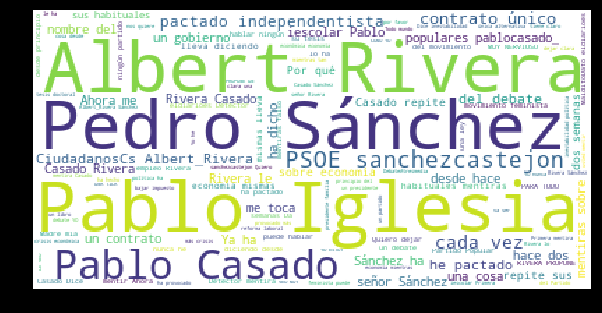

In [22]:
df_WordCloud = df_tweet
tokens = []
stopwords=["rt","RT","ElDebateDecisivo","http","https","el","la","los","las","que","no","si","co","en","de","es","con", "en", "se", "son"]

# Formateamos las palabras 
for i in range(len(df_WordCloud['text'])):
    sentence =df_WordCloud['text'][i]
    sentence = sentence.lower()
    words = re.findall(r'\w+', sentence, flags = re.UNICODE) 
    important_words=[]
    for word in words:
        if word not in stopwords:
            important_words.append(word)
    
    tokens.append(important_words)

df_WordCloud['StopWords'] = tokens

# Creamos la nube de palabras
wordcloud = WordCloud(background_color="white",stopwords=set(stopwords),random_state = 2016).generate(" ".join([i for i in df_WordCloud["text"]]))
plt.figure( figsize=(10,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")

Como era de esperar, las palabras más mencionadas son los nombres propios de cada presidente de los partidos, así como los nombres de los partidos. Eliminamos estas palabras para comprobar si se observan otras tendencias destacables:

(-0.5, 399.5, 199.5, -0.5)

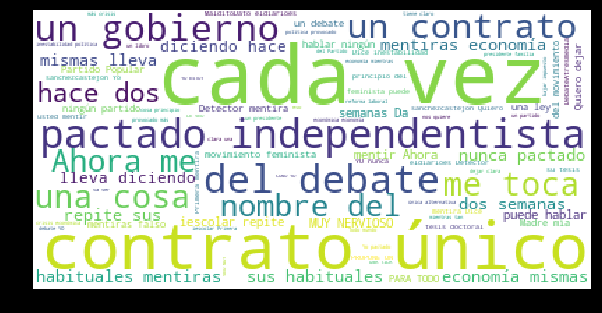

In [25]:
df_WordCloud = df_tweet
listaTokens = []

stopwords=["rt","RT","ElDebateDecisivo","http","https","el","la","los","las","que","no","si","co","en","de","es","con", "en", "se", "son", "PSOE","Cs",
           "Ciudadanos","Podemos","PP","Albert Rivera","Pedro Sánchez", "Pablo Iglesia", "Pablo Casado", "Casado","Rivera","Sánchez","Iglesia", "Albert_Rivera",
           "Pablo Iglesias","CiudadanosCs","pablocasado","Pablo", "pablocasado_", "ya", "Por", "desde","ha","he","sobre"]

for i in range(len(df_WordCloud['text'])):
    sentence =df_WordCloud['text'][i]
    sentence = sentence.lower()
    words = re.findall(r'\w+', sentence,flags = re.UNICODE) 
    important_words=[]
    for word in words:
        if word not in stopwords:
            important_words.append(word)
    
    listaTokens.append(important_words)

df_WordCloud['StopWords'] = listaTokens

# Creamos la nube de palabras
wordcloud = WordCloud(background_color="white",stopwords=set(stopwords),random_state = 2016).generate(" ".join([i for i in df_WordCloud["text"]]))
plt.figure( figsize=(10,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")


## 5. Análisis de sentimientos: ¿con qué partido se asocia más cada sentimiento?

Para hacer un breve análisis de sentimientos, se valorará la presencia en los tweets de 5 emociones distintas: pena, vergüenza, orgullo y sorpresa seguidas del nombre de cada partido o apellido de su presidente.

In [36]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from pandas import DataFrame
import numpy as np

def ComprobarApariciones(tweet):
    palabras = ["pena","vergüenza","orgullo","sorpresa"]
    PP = []
    PSOE = []
    Podemos = []
    Ciudadanos = []
    for palabra in palabras:
        contienePP = tweet["extended_tweet-full_text"].str.contains("PP|Casado", case=False) & tweet["extended_tweet-full_text"].str.contains(palabra, case=False)
        contienePSOE = tweet["extended_tweet-full_text"].str.contains("PSOE|Sánchez", case=False) & tweet["extended_tweet-full_text"].str.contains(palabra, case=False)
        contieneCiudadanos = tweet["extended_tweet-full_text"].str.contains("Ciudadanos|Rivera", case=False) & tweet["extended_tweet-full_text"].str.contains(palabra, case=False)
        contienePodemos = tweet["extended_tweet-full_text"].str.contains("Podemos|Iglesias", case=False) & tweet["extended_tweet-full_text"].str.contains(palabra, case=False)
        
        PP.append(contienePP.sum())
        PSOE.append(contienePSOE.sum())
        Ciudadanos.append(contieneCiudadanos.sum())
        Podemos.append(contienePodemos.sum())
    total = [PP, PSOE, Ciudadanos, Podemos]
    return PP,PSOE,Ciudadanos,Podemos,total
PP,PSOE,Ciudadanos,Podemos,total = ComprobarApariciones(df_tweet)

Para graficar los resultados nuevamente utilizaremos plotly:

In [32]:
trace1 = go.Bar(
    x=['Pena', 'Vergüenza', 'Orgullo', "Sorpresa"],
    y=PP,
    name='PP',
    marker=dict(
        color=["Blue","Blue","Blue","Blue"])
)
trace2 = go.Bar(
    x=['Pena', 'Vergüenza', 'Orgullo', "Sorpresa"],
    y=PSOE,
    name='PSOE',
    marker=dict(
    color=["Red","Red","Red","Red"])
)
trace3 = go.Bar(
    x=['Pena', 'Vergüenza', 'Orgullo', "Sorpresa"],
    y=Ciudadanos,
    name='Ciudadanos',
    marker=dict(
    color=["Orange","Orange","Orange","Orange"])
)
trace4 = go.Bar(
    x=['Pena', 'Vergüenza', 'Orgullo', "Sorpresa"],
    y=Podemos,
    name='Unidas podemos',
    marker=dict(
    color=["Purple","Purple","Purple","Purple"])
)

data = [trace1, trace2,trace3,trace4]
layout = go.Layout(
    title='¿Cuáles fueron las emociones más comunes por partido?',
    xaxis=dict(
        title='Partido Político'
    ),
    yaxis=dict(
        title='Número de tweets'
    ),
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

Como principal resultado cabe resaltar que las reacciones más encontradas en los tweets fueron negativas, en concreto la reacción de vergüenza destacó en todos los partidos, aunque especialmente en PP y Ciudadanos. 

Los partidos políticos de centro-derecha fueron los que generalmente despertaron más reacciones en los tuiteros. 
De estos resultados podría deducirse que el votante del PP suele ser el que menos miedo tiene a mostrar su ideología política y a enorgullecerse de ella en público. También se podría deducir que, generalmente la reacción de los espectadores frente al debate fue de decepción, donde la gran mayoría de tuiteros expresaron emociones de pena o vergüenza.

Podemos obtener este mismo gráfico de manera porcentual para ver la predominancia de reacciones en cada partido:

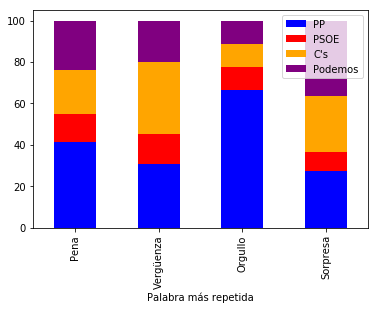

In [44]:
#Normalizamos
wPP=[]
wPSOE = []
wCiudadanos=[]
wPodemos=[]

for i in np.arange(0,4):
    wPP.append(total[0][i]/ np.sum(total, axis = 0)[i])
    wPSOE.append(total[1][i]/ np.sum(total, axis = 0)[i])
    wCiudadanos.append(total[2][i]/ np.sum(total, axis = 0)[i])
    wPodemos.append(total[3][i]/ np.sum(total, axis = 0)[i])
wordstotal = [wPP,wPSOE,wCiudadanos,wPodemos]

sent1 = list(np.array([wordstotal[0][0],wordstotal[1][0],wordstotal[2][0],wordstotal[3][0]]) * 100)
sent1.insert(0, 'Pena')

sent2 = list(np.array([wordstotal[0][1],wordstotal[1][1],wordstotal[2][1],wordstotal[3][1]]) * 100)
sent2.insert(0, 'Vergüenza')

sent3 = list(np.array([wordstotal[0][2],wordstotal[1][2],wordstotal[2][2],wordstotal[3][2]]) * 100)
sent3.insert(0, 'Orgullo')

sent4 = list(np.array([wordstotal[0][3],wordstotal[1][3],wordstotal[2][3],wordstotal[3][3]]) * 100)
sent4.insert(0, 'Sorpresa')

#Ploteamos
colors = ("Blue","Red","Orange","Purple")
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

data = [sent1,sent2,sent3,sent4]


df = DataFrame(data=data)
df.columns = ("Palabra más repetida","PP","PSOE","C's","Podemos")
df = df.set_index('Palabra más repetida')
df.plot(kind='bar', stacked=True, colormap=cmap1)
plt.show()

Resulta interesante ver como, en el primer gráfico obtenido se dedujo que el PSOE era el partido del que más se tuiteó durante el debate, sin embargo, es el que menos ha coincidido en frases que contengan la palabra "pena","vergüenza","orgullo" o "sorpresa", por lo que se puede deducir que no despertó ninguno de estos sentimientos entre sus votantes (al menos no de una forma destacable). 

Por el contrario, también vimos en el gráfico del punto 3 que el PP fue el segundo partido político del que más se habló y ahora sabemos como generó bastantes emociones, tanto positivas como negativas.